In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

model =Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

TRAINING_DIR = "/content/drive/MyDrive/Dataset/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    target_size=(150, 150))
VALIDATION_DIR = "/content/drive/MyDrive/Dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('/content/drive/MyDrive/model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


<ipython-input-3-5cd221b9aba7>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 0.6894 - acc: 0.6221

132/132 [==============================] - 371s 3s/step - loss: 0.6894 - acc: 0.6221 - val_loss: 0.5976 - val_acc: 0.9639
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.4908 - acc: 0.8563

132/132 [==============================] - 197s 1s/step - loss: 0.4908 - acc: 0.8563 - val_loss: 0.3613 - val_acc: 0.9742
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.4628 - acc: 0.8760

132/132 [==============================] - 204s 2s/step - loss: 0.4628 - acc: 0.8760 - val_loss: 0.3083 - val_acc: 0.9691
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.3422 - acc: 0.8875

132/132 [==============================] - 202s 2s/step - loss: 0.3422 - acc: 0.8875 - val_loss: 0.1145 - val_acc: 0.9691
Epoch 5/10
132/132 [==============================] - 188s 1s/step - loss: 0.2872 - acc: 0.8966 - val_loss: 0.1715 - val_acc: 0.9330
Epoch 6/10
132/132 [==============================] - 193s 1s/step - loss: 0.2997 - acc: 0.8943 - val_loss: 0.1492 - val_acc: 0.9639
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 0.2609 - acc: 0.9011

132/132 [==============================] - 193s 1s/step - loss: 0.2609 - acc: 0.9011 - val_loss: 0.0693 - val_acc: 0.9794
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 0.2107 - acc: 0.9300

132/132 [==============================] - 189s 1s/step - loss: 0.2107 - acc: 0.9300 - val_loss: 0.0643 - val_acc: 0.9897
Epoch 9/10
132/132 [==============================] - 199s 2s/step - loss: 0.2446 - acc: 0.9095 - val_loss: 0.1009 - val_acc: 0.9536
Epoch 10/10
132/132 [==============================] - 191s 1s/step - loss: 0.2005 - acc: 0.9293 - val_loss: 0.0806 - val_acc: 0.9742


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("/content/drive/MyDrive/model2-008.model")

labels_dict={0:'without mask',1:'mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('/home/shivam/.local/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml')
print(classifier)

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror
    print(im)

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)

        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

< cv2.CascadeClassifier 0x7ec6dcbe7c70>
None


AttributeError: ignored

In [ ]:
import cv2

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
else:
    print("Camera opened successfully.")

cap.release()


Error: Could not open camera.


Price prediction

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [4]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [5]:
col=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]

In [6]:
# Initializing the dataframe
data = pd.DataFrame(data)

In [7]:
data.columns=col
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [8]:
data.shape

(506, 13)

In [9]:
data["PRICE"]=target

In [10]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [11]:
# Spliting target variable and independent variables
X = data.drop(['PRICE'], axis = 1)
y = data['PRICE']

In [12]:
# Splitting to training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

In [13]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets
reg.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
# Model prediction on train data
y_pred = reg.predict(X_train)

In [15]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9791755002581043
Adjusted R^2: 0.97837926938562
MAE: 0.8273898305084755
MSE: 1.5674773728813574
RMSE: 1.2519893661215167


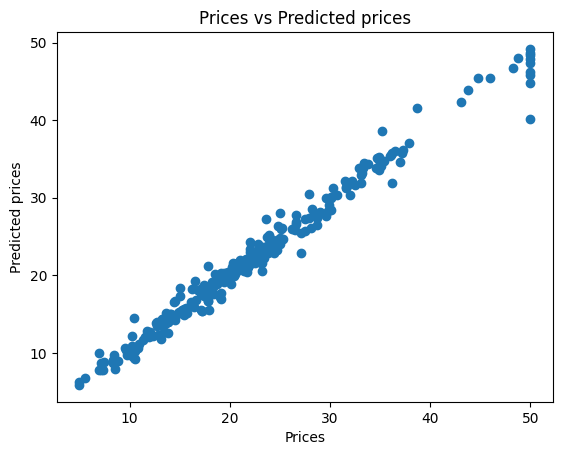

In [16]:
# Visualizing the differences between actual prices and predicted values for train data
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

In [17]:
# Predicting Test data with the model
y_test_pred = reg.predict(X_test)

In [18]:
# Model Evaluation
acc_rf = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.8312483759316782
Adjusted R^2: 0.8153514838093001
MAE: 2.5022565789473683
MSE: 17.621056782894744
RMSE: 4.1977442493433


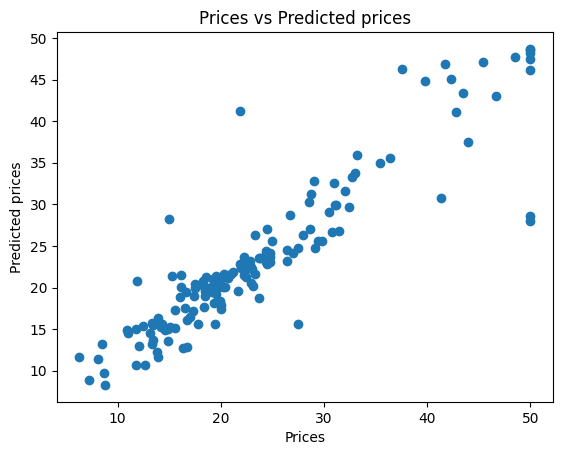

In [19]:
# Visualizing the differences between actual prices and predicted values for test data
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

Sign language

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
# import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
train_df=pd.read_csv('sign_mnist_train.csv')
test_df=pd.read_csv('sign_mnist_test.csv')

In [30]:
train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)
trainset.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     107     118     127     134     139     143     146     150     153   
1     155     157     156     156     156     157     156     158     158   
2     187     188     188     187     187     186     187     188     187   
3     211     211     212     212     211     210     211     210     210   
4     164     167     170     172     176     179     180     184     185   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0      156  ...       207       207       207       207       206       206   
1      157  ...        69       149       128        87        94       163   
2      186  ...       202       201       200       199       198       199   
3      211  ...       235       234       233       231       230       226   
4      186  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  
3       225       222       229       163  
4       157       163       164       179  

[5 rows x 784 columns]

In [31]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27455, 28, 28, 1)


In [32]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(7172, 784)


pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0     149     149     150     150     150     151     151     150     151   
1     126     128     131     132     133     134     135     135     136   
2      85      88      92      96     105     123     135     143     147   
3     203     205     207     206     207     209     210     209     210   
4     188     191     193     195     199     201     202     203     203   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0      152  ...       138       148       127        89        82        96   
1      138  ...        47       104       194       183       186       184   
2      152  ...        68       166       242       227       230       227   
3      209  ...       154       248       247       248       253       236   
4      203  ...        26        40        64        48        29        46   

   pixel781  pixel782  pixel783  pixel784  
0       106       112       120       107  
1       184       184       182       180  
2       226       225       224       222  
3       230       240       253       255  
4        49        46        46        53  

[5 rows x 784 columns]

In [33]:
#Converting the integer labels to binary form
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)

In [34]:
X_test=X_test.values.reshape(-1,28,28,1)

In [35]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27455, 28, 28, 1) (27455, 24) (7172, 28, 28, 1) (7172, 24)


In [36]:
#Augmenting the image dataset to generate new data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

Text(0.5, 1.0, 'label: 13  letter: M')

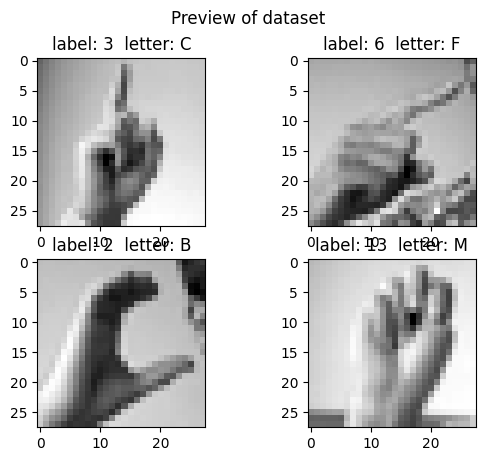

In [37]:
#Visualization of the Dataset
fig,axe=plt.subplots(2,2)
fig.suptitle('Preview of dataset')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: C')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: F')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: B')
axe[1,1].imshow(X_train[4].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 13  letter: M')

In [38]:
#model
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))

model.add(Flatten())

In [39]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

In [40]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
#training
model.fit(train_datagen.flow(X_train,y_train,batch_size=200),
         epochs = 35,
          validation_data=(X_test,y_test),
          shuffle=1
         )

Epoch 1/35
138/138 [==============================] - 57s 409ms/step - loss: 0.5938 - accuracy: 0.7987 - val_loss: 0.3296 - val_accuracy: 0.8911
Epoch 2/35
138/138 [==============================] - 58s 416ms/step - loss: 0.5457 - accuracy: 0.8135 - val_loss: 0.2110 - val_accuracy: 0.9371
Epoch 3/35
138/138 [==============================] - 56s 405ms/step - loss: 0.4991 - accuracy: 0.8334 - val_loss: 0.2085 - val_accuracy: 0.9329
Epoch 4/35
138/138 [==============================] - 54s 395ms/step - loss: 0.4578 - accuracy: 0.8442 - val_loss: 0.2468 - val_accuracy: 0.9186
Epoch 5/35
138/138 [==============================] - 57s 409ms/step - loss: 0.4111 - accuracy: 0.8599 - val_loss: 0.1619 - val_accuracy: 0.9490
Epoch 6/35
138/138 [==============================] - 57s 414ms/step - loss: 0.3931 - accuracy: 0.8672 - val_loss: 0.1177 - val_accuracy: 0.9732
Epoch 7/35
138/138 [==============================] - 37s 266ms/step - loss: 0.3519 - accuracy: 0.8806 - val_loss: 0.1289 - val_ac

In [45]:
import pickle
pickle.dump(model,open("model.pkl","wb"))

In [46]:
import pickle
model=pickle.load(open("model.pkl","rb"))

In [47]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)
print('MODEL ACCURACY = {}%'.format(acc*100))

225/225 [==============================] - 3s 12ms/step - loss: 0.0147 - accuracy: 0.9950
MODEL ACCURACY = 99.49804544448853%


In [48]:
class_names={0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",24:"Y",25:"Z"}
class_names[1]

'B'

225/225 [==============================] - 8s 34ms/step


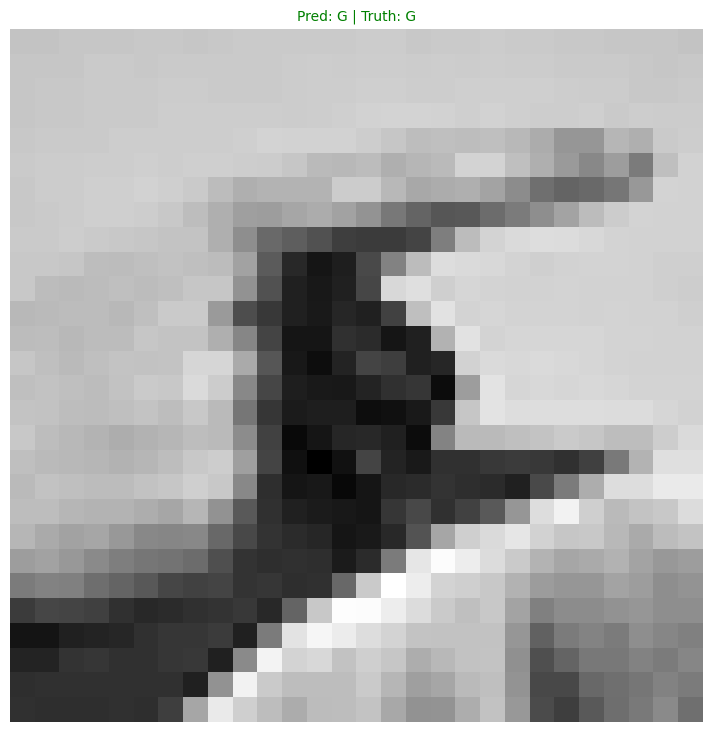

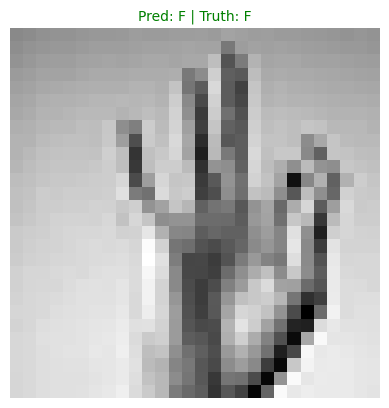

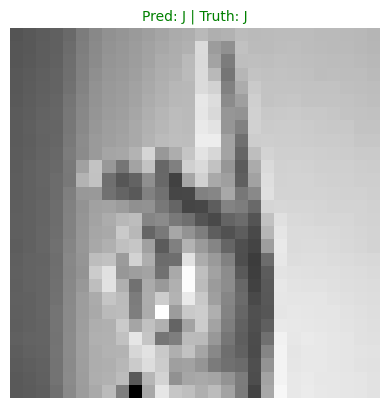

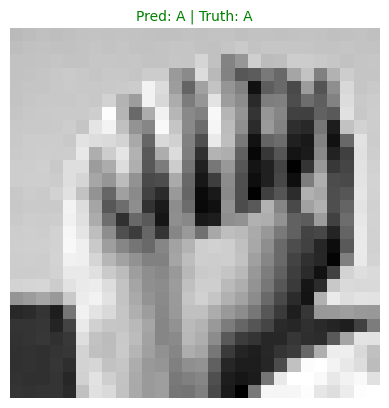

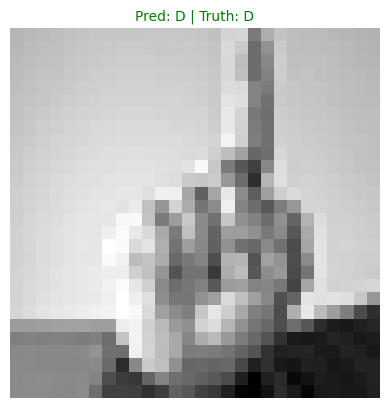

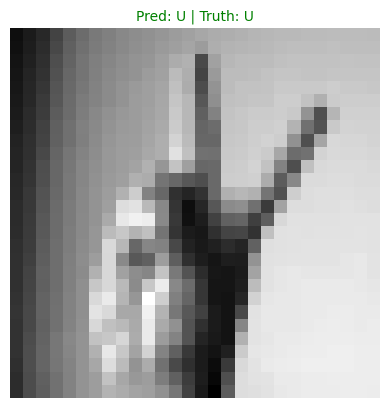

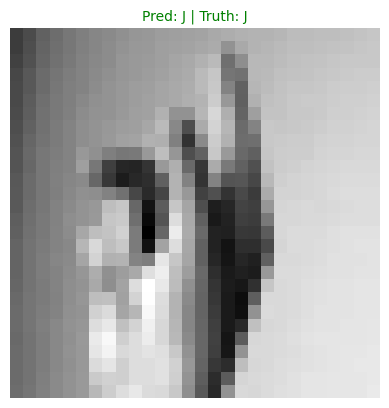

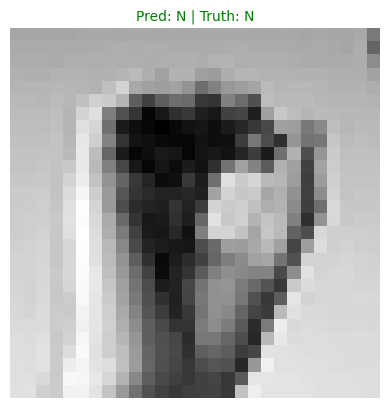

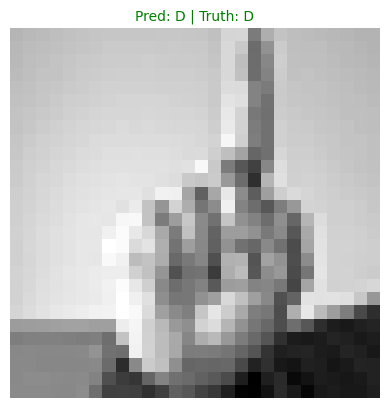

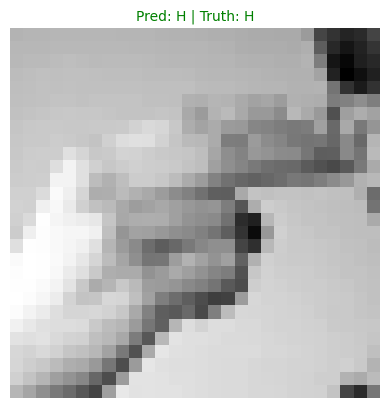

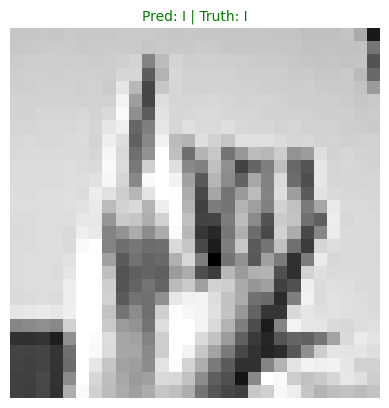

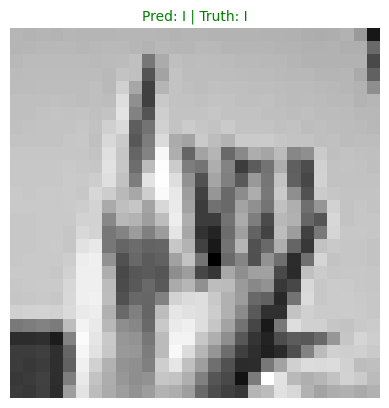

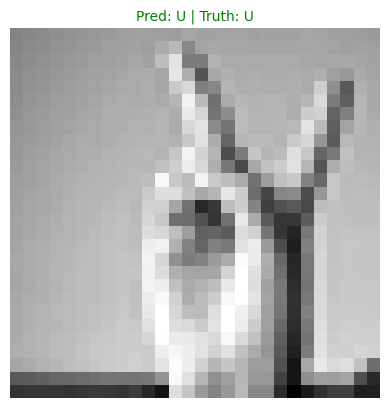

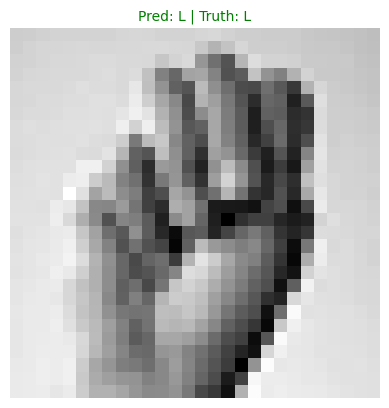

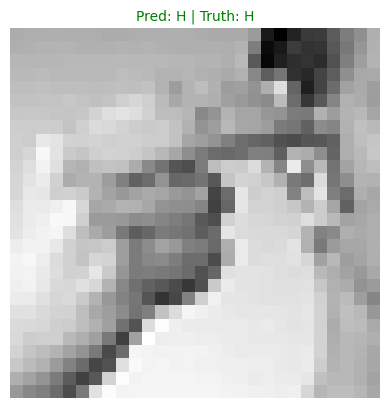

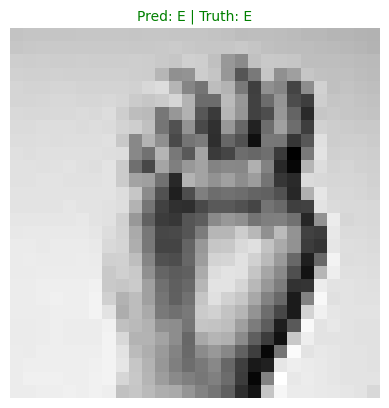

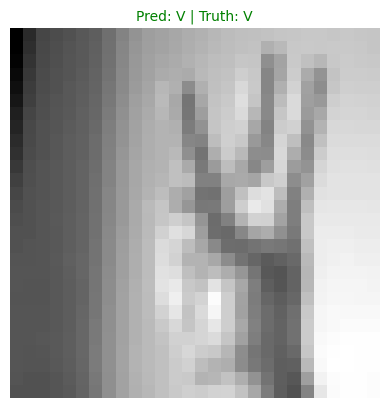

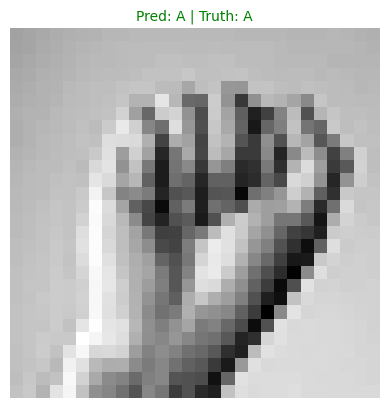

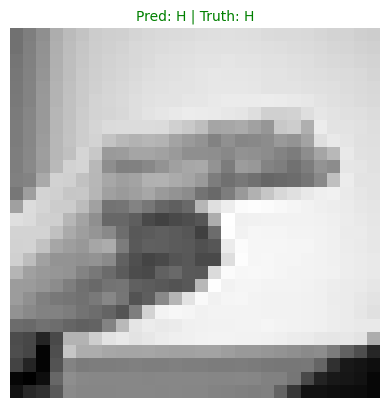

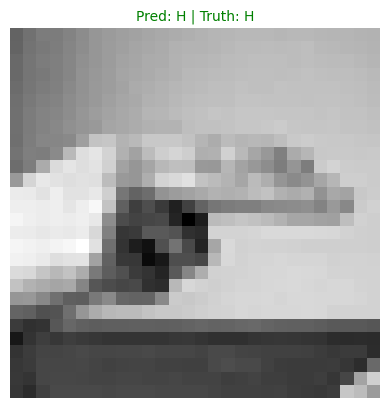

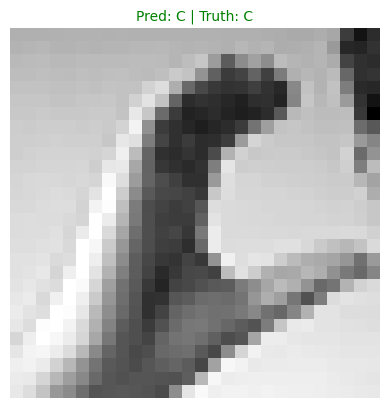

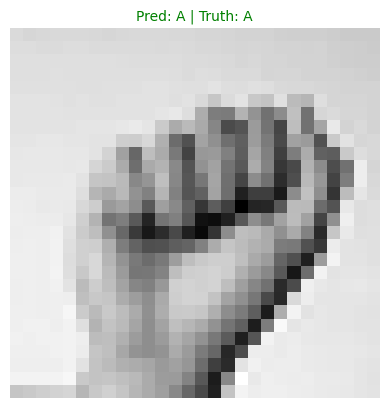

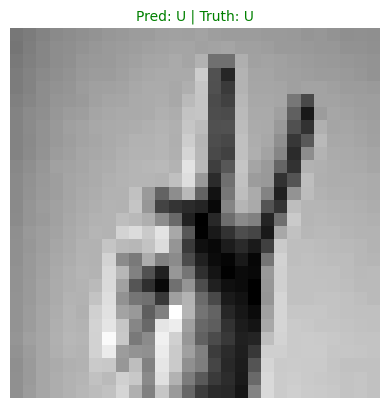

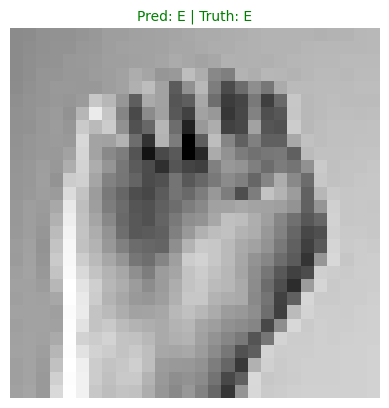

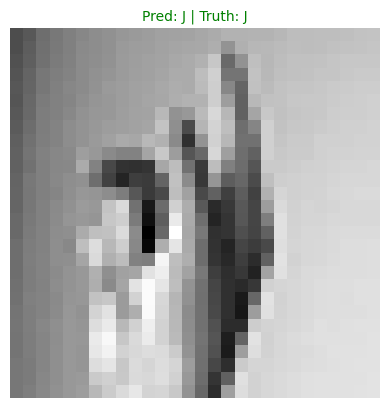

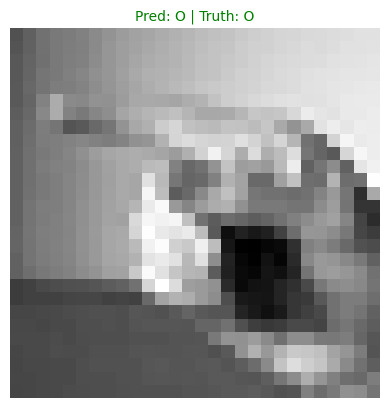

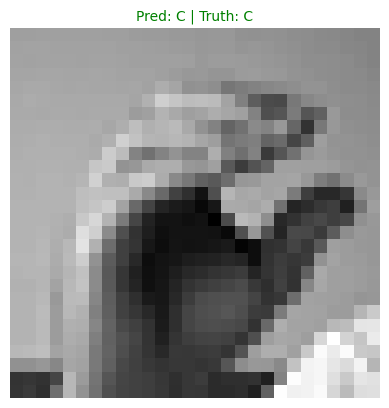

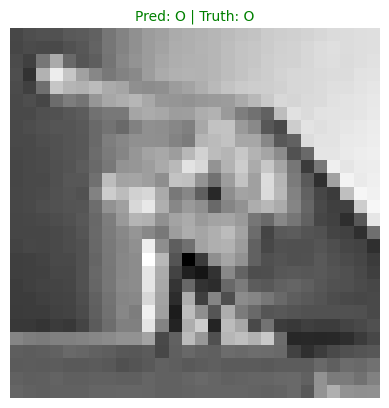

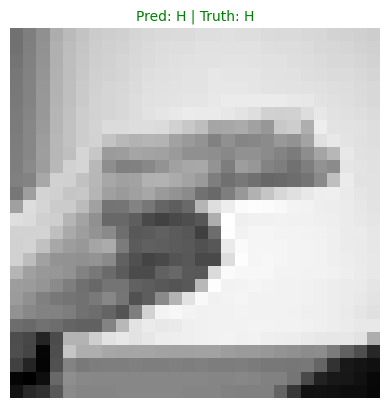

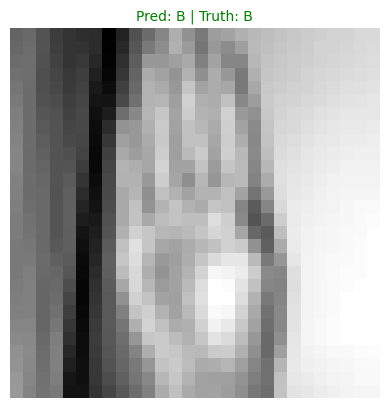

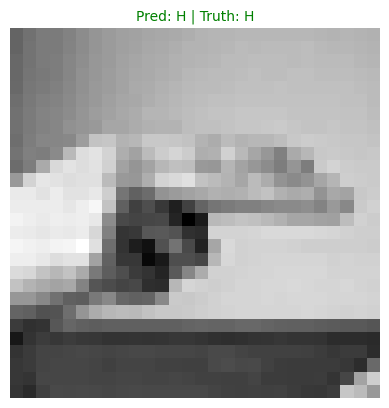

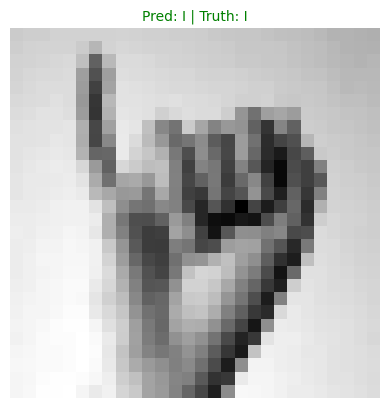

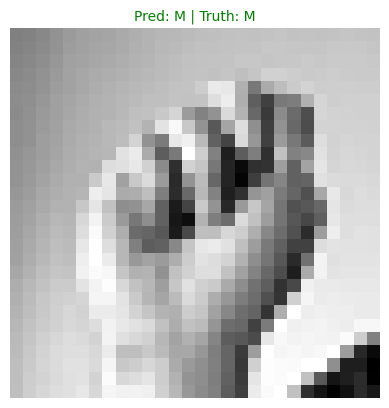

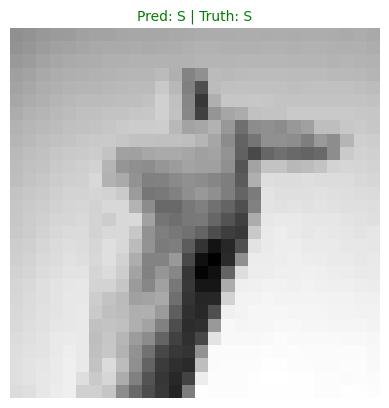

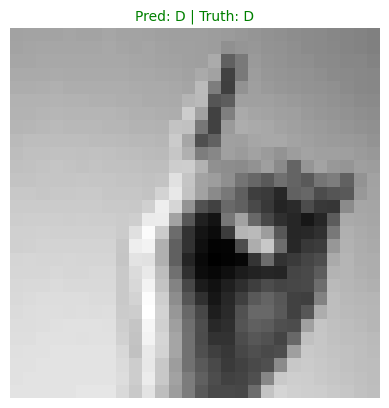

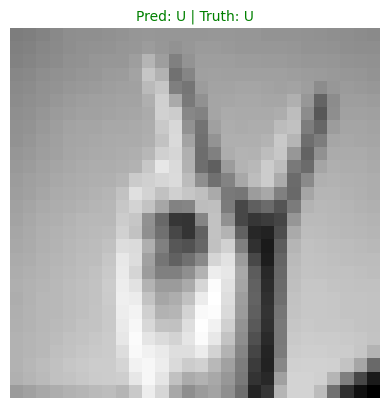

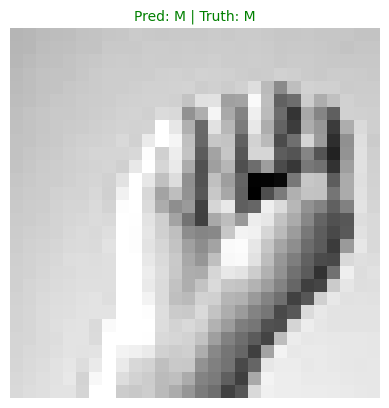

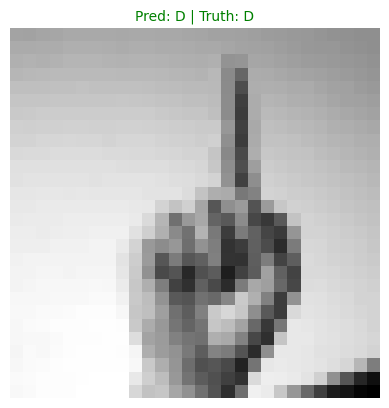

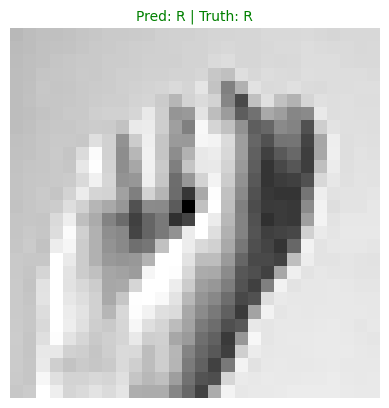

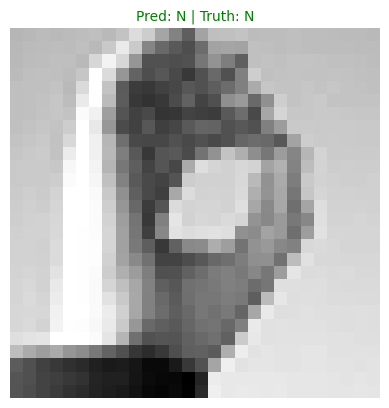

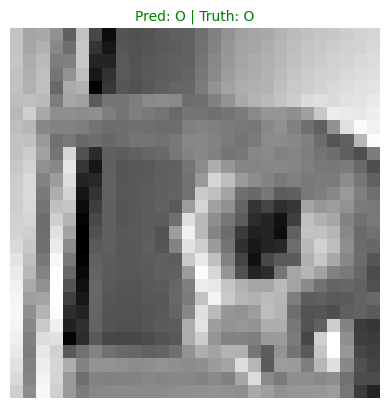

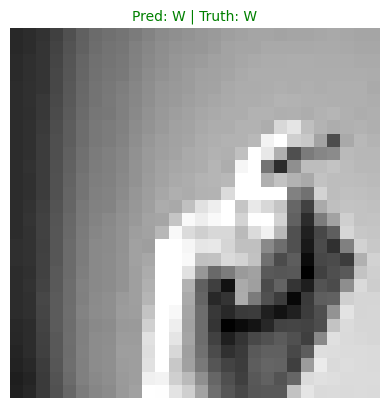

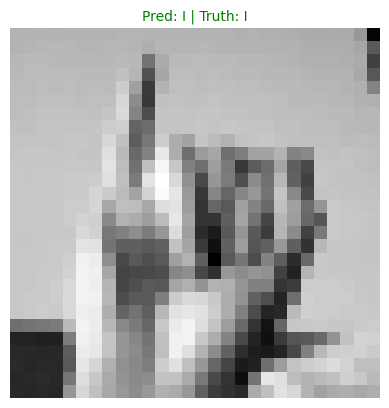

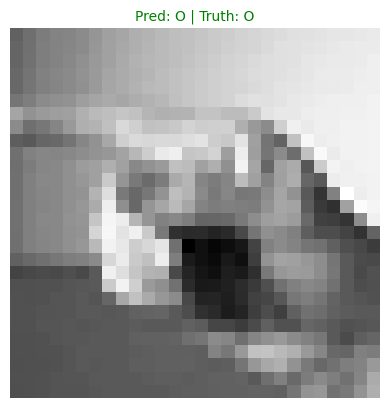

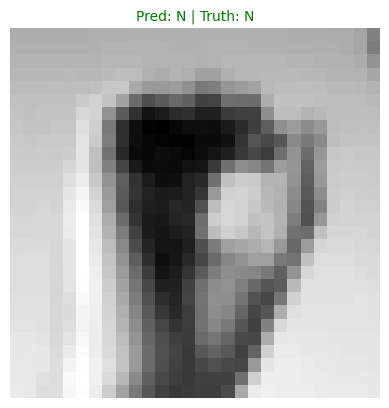

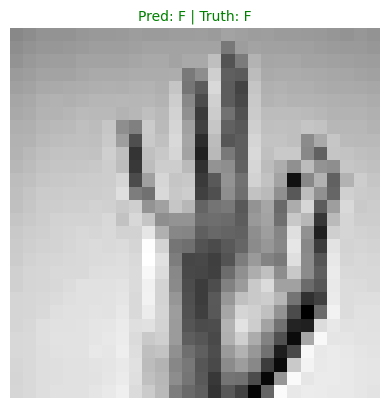

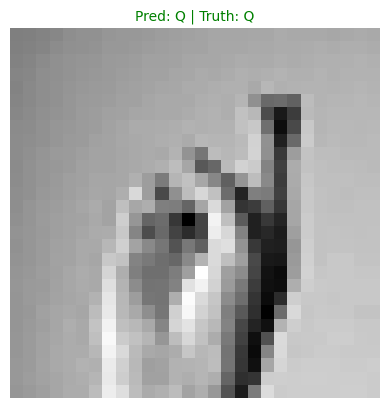

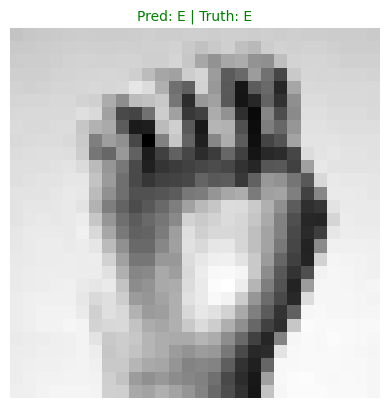

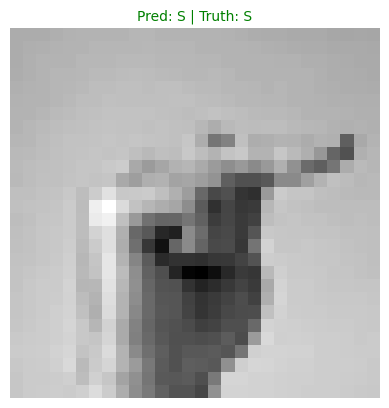

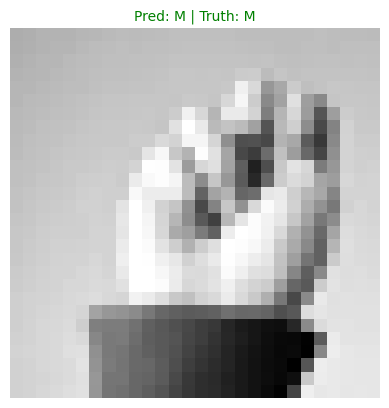

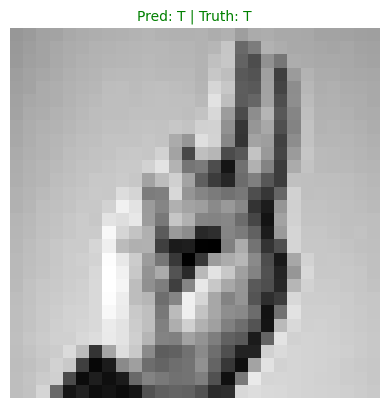

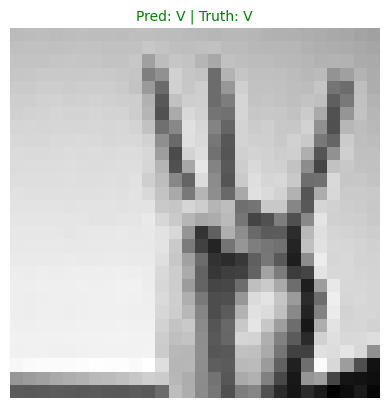

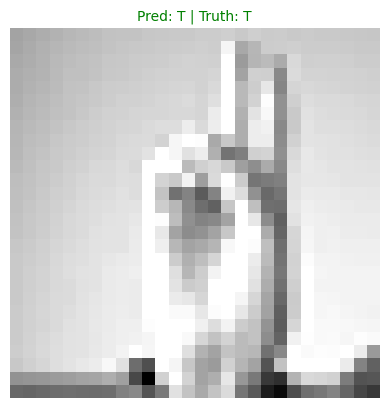

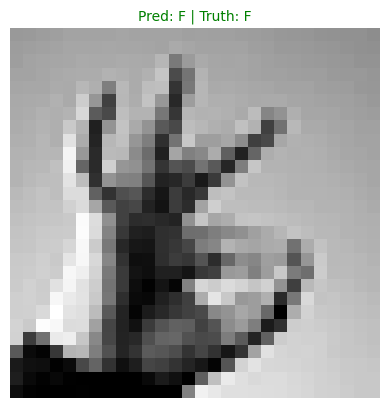

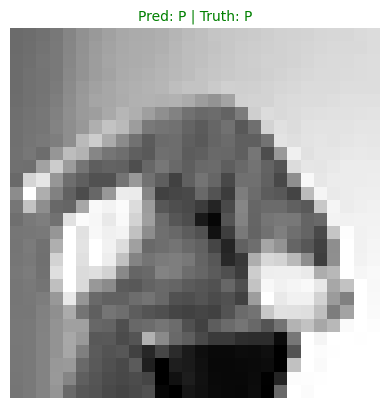

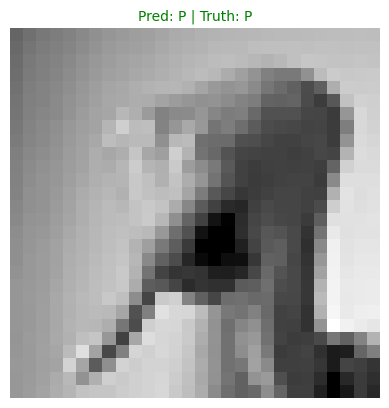

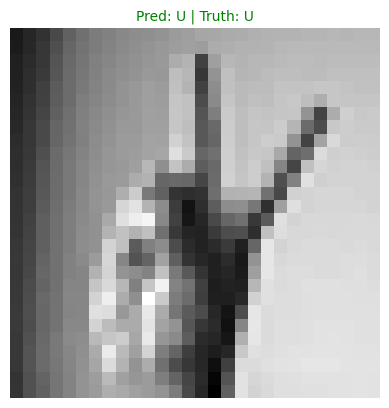

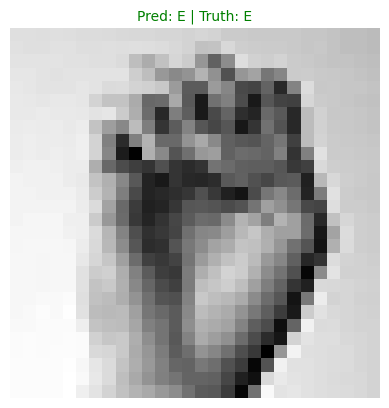

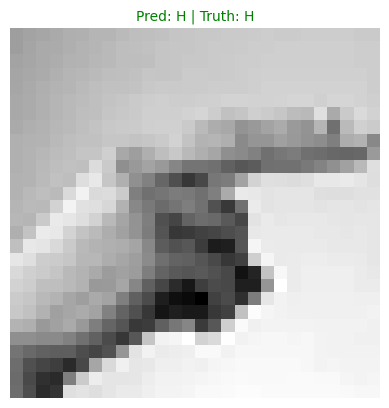

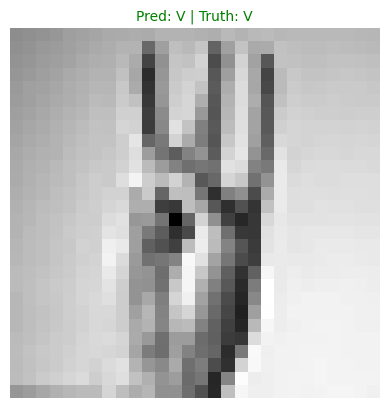

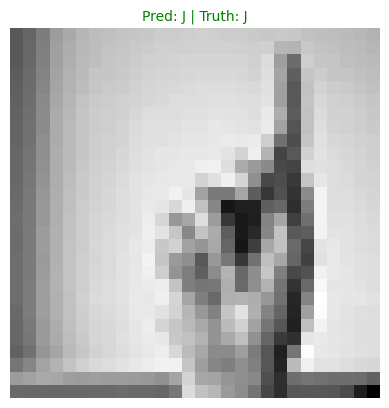

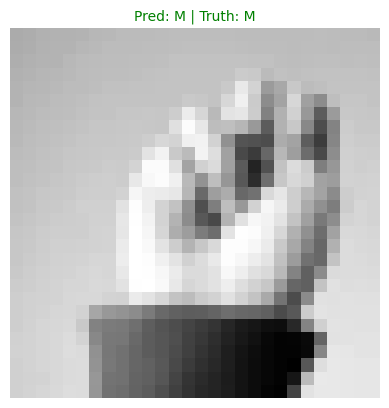

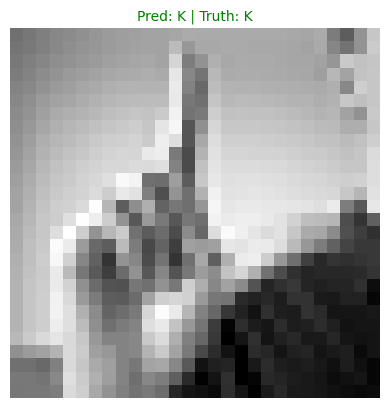

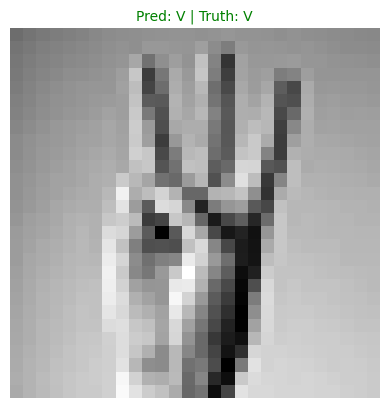

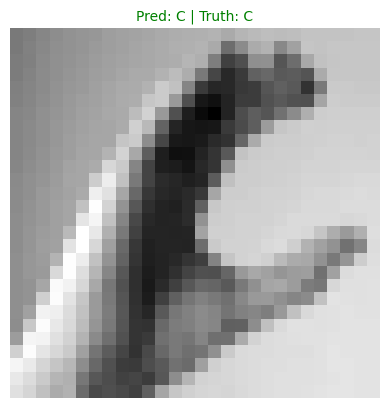

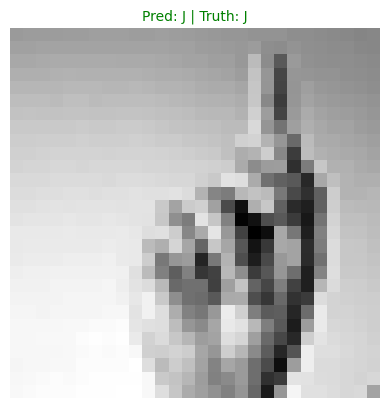

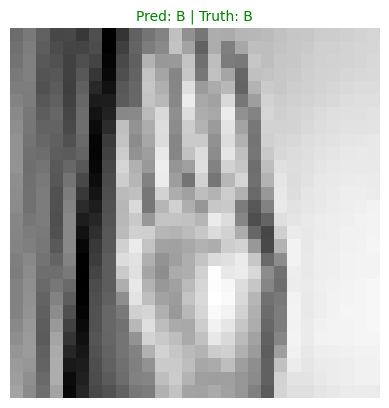

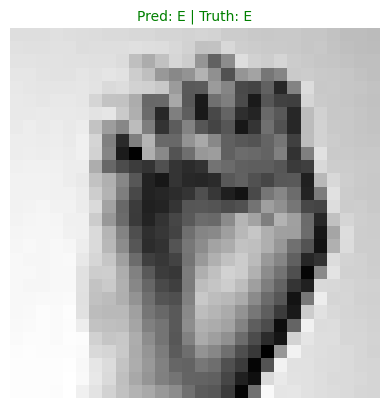

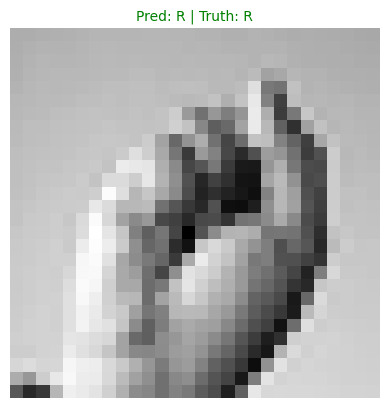

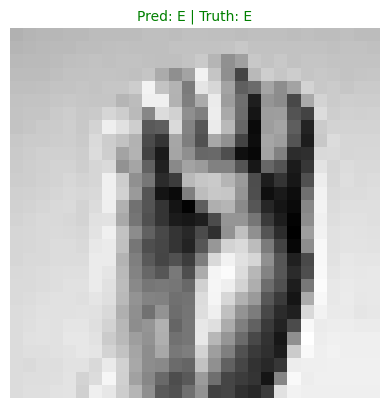

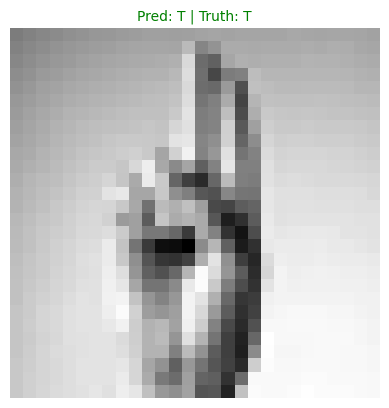

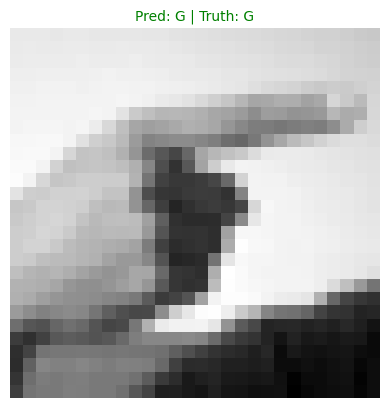

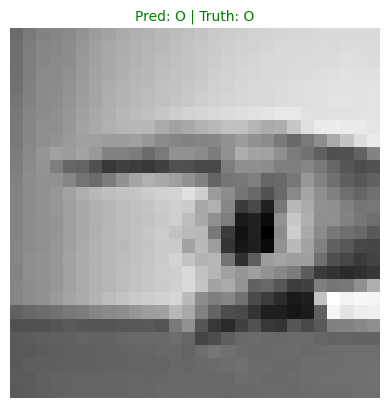

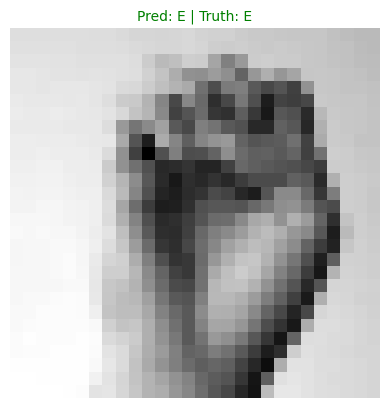

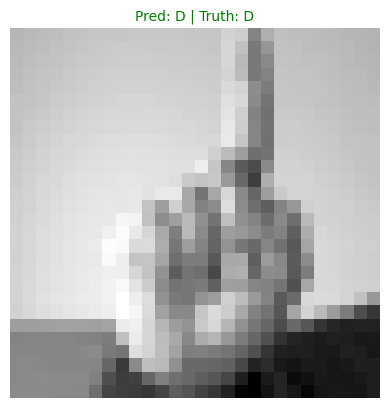

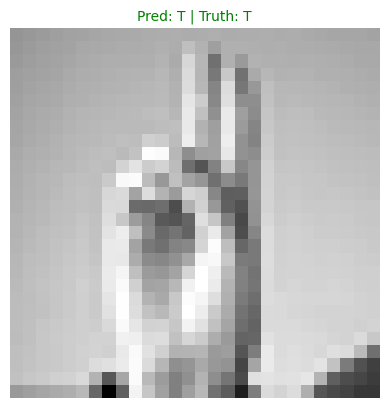

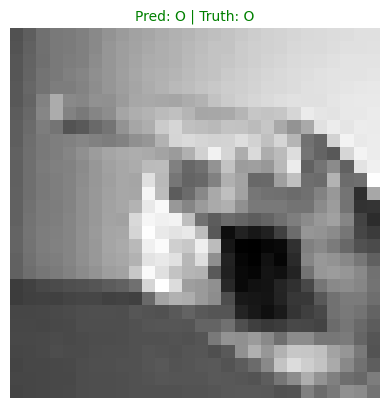

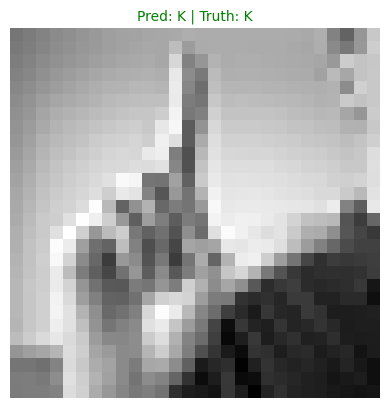

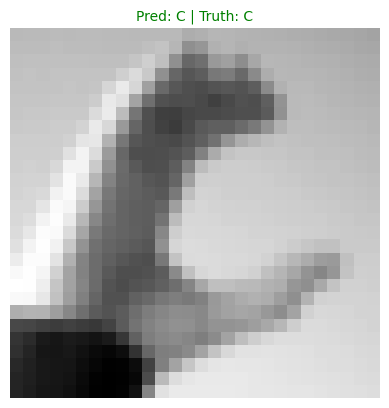

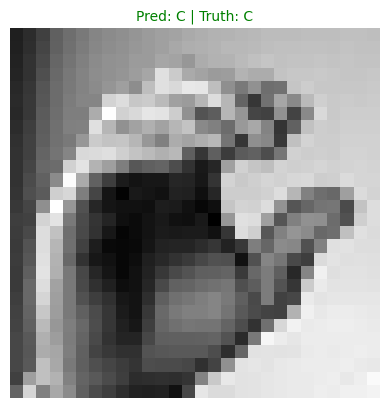

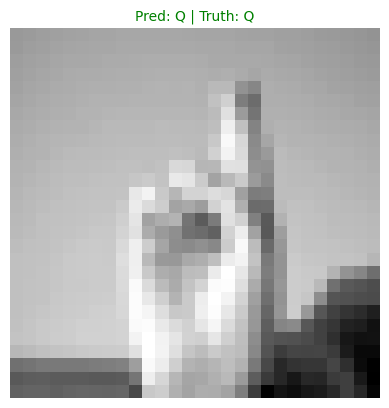

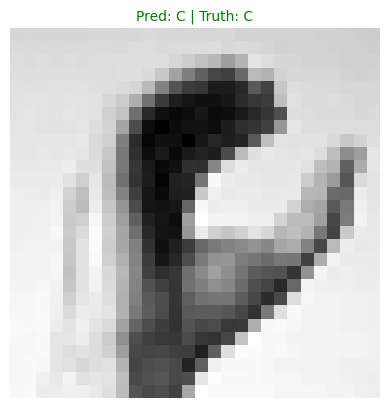

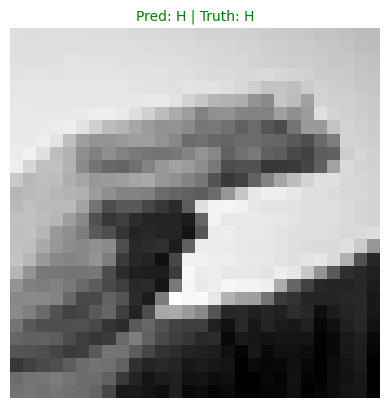

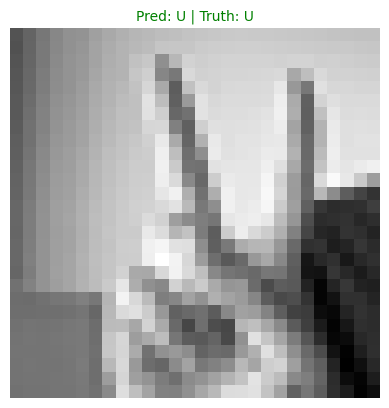

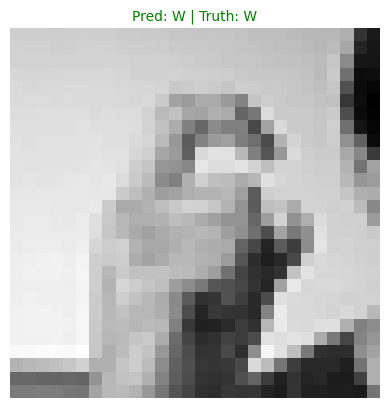

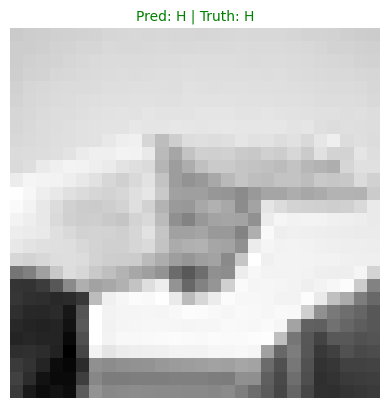

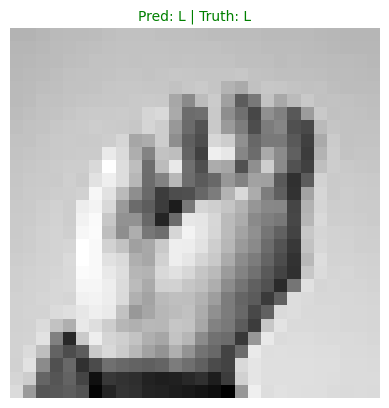

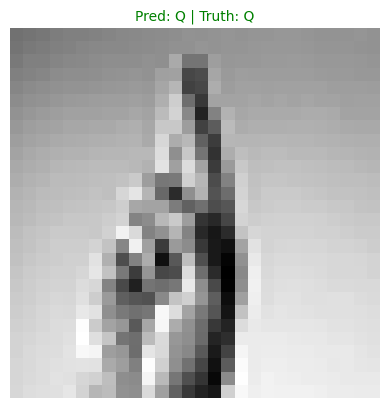

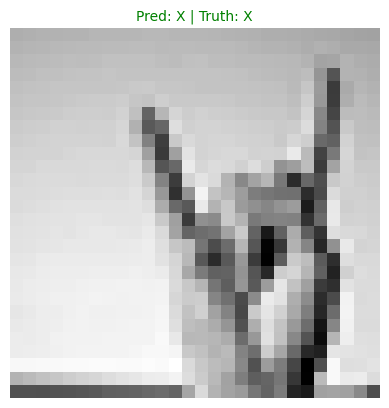

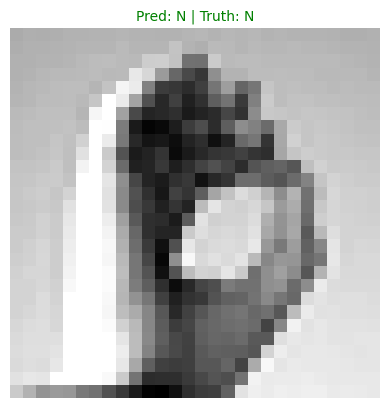

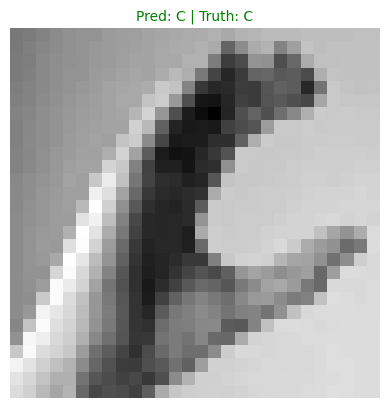

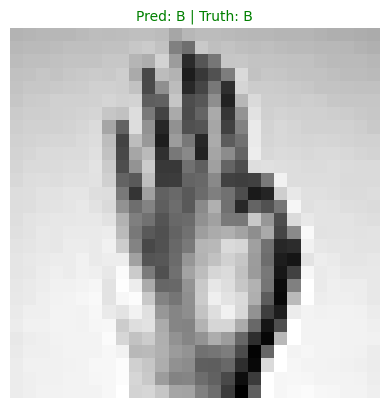

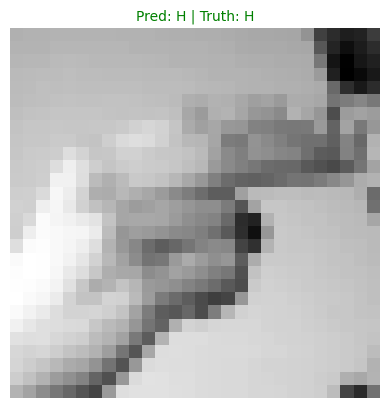

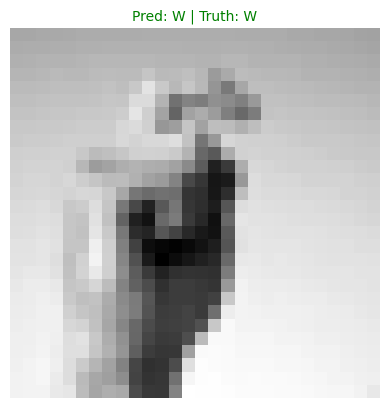

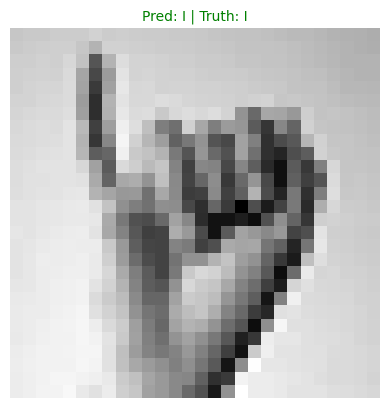

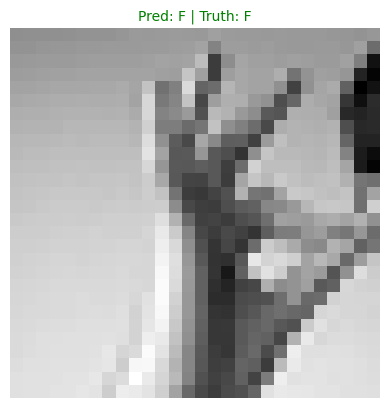

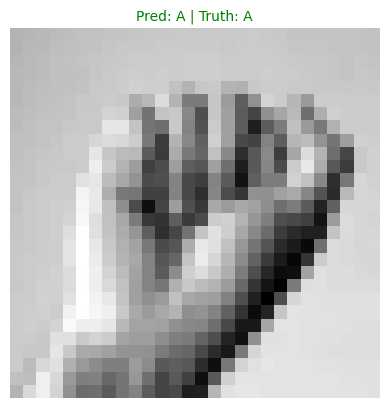

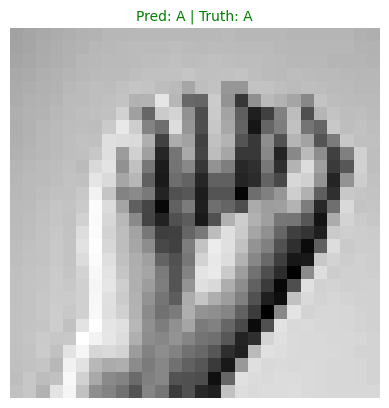

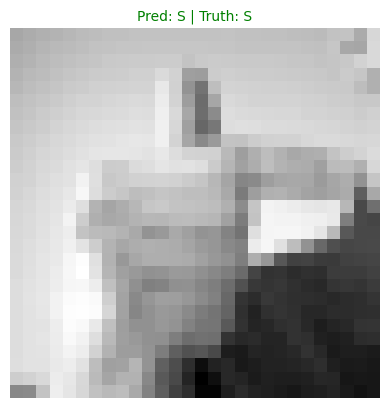

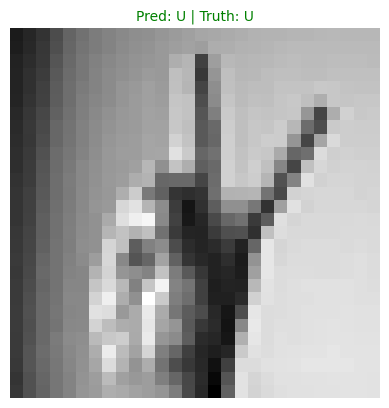

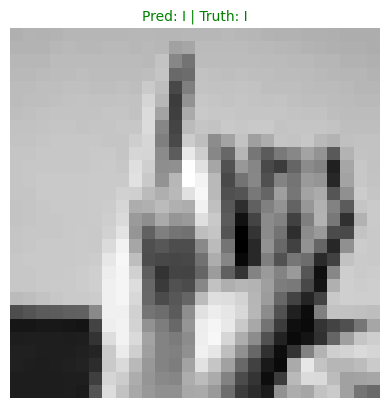

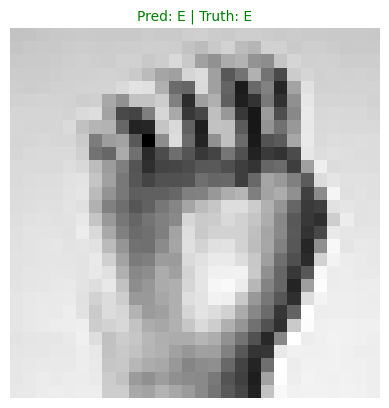

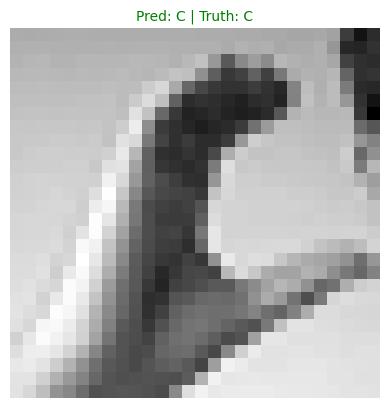

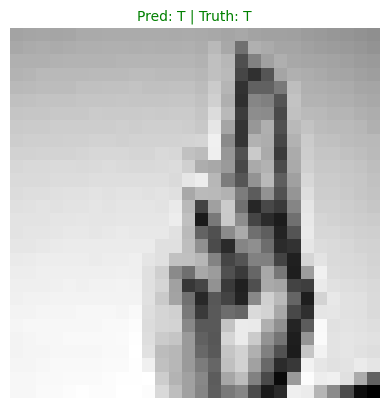

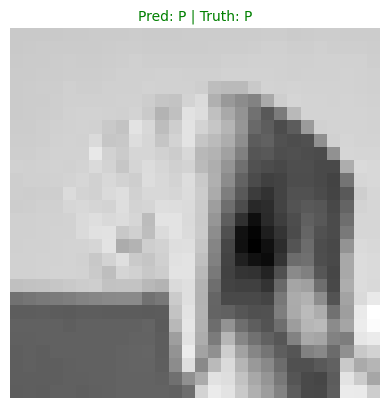

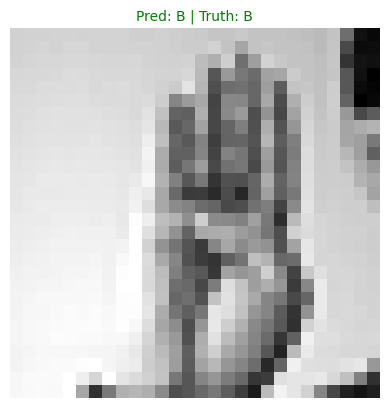

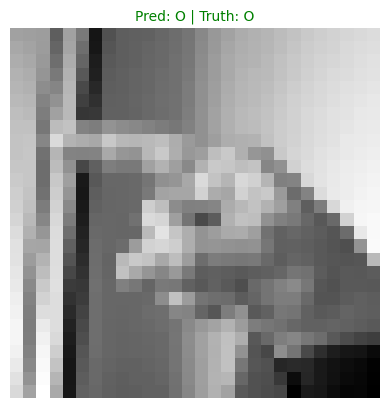

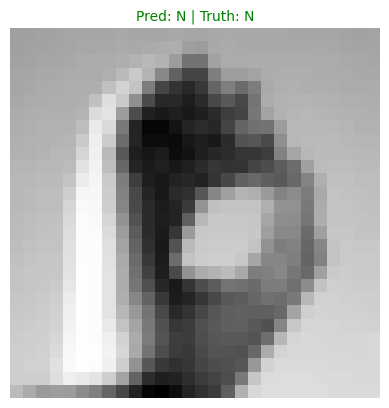

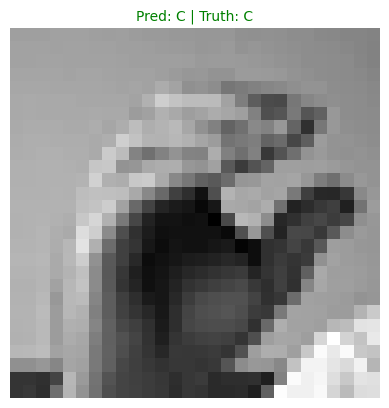

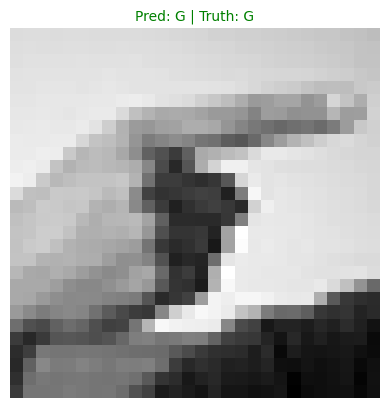

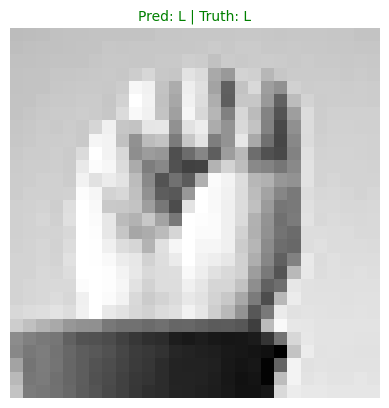

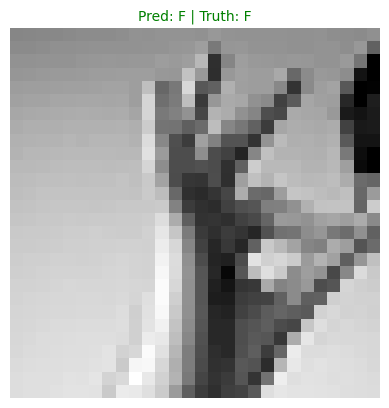

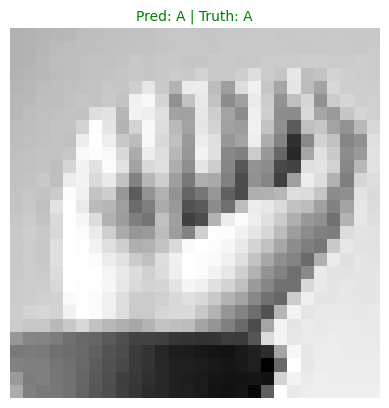

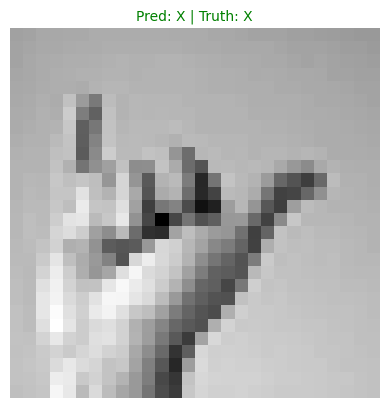

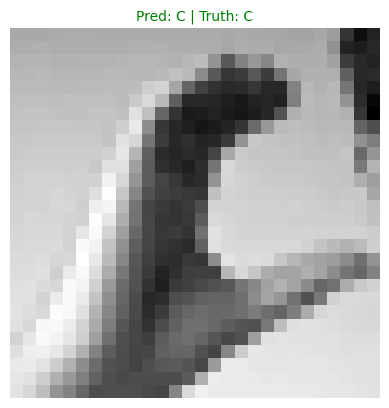

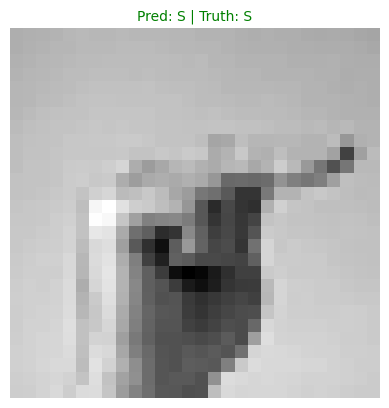

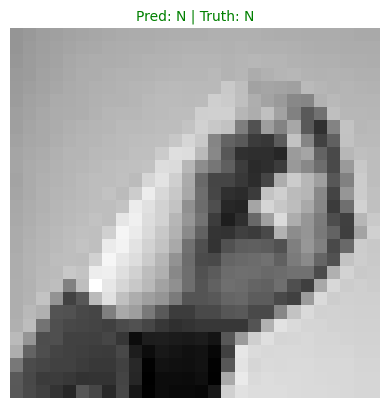

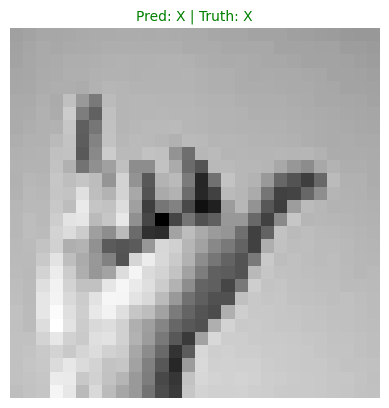

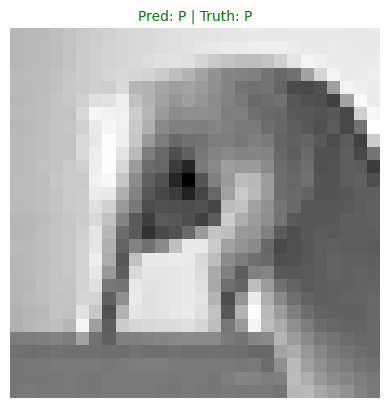

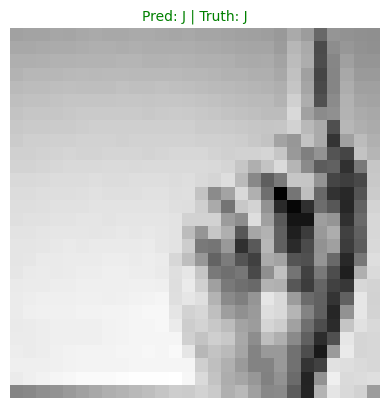

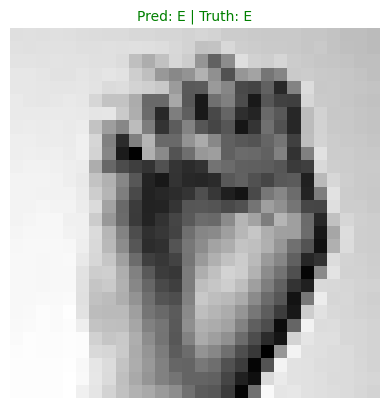

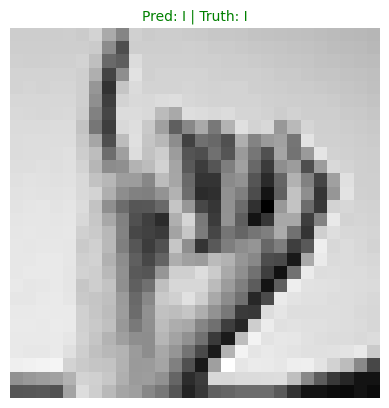

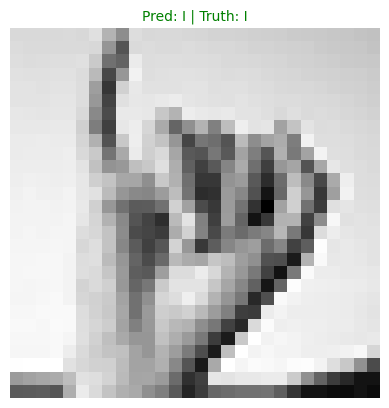

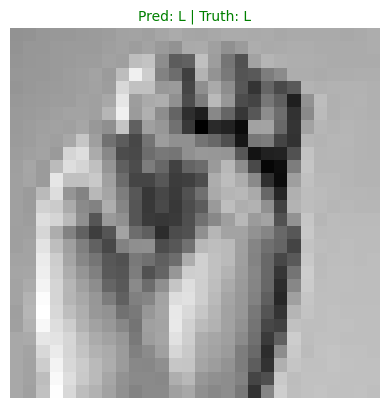

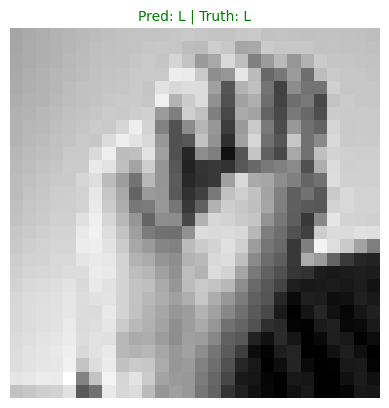

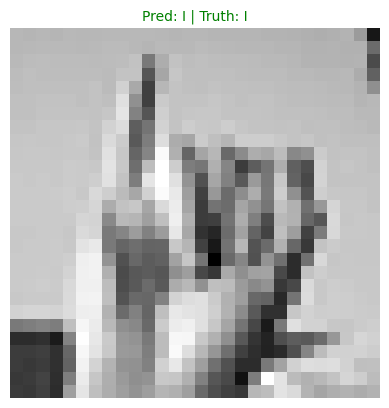

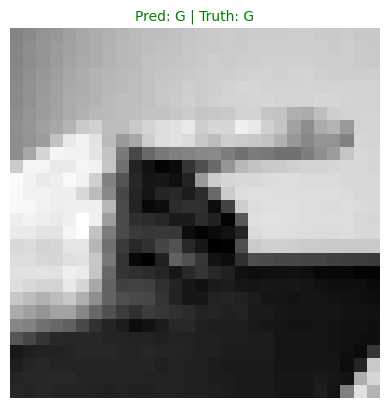

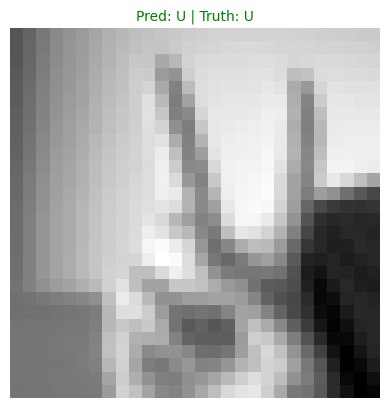

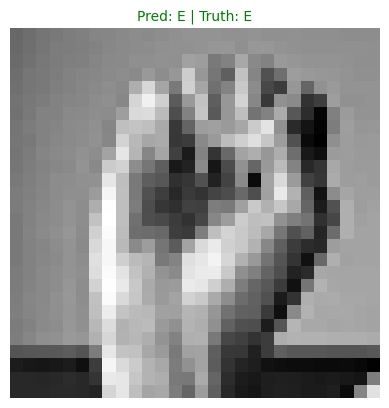

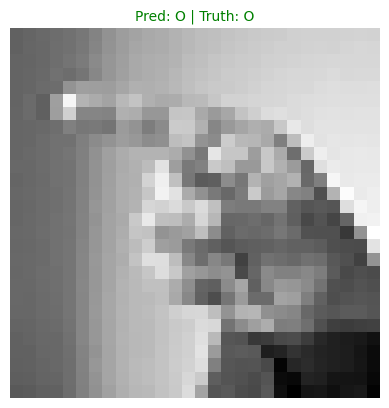

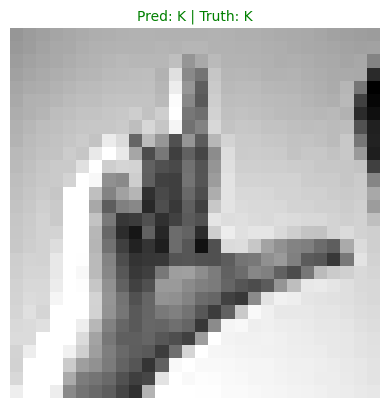

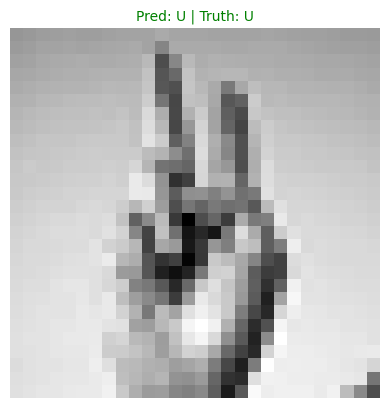

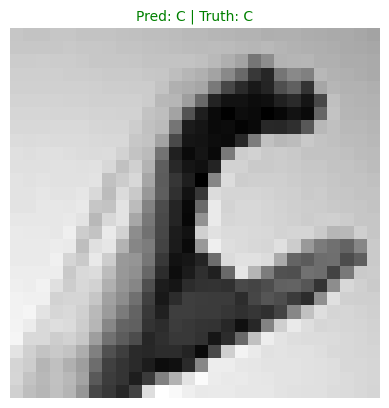

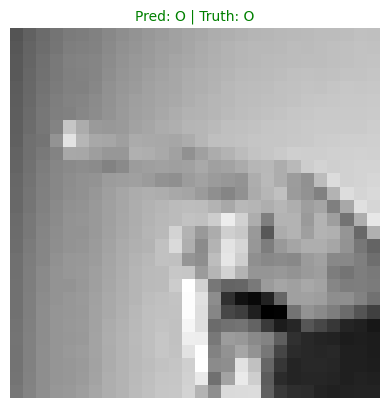

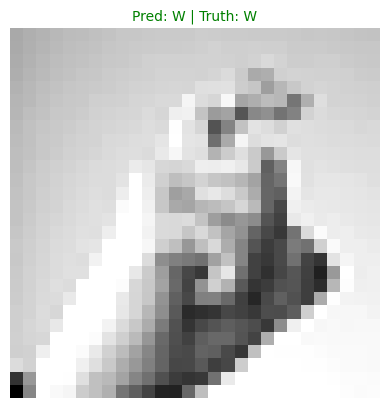

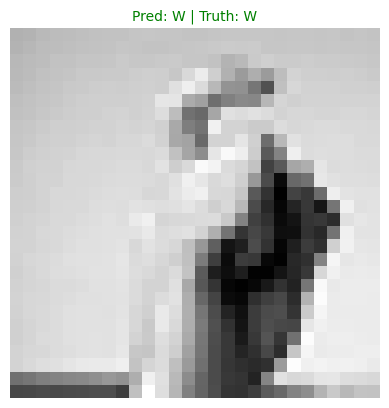

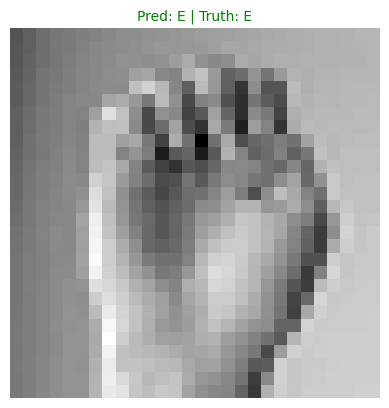

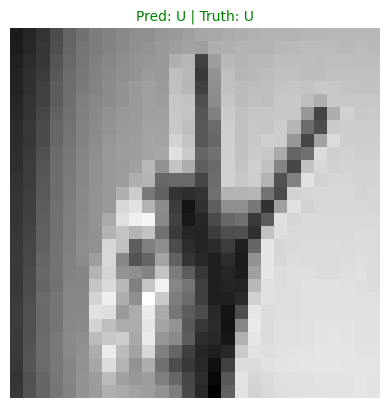

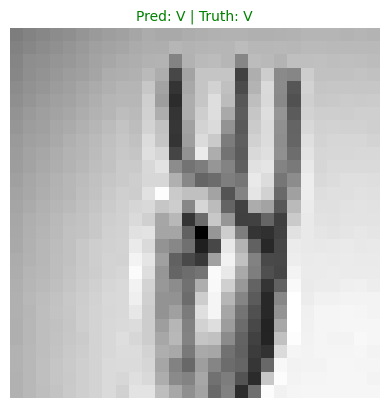

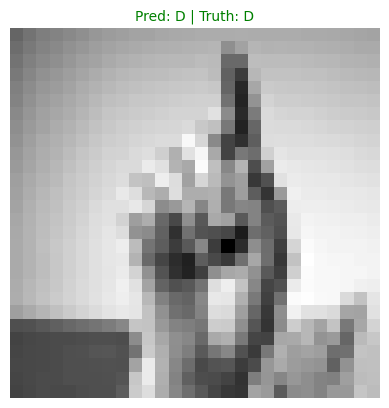

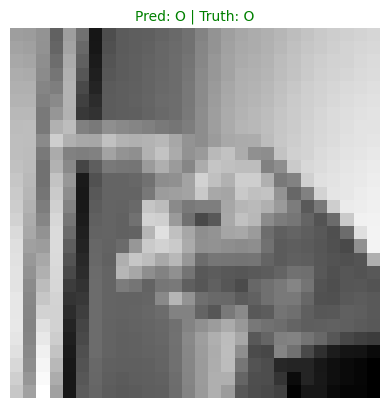

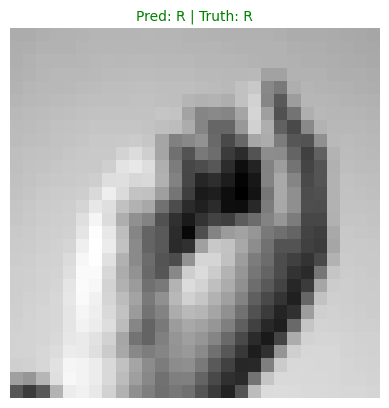

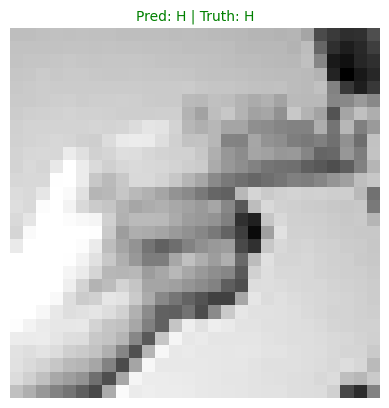

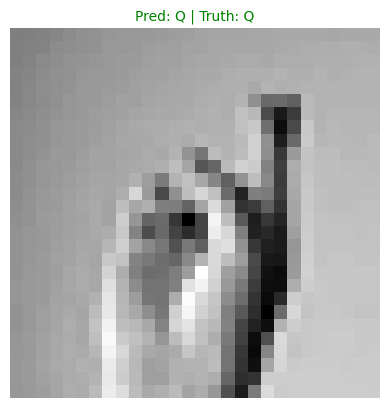

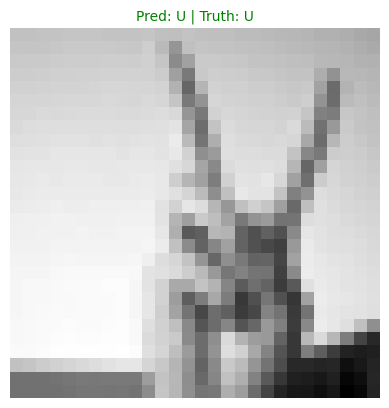

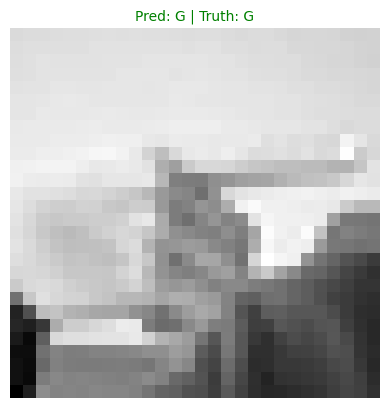

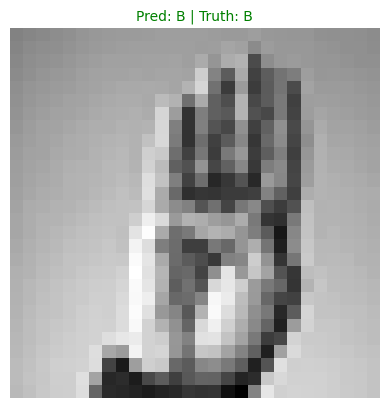

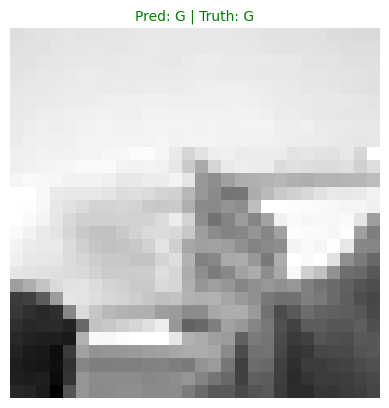

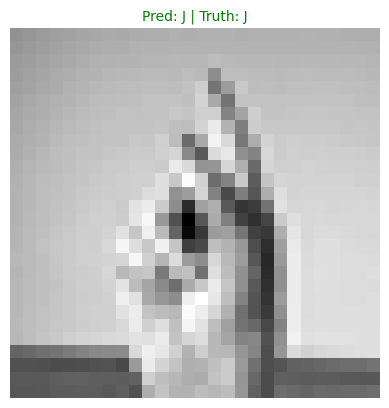

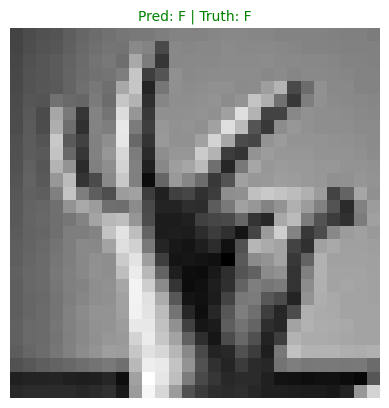

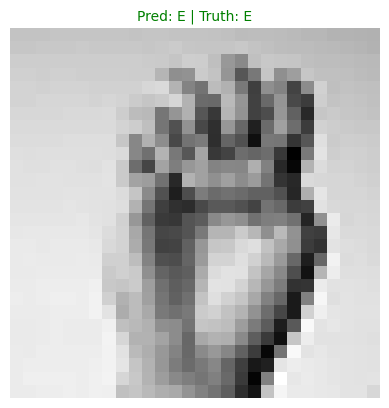

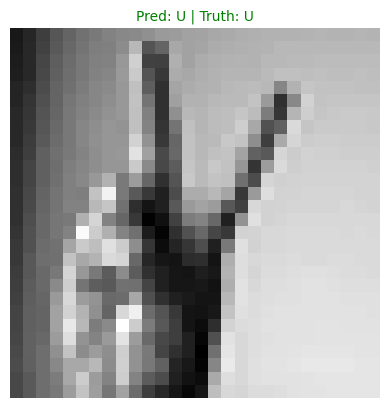

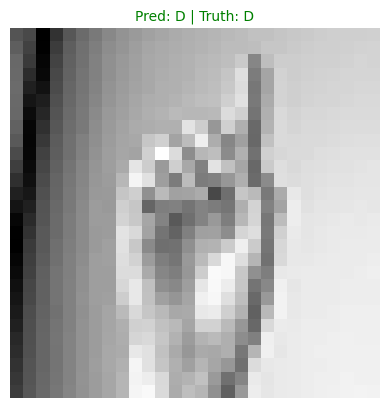

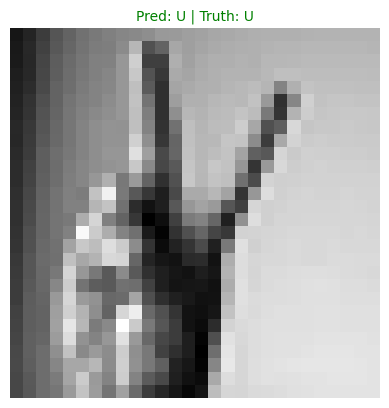

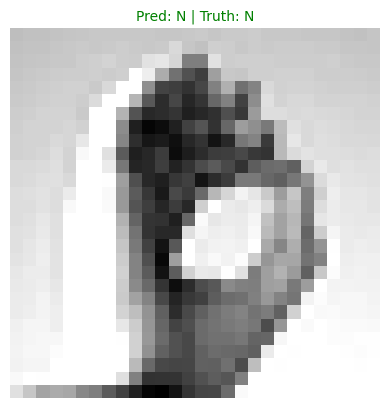

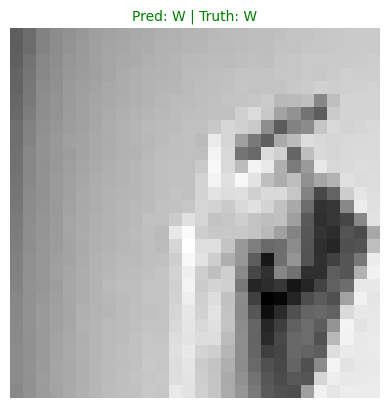

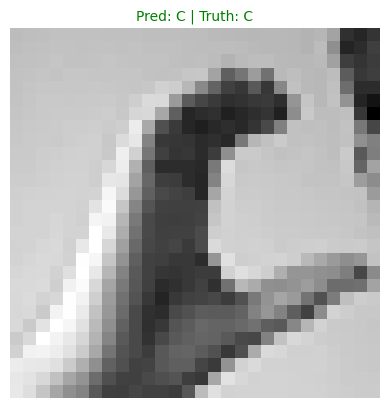

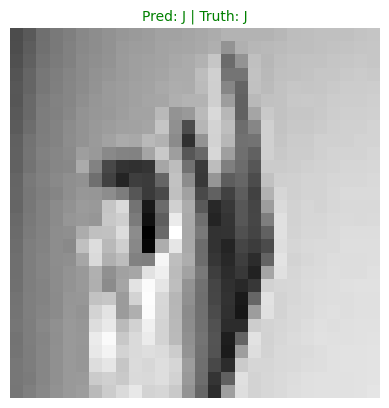

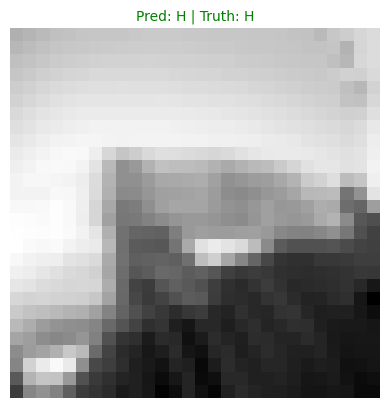

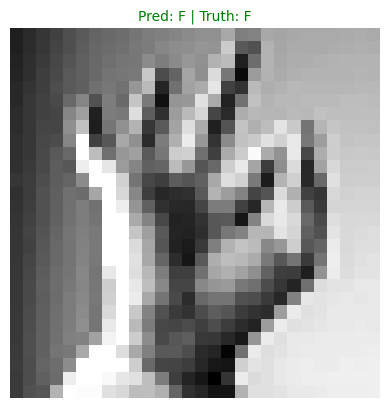

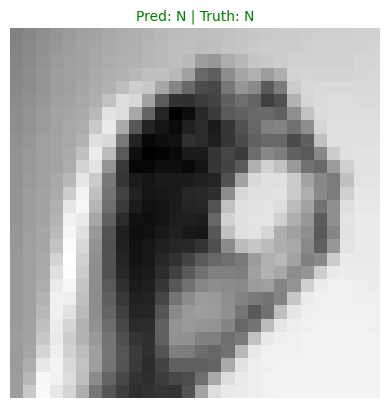

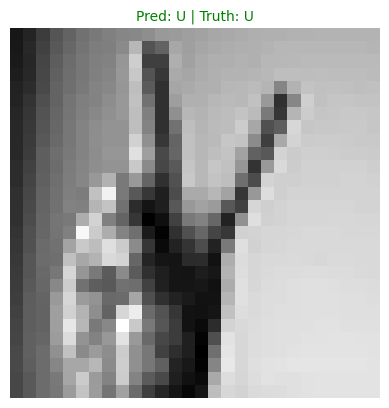

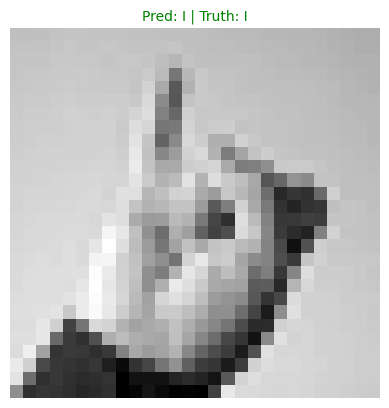

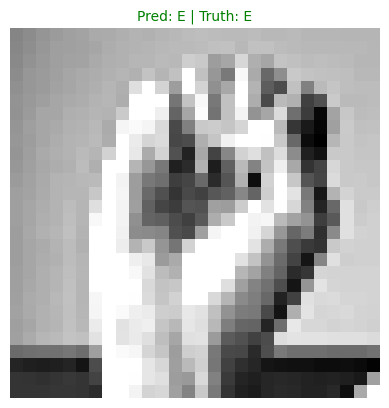

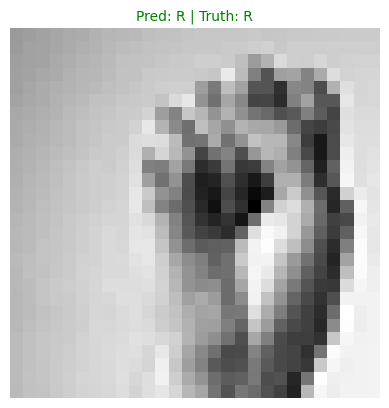

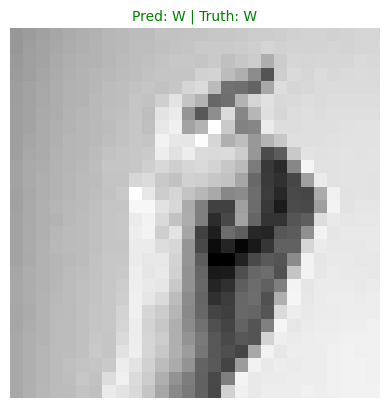

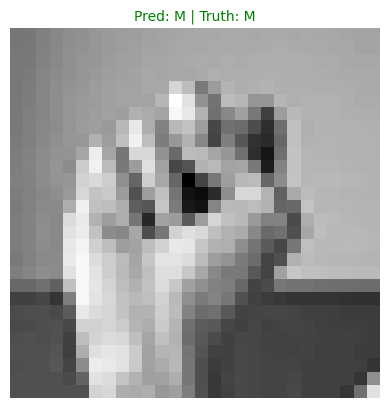

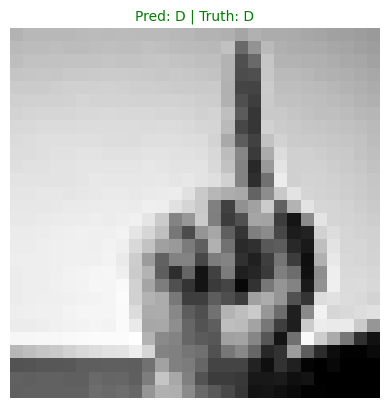

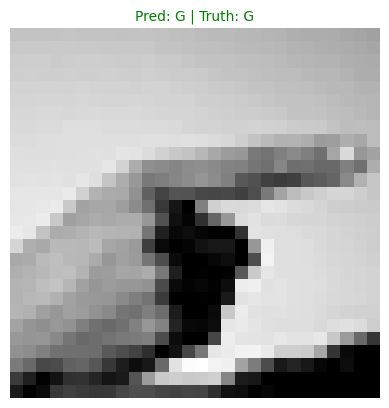

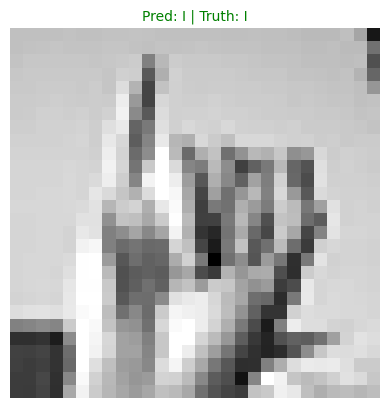

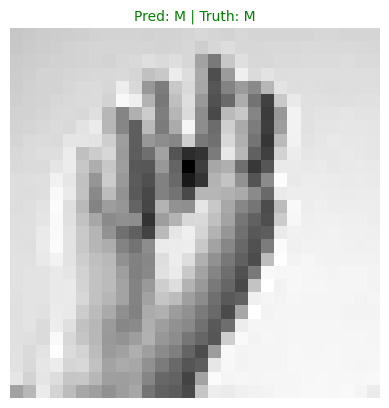

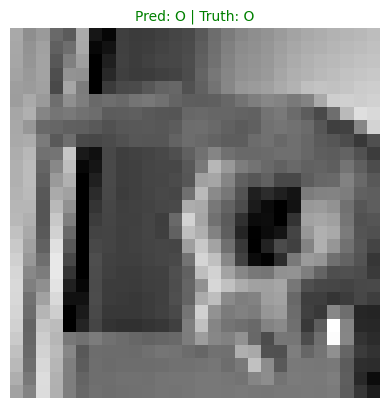

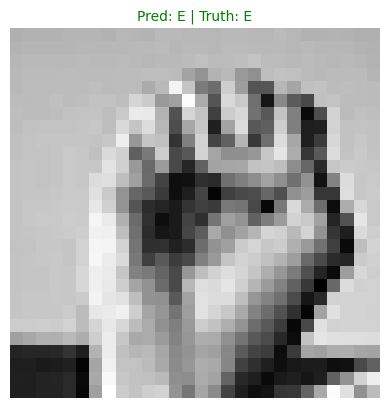

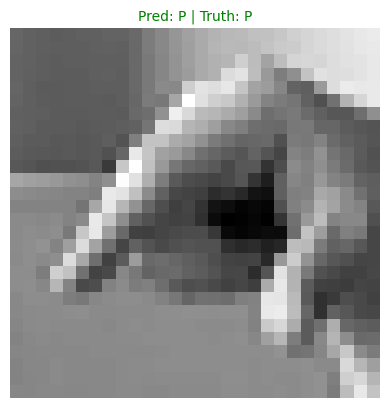

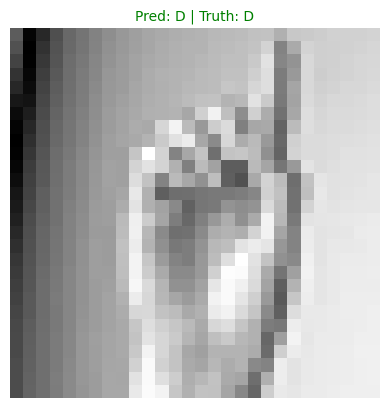

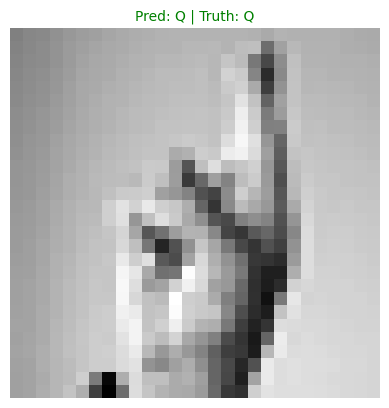

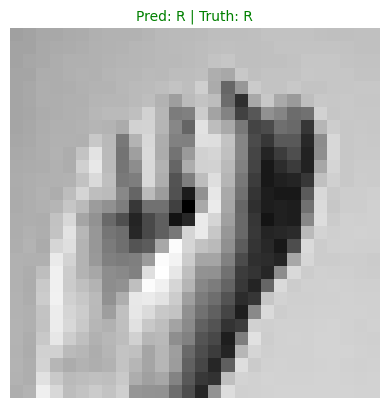

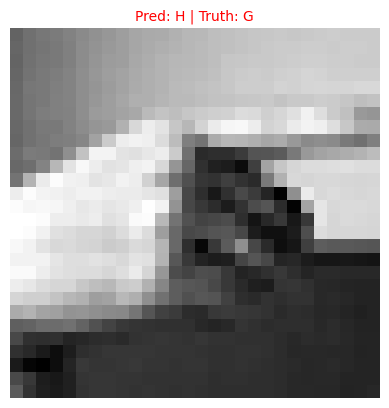

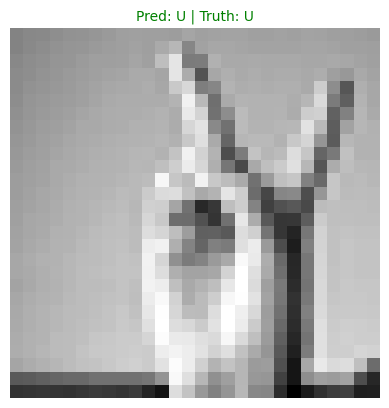

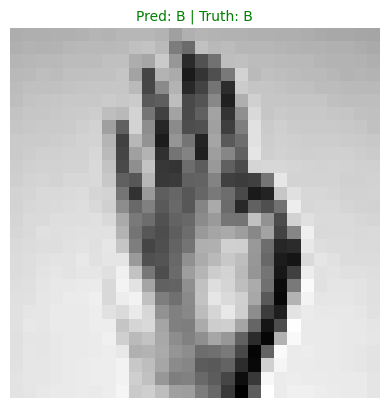

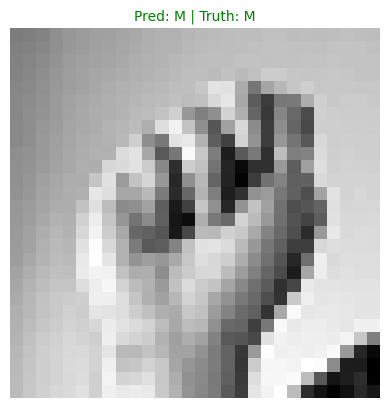

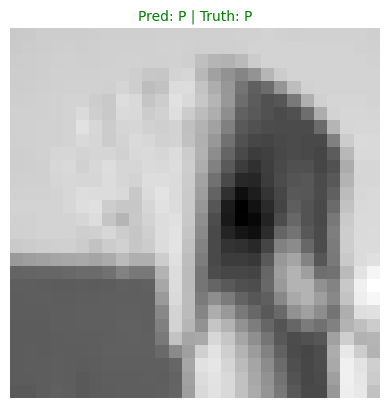

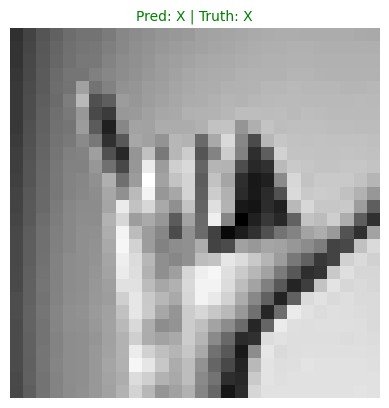

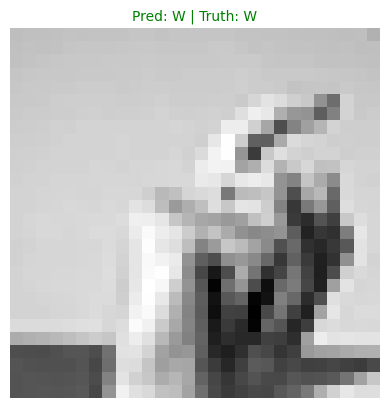

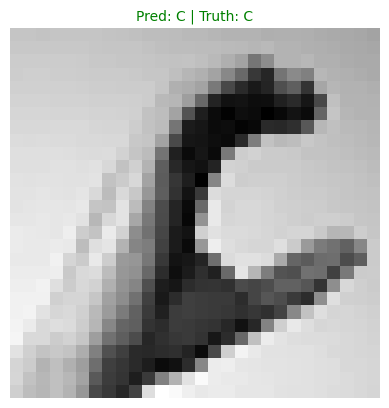

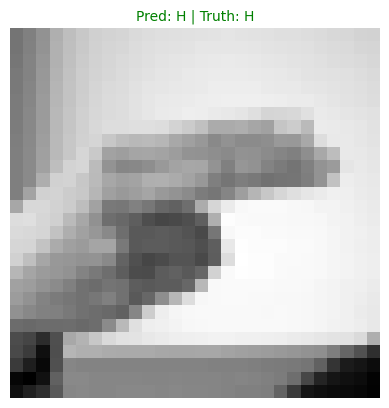

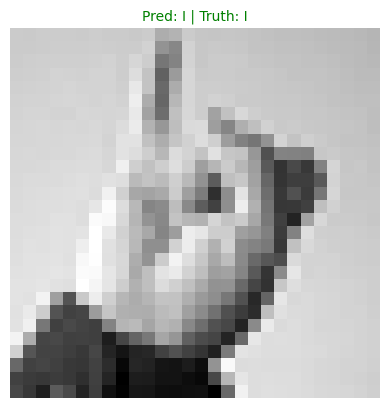

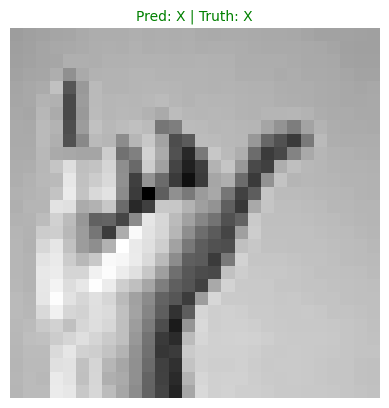

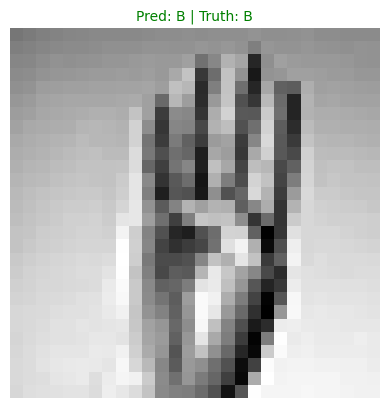

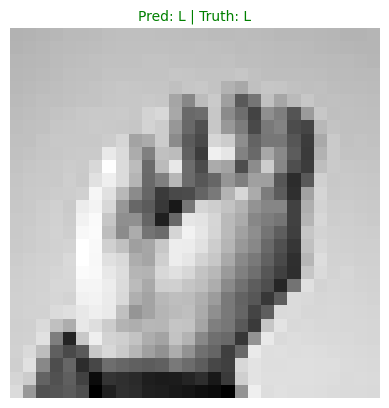

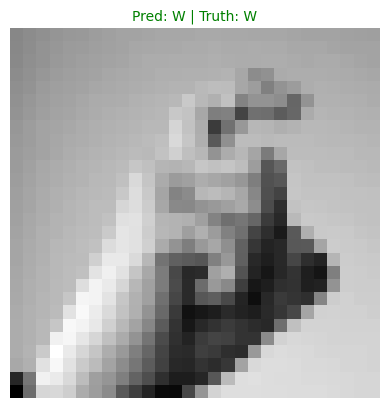

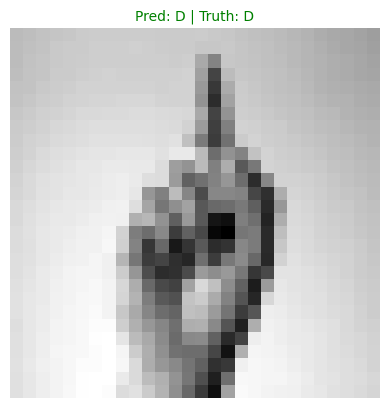

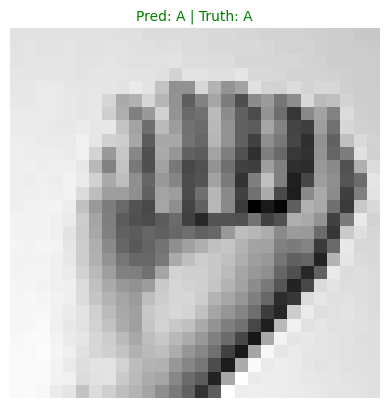

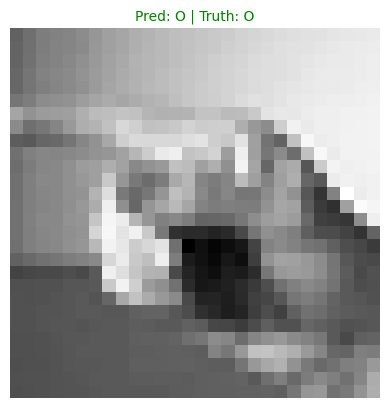

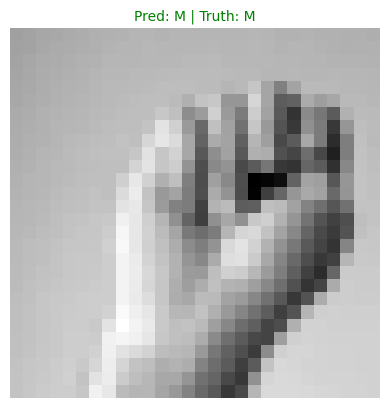

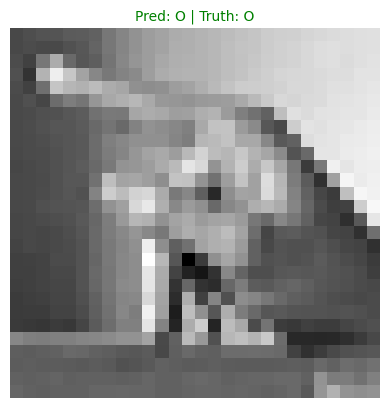

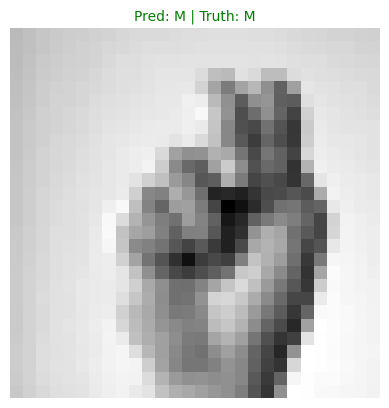

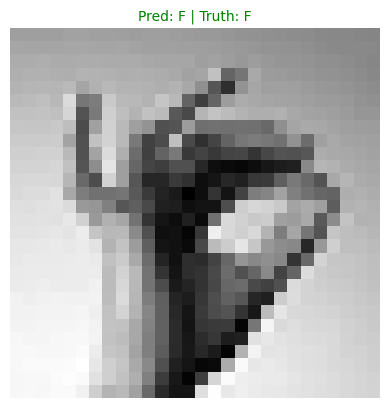

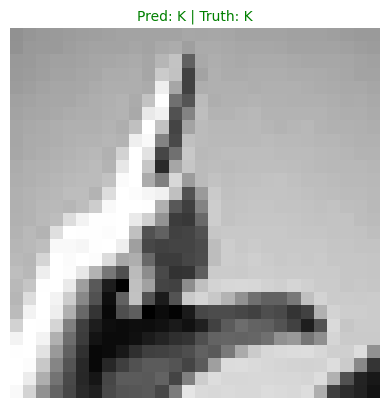

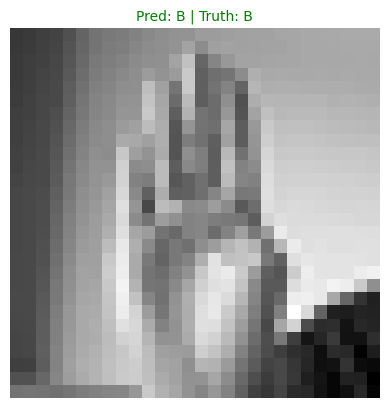

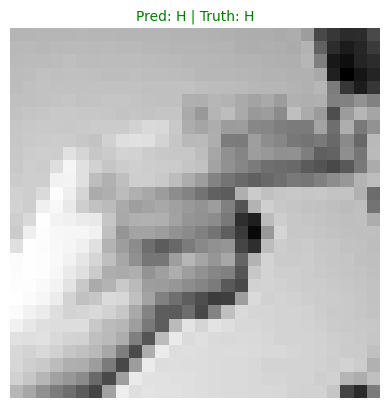

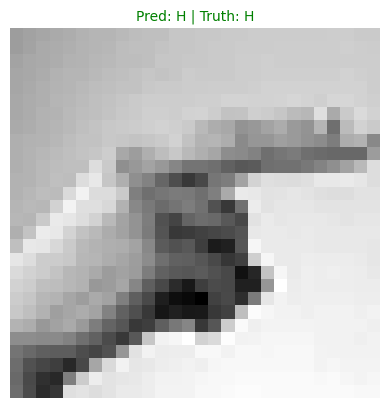

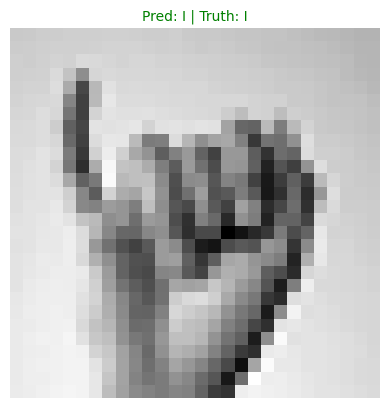

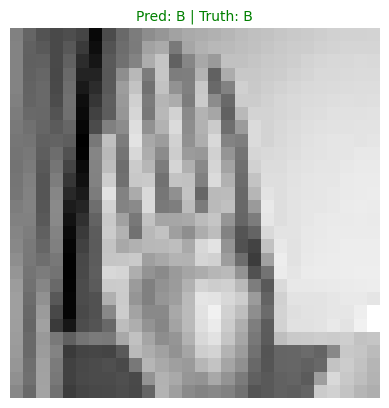

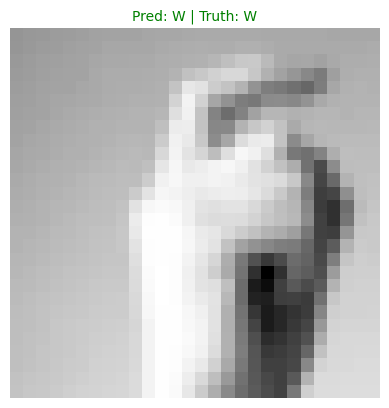

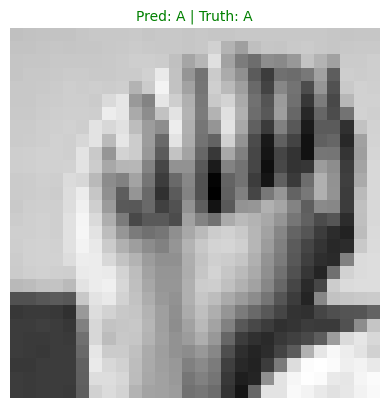

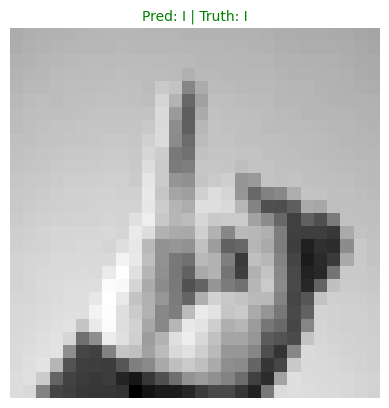

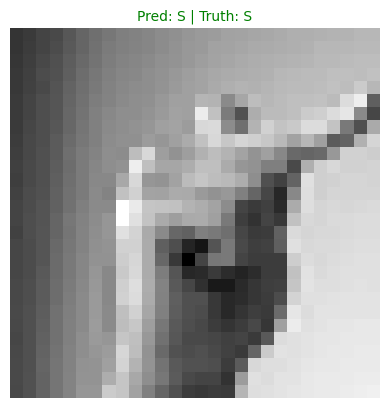

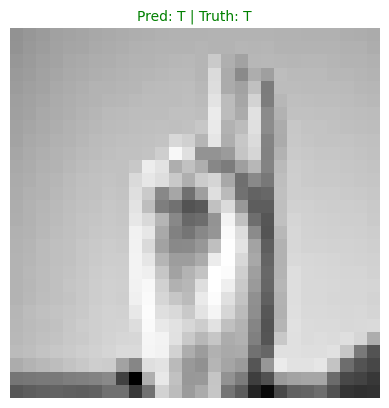

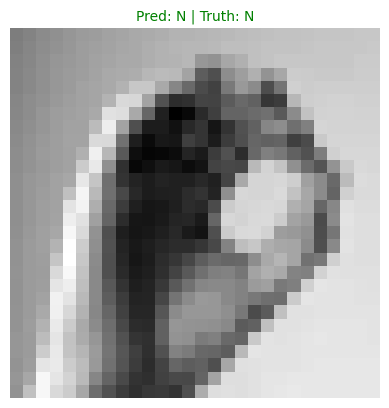

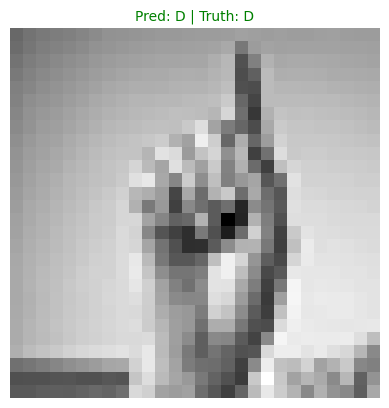

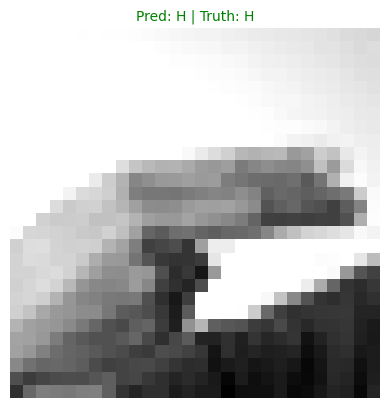

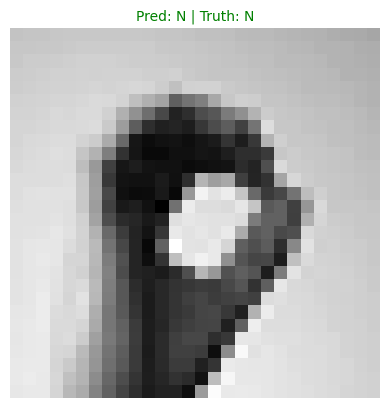

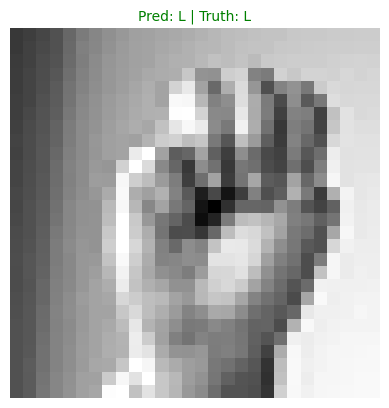

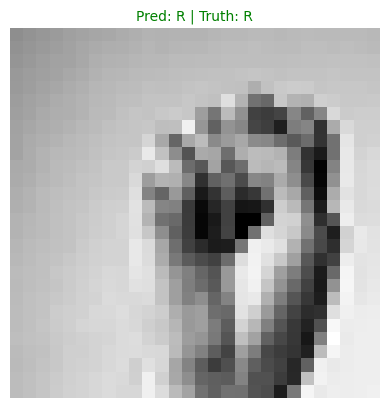

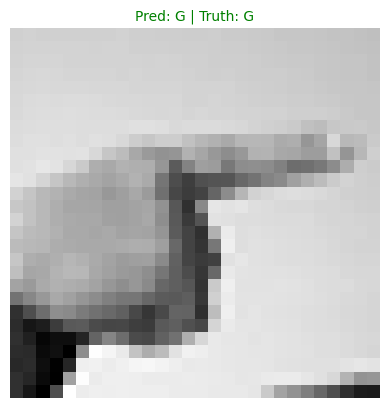

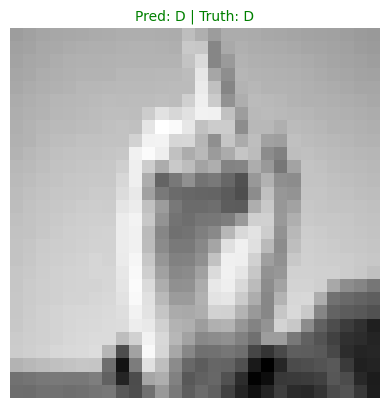

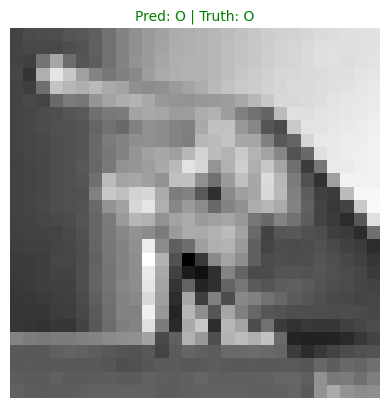

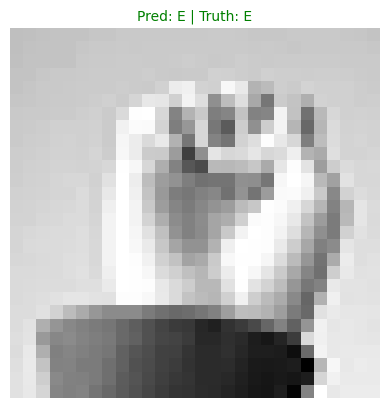

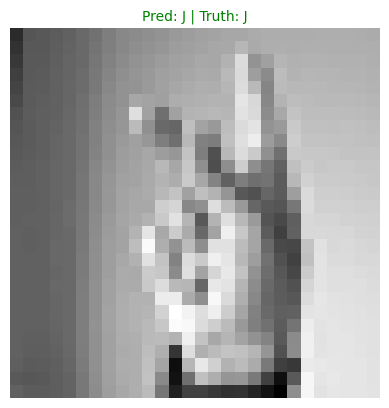

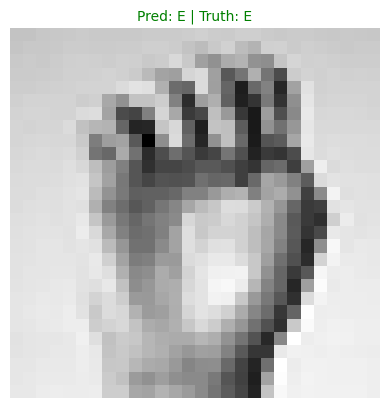

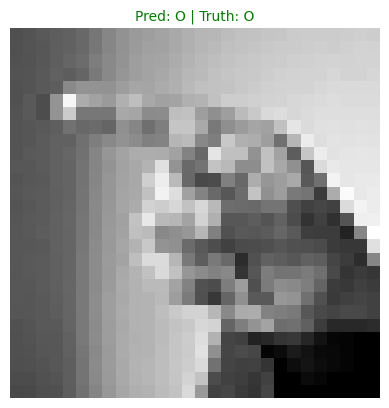

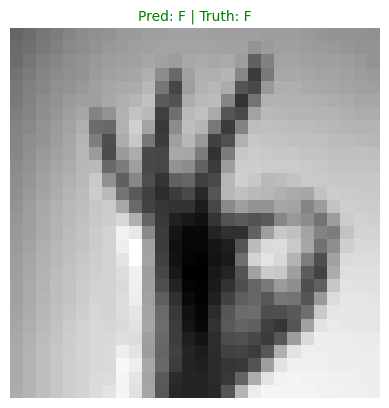

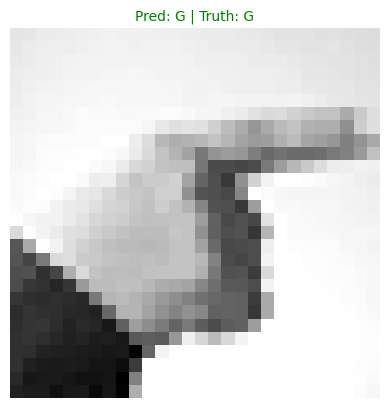

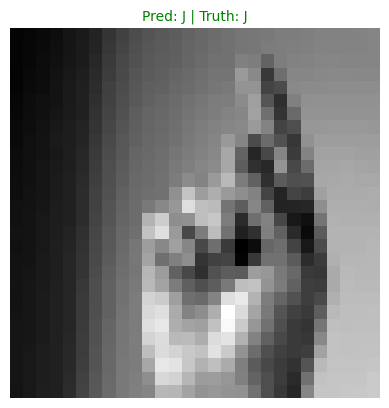

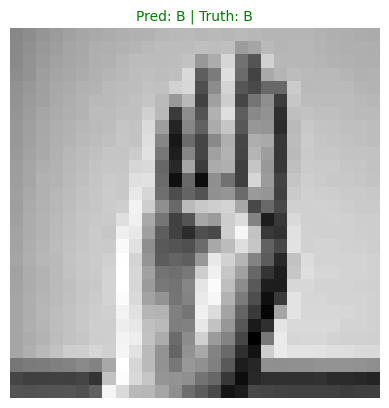

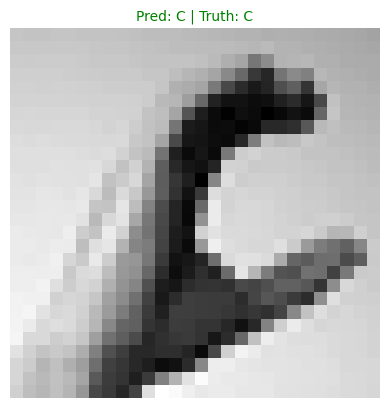

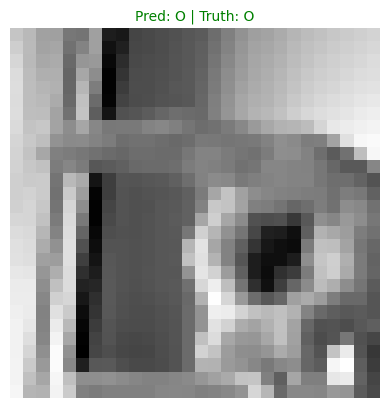

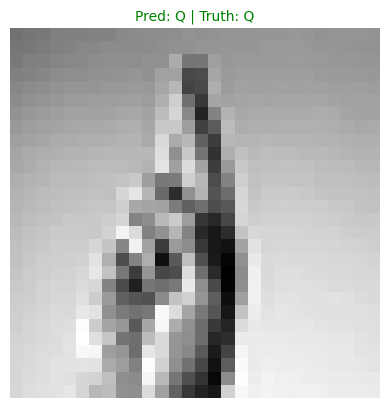

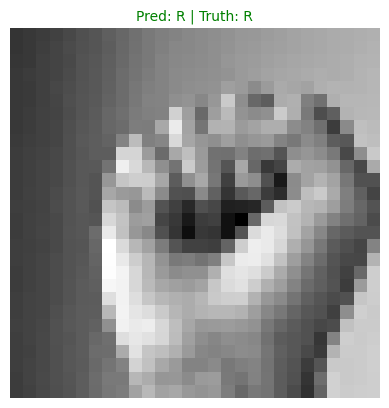

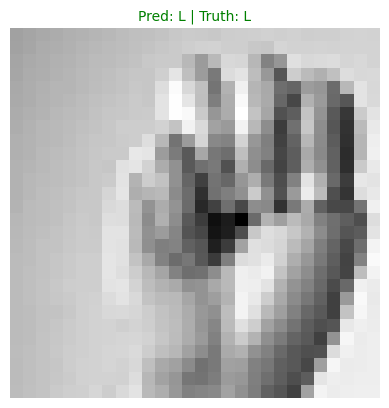

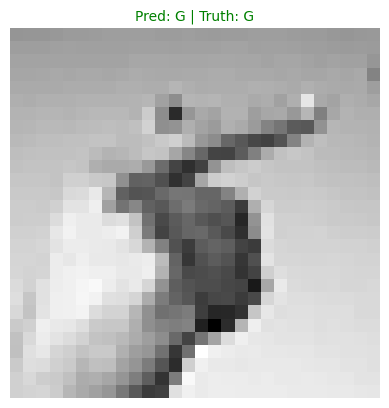

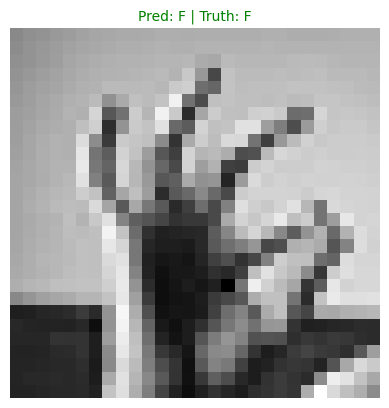

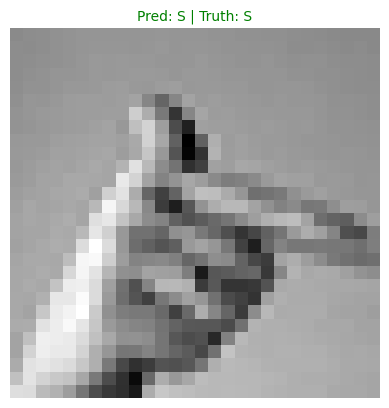

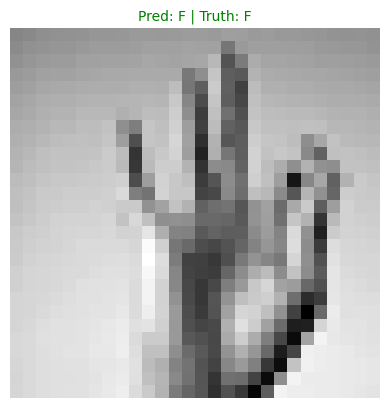

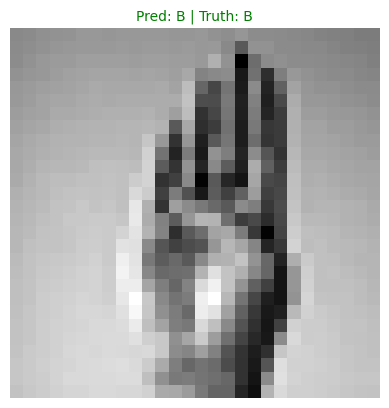

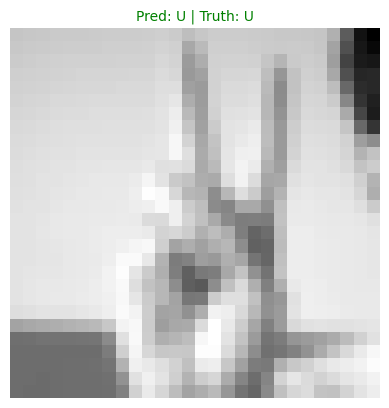

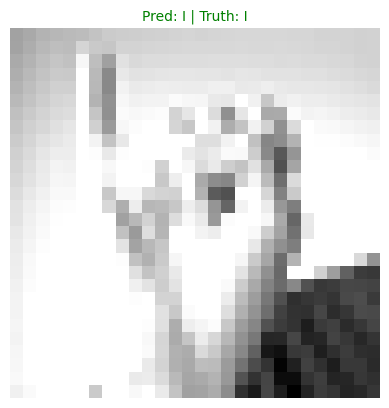

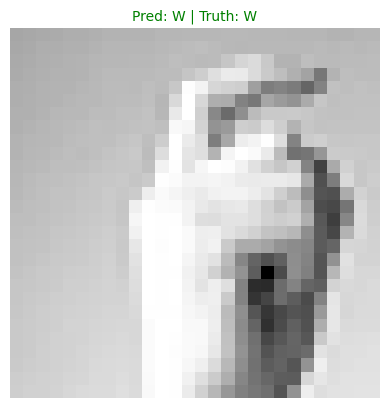

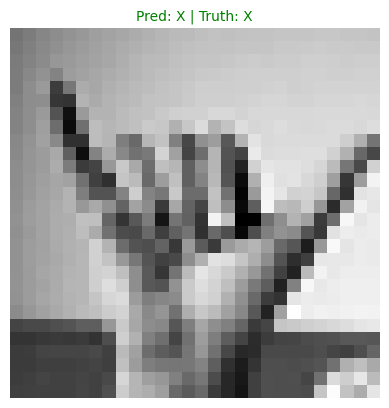

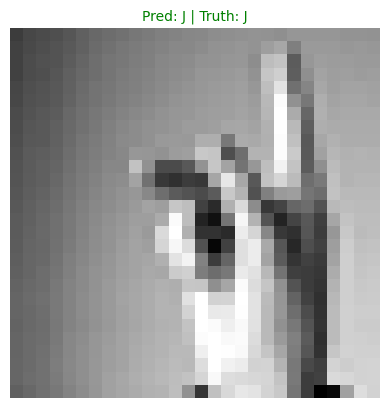

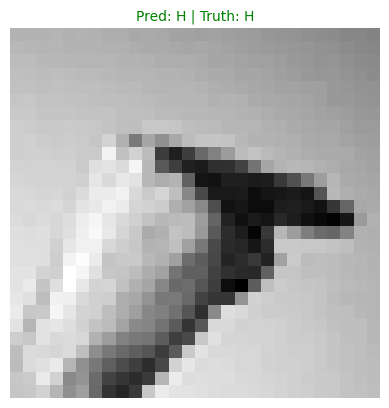

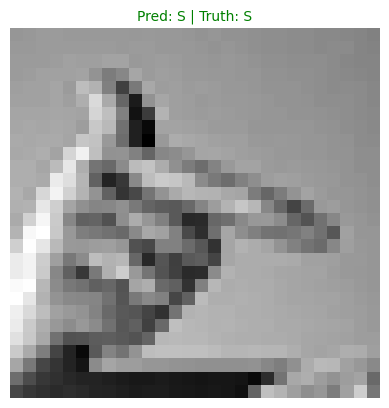

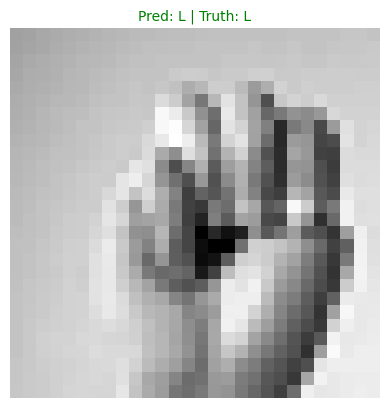

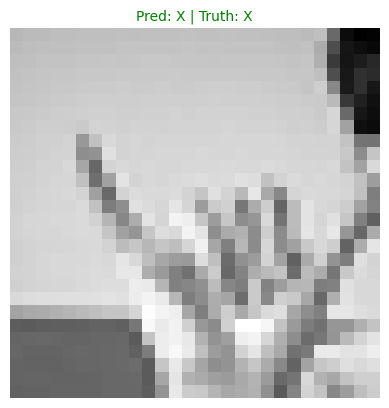

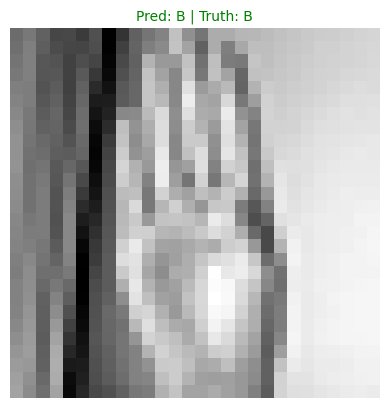

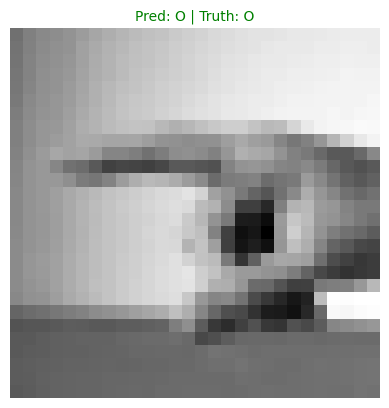

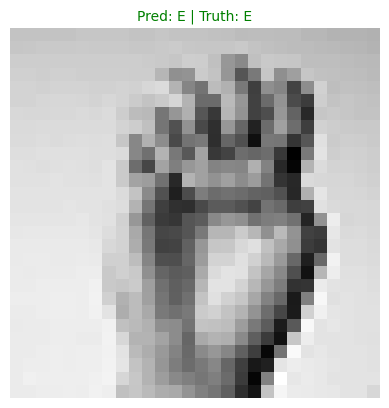

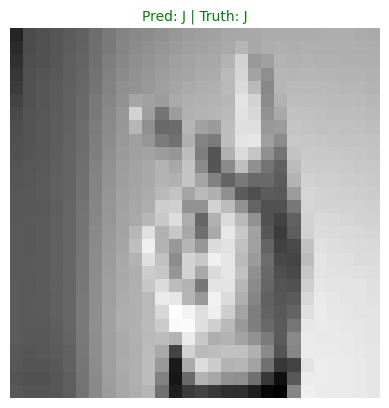

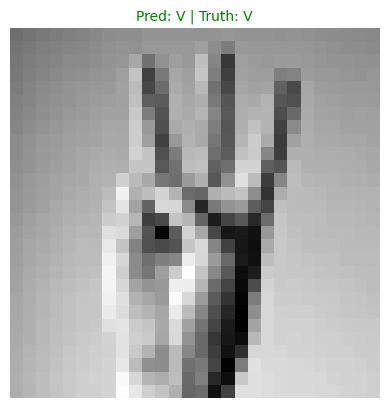

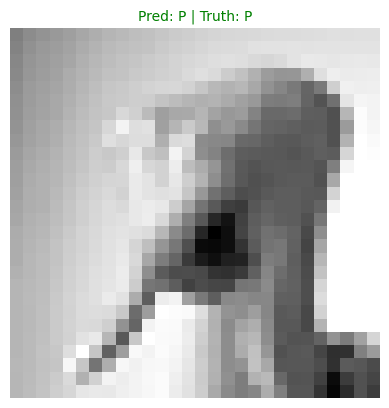

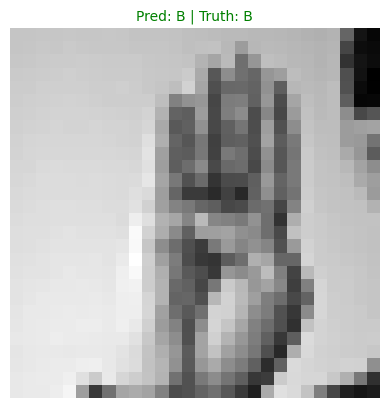

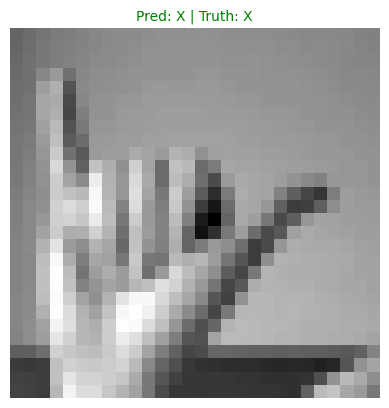

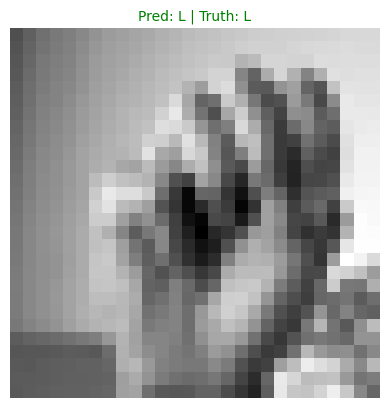

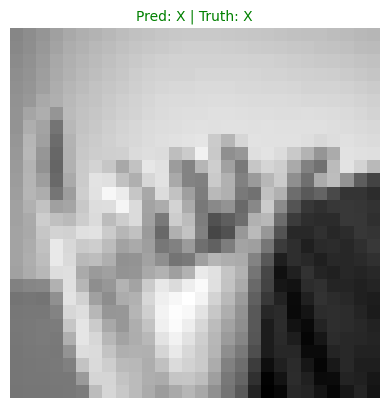

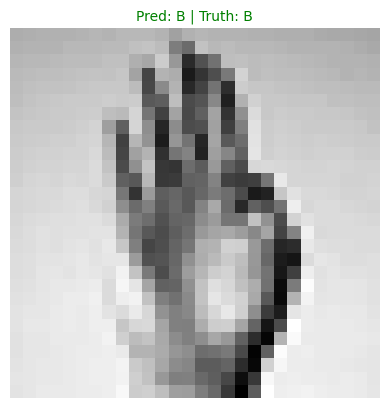

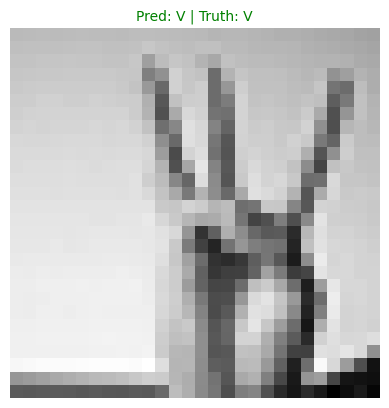

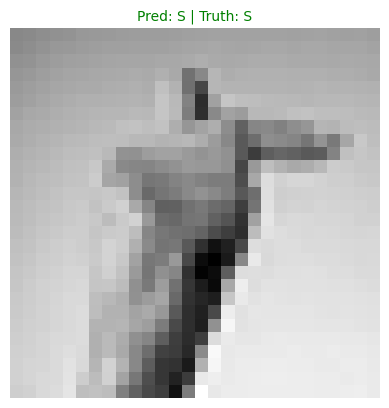

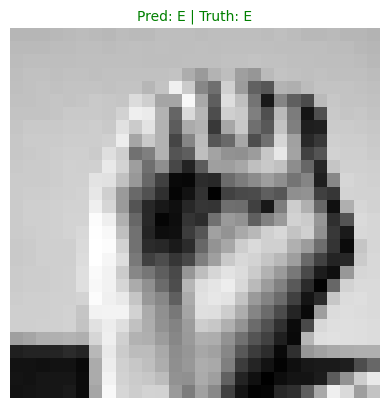

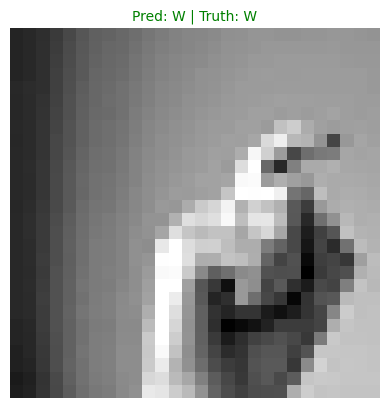

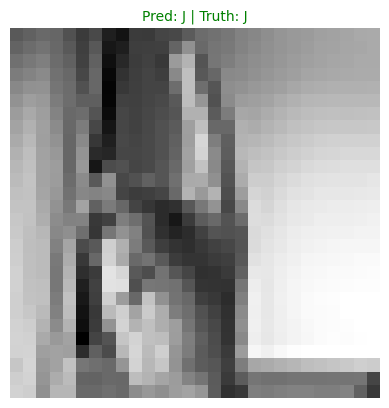

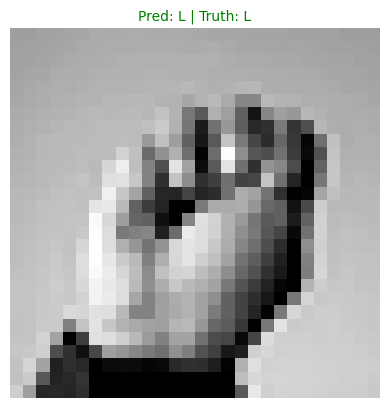

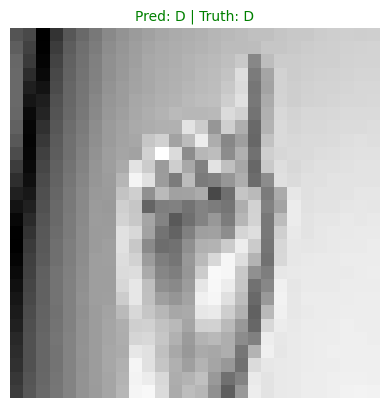

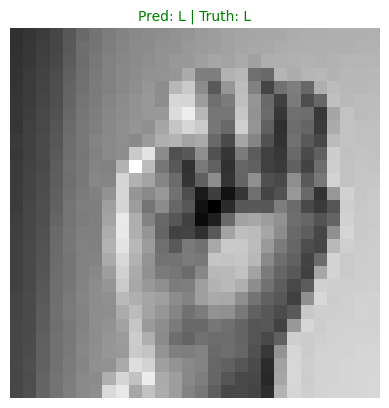

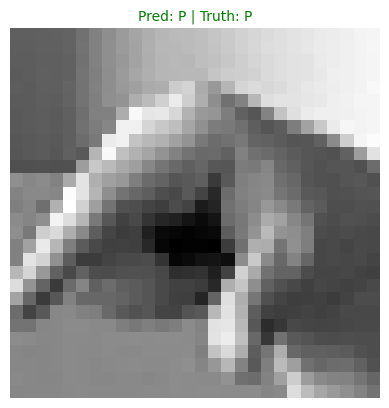

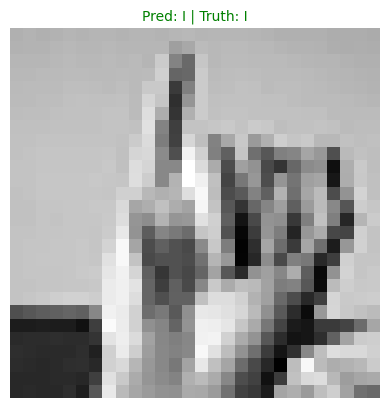

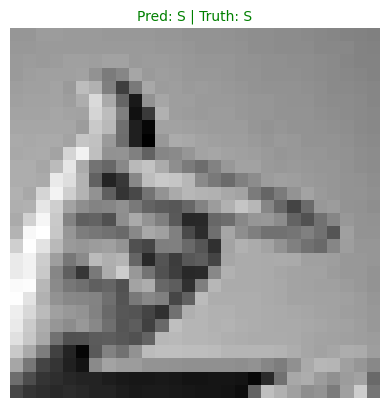

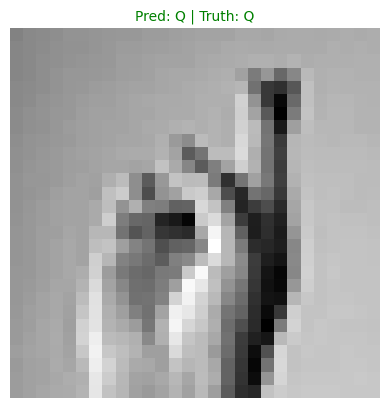

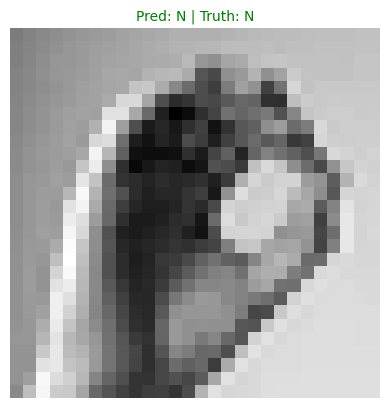

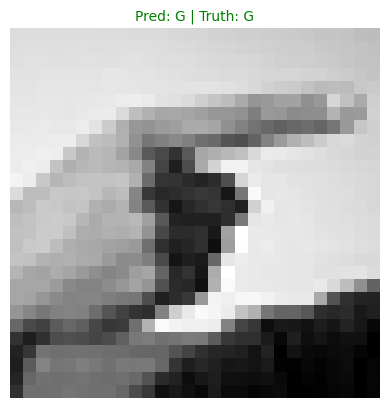

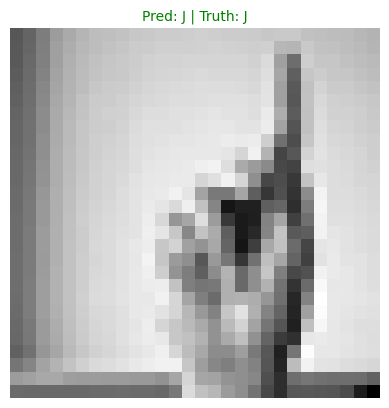

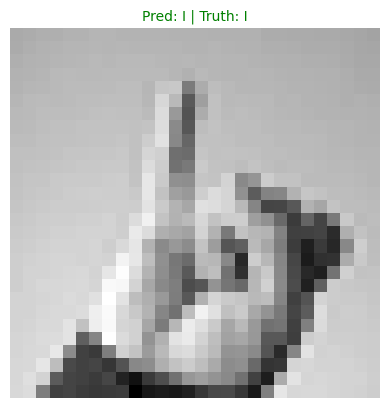

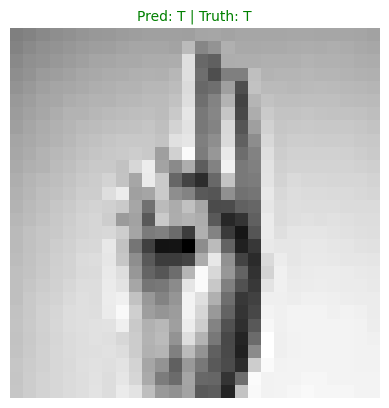

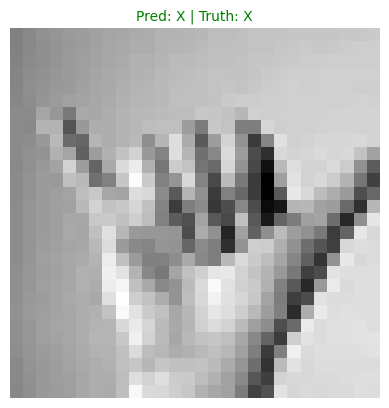

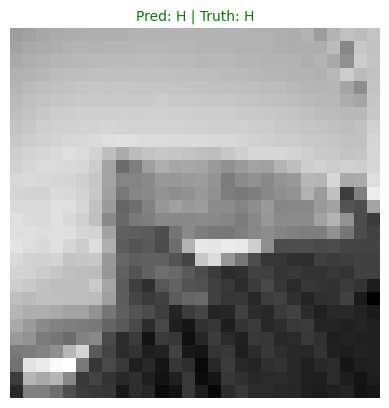

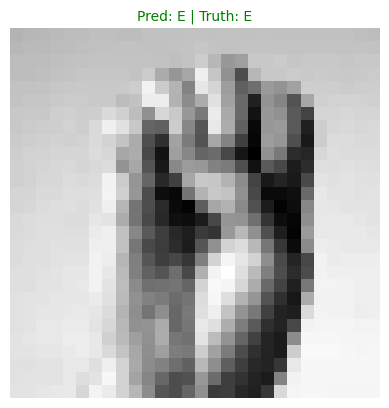

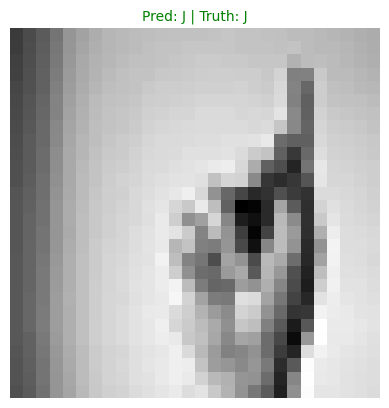

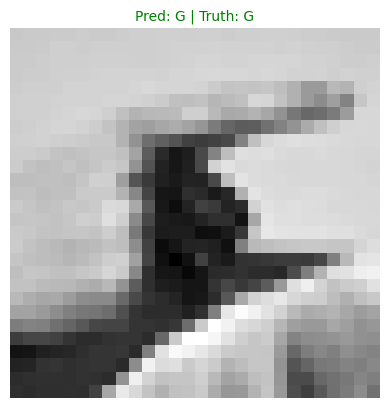

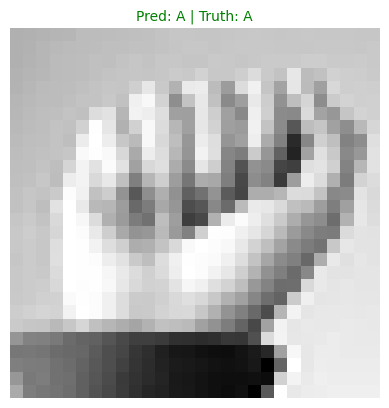

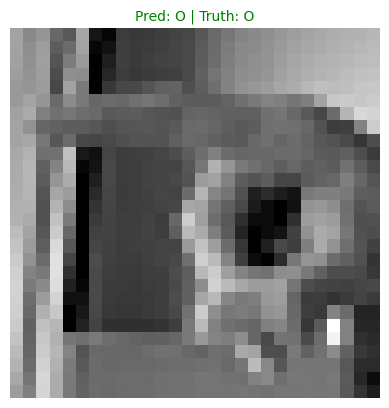

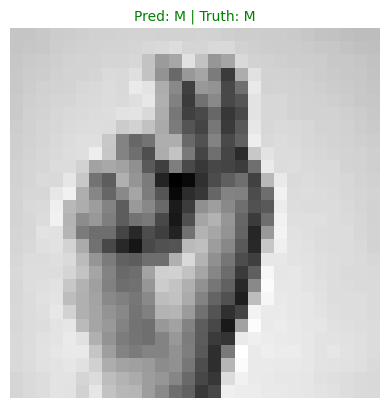

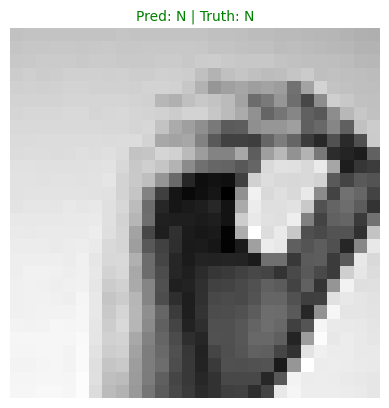

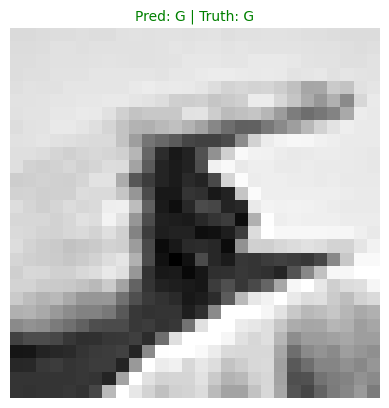

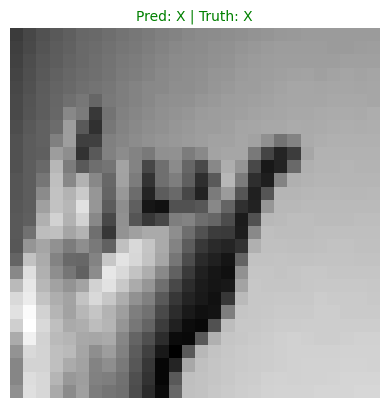

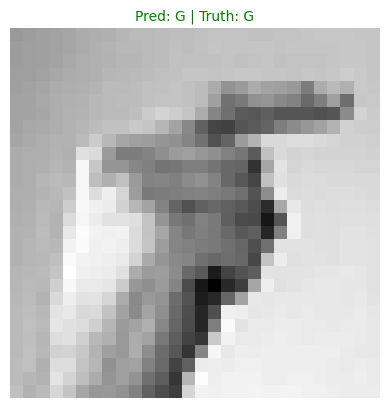

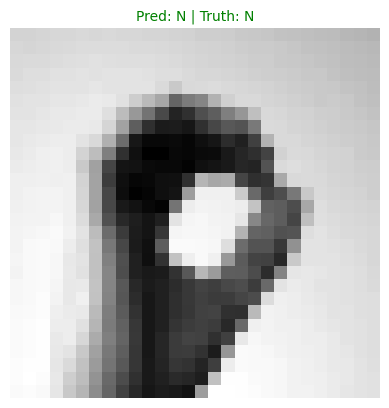

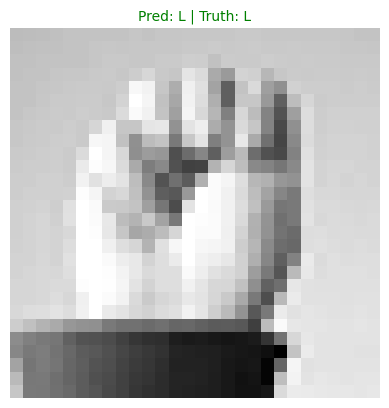

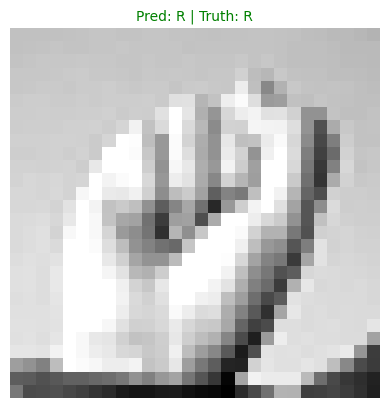

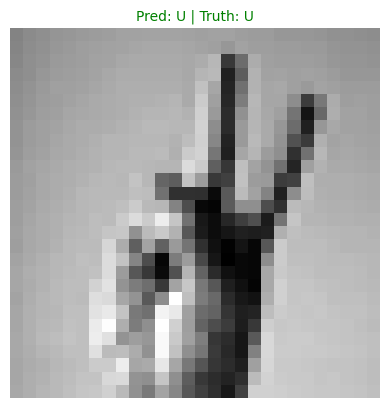

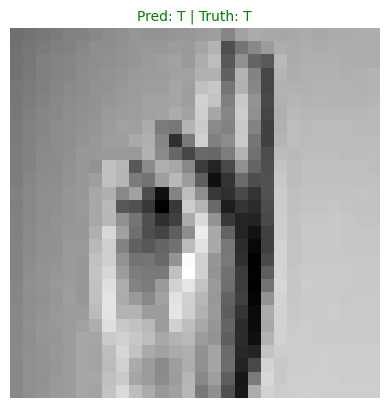

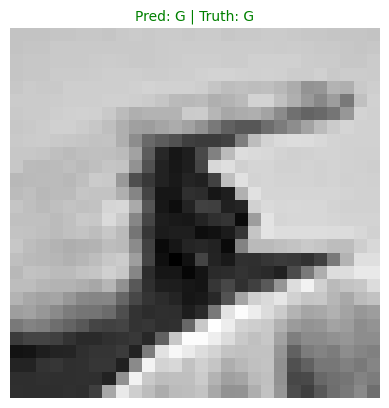

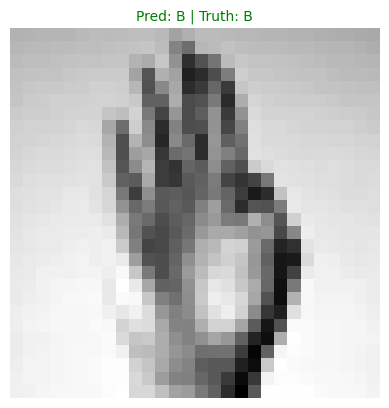

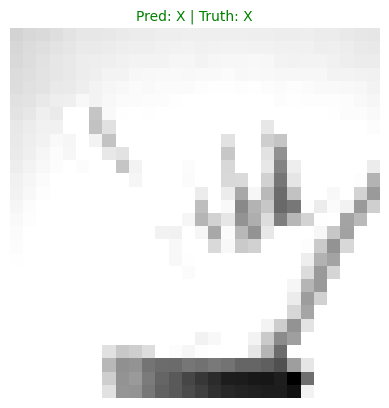

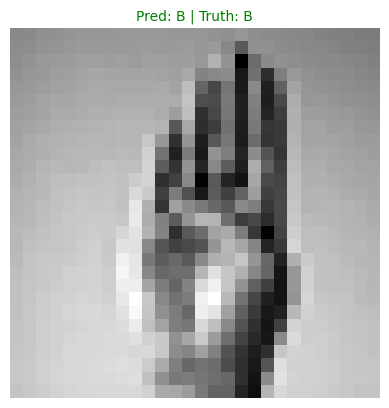

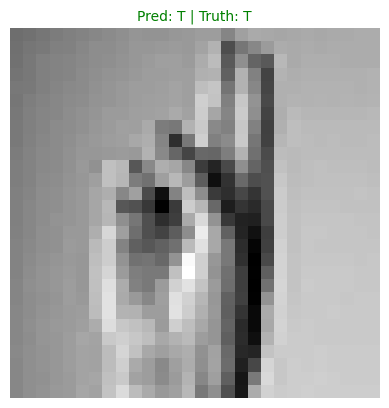

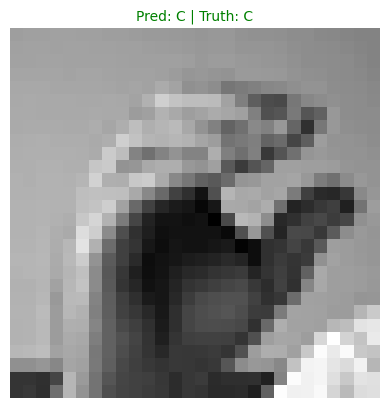

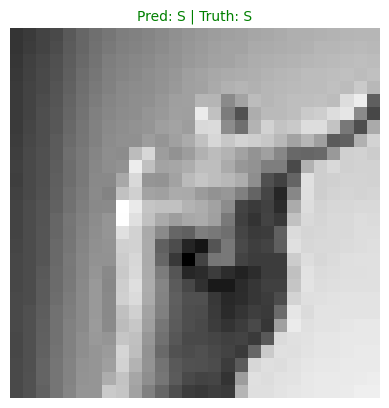

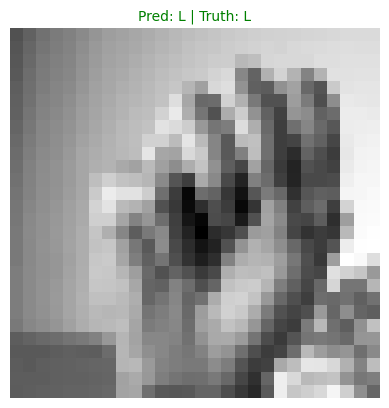

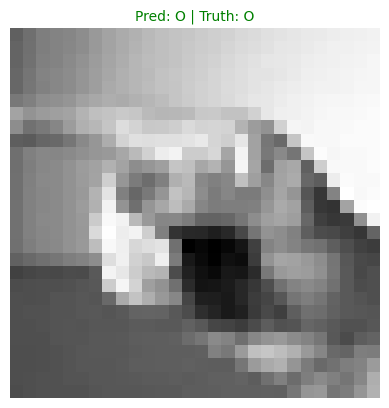

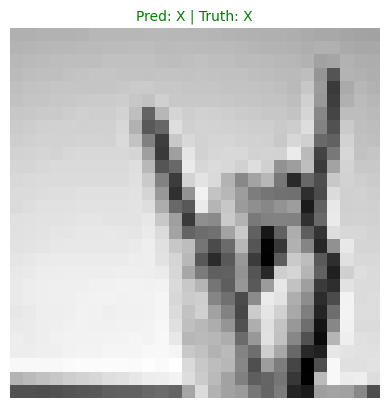

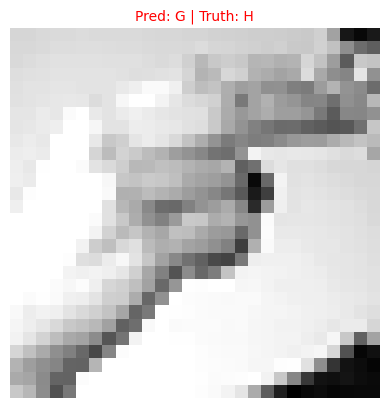

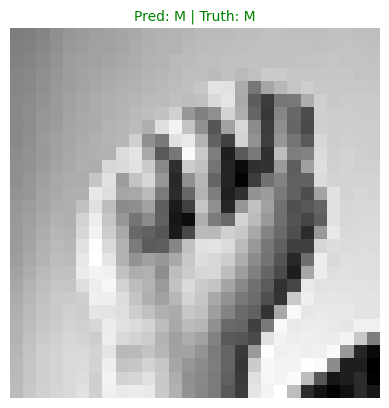

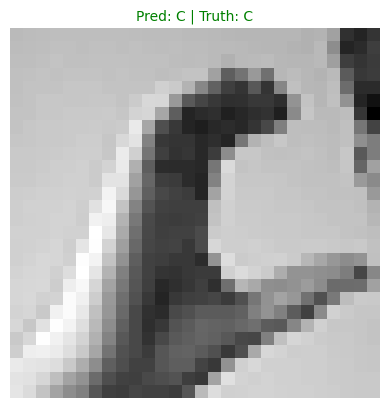

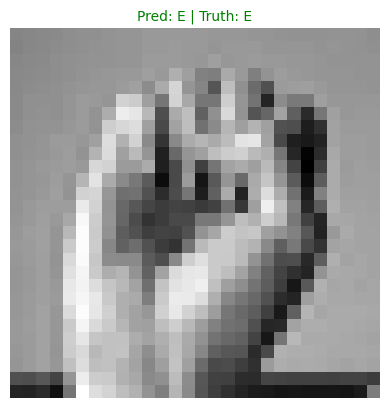

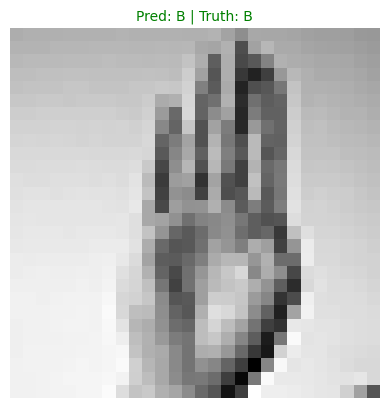

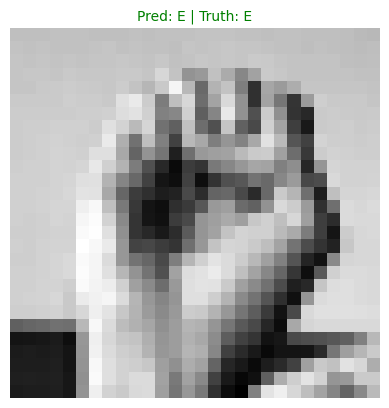

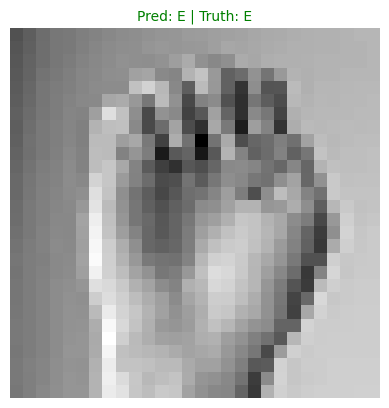

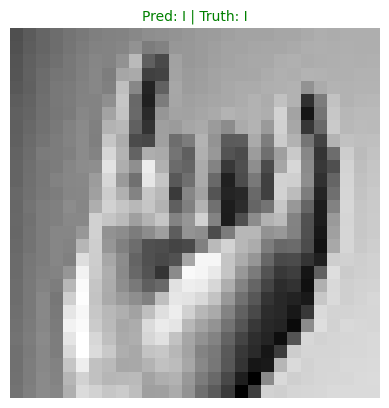

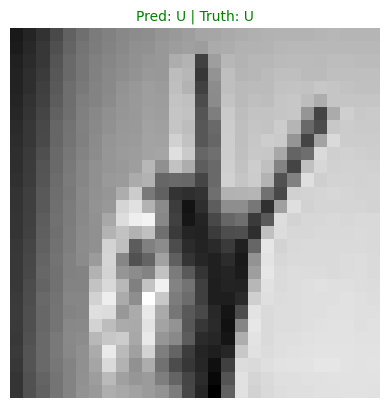

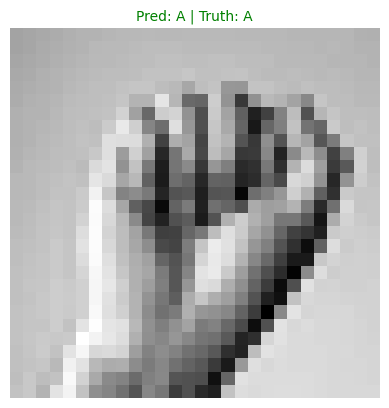

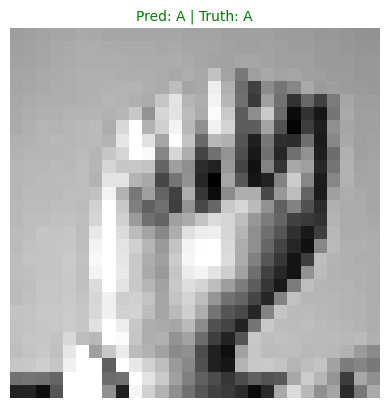

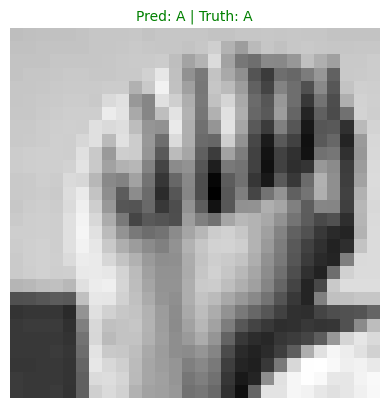

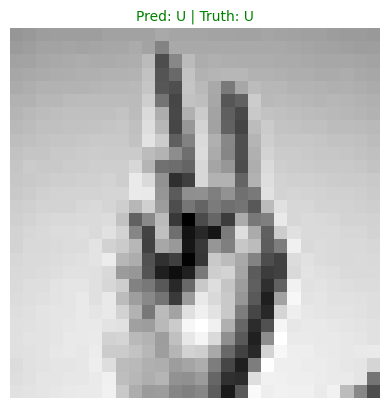

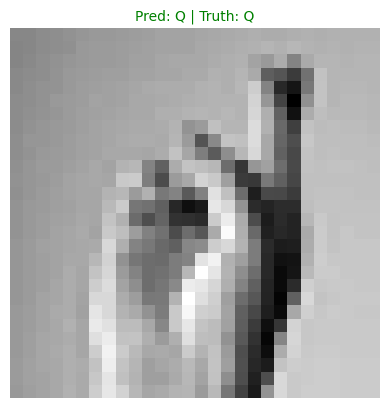

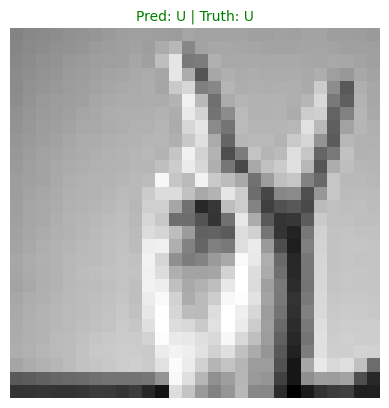

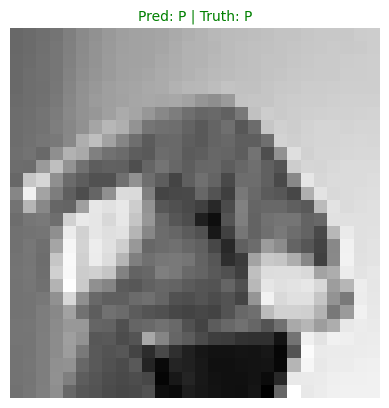

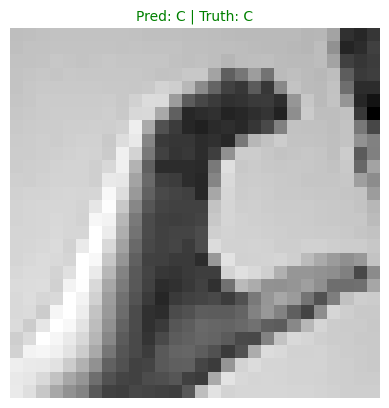

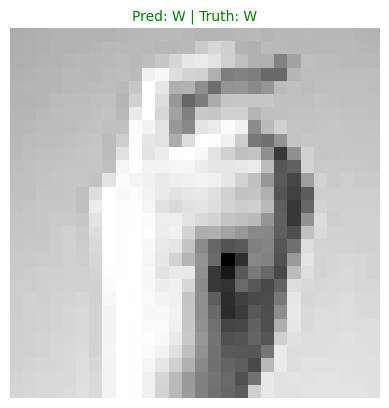

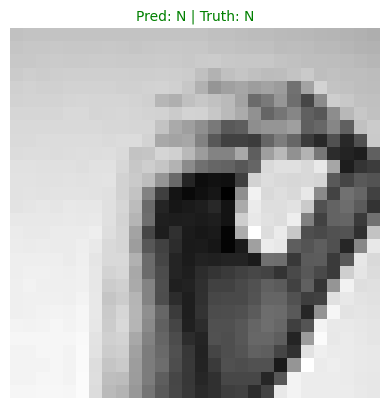

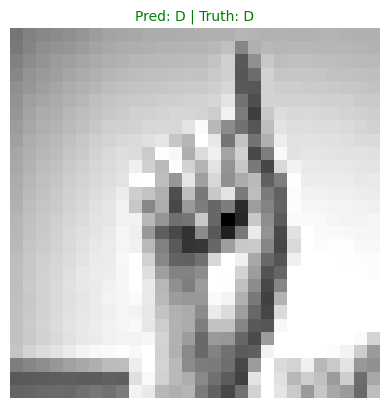

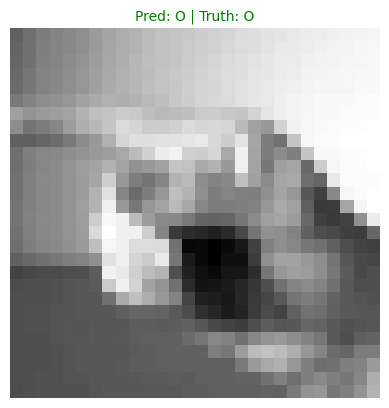

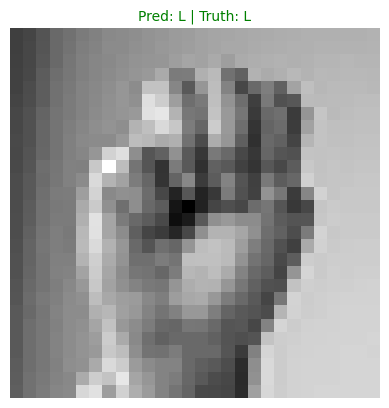

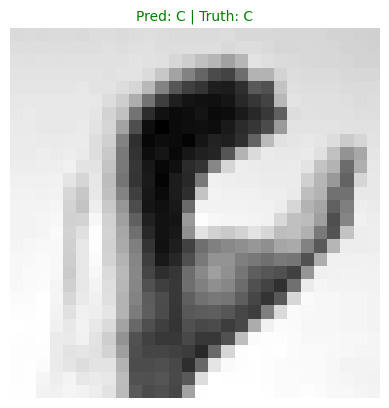

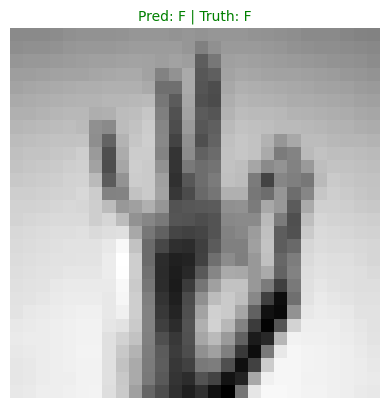

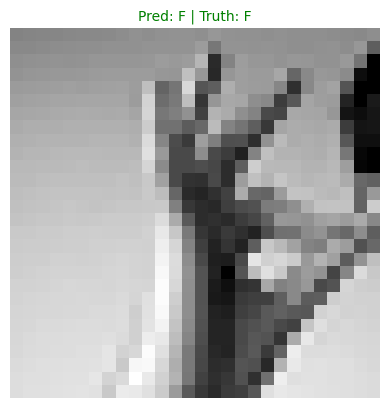

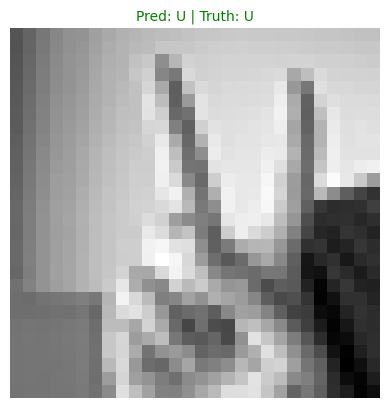

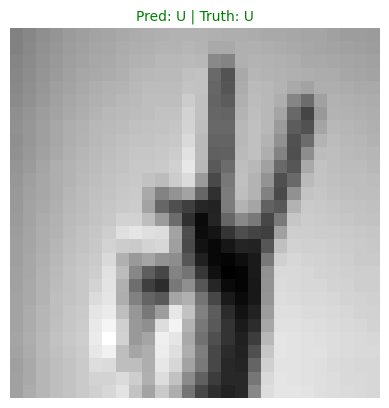

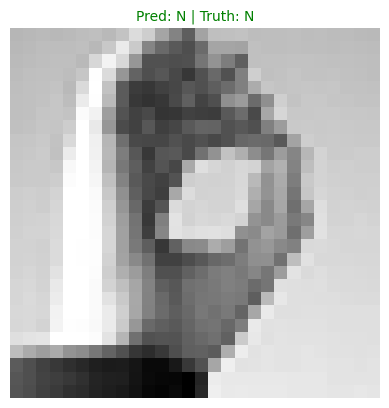

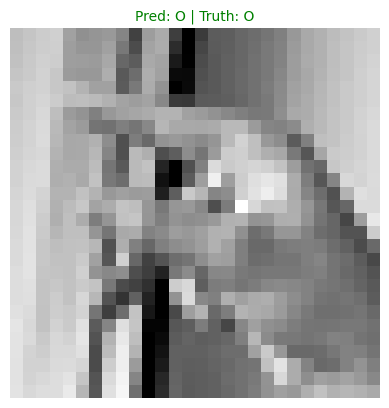

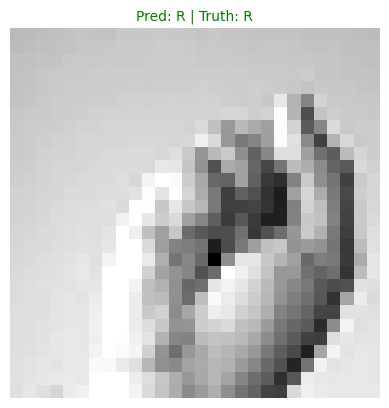

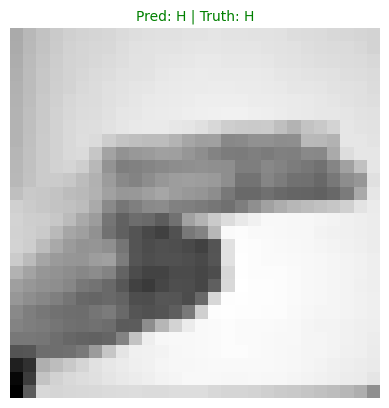

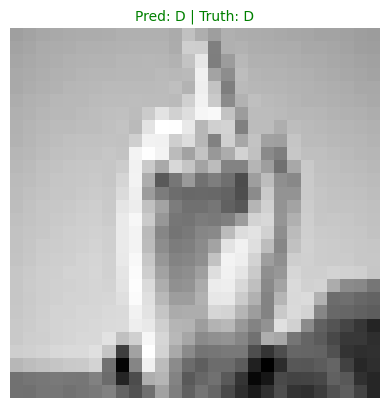

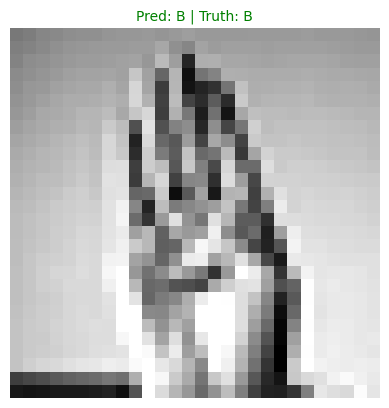

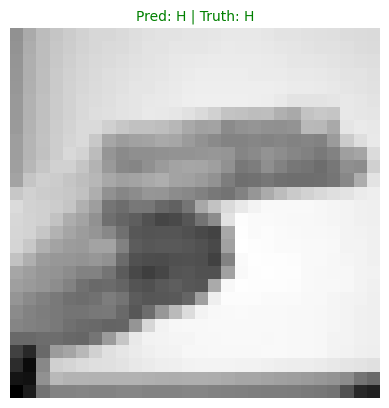

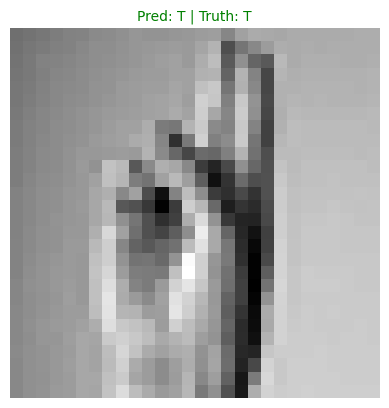

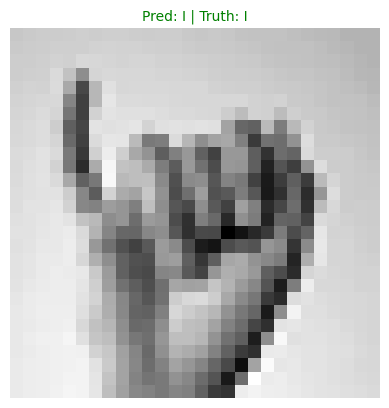

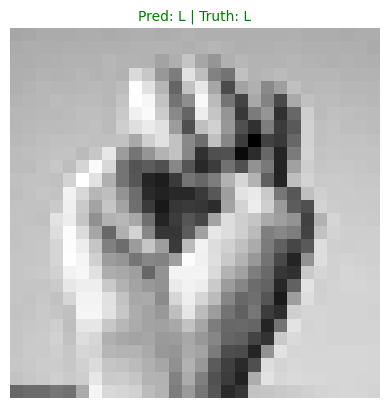

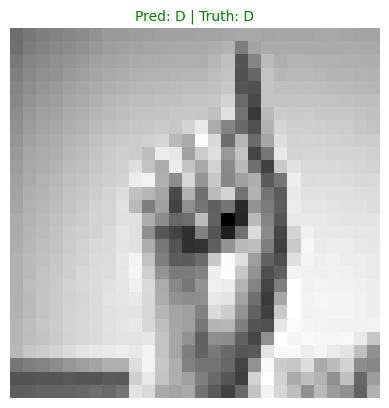

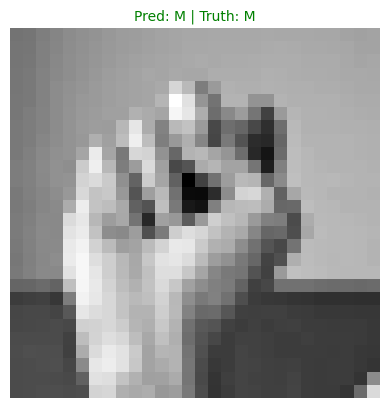

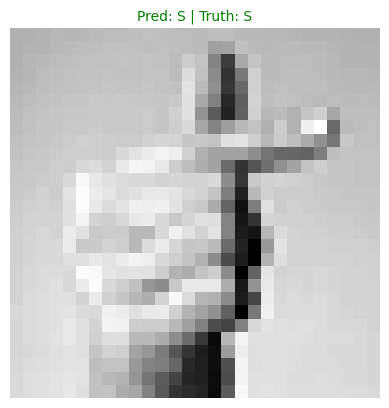

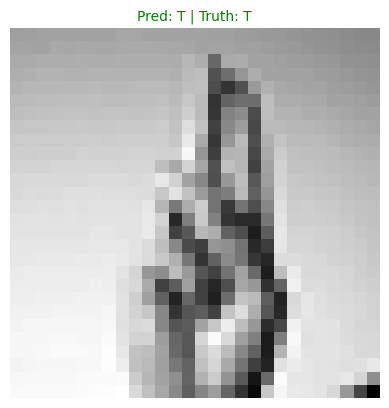

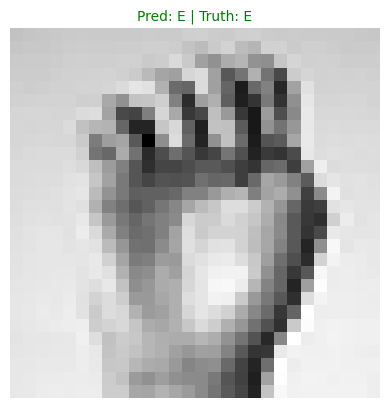

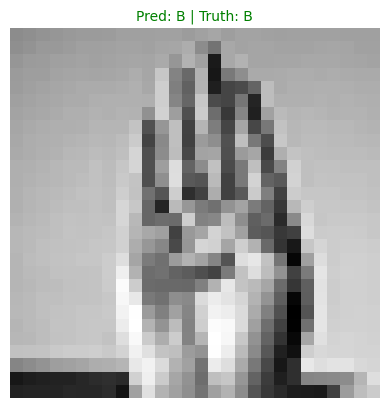

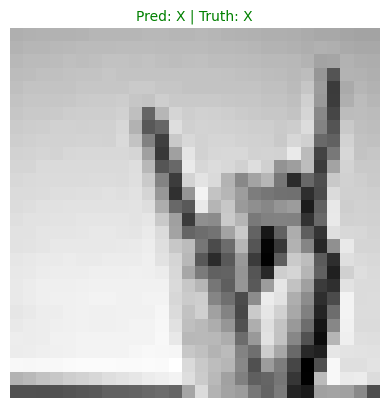

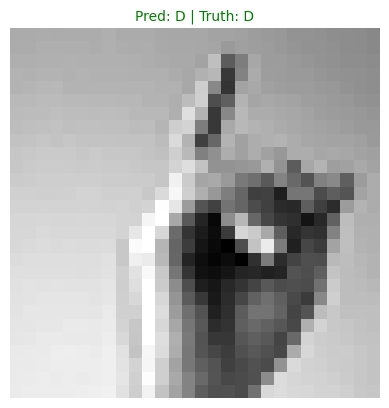

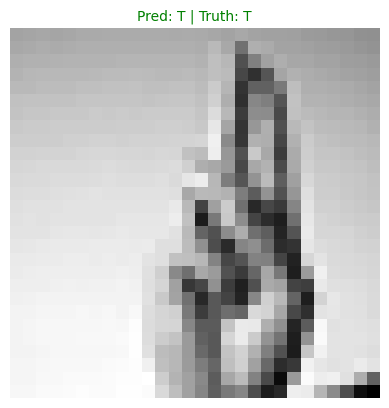

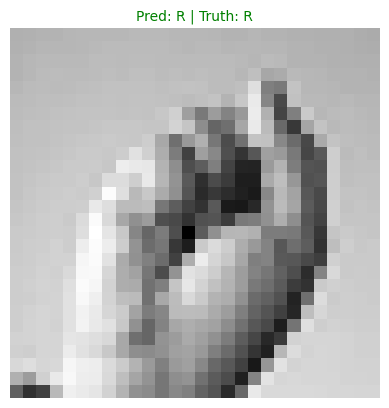

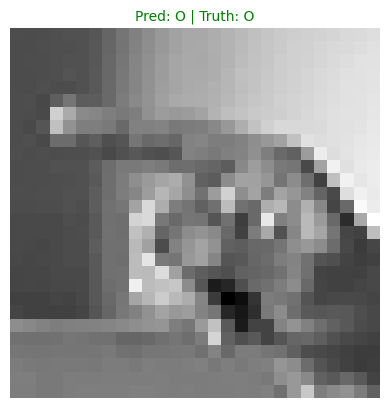

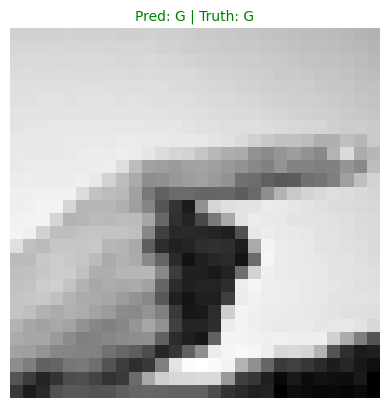

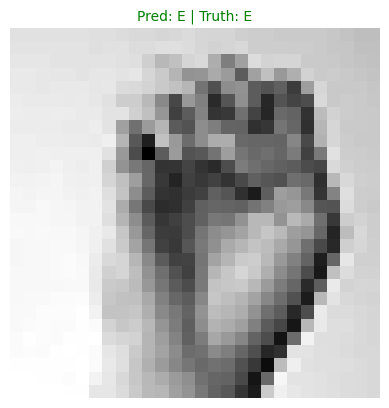

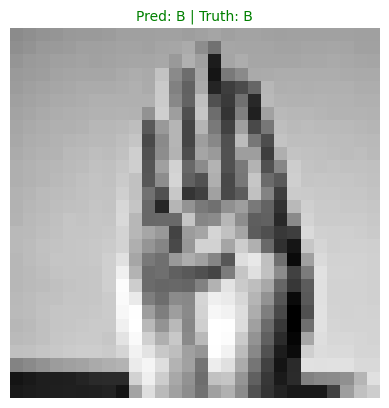

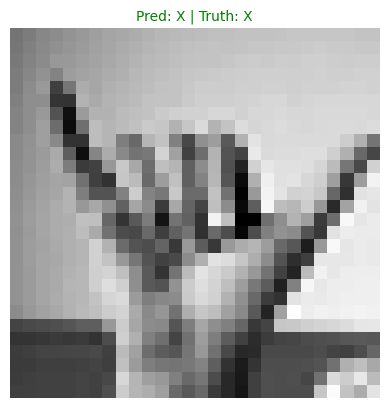

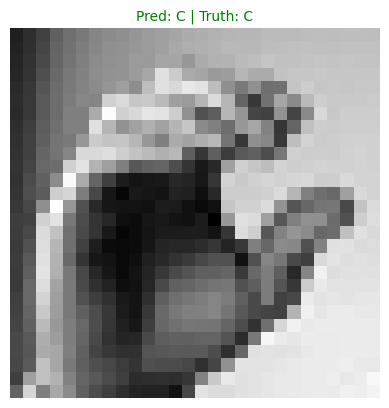

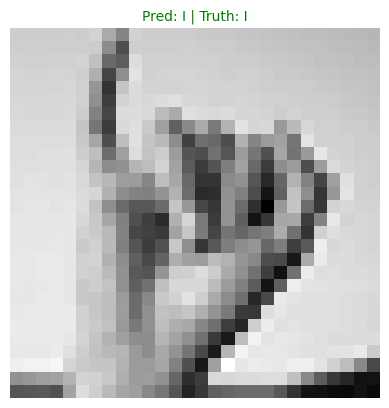

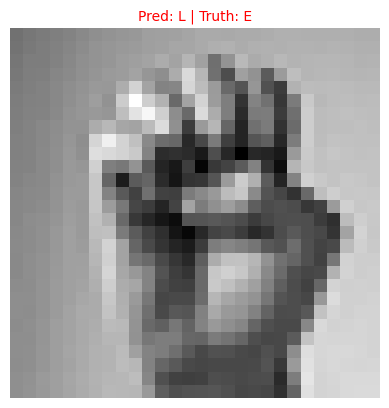

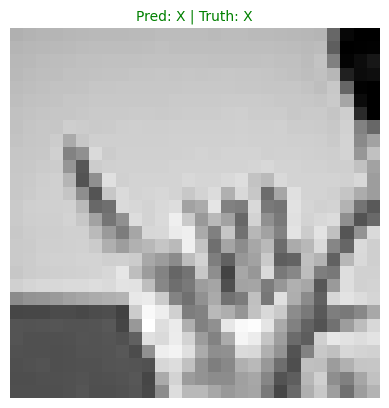

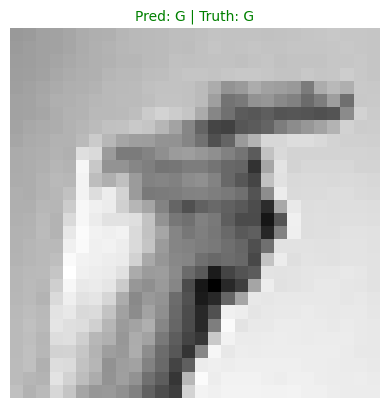

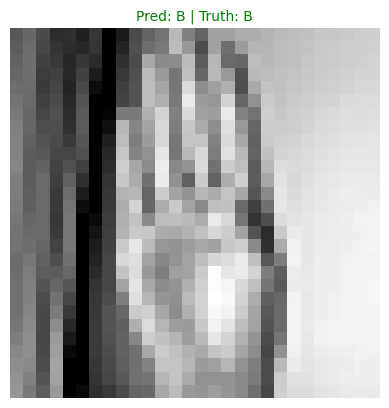

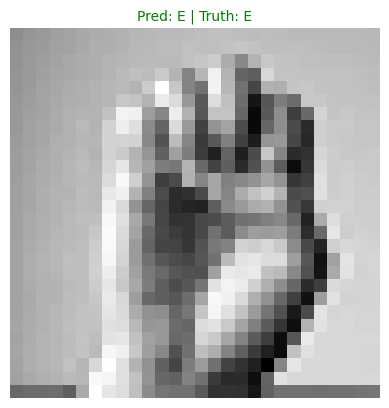

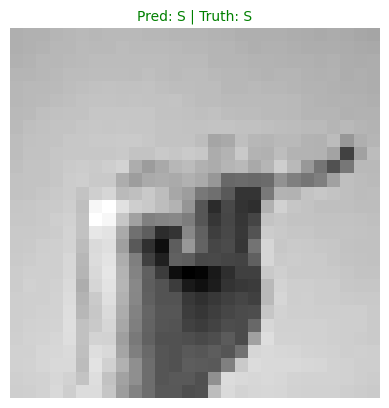

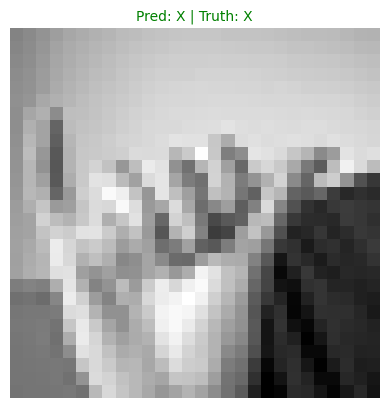

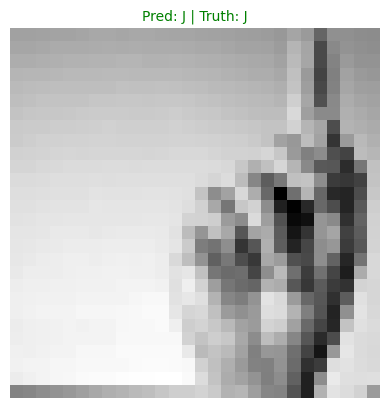

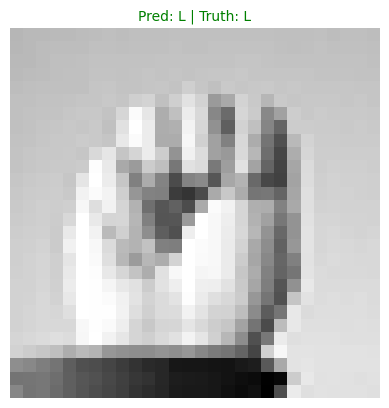

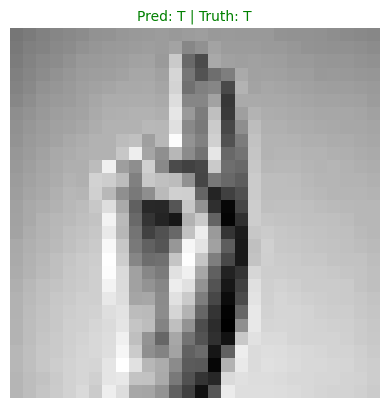

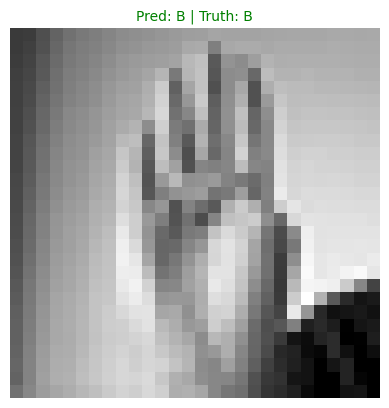

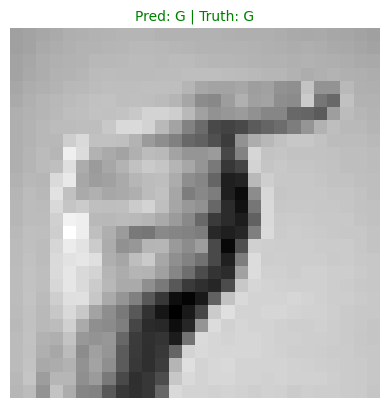

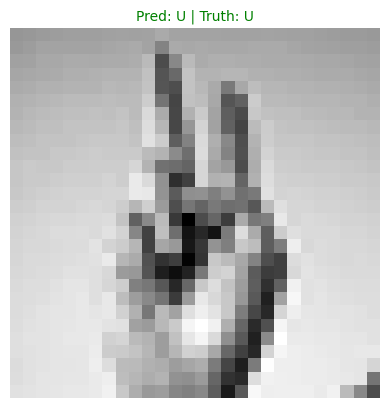

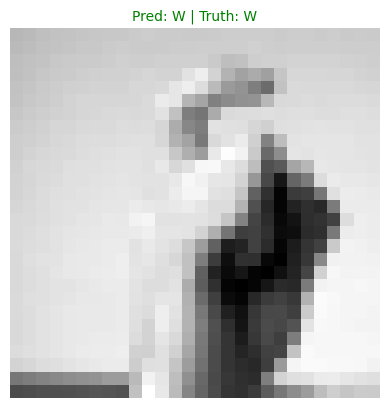

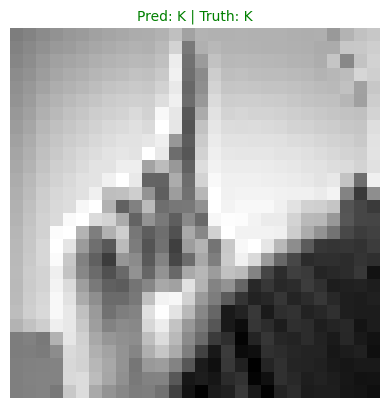

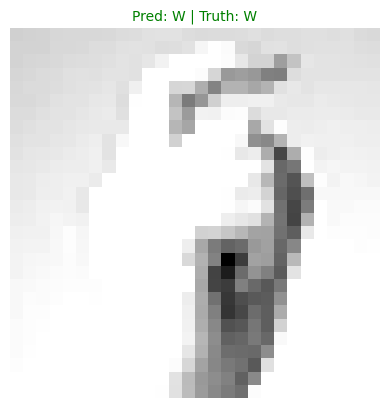

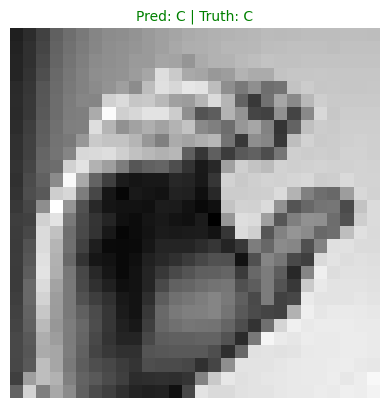

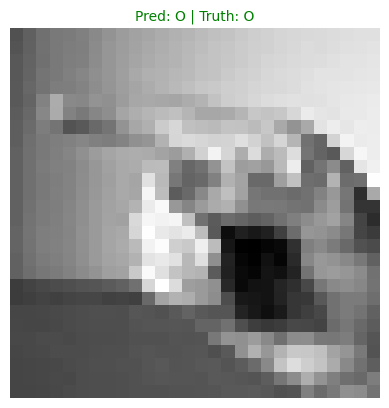

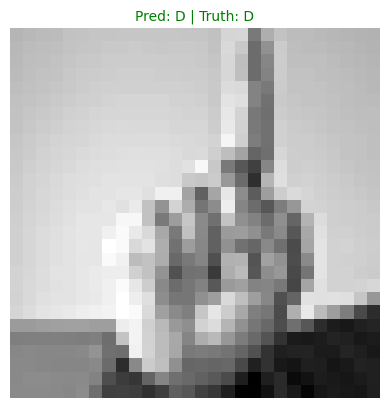

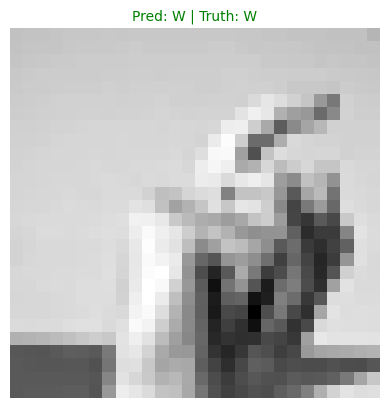

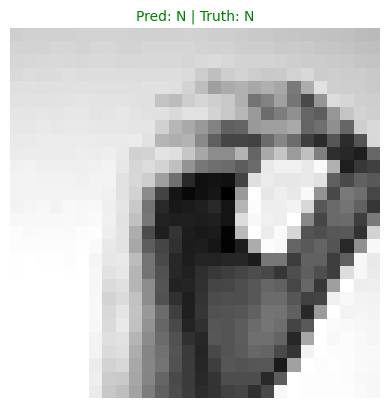

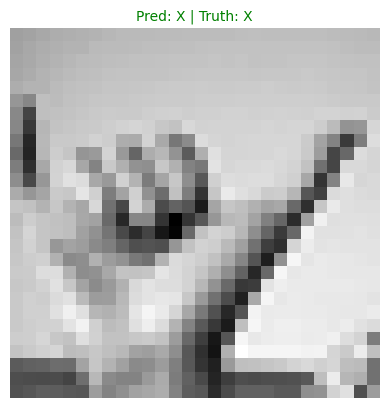

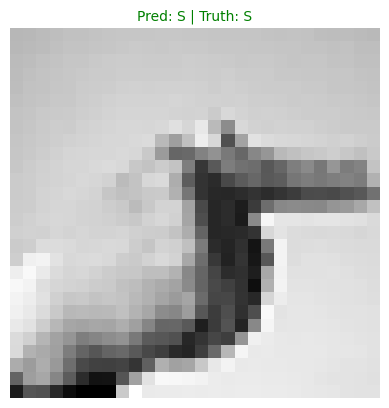

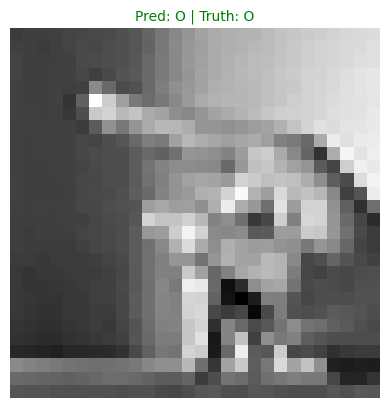

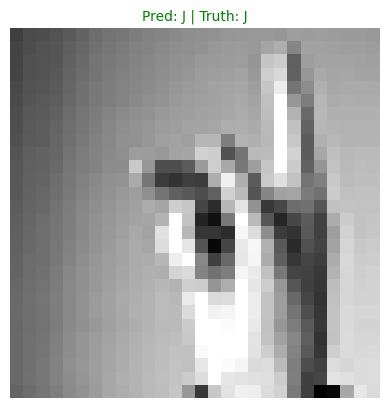

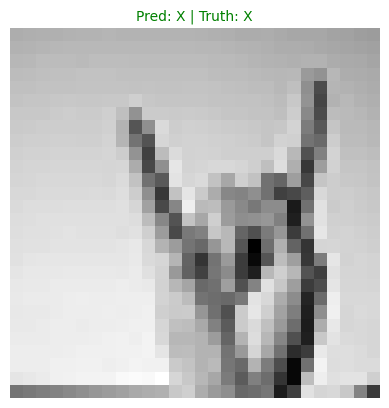

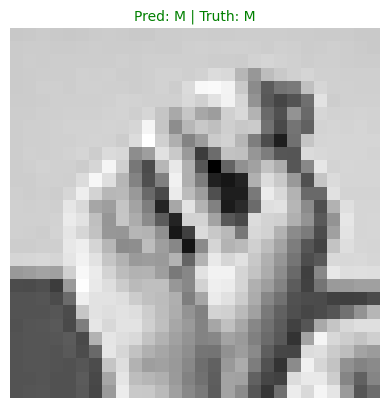

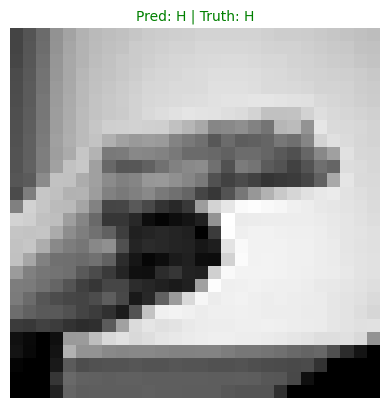

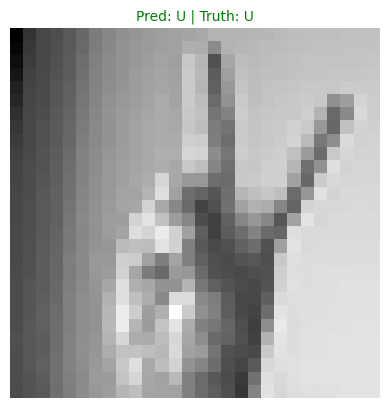

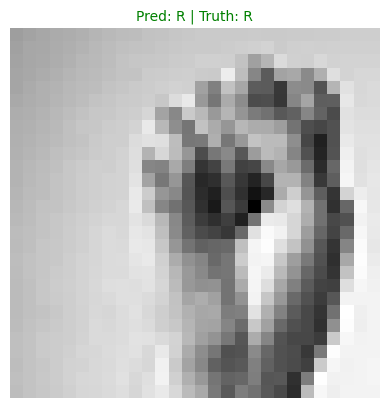

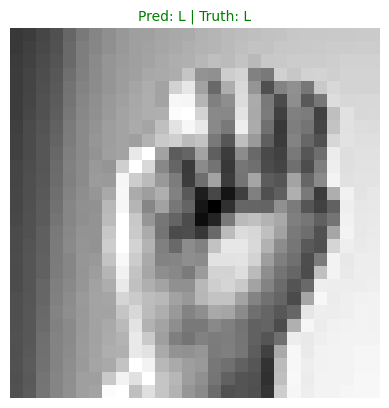

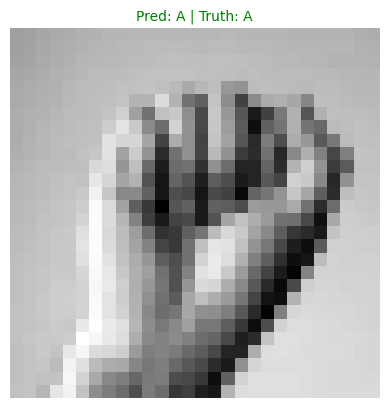

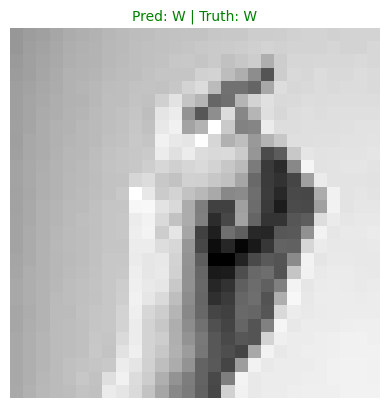

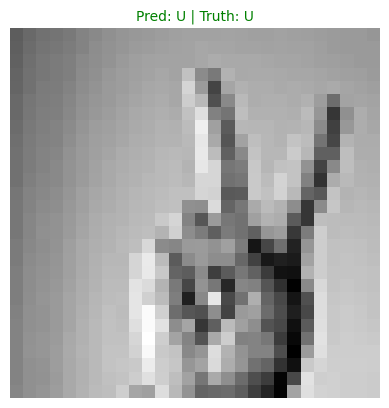

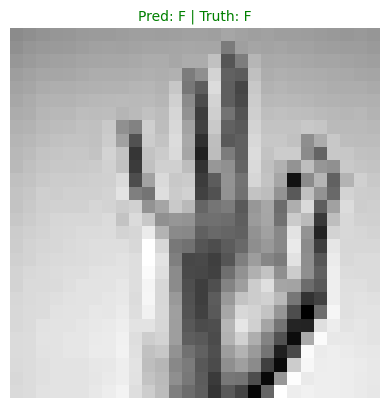

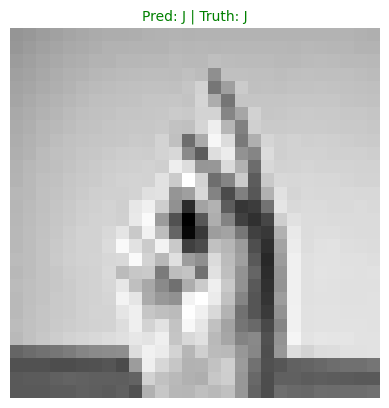

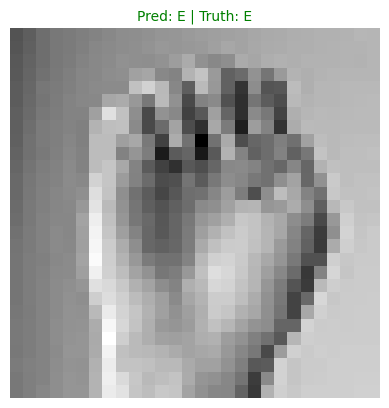

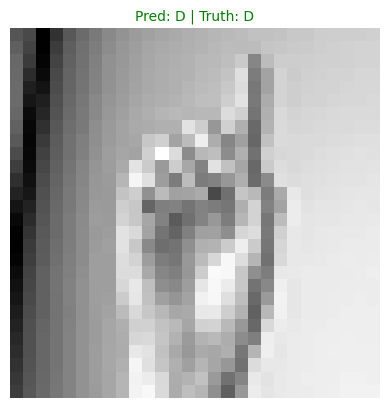

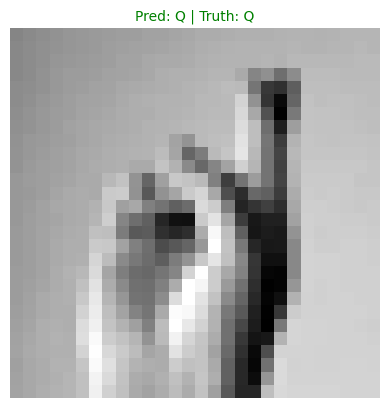

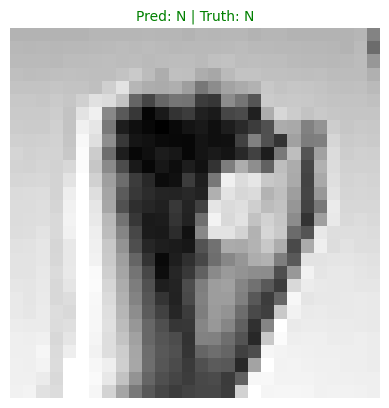

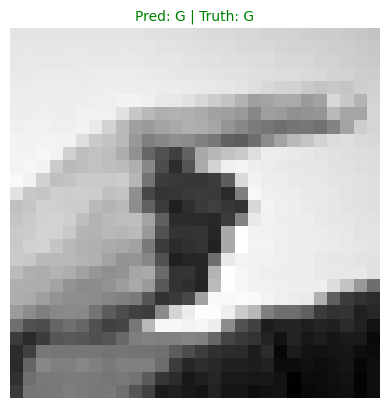

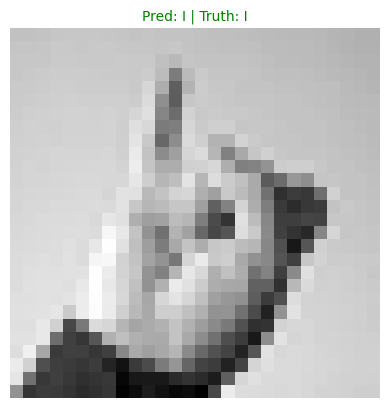

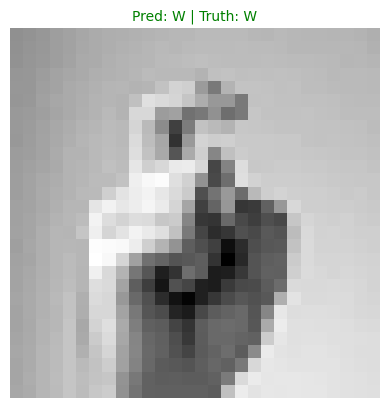

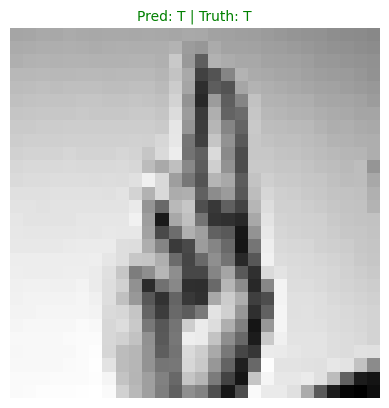

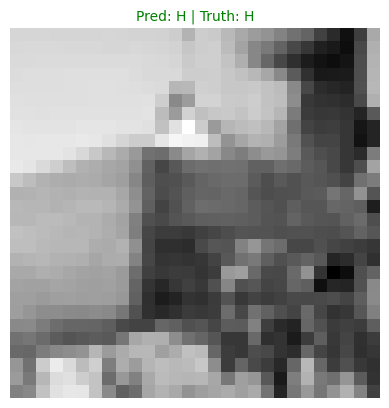

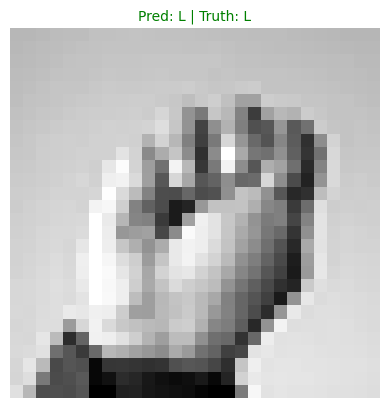

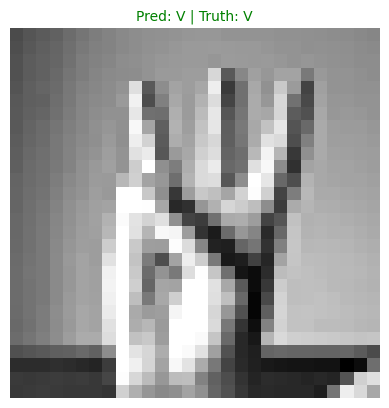

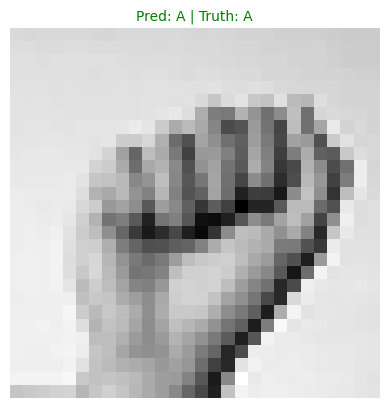

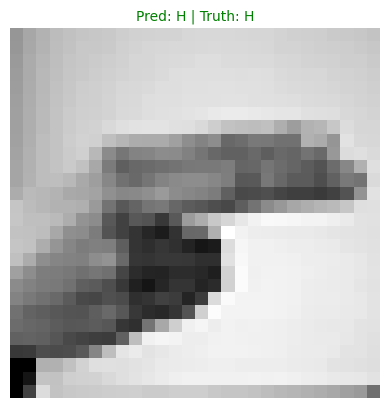

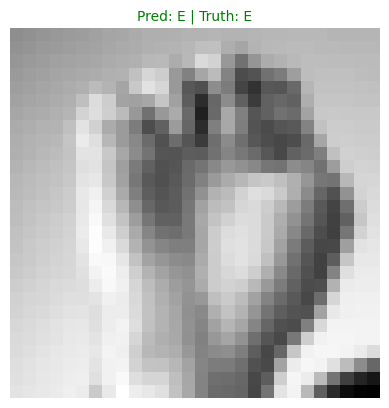

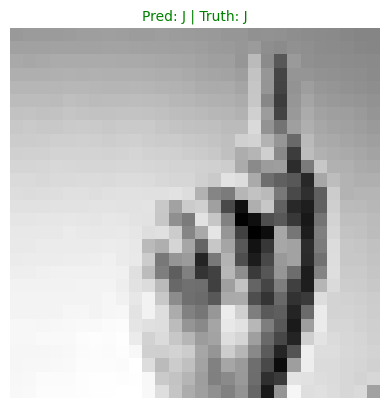

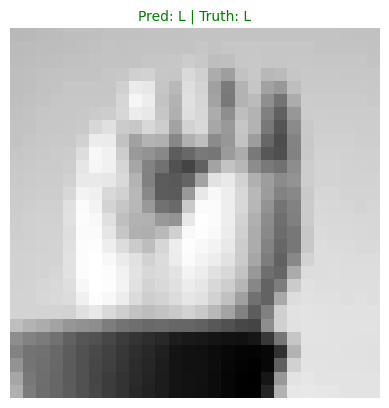

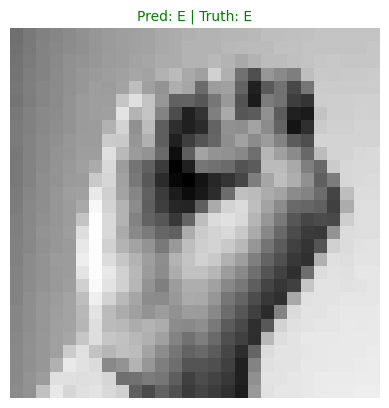

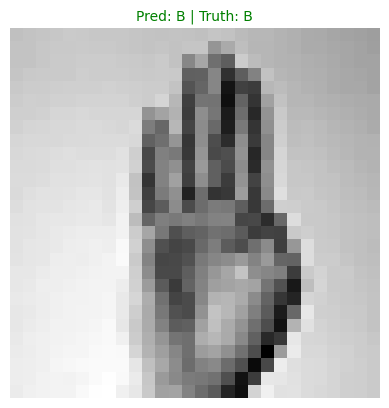

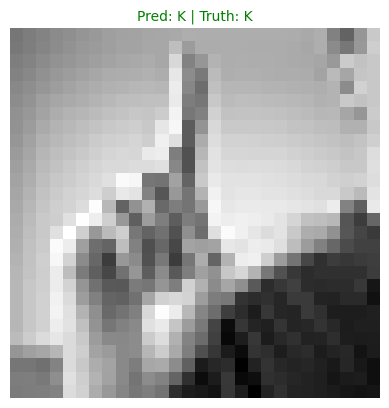

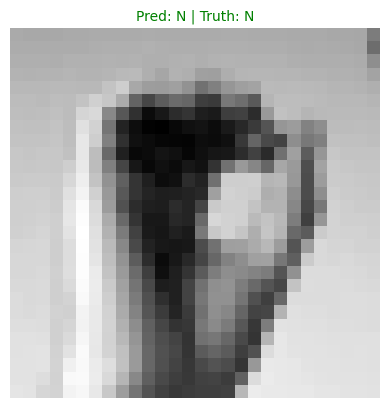

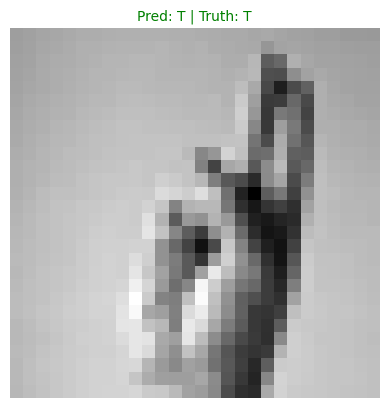

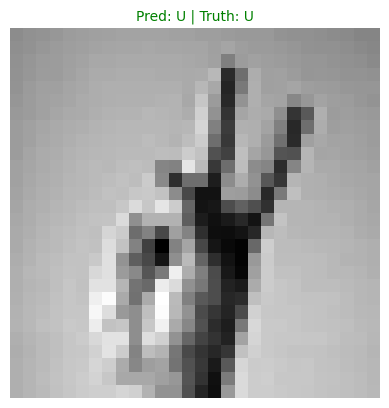

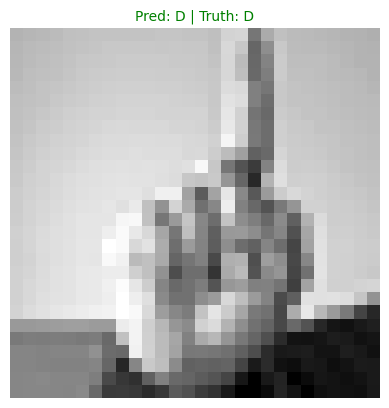

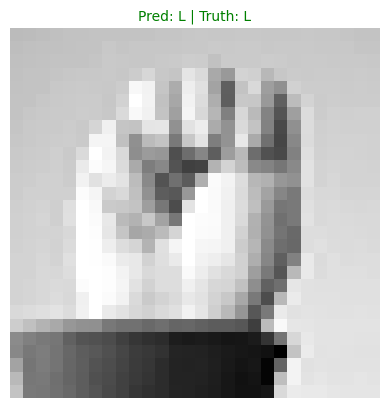

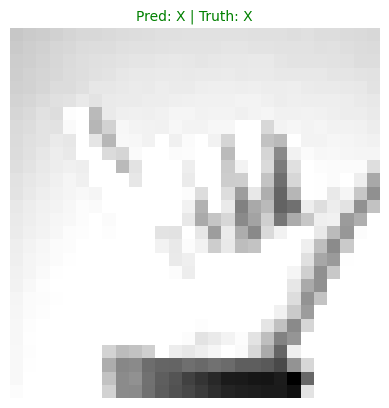

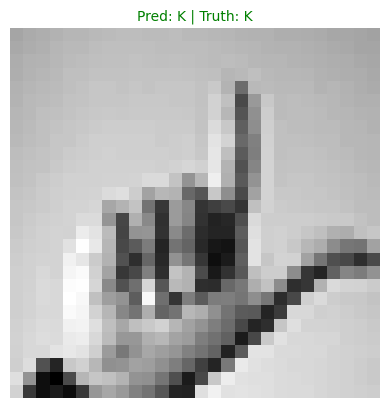

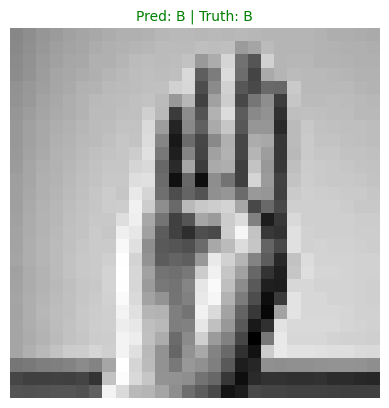

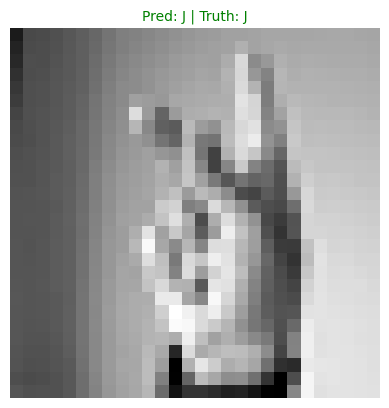

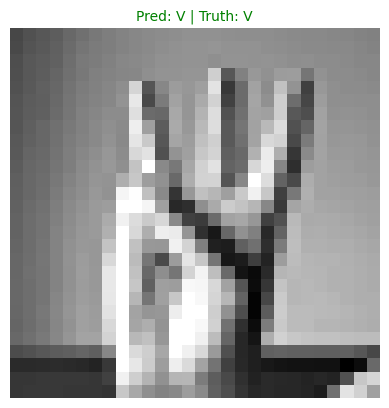

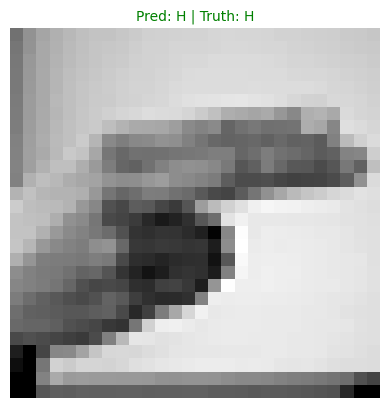

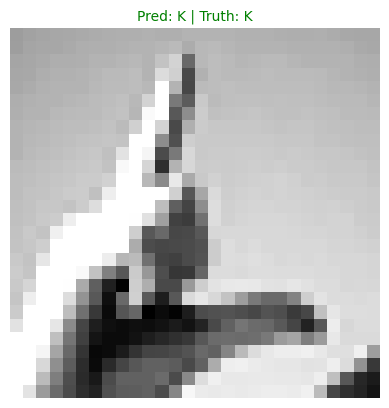

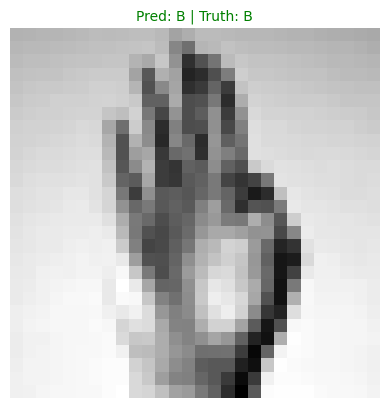

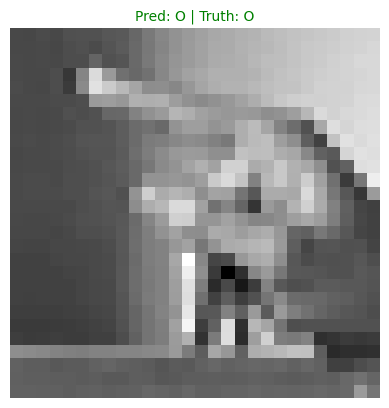

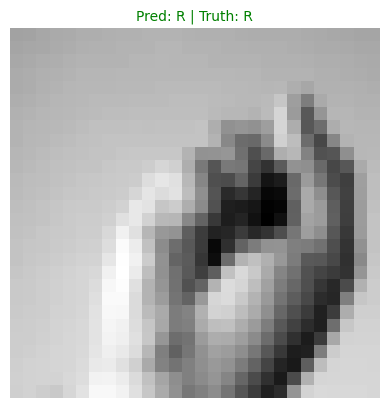

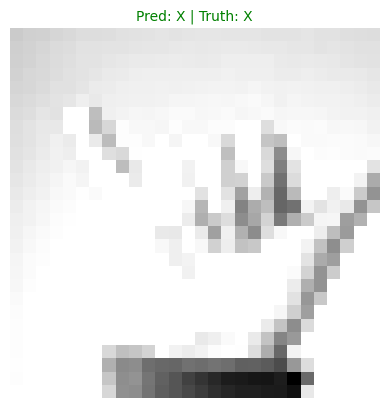

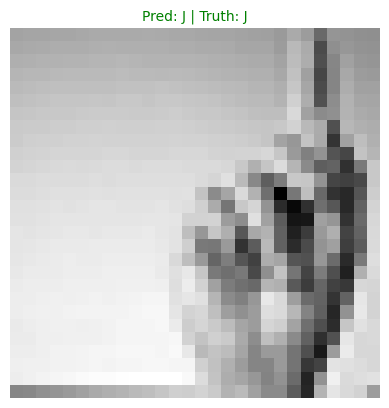

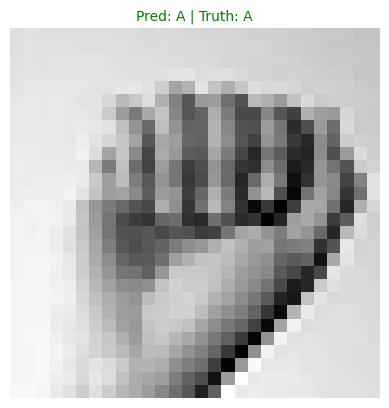

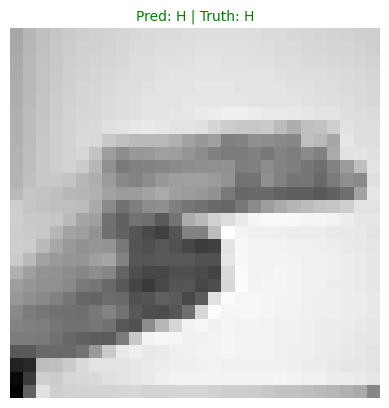

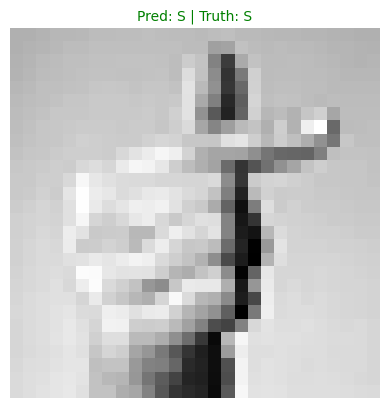

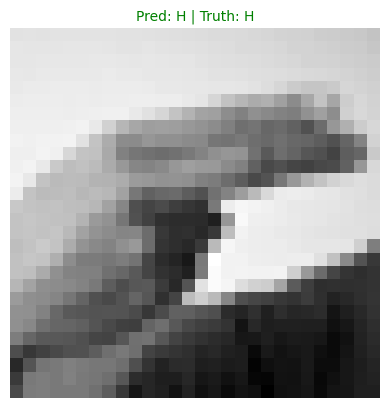

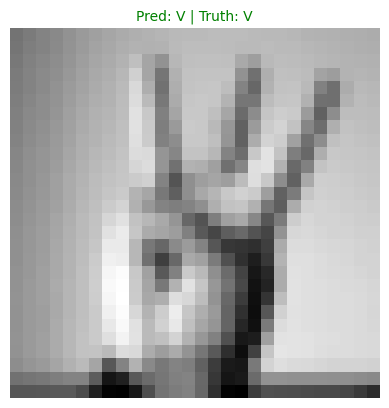

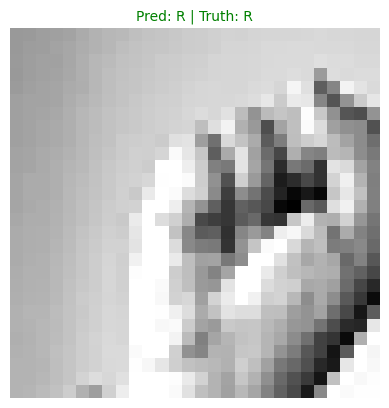

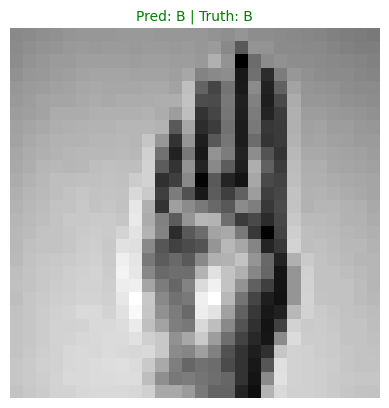

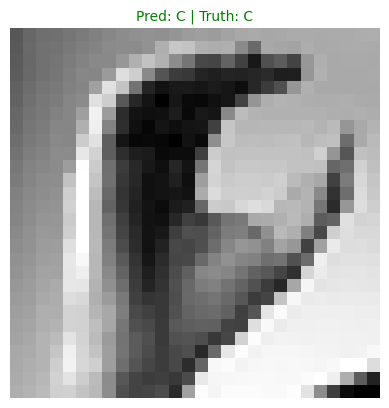

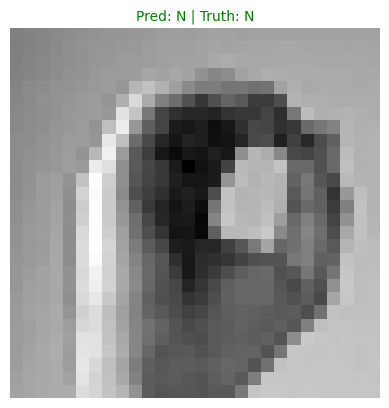

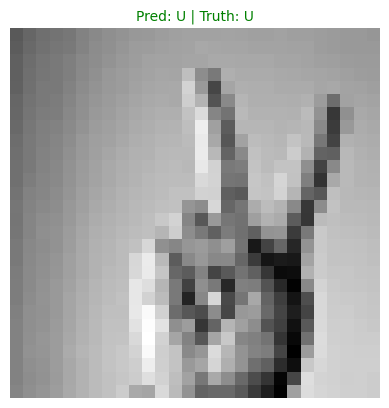

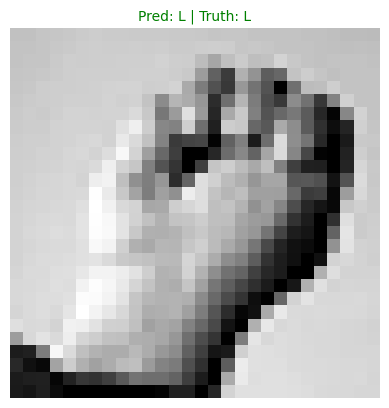

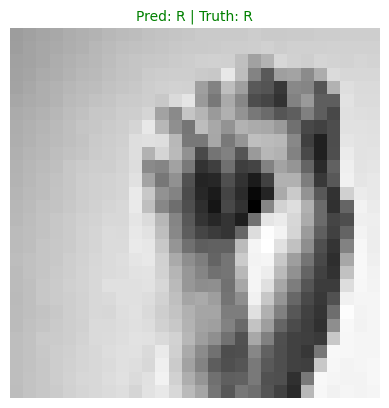

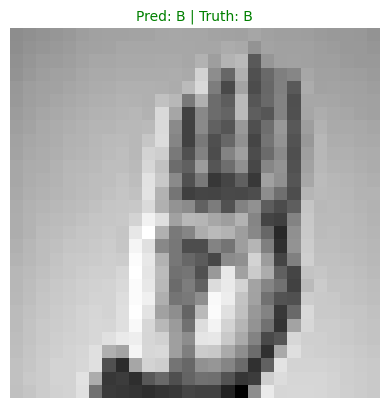

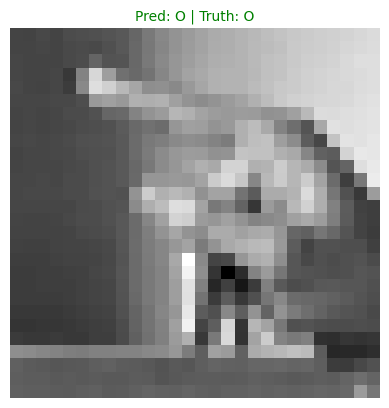

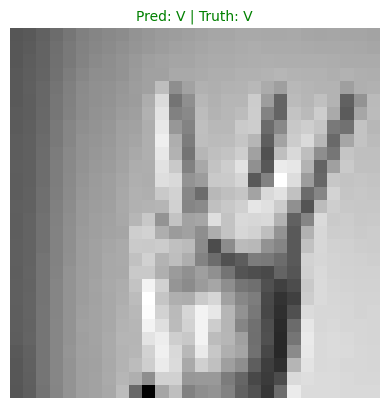

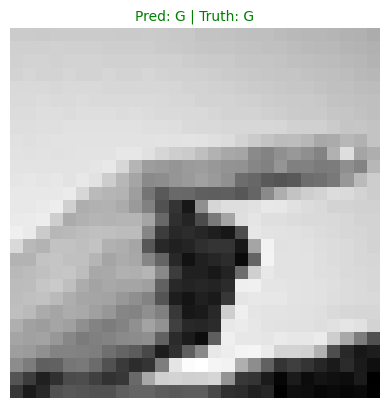

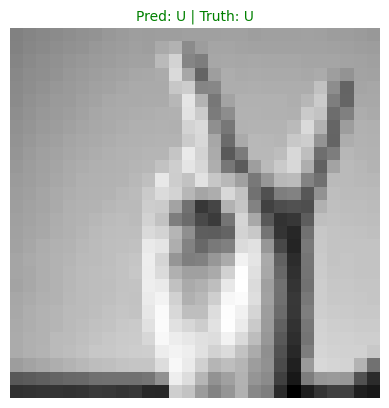

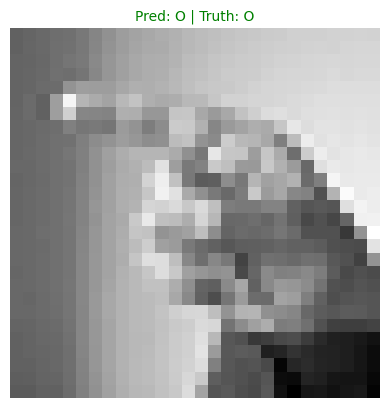

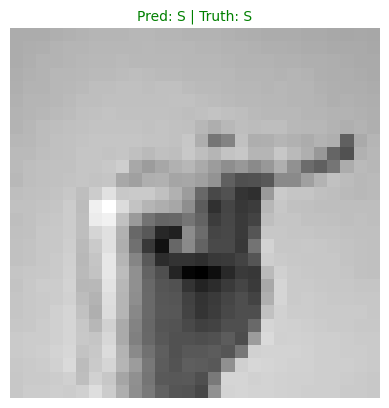

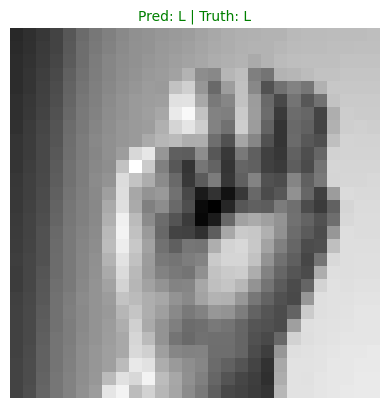

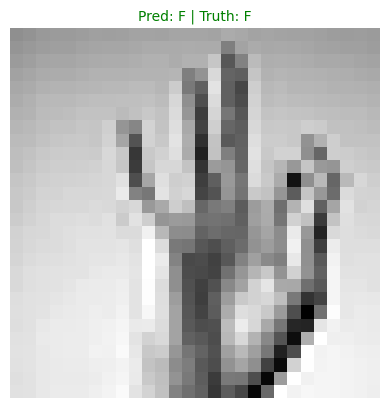

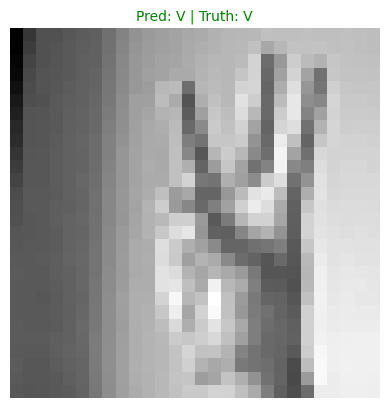

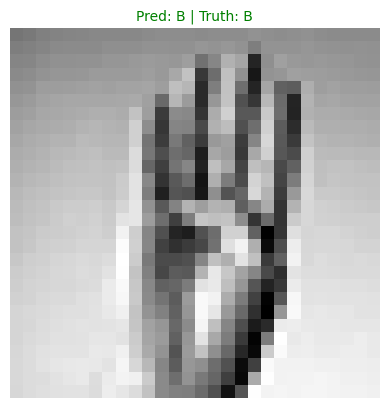

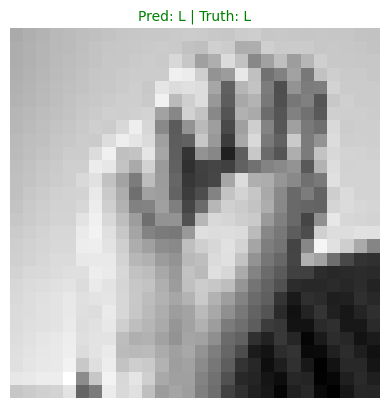

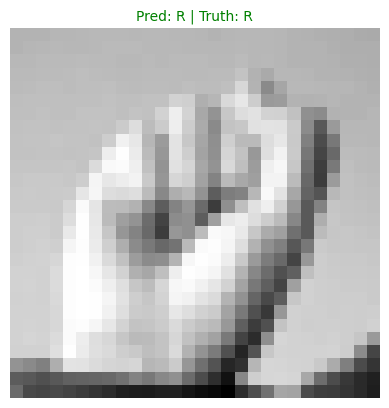

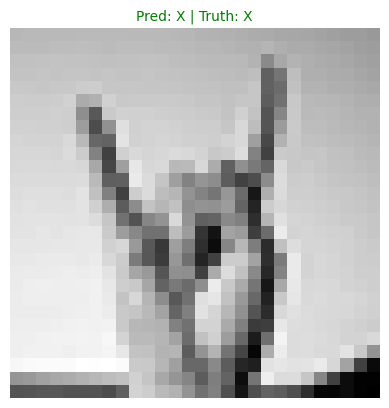

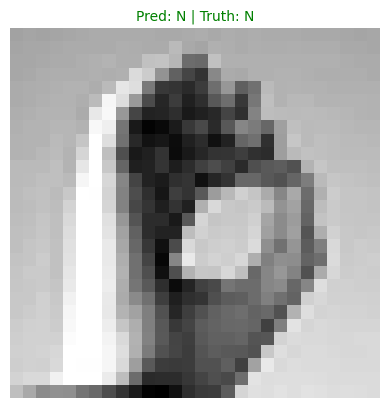

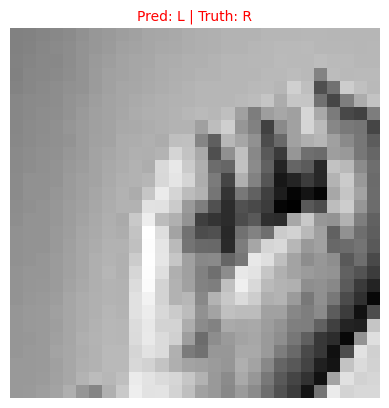

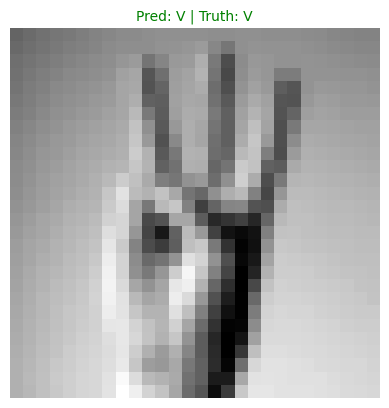

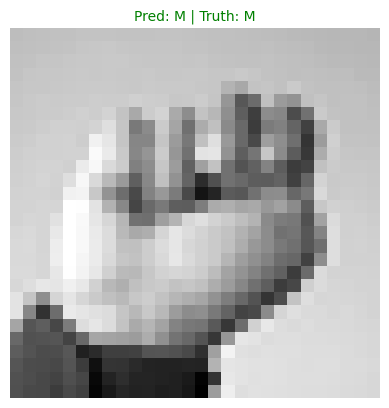

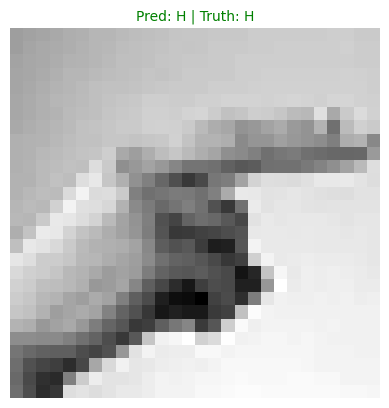

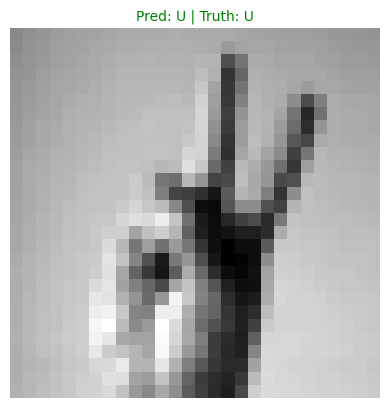

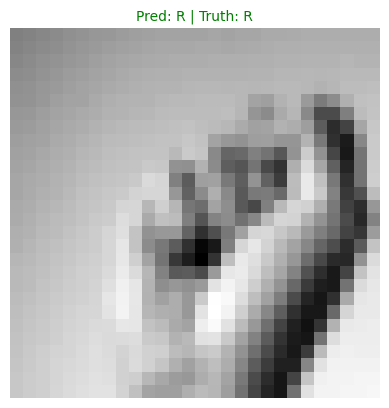

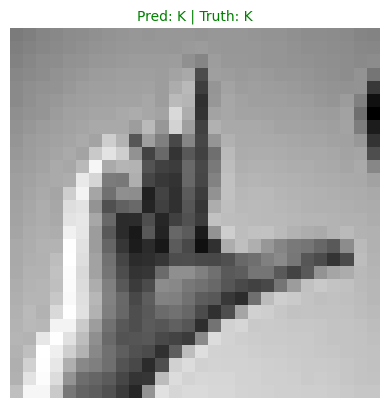

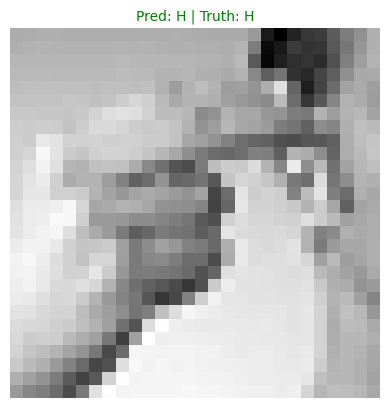

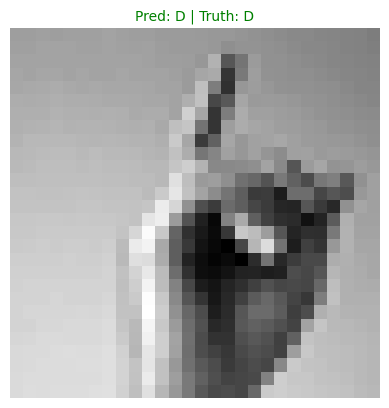

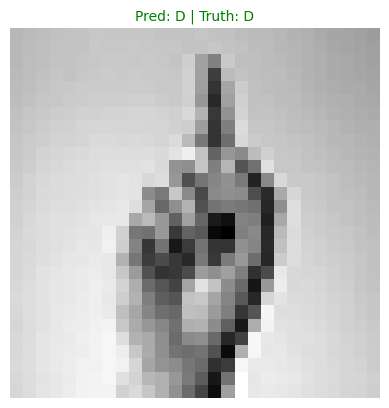

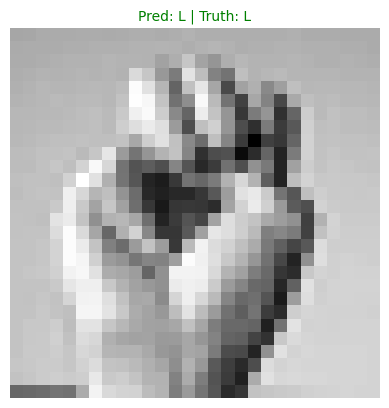

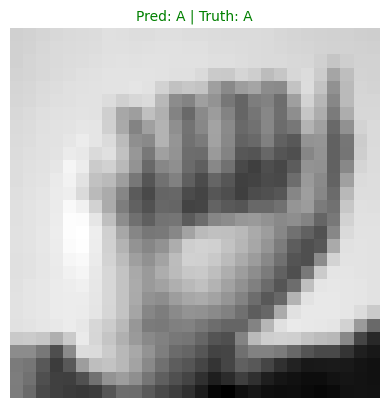

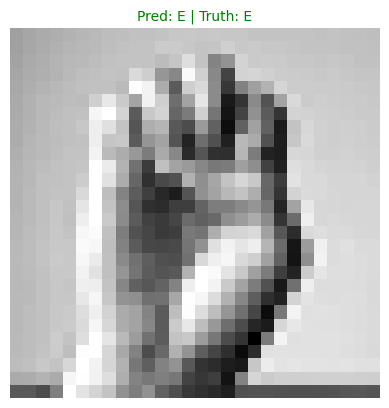

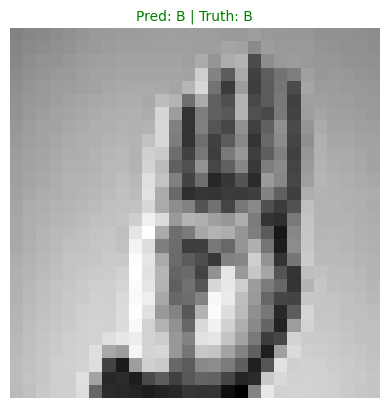

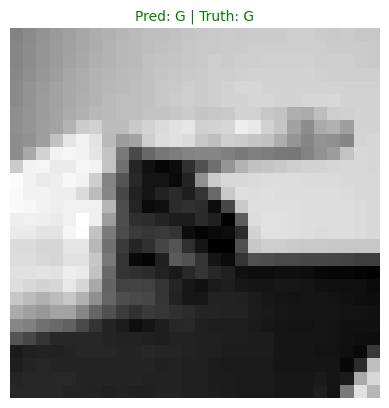

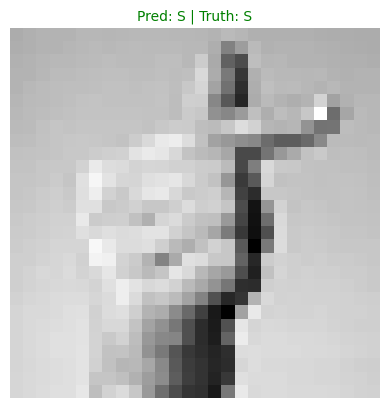

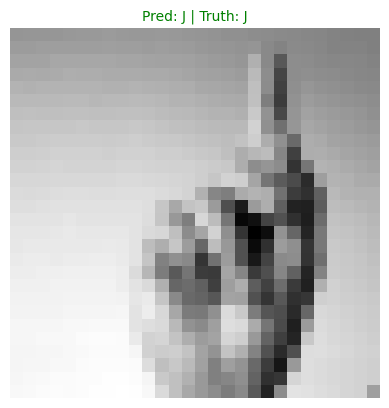

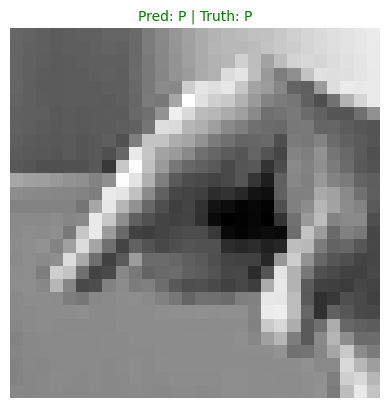

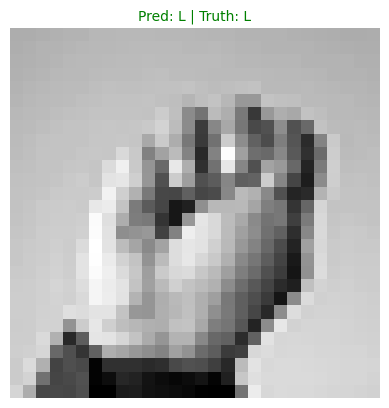

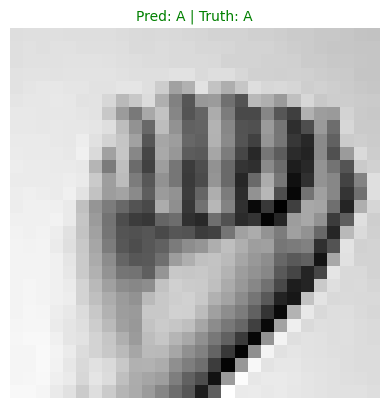

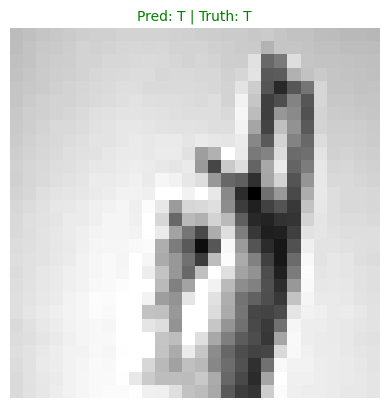

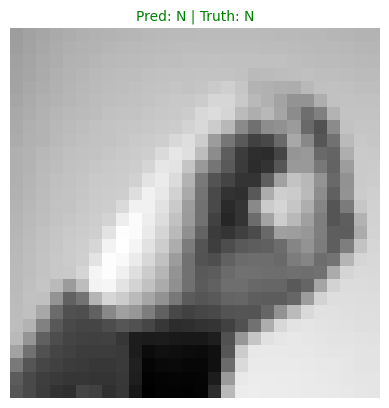

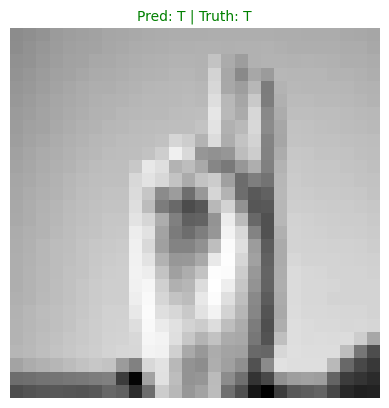

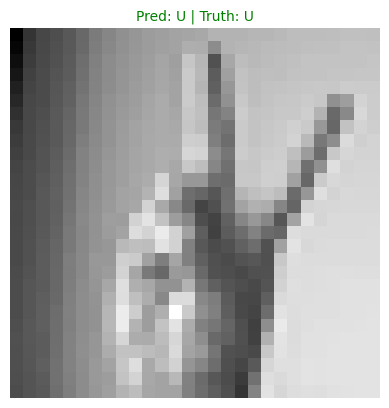

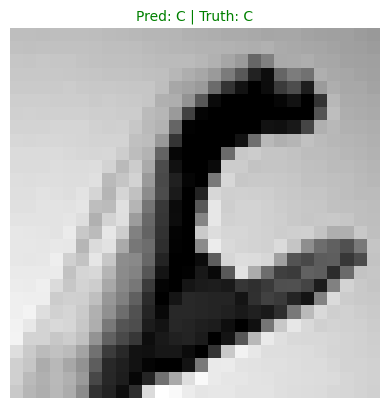

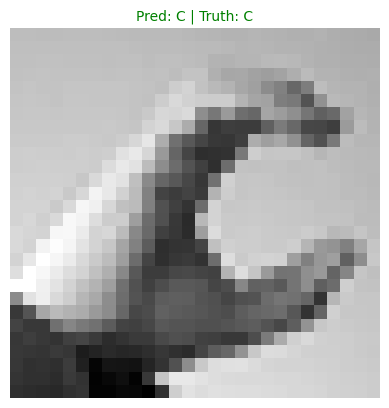

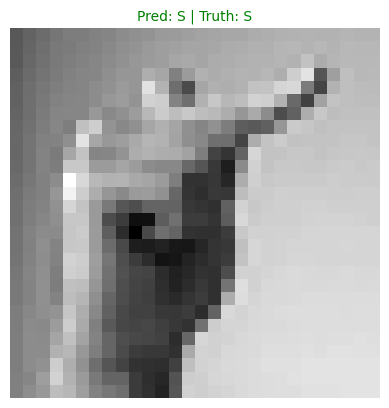

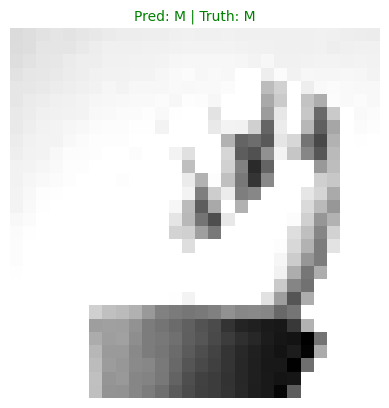

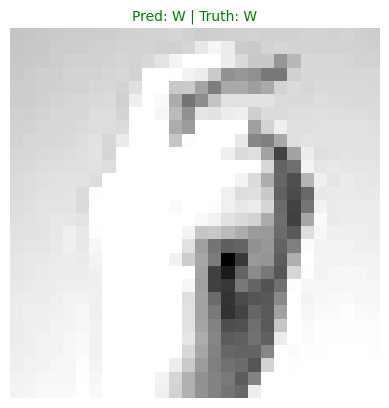

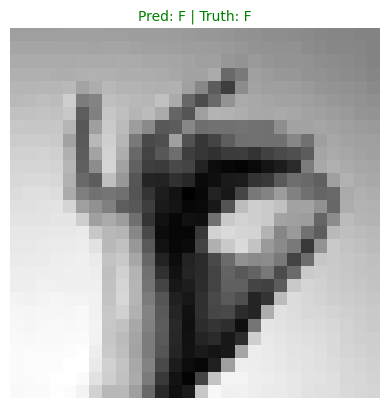

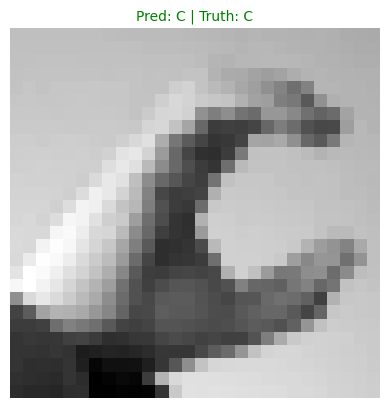

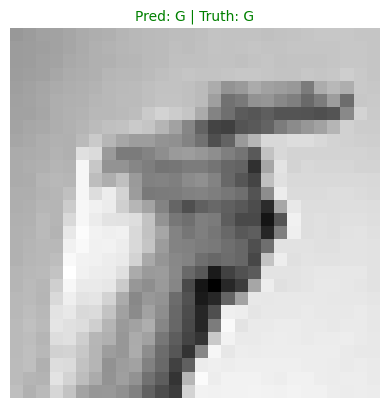

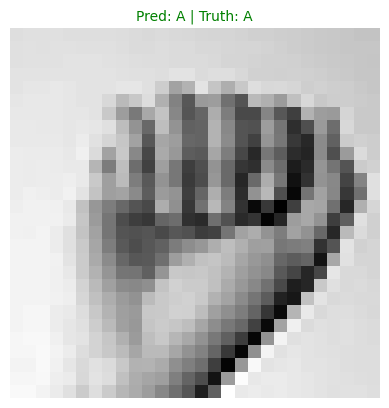

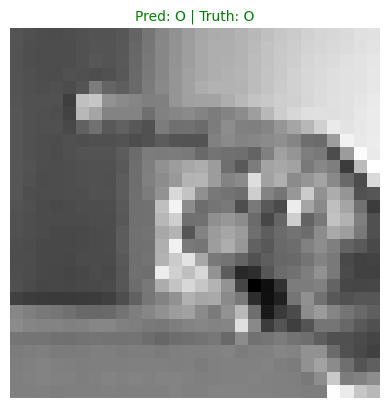

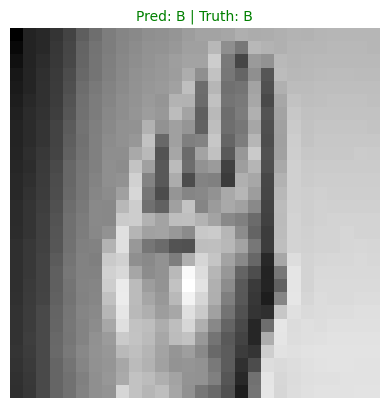

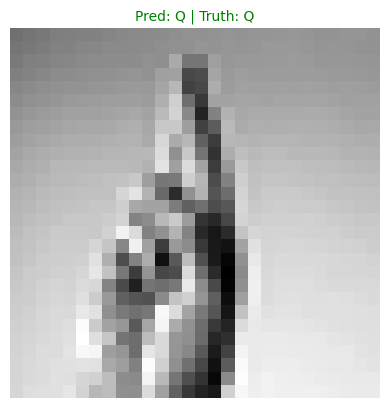

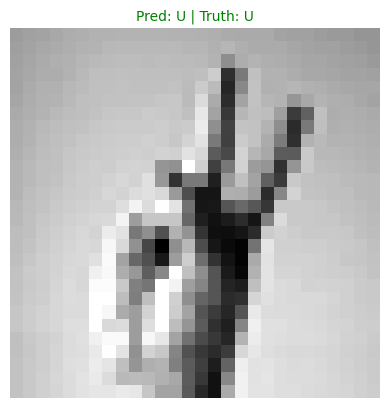

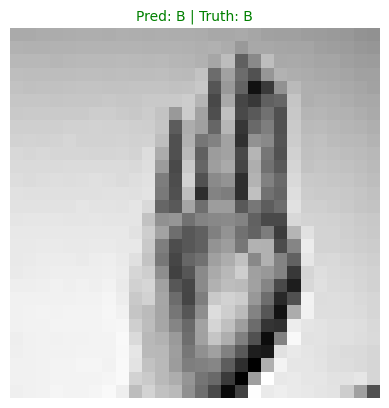

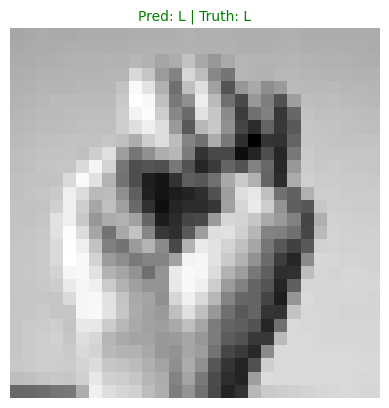

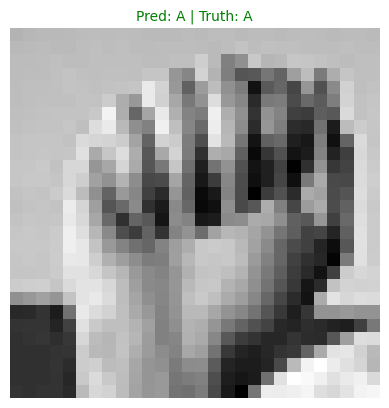

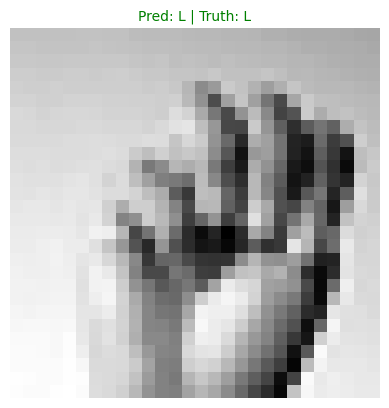

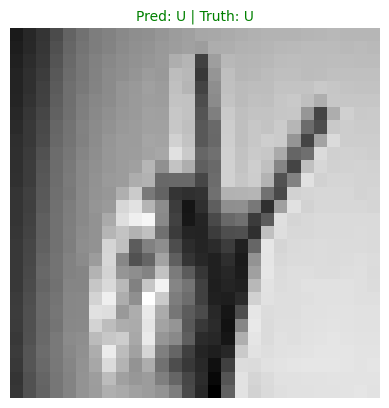

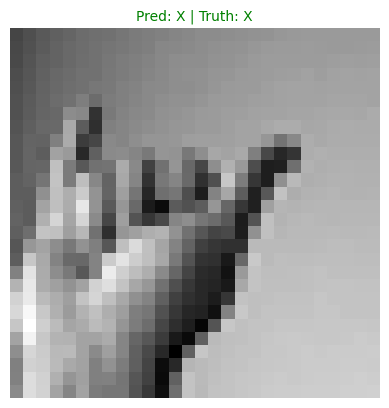

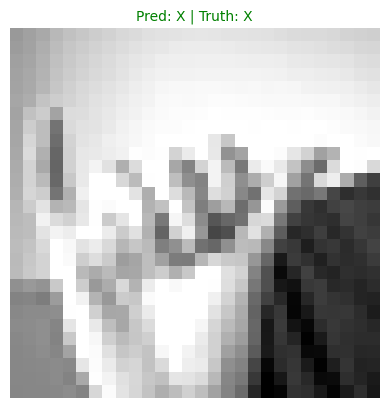

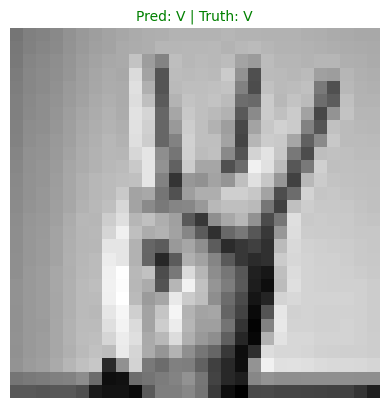

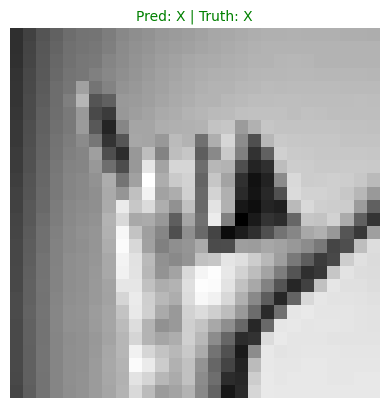

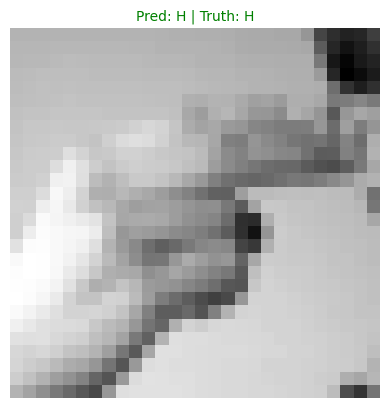

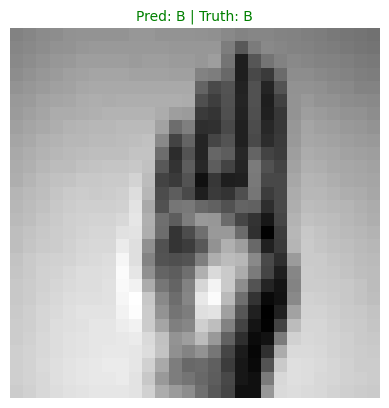

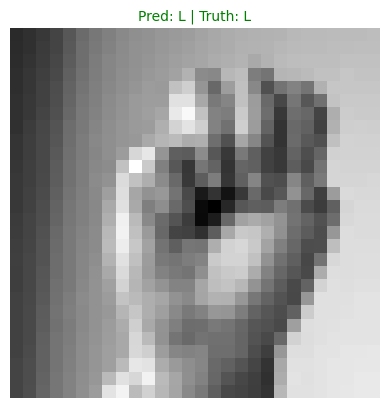

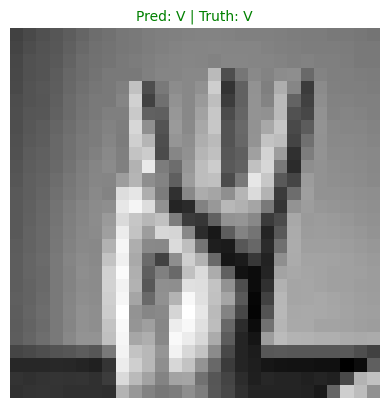

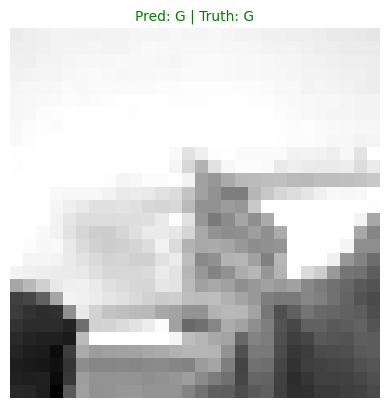

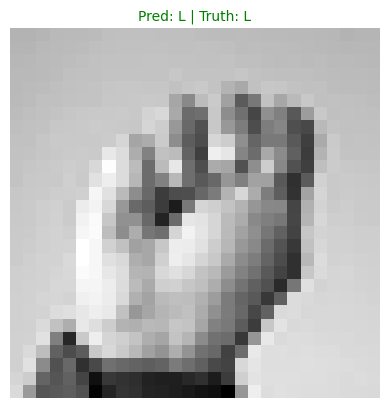

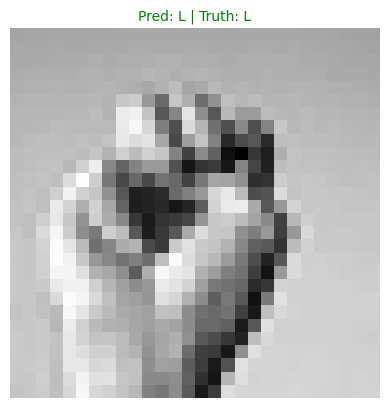

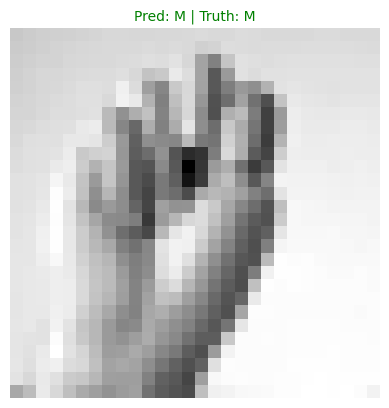

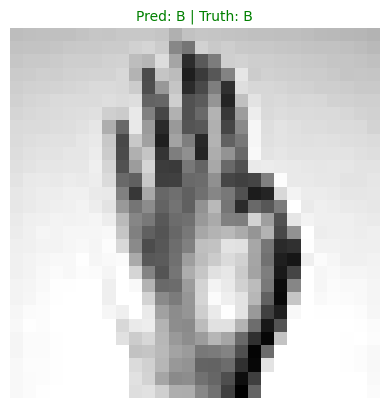

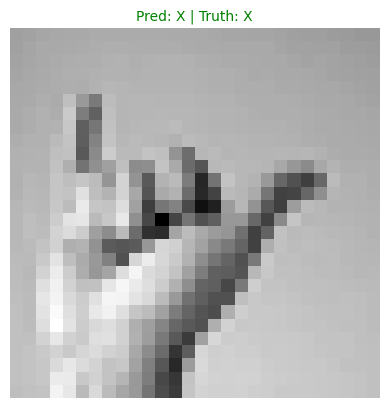

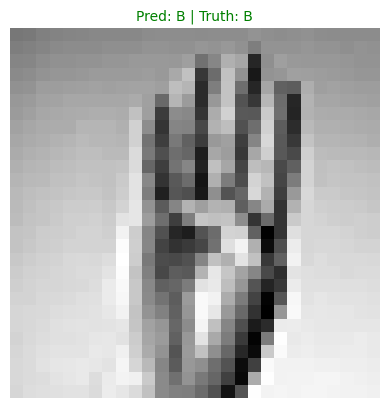

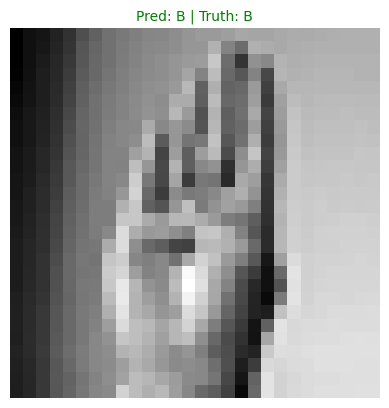

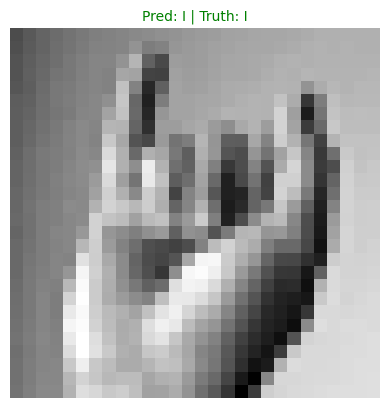

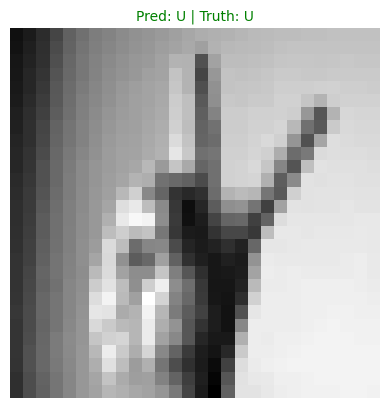

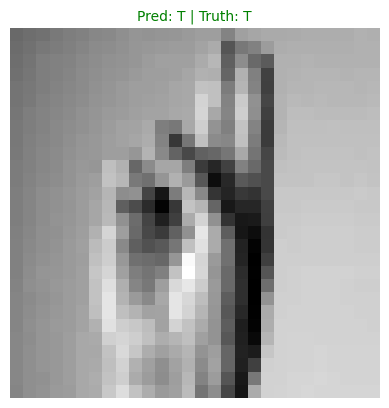

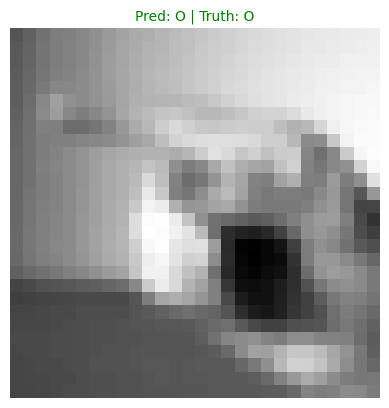

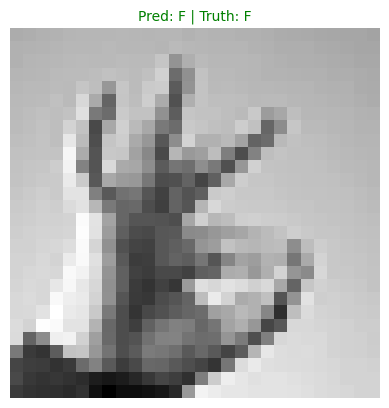

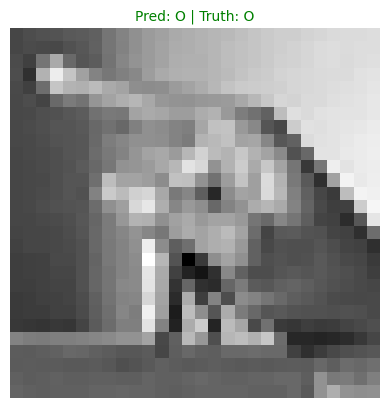

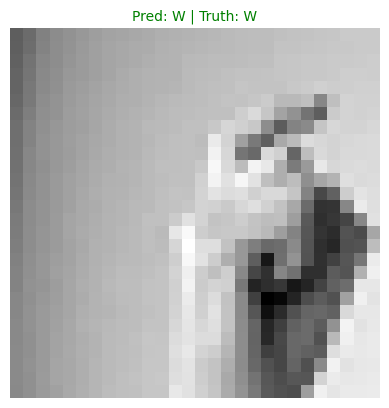

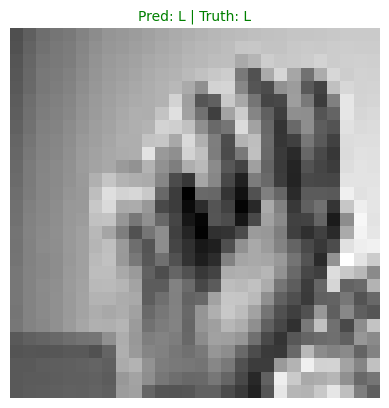

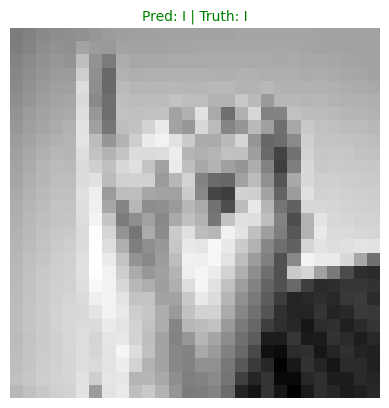

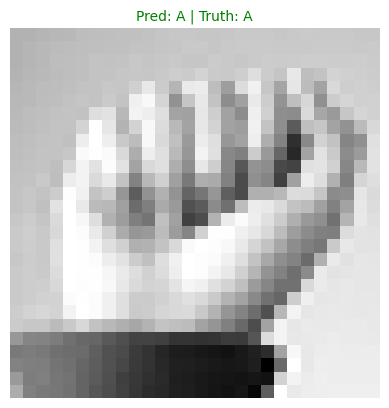

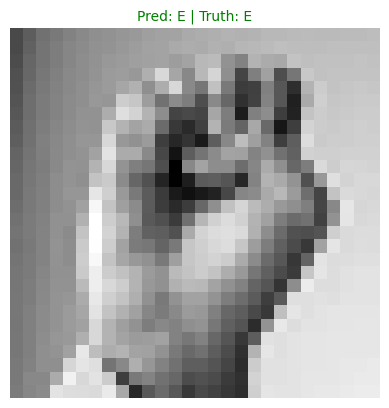

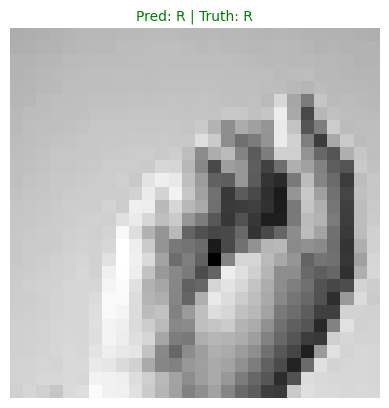

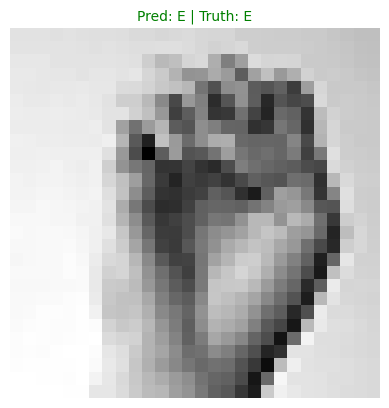

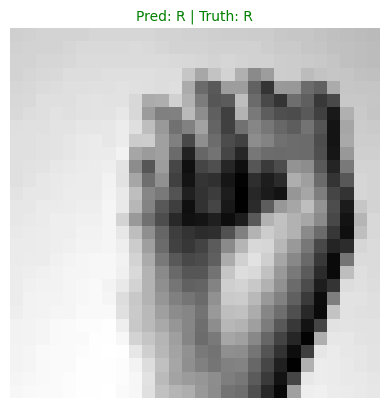

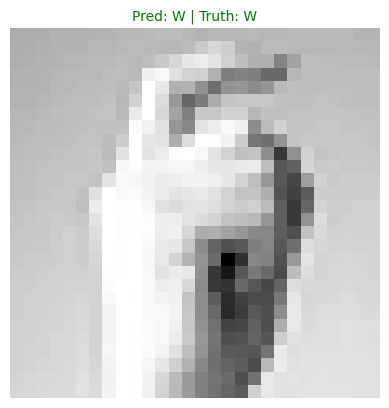

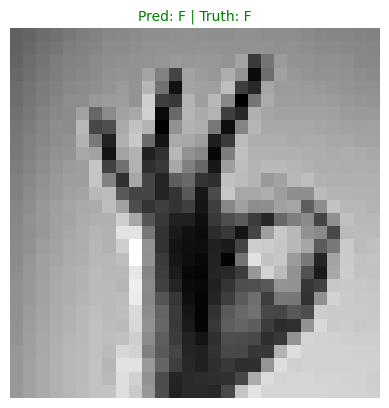

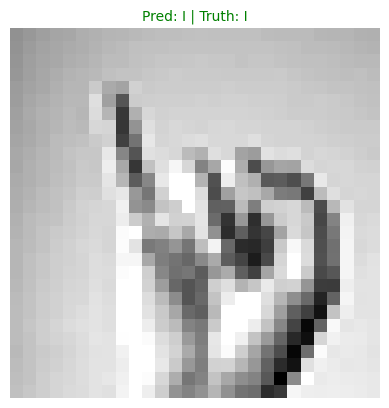

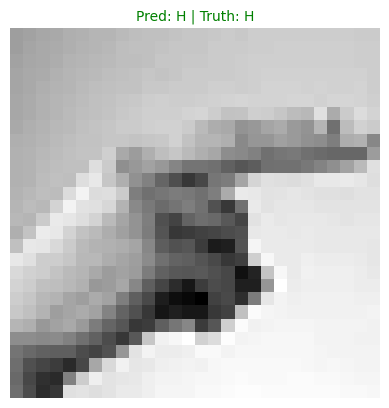

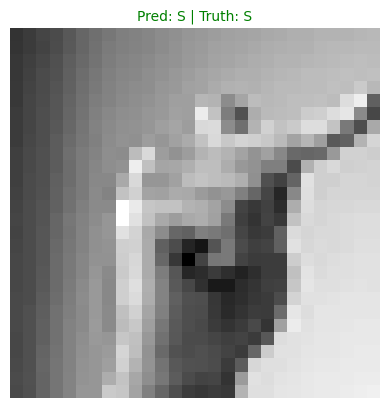

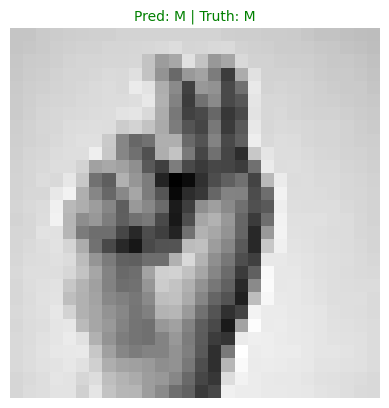

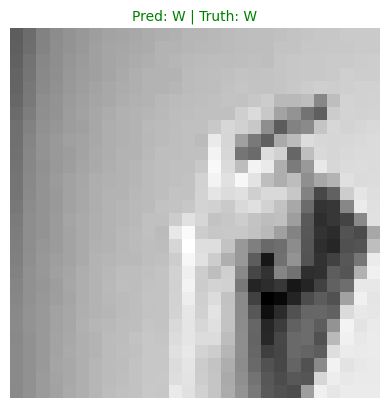

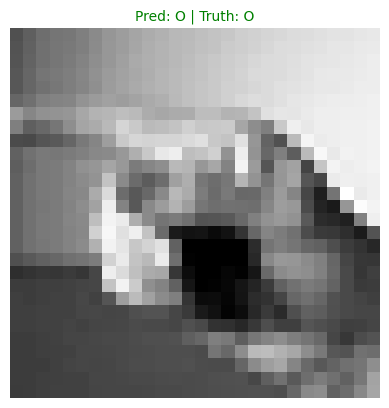

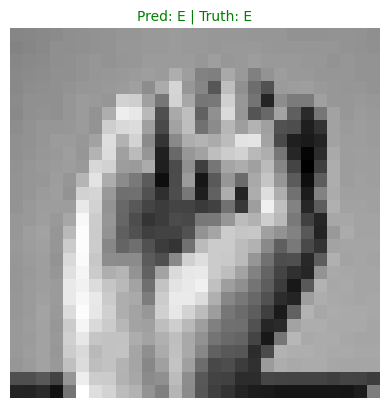

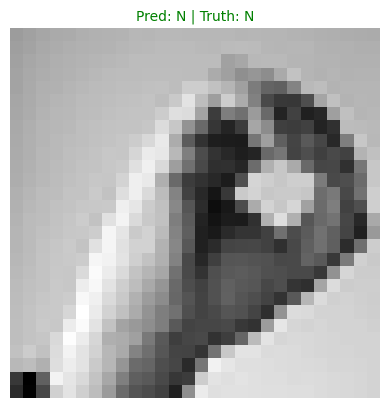

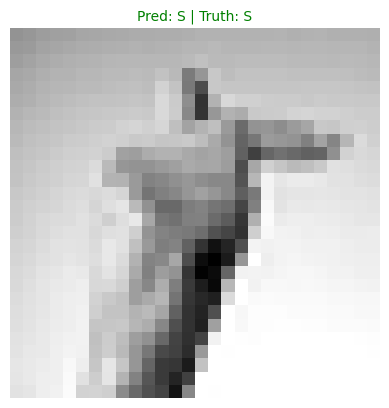

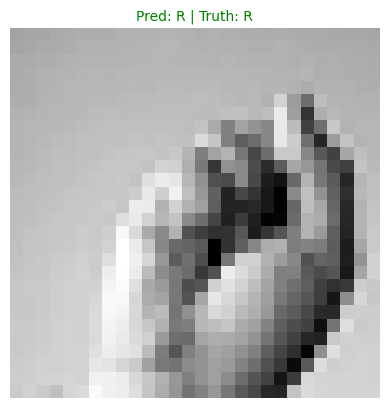

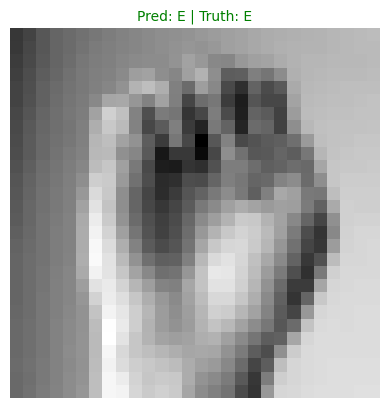

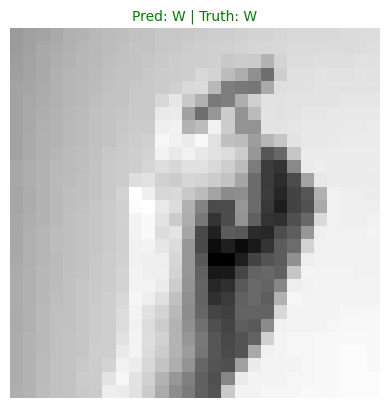

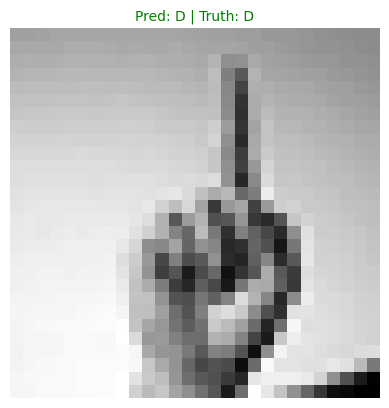

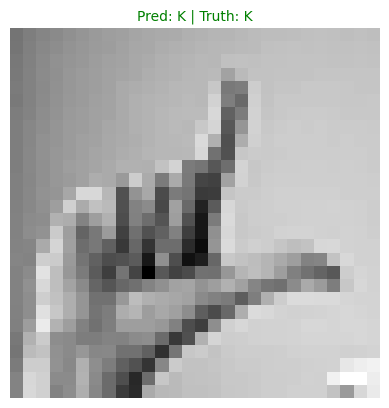

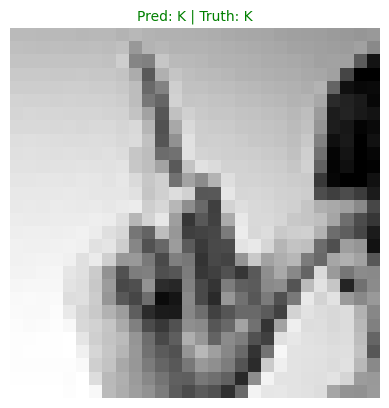

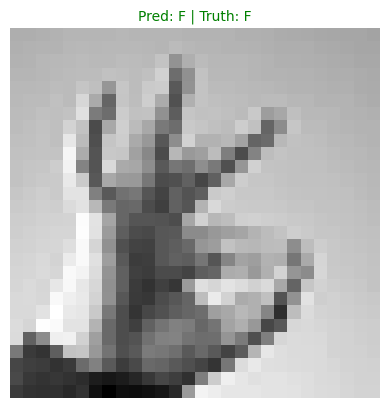

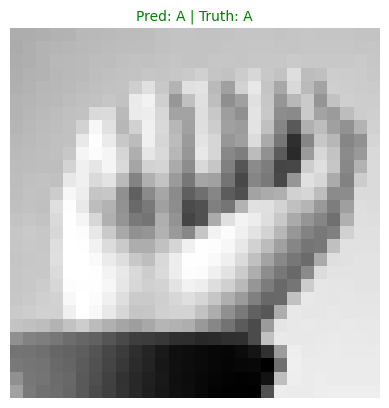

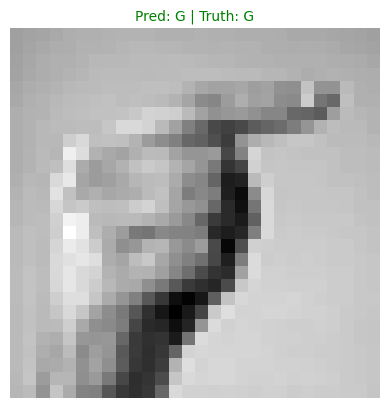

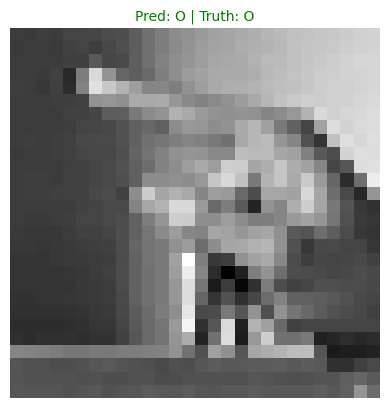

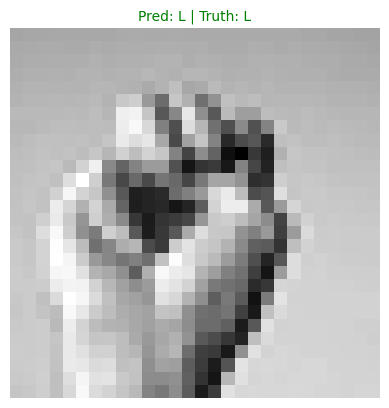

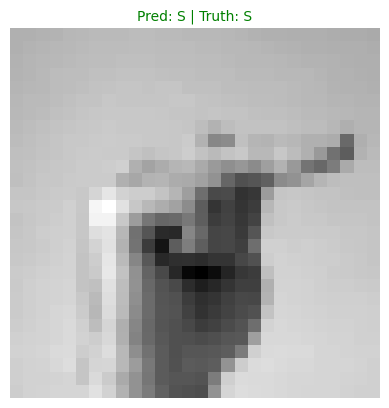

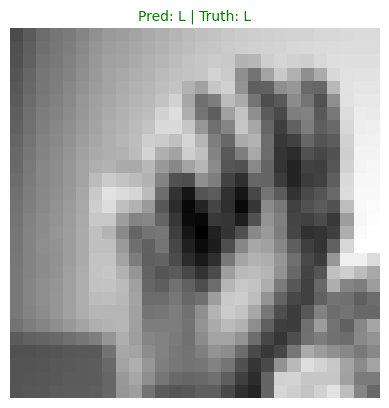

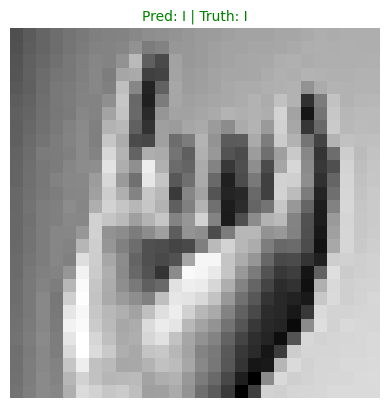

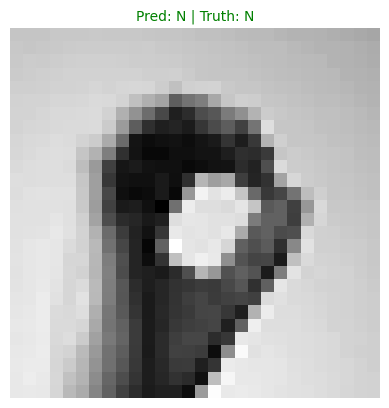

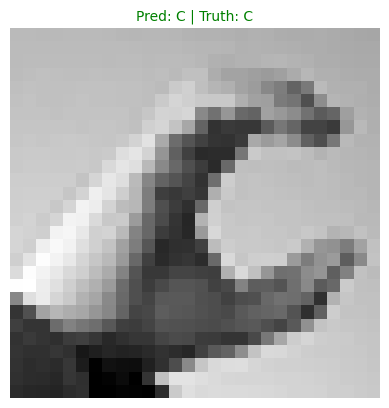

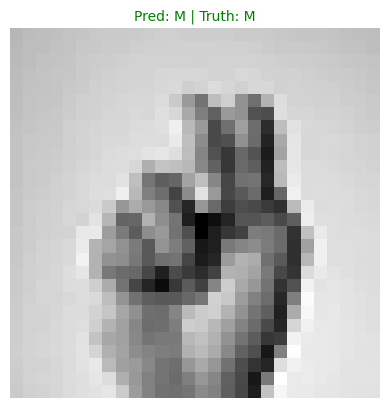

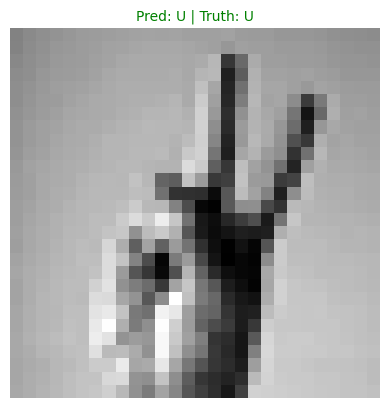

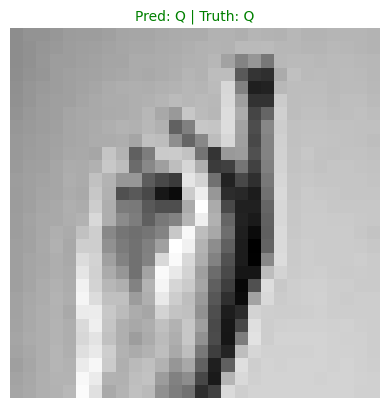

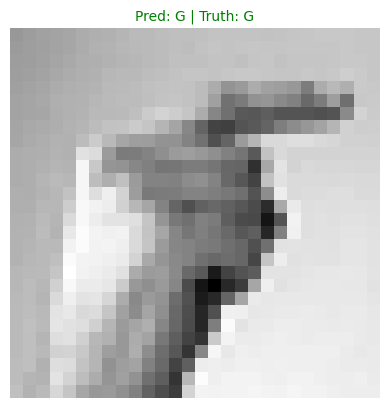

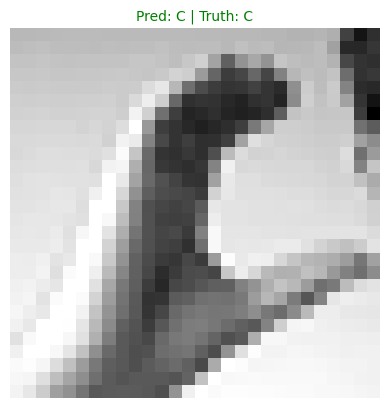

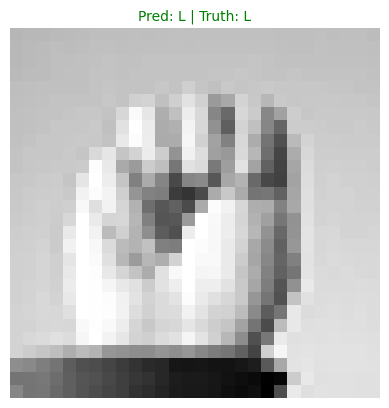

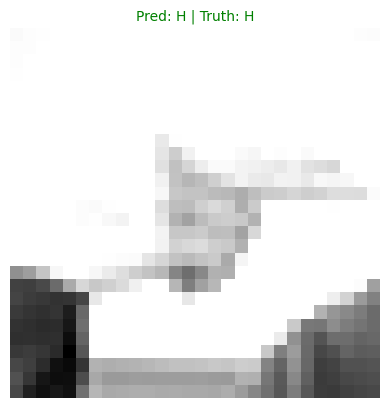

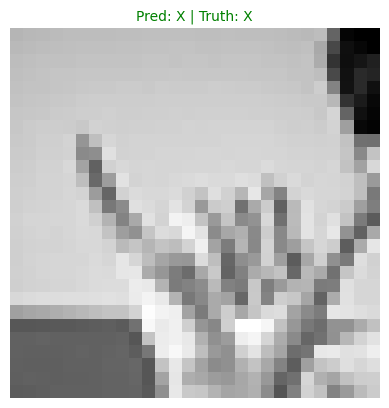

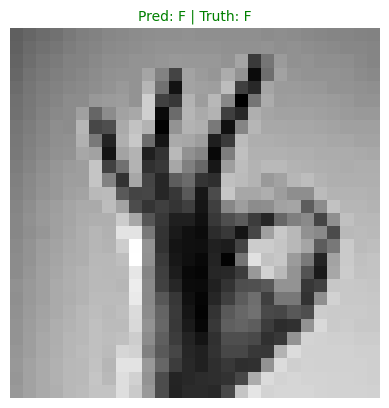

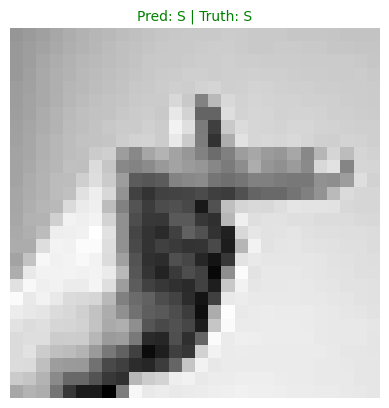

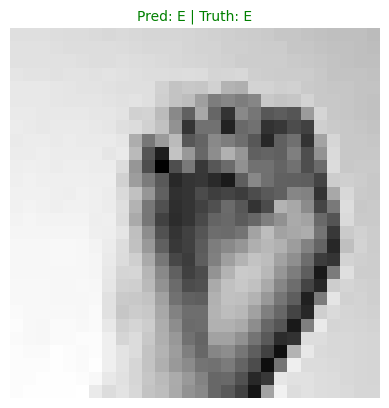

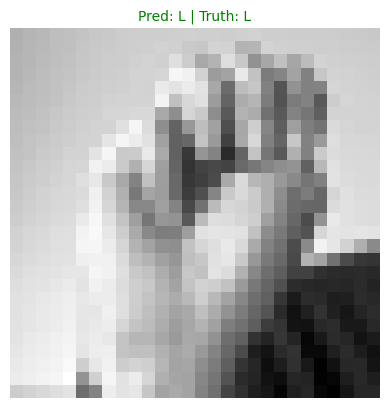

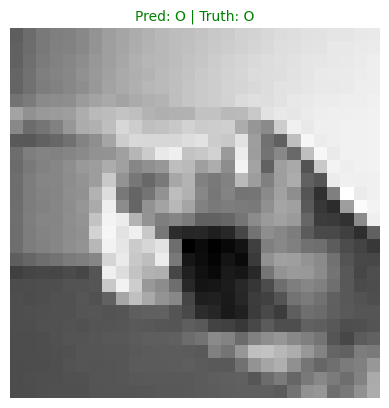

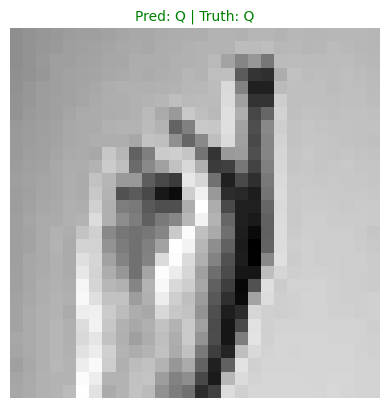

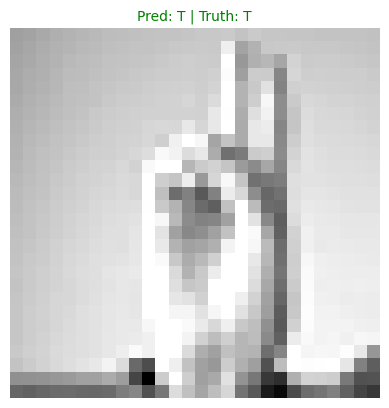

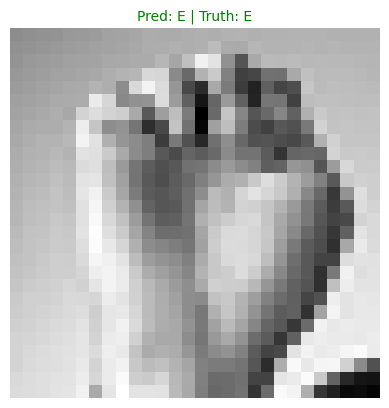

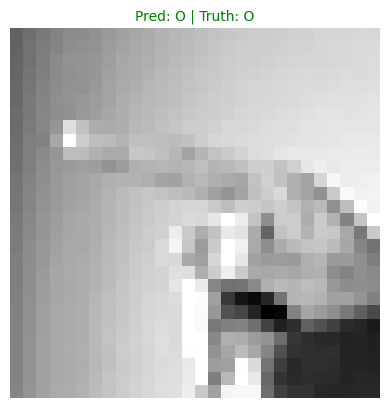

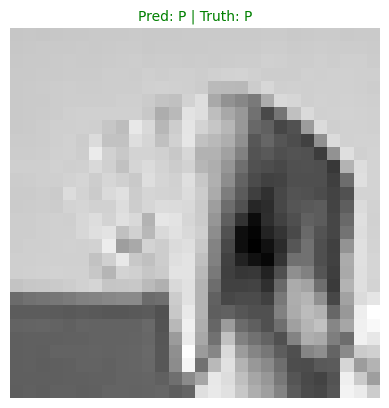

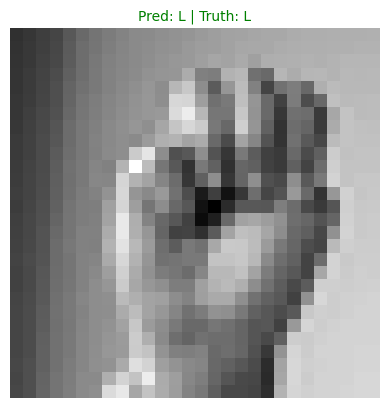

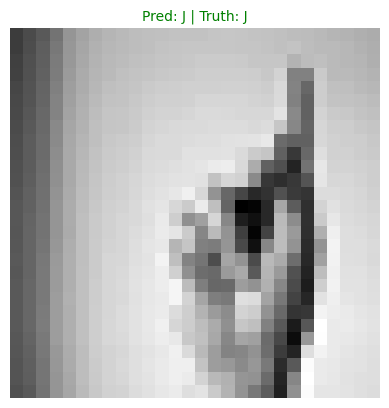

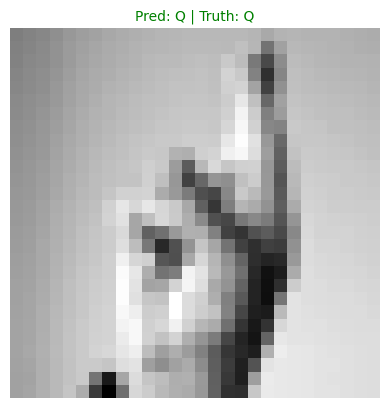

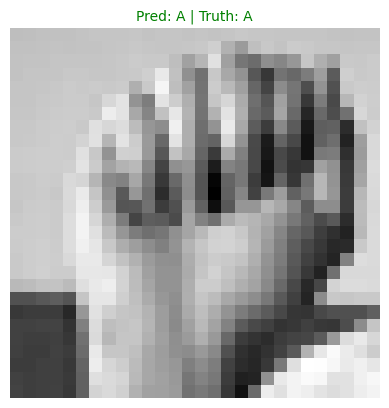

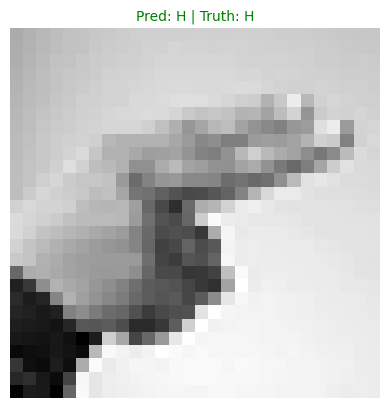

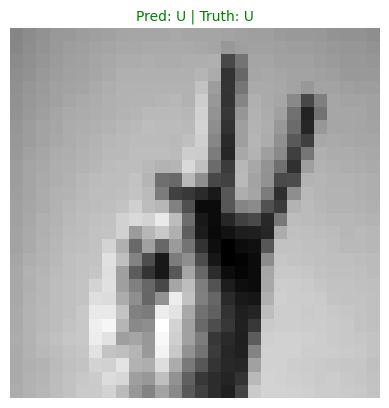

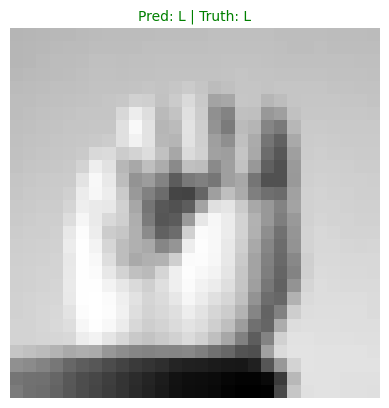

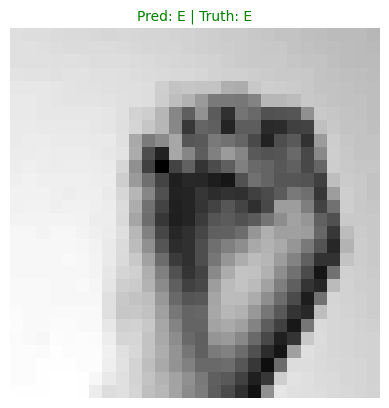

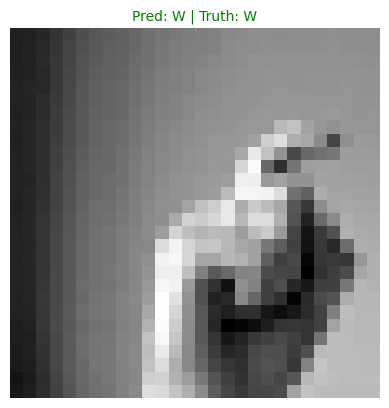

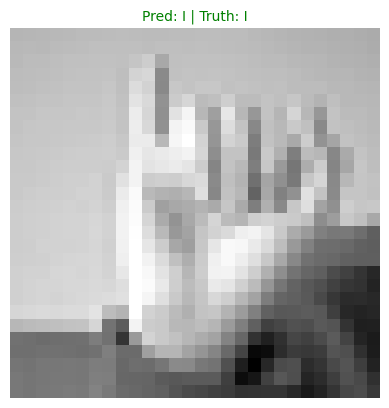

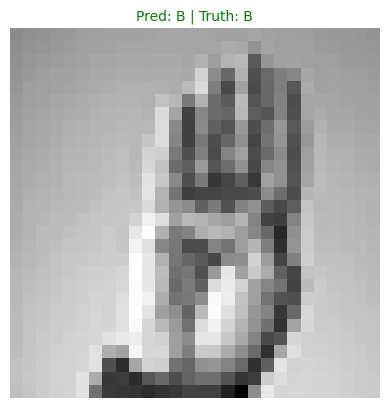

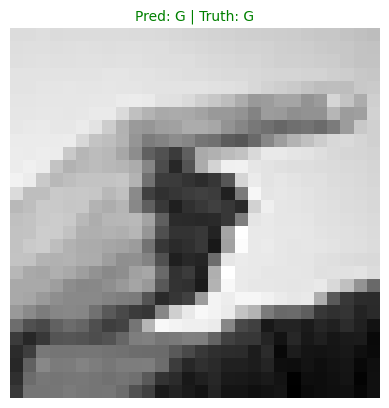

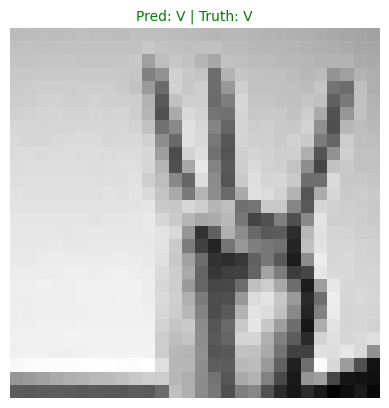

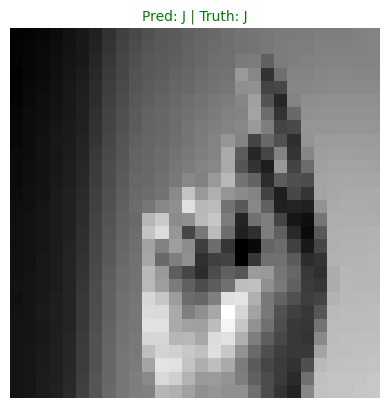

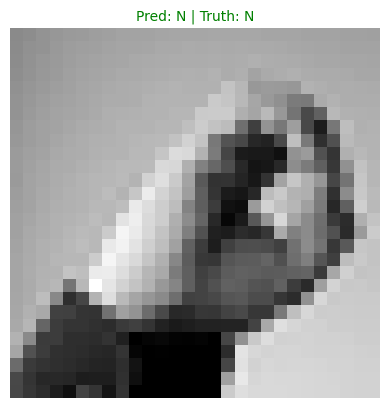

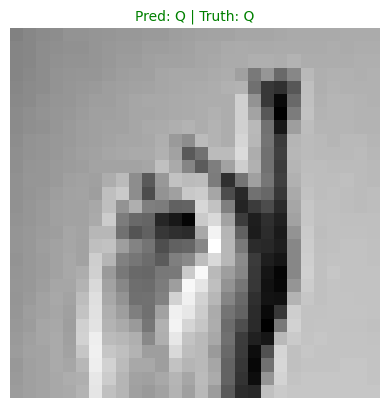

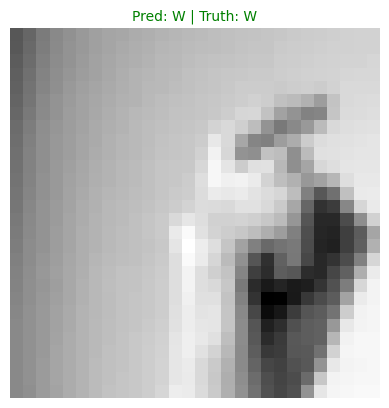

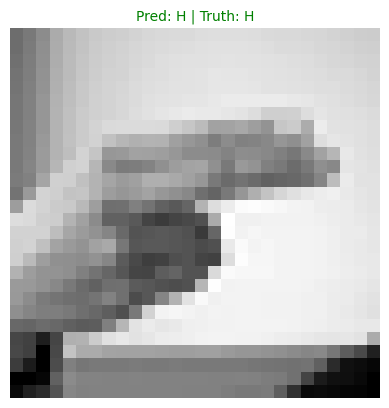

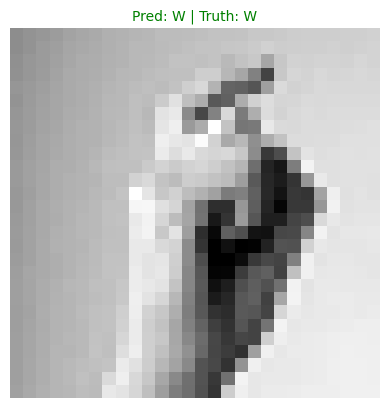

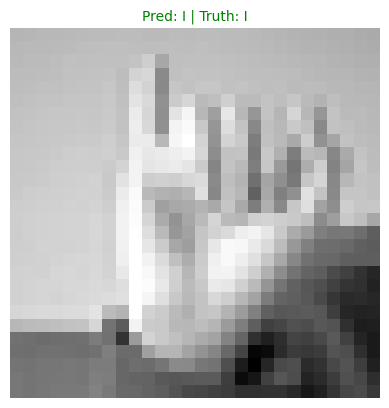

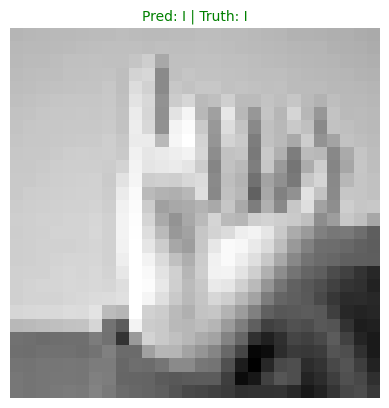

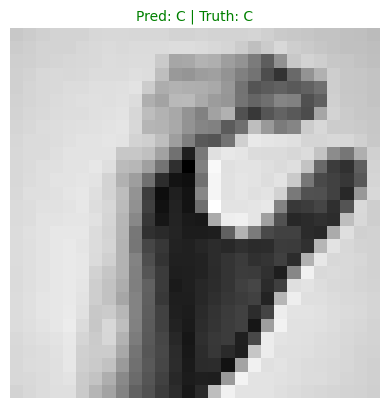

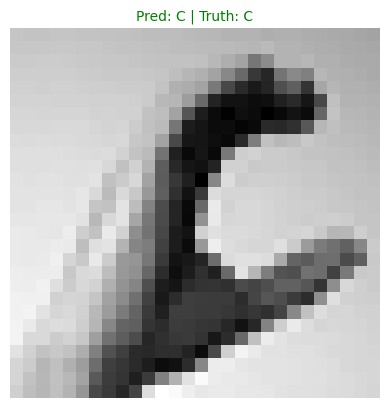

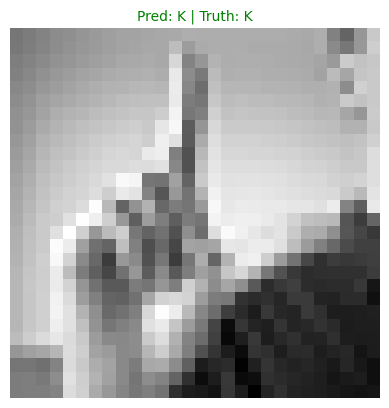

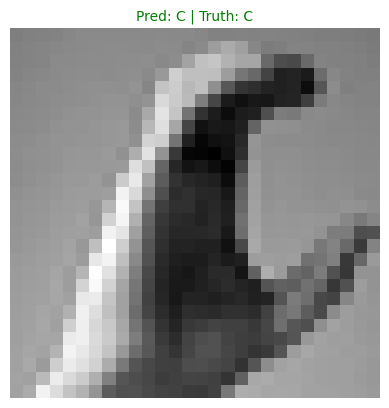

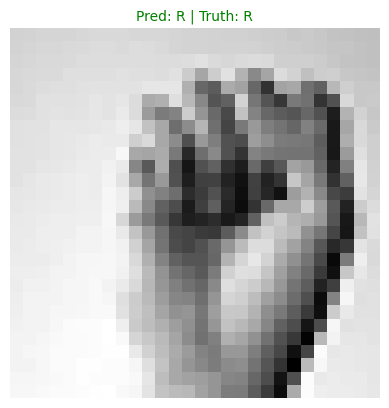

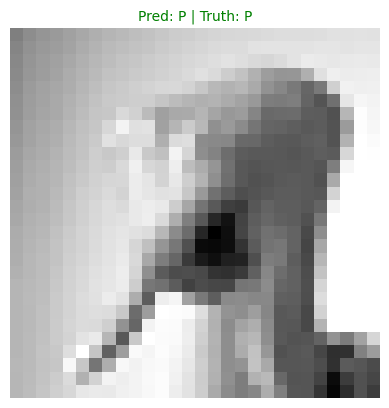

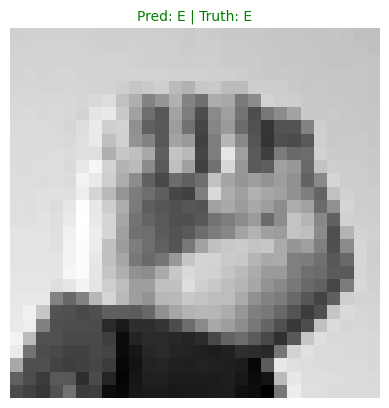

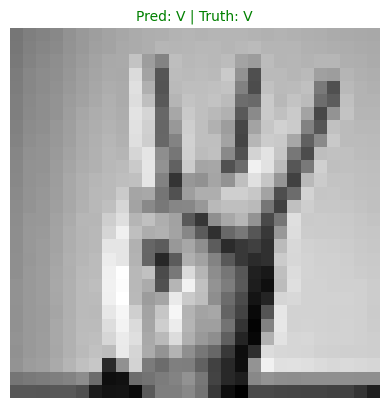

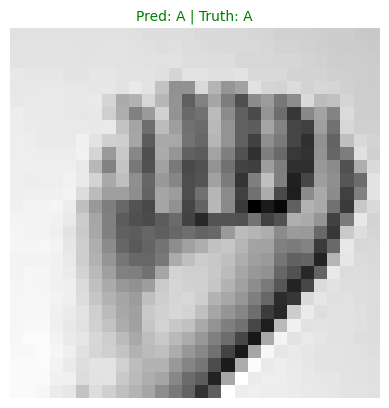

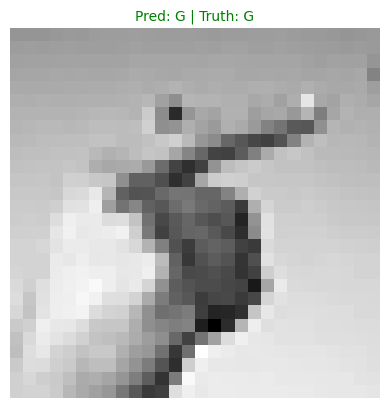

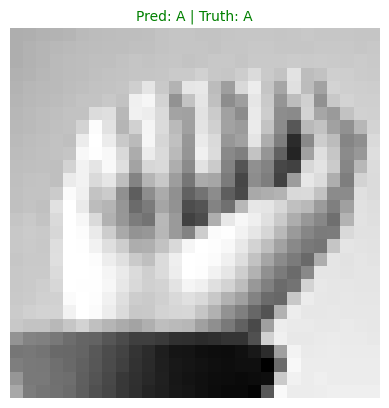

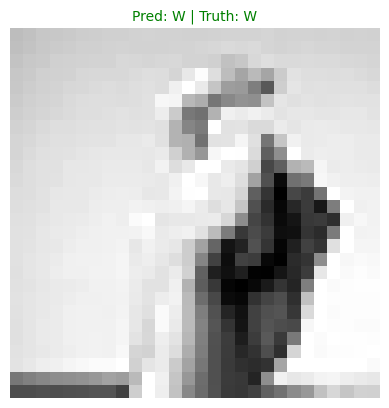

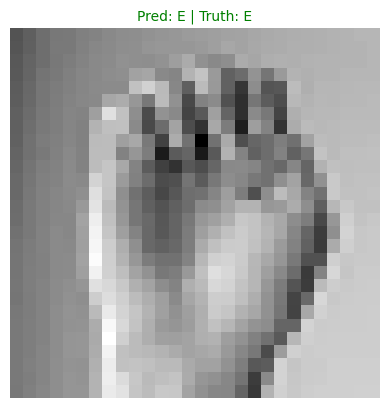

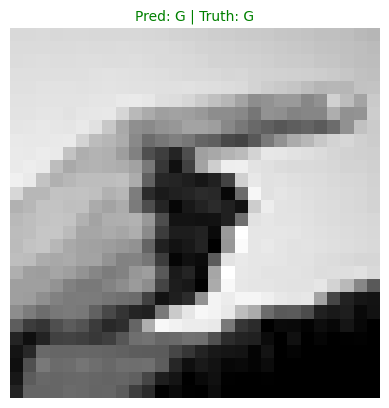

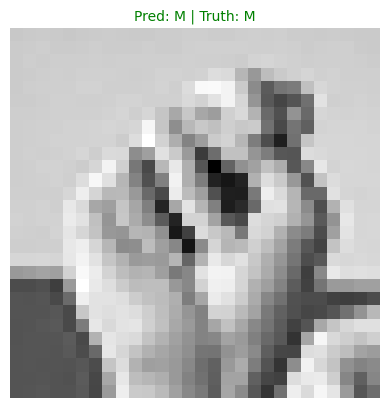

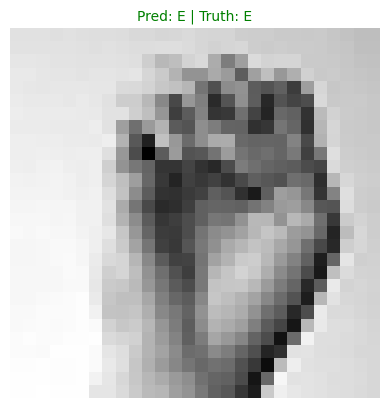

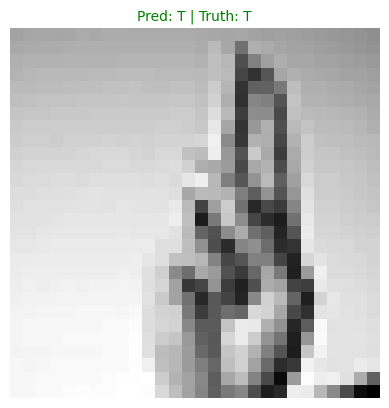

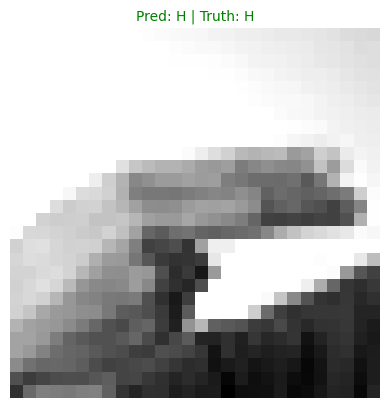

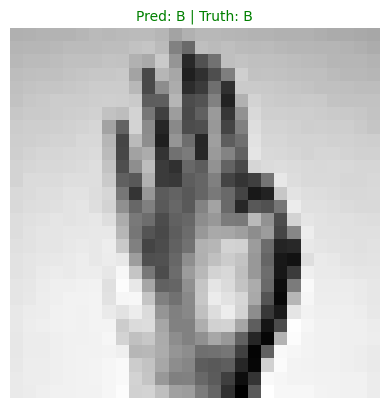

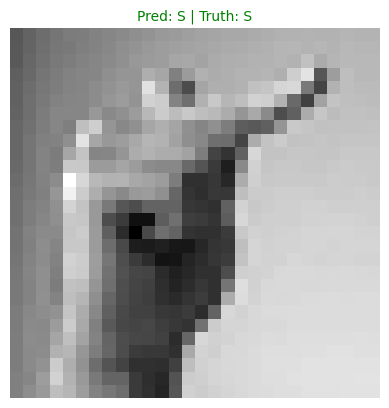

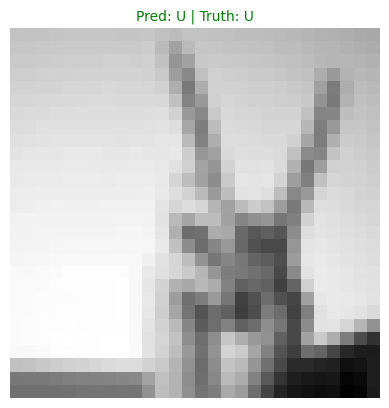

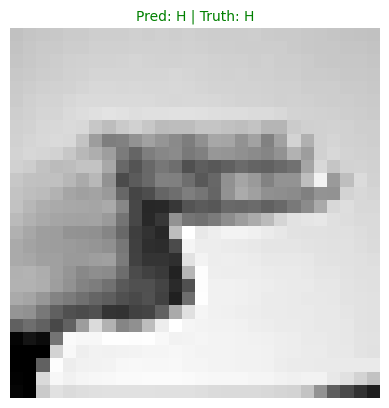

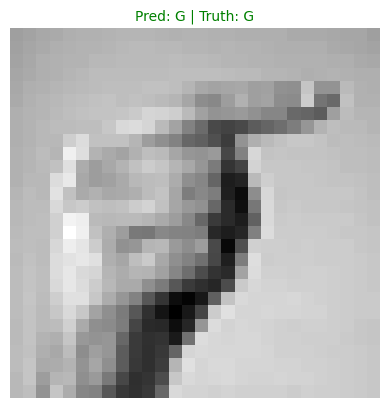

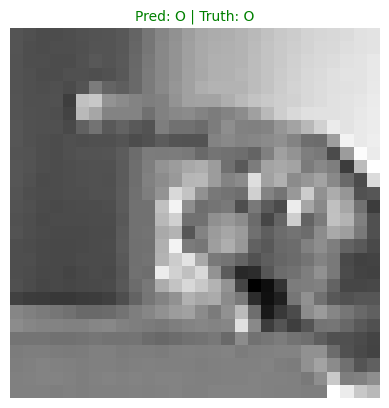

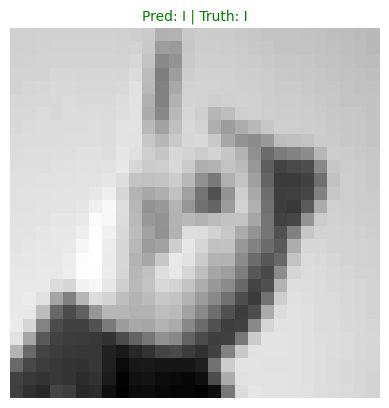

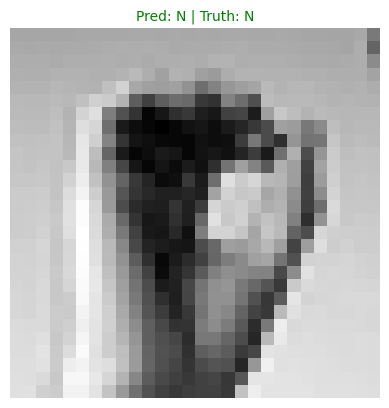

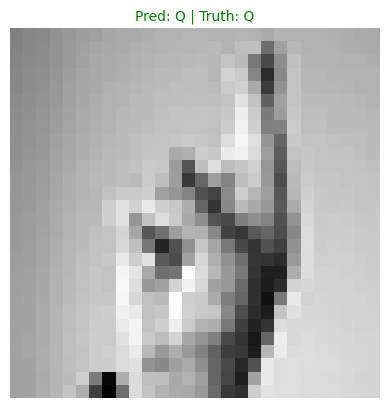

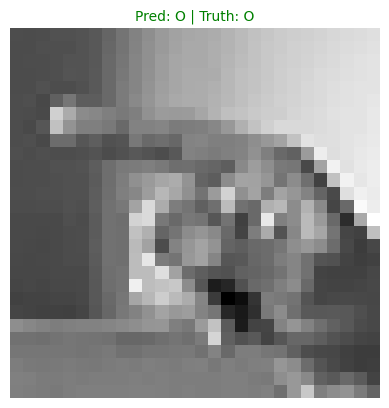

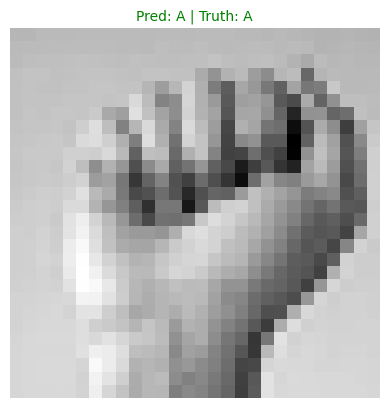

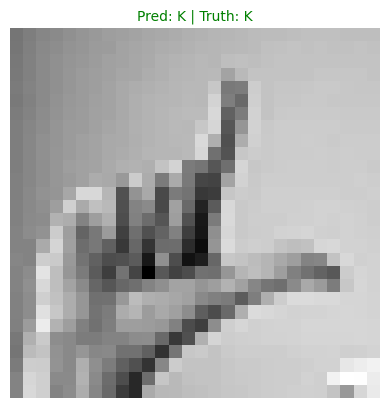

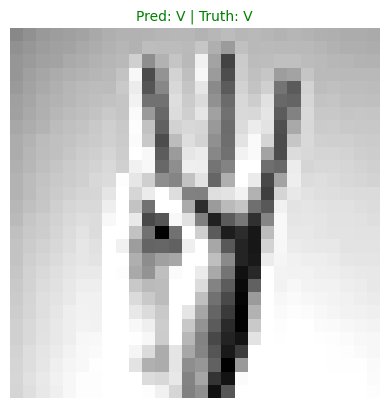

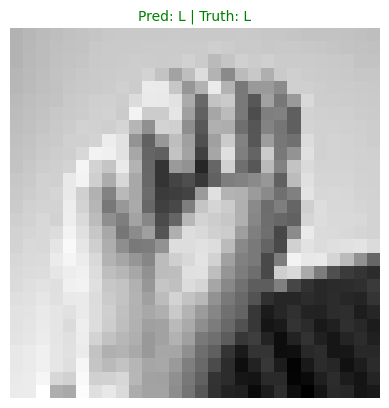

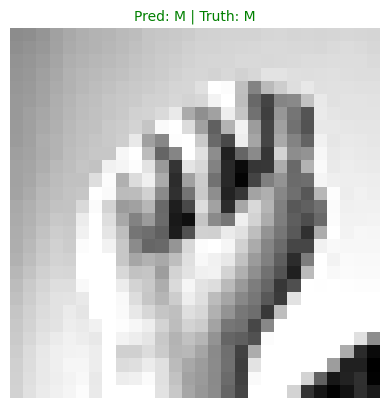

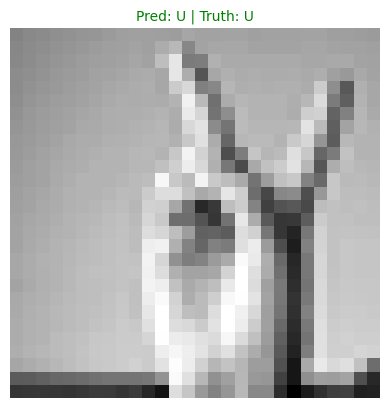

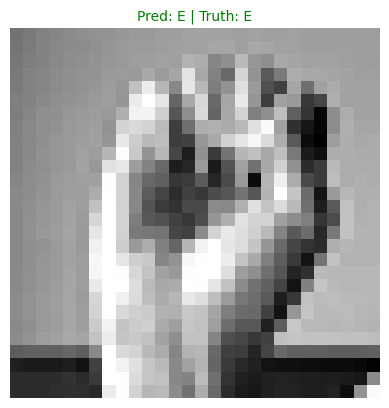

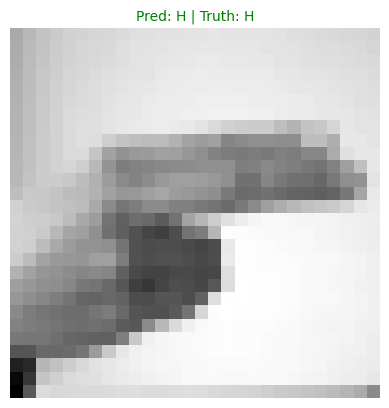

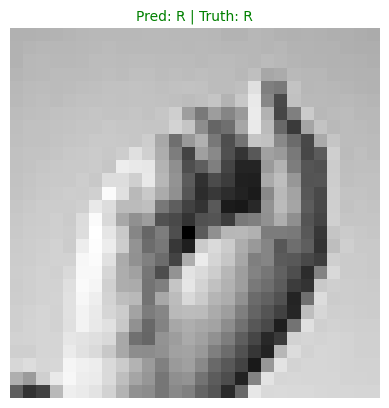

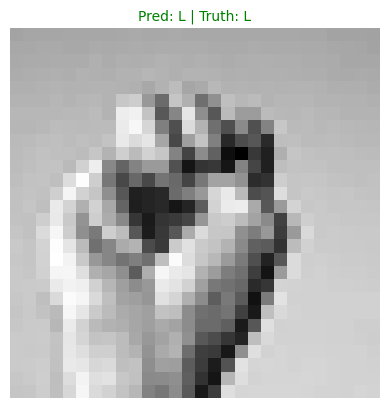

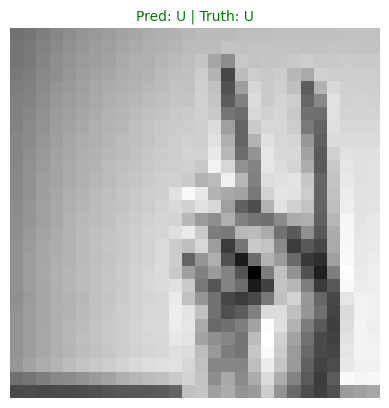

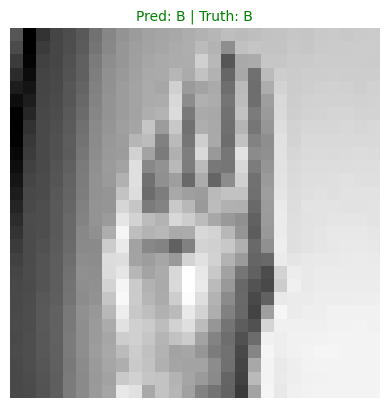

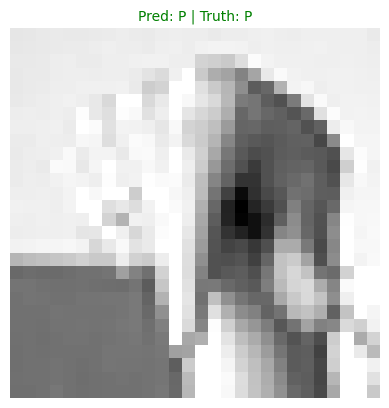

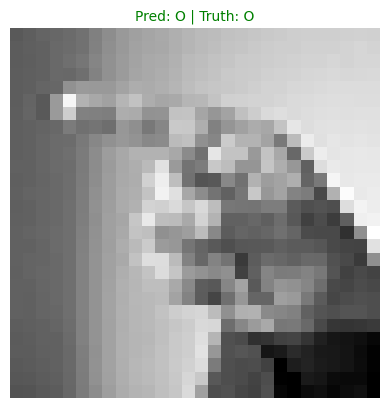

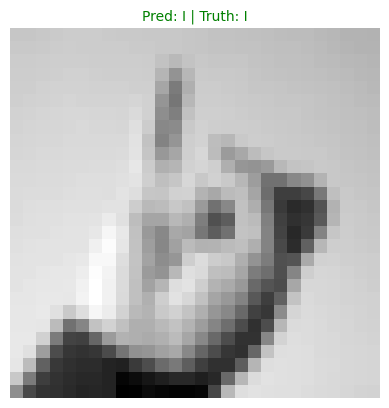

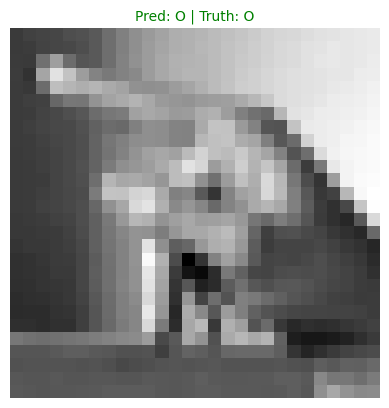

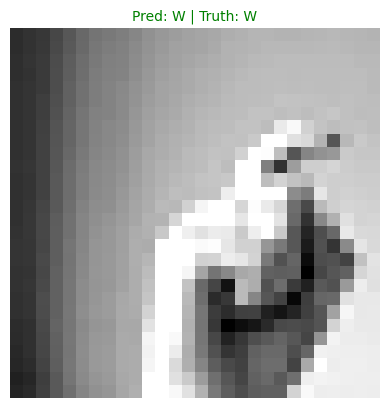

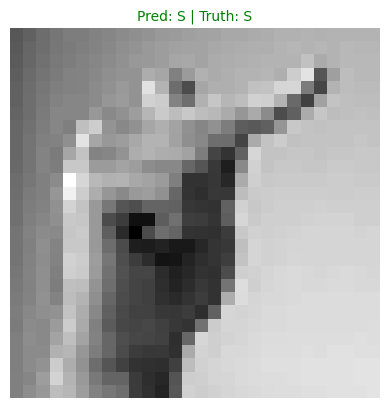

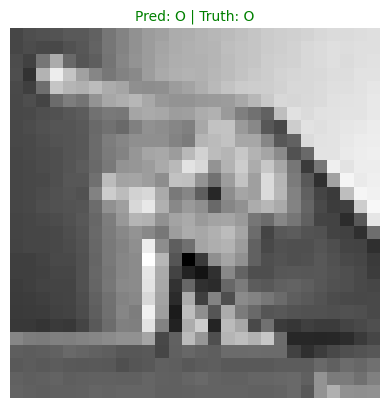

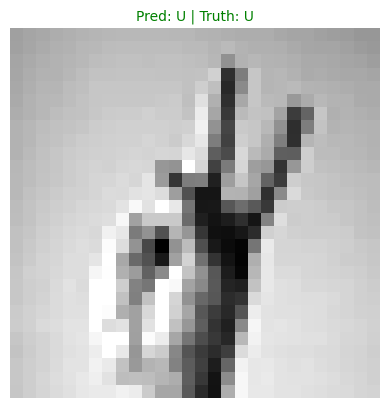

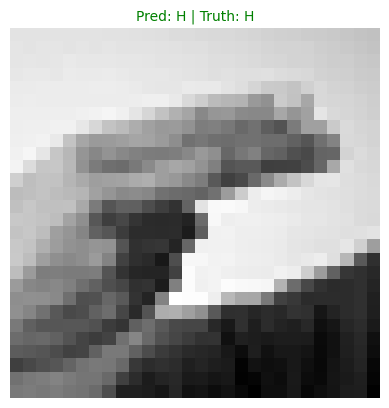

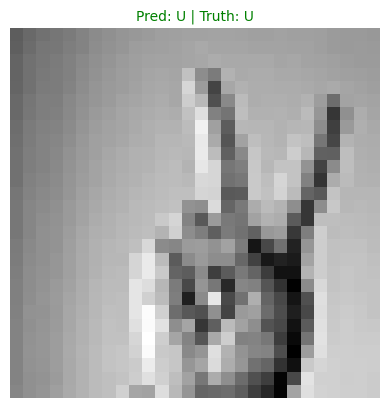

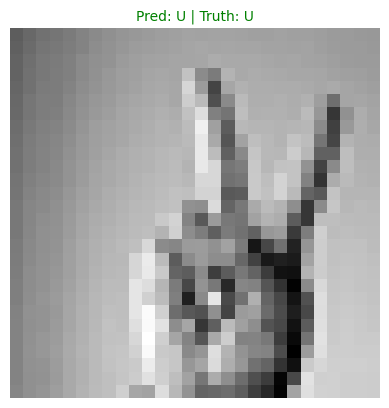

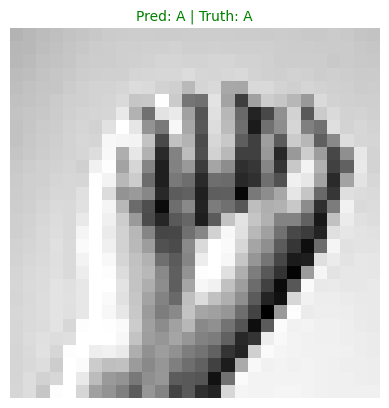

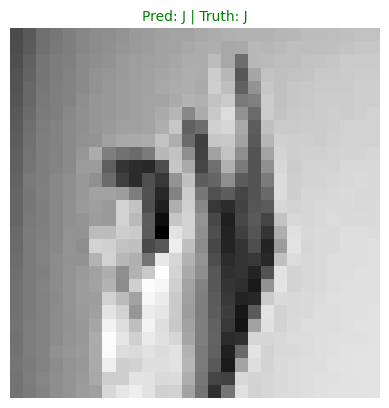

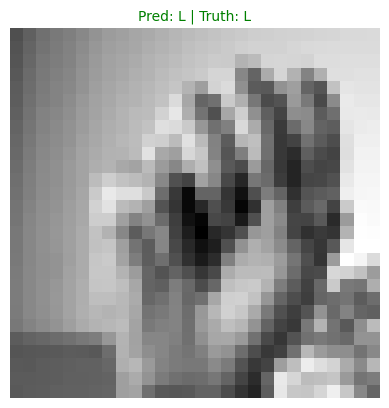

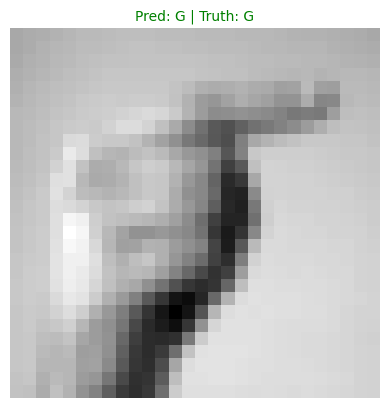

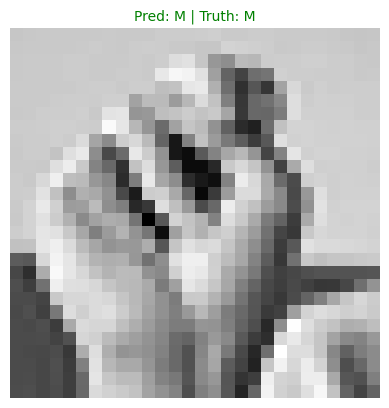

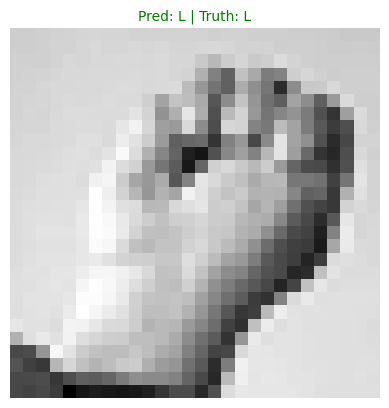

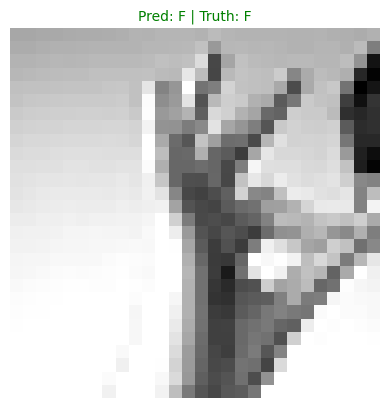

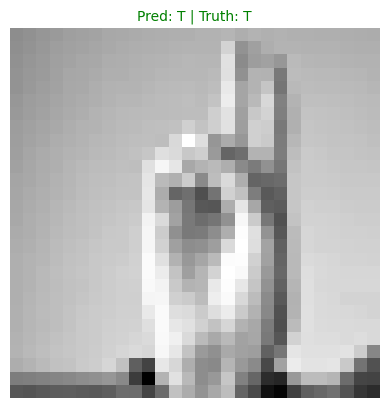

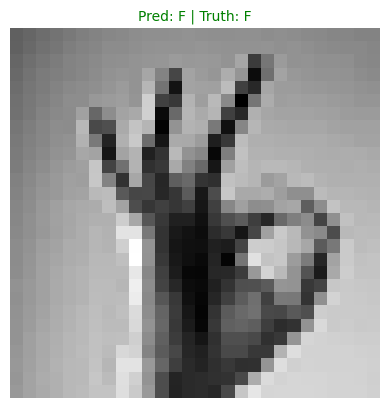

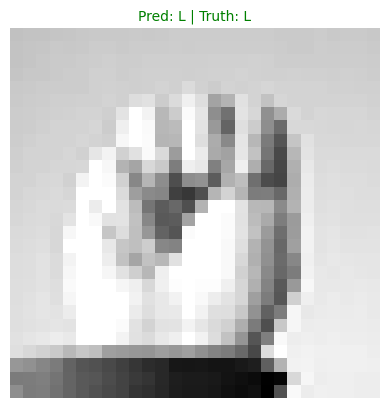

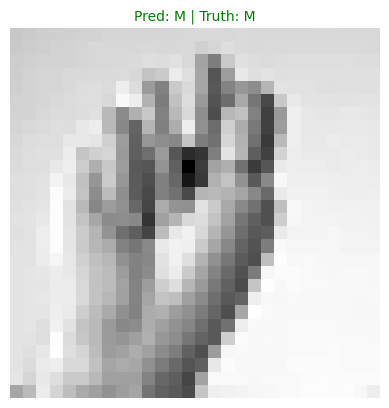

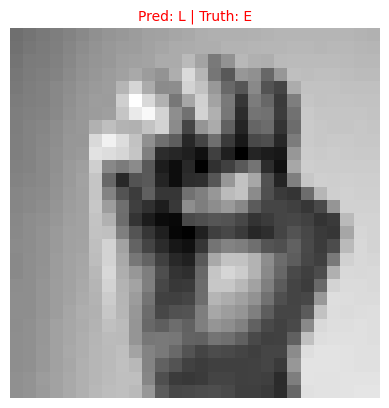

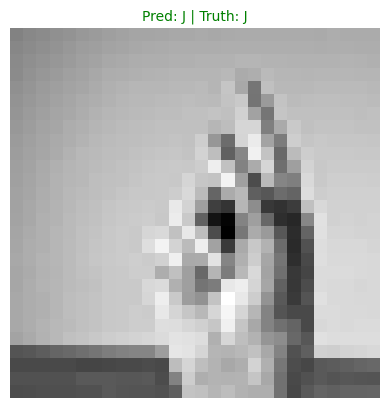

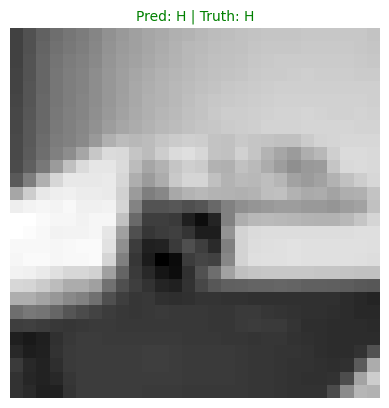

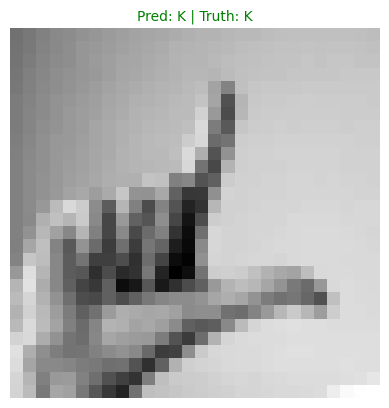

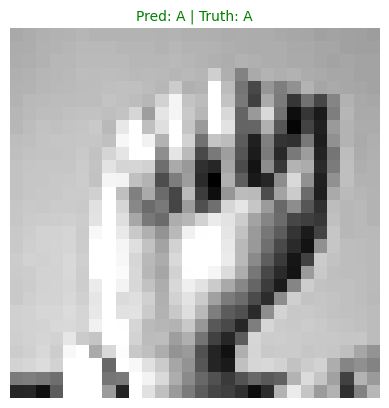

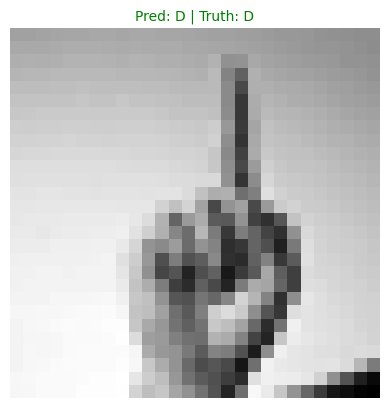

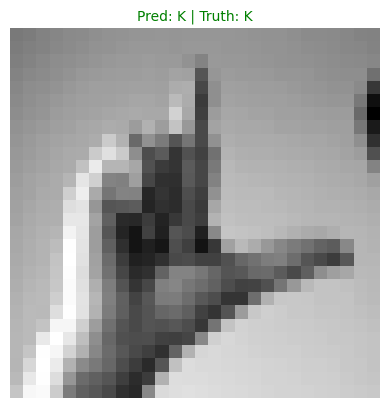

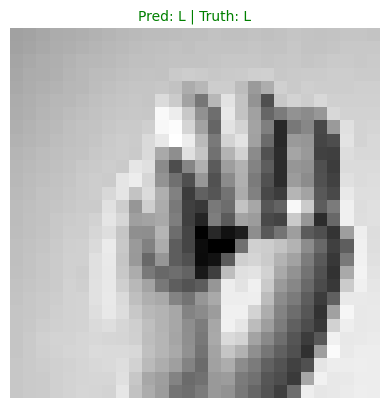

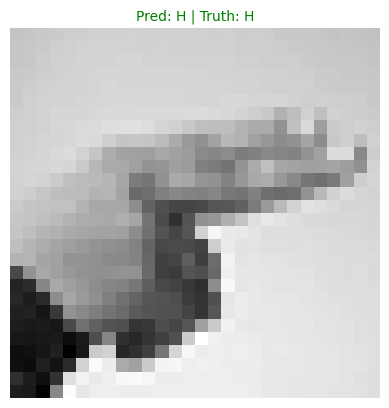

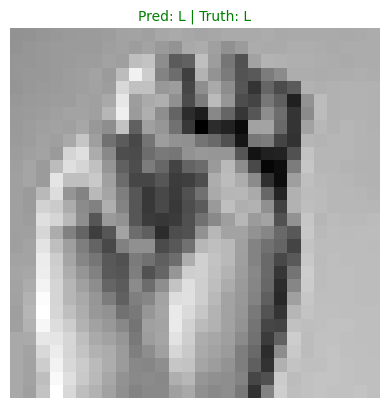

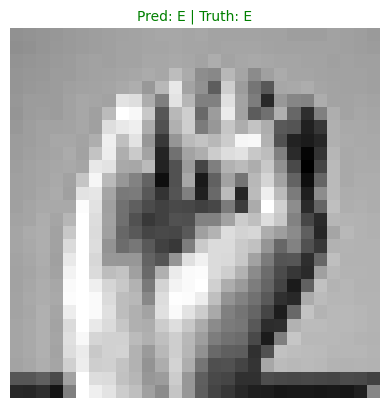

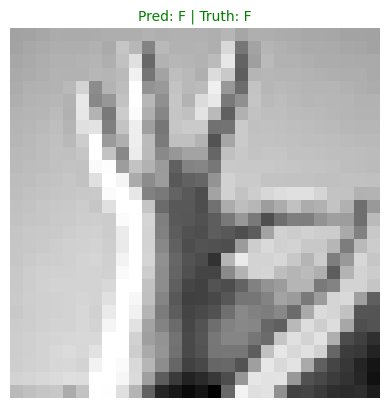

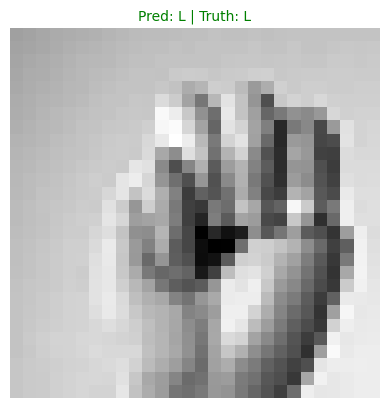

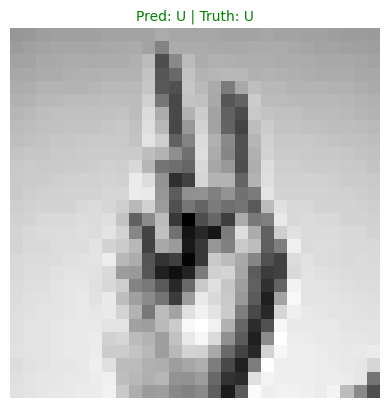

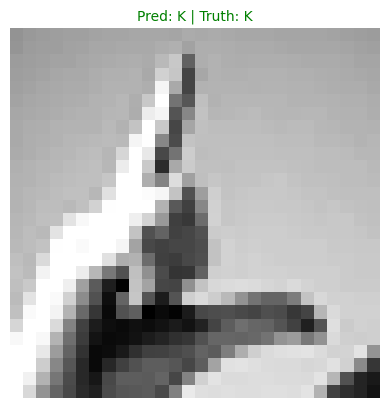

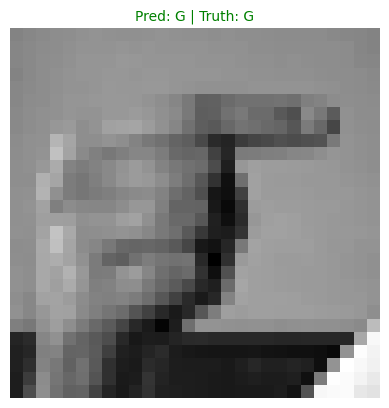

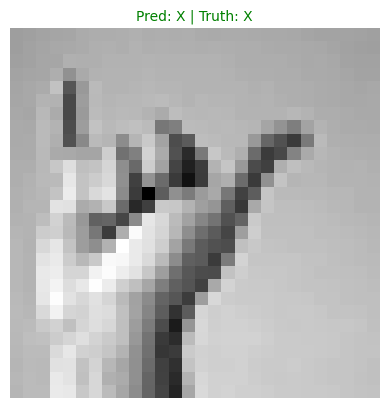

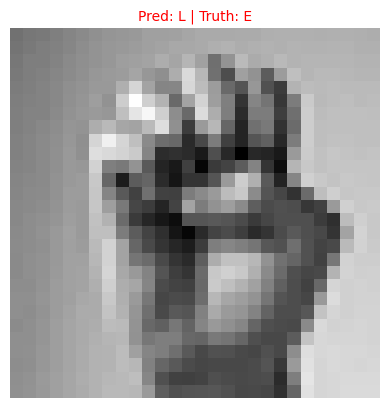

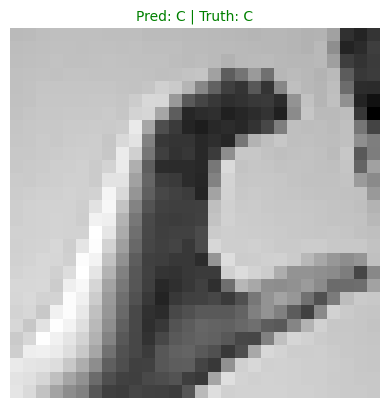

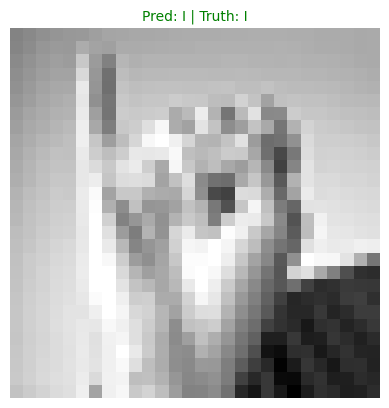

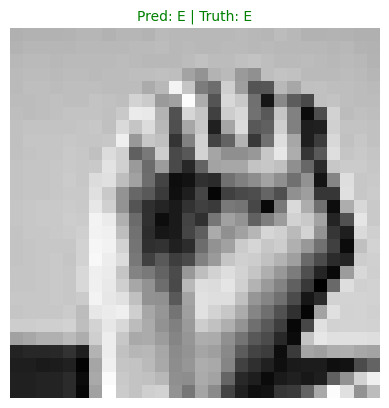

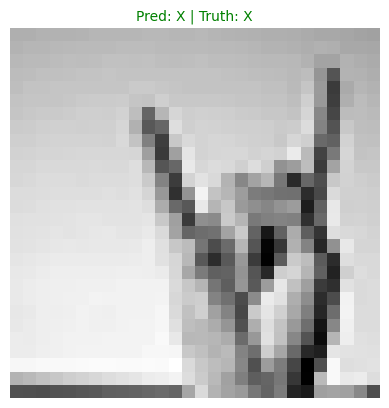

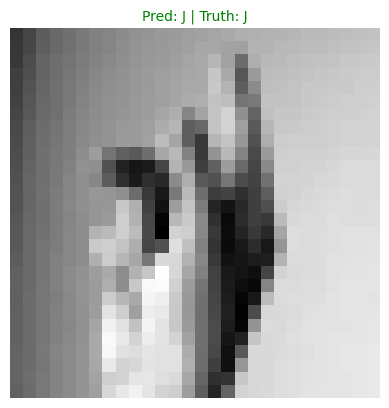

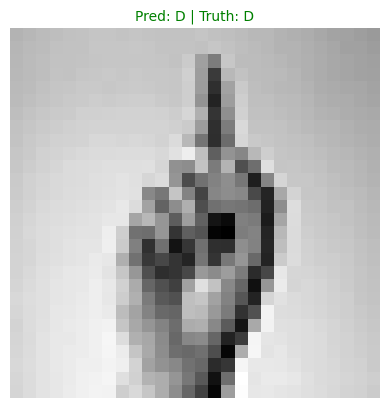

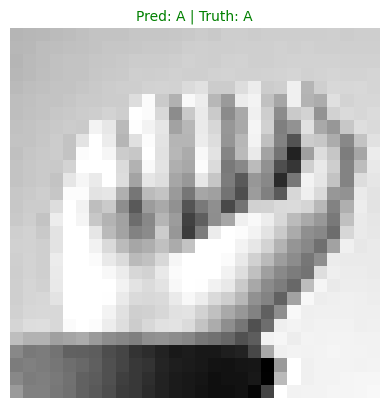

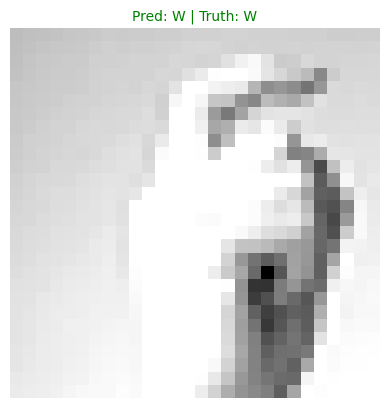

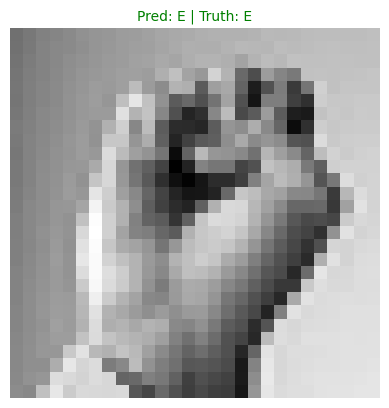

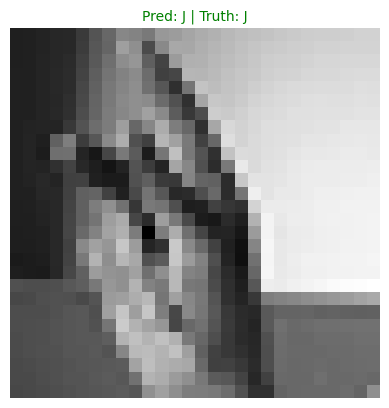

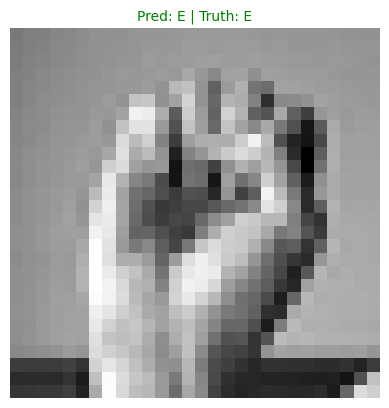

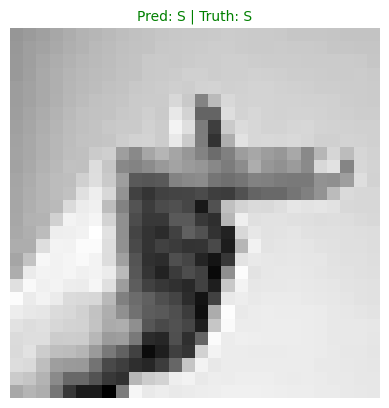

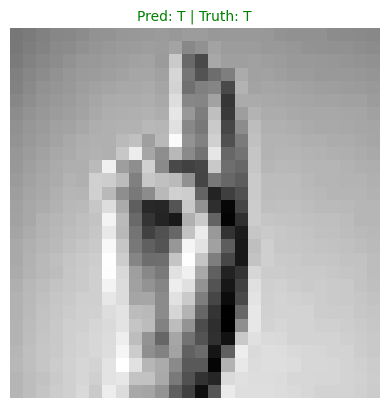

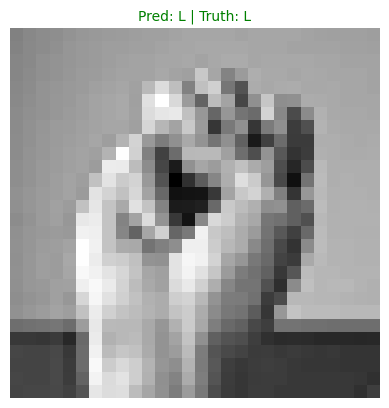

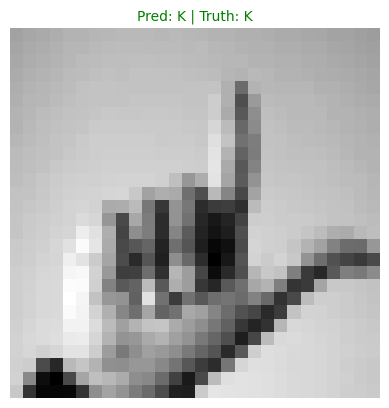

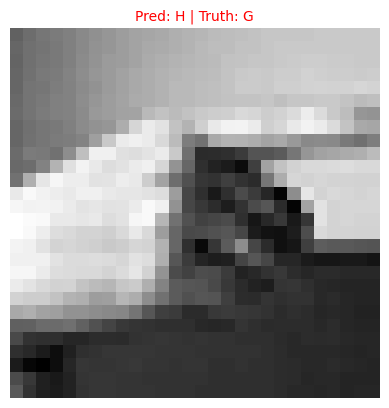

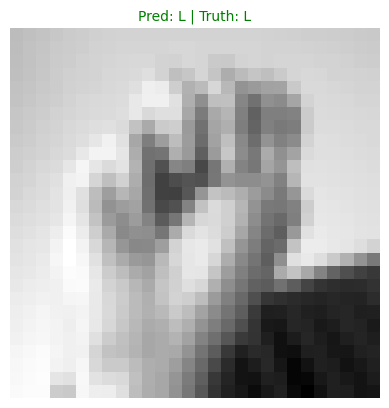

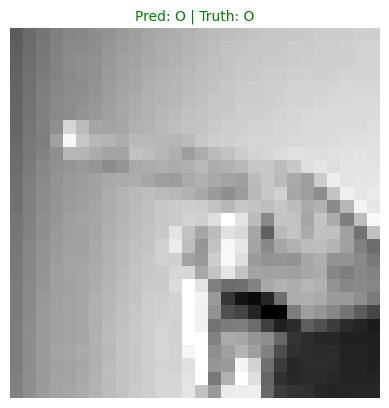

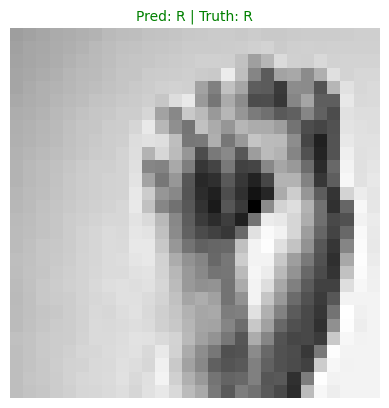

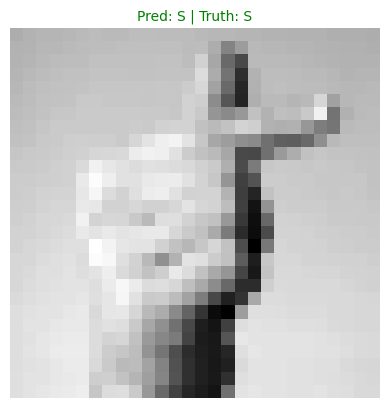

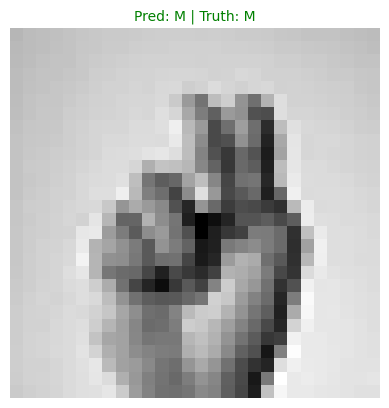

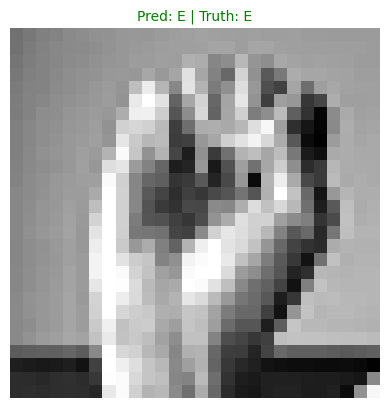

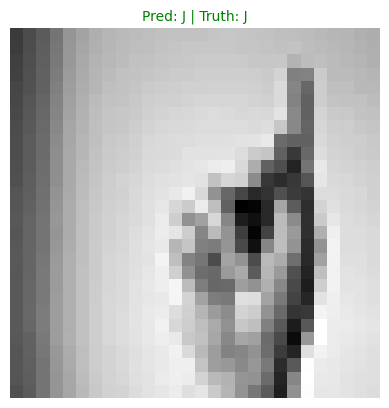

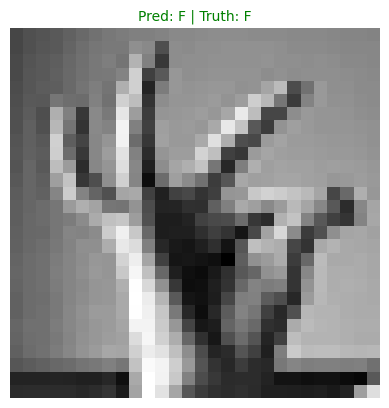

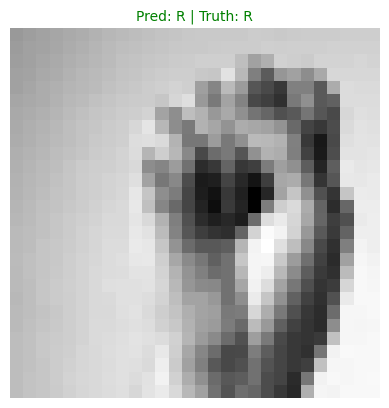

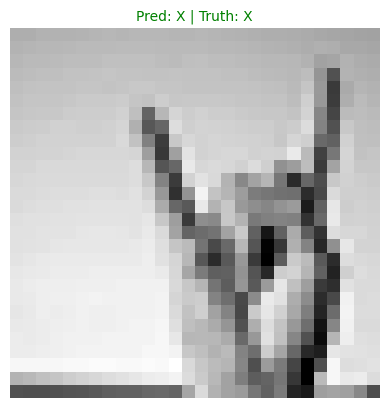

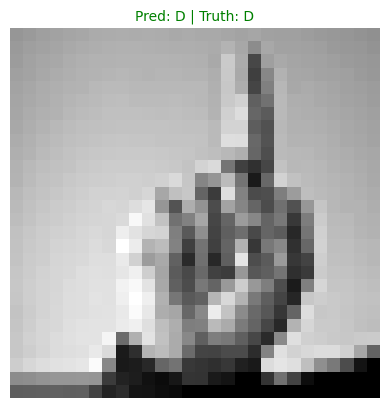

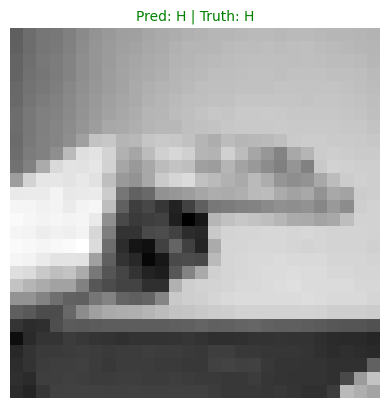

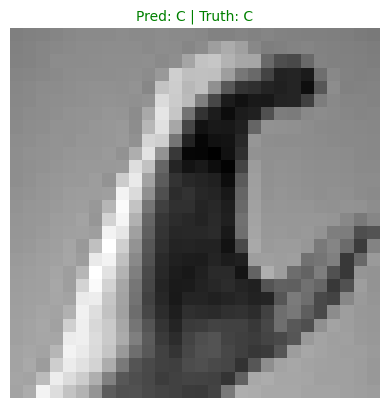

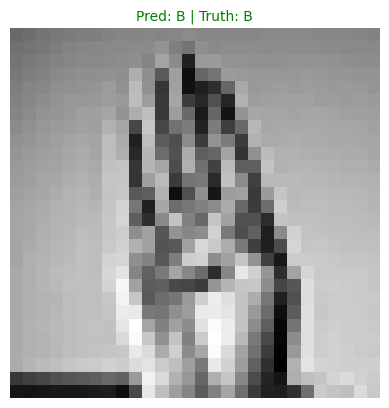

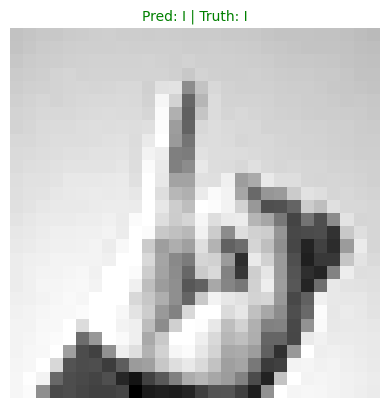

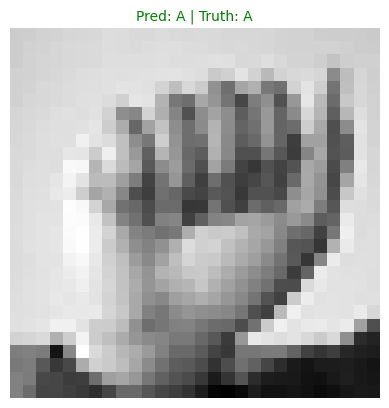

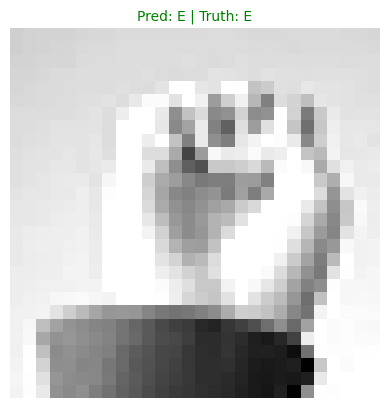

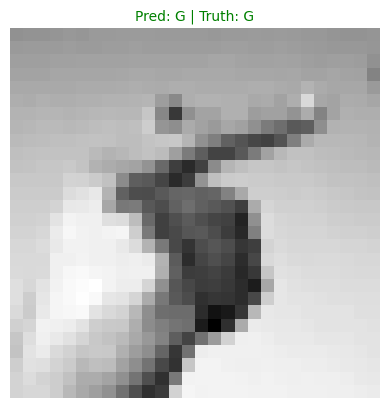

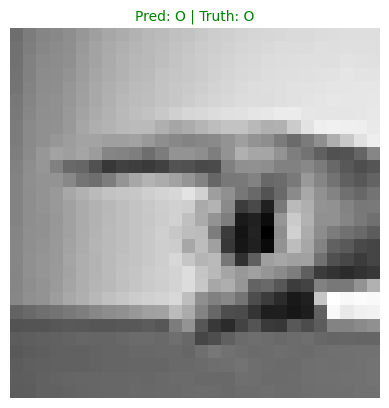

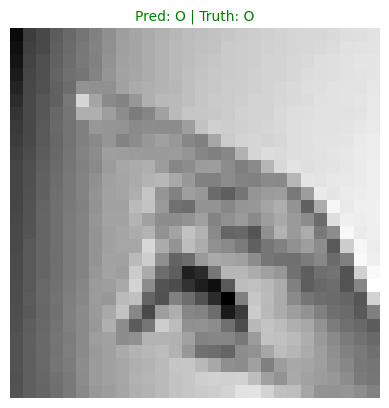

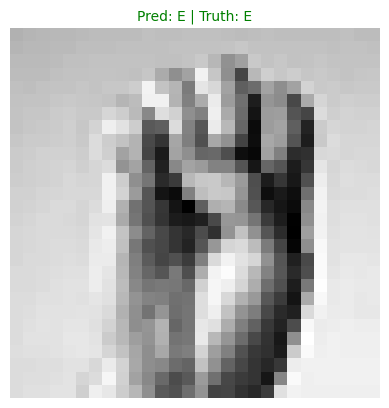

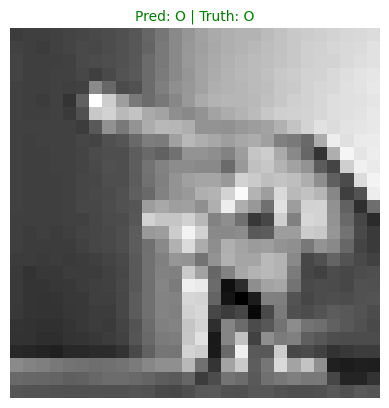

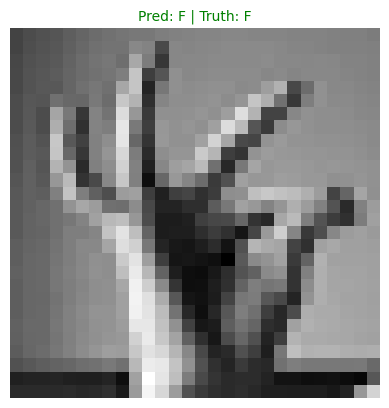

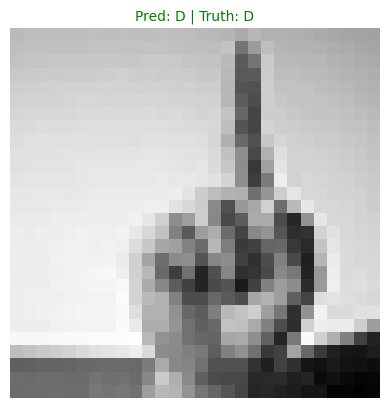

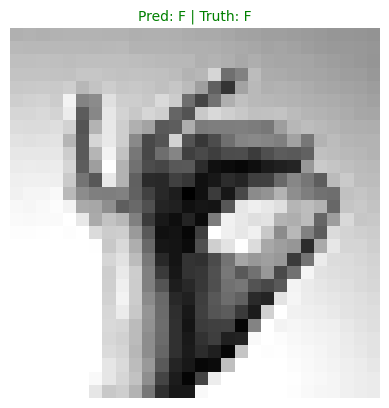

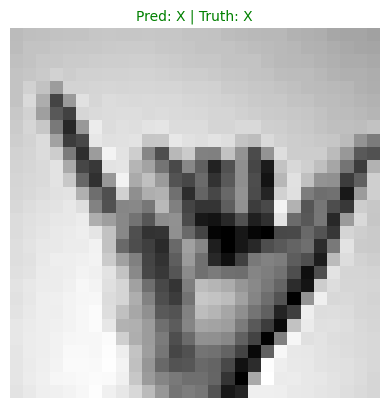

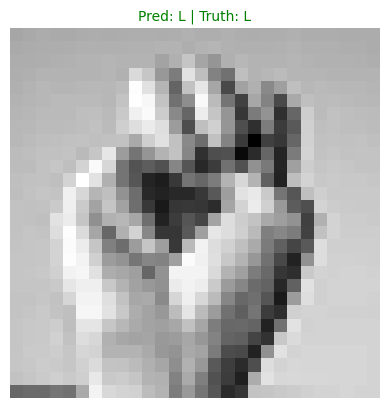

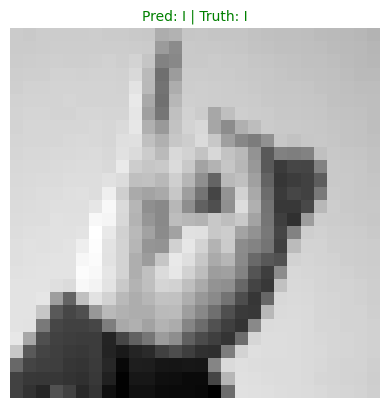

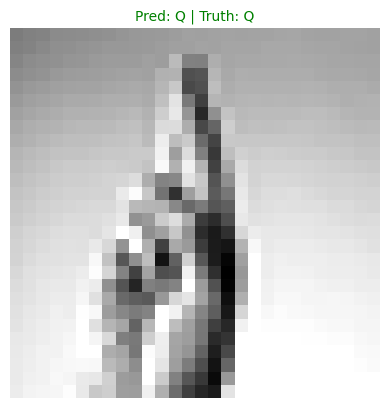

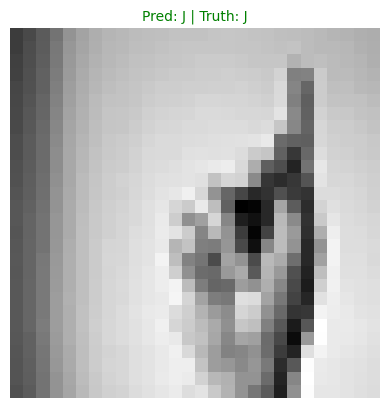

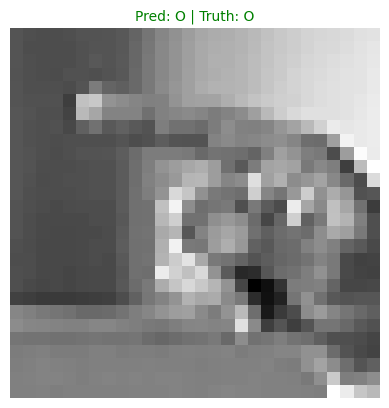

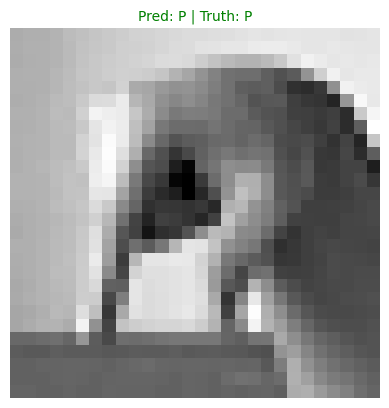

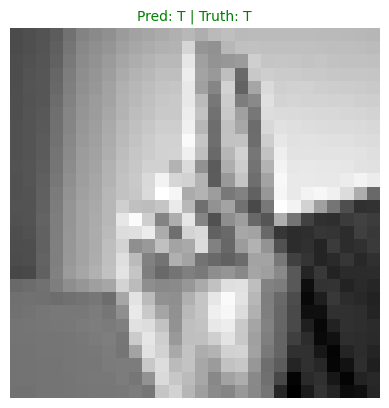

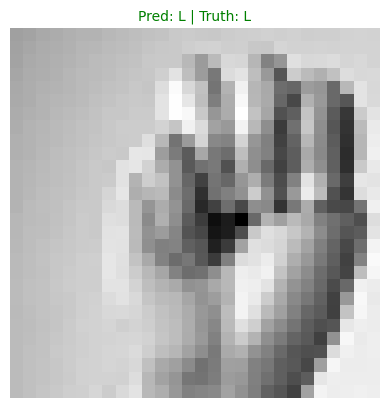

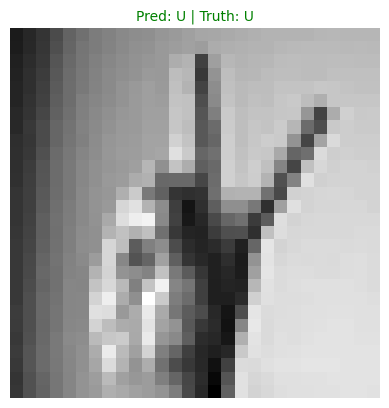

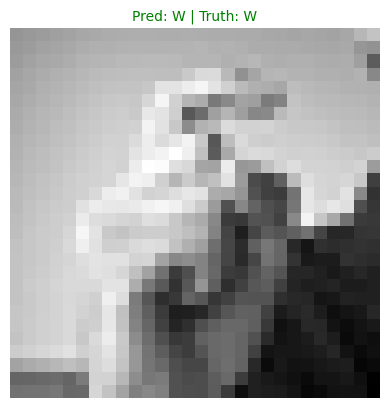

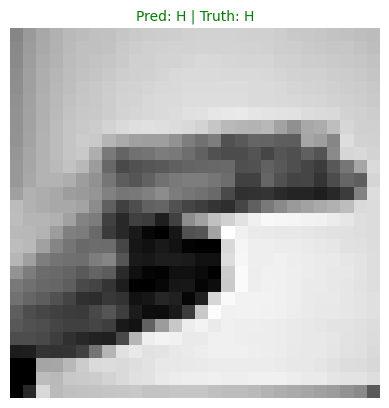

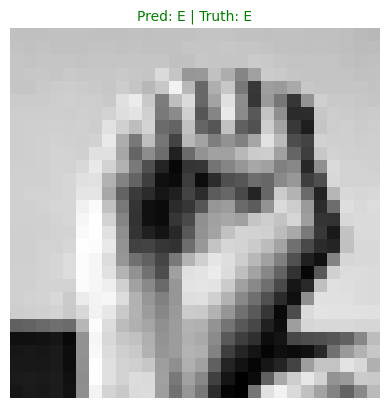

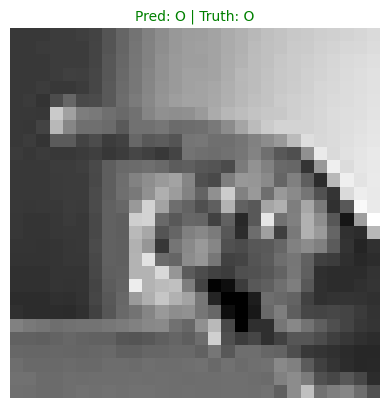

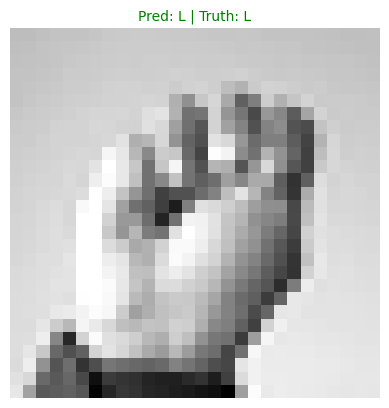

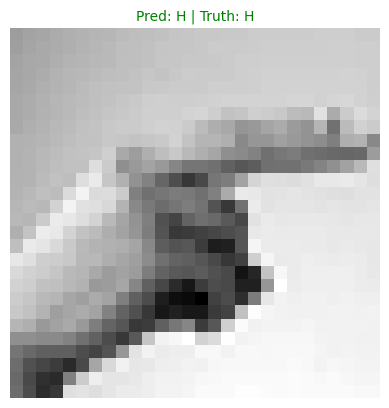

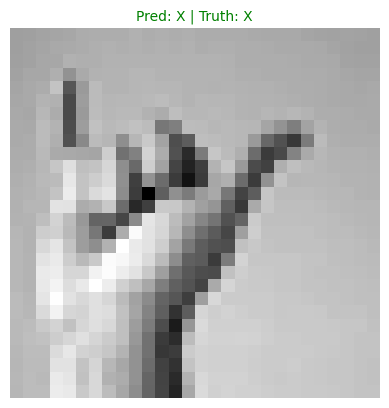

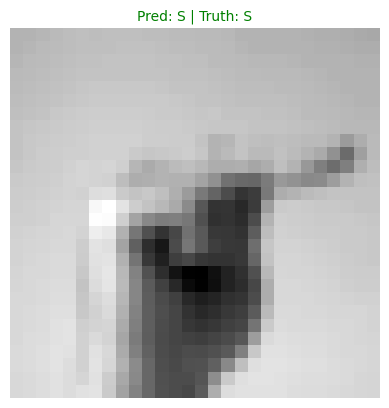

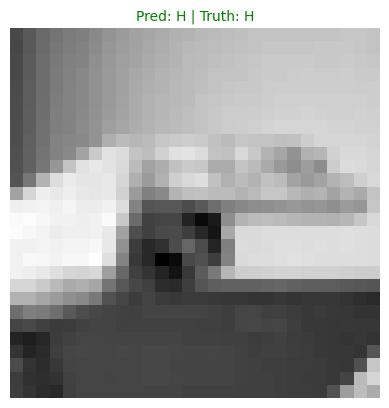

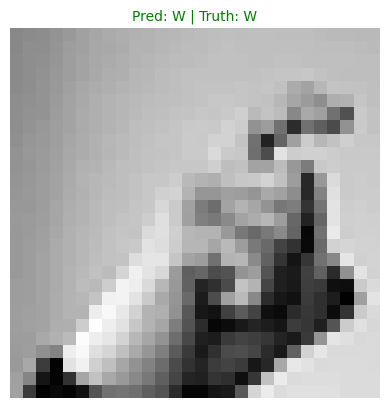

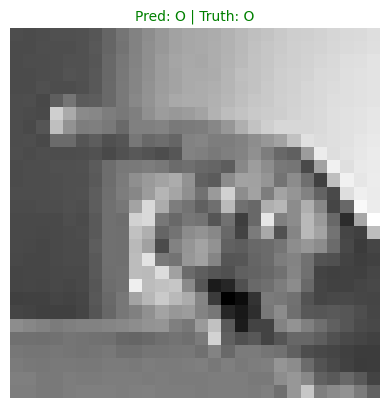

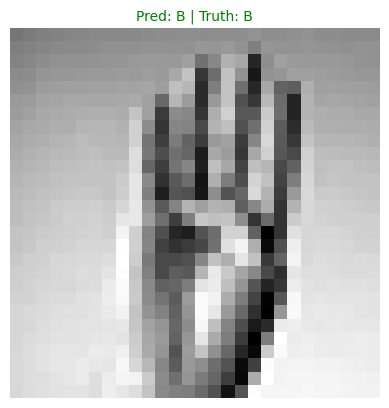

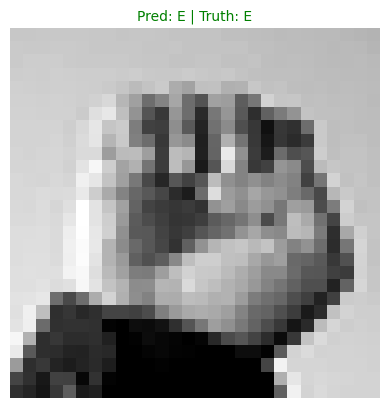

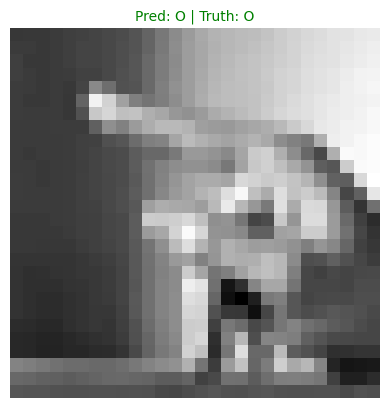

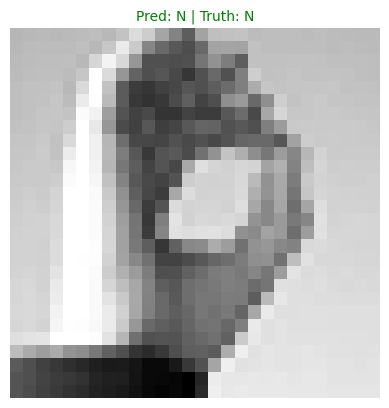

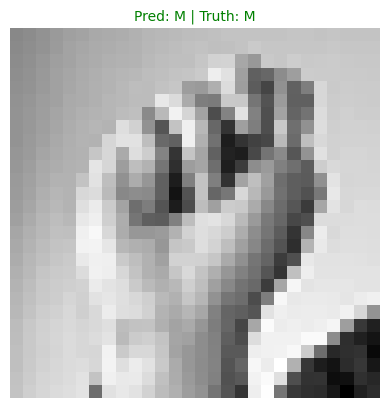

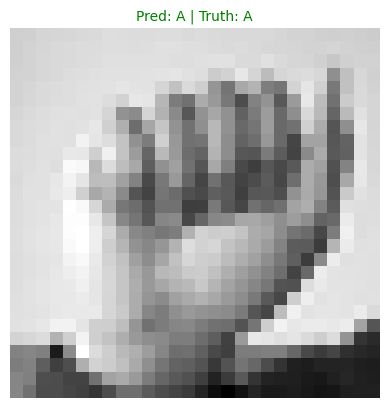

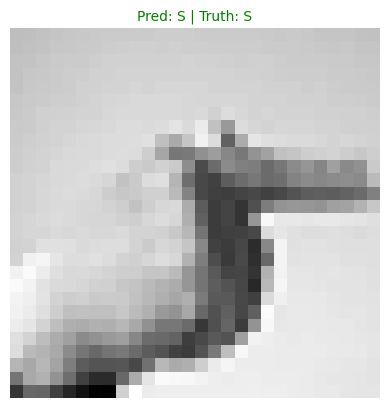

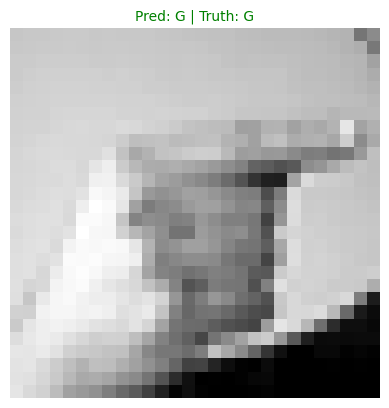

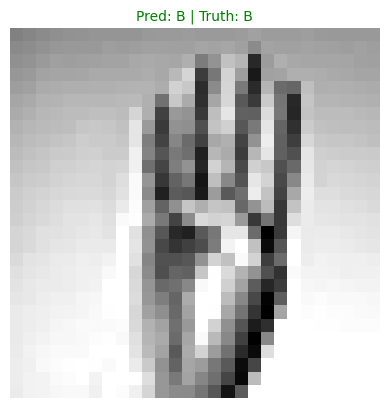

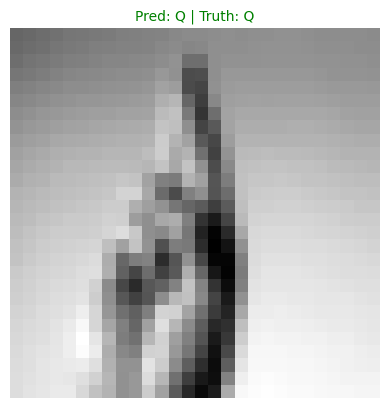

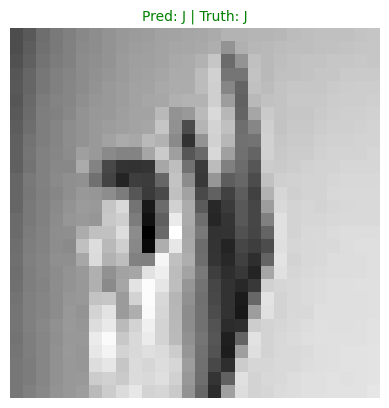

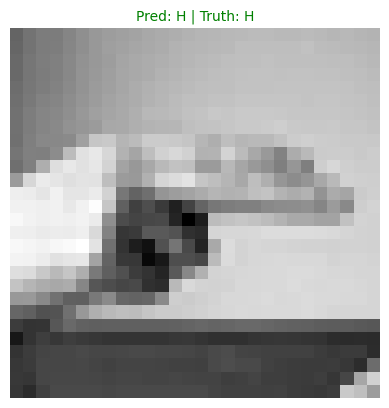

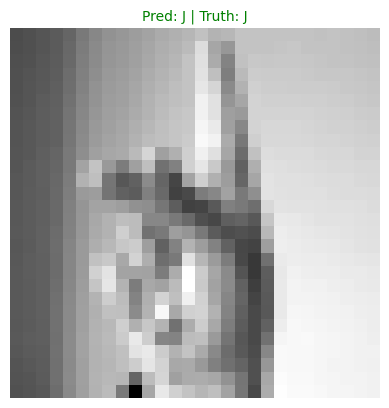

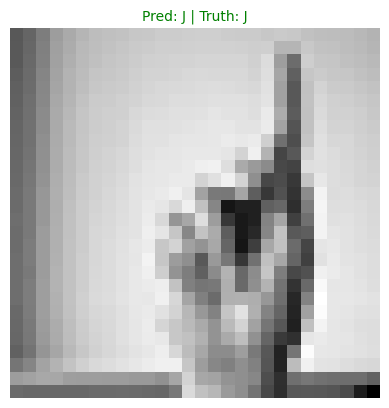

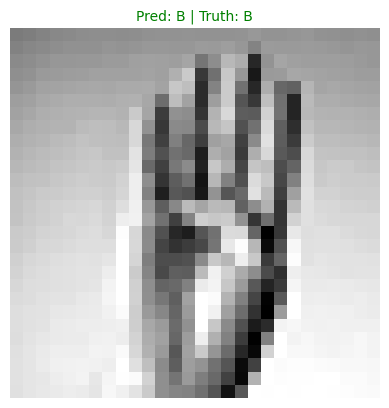

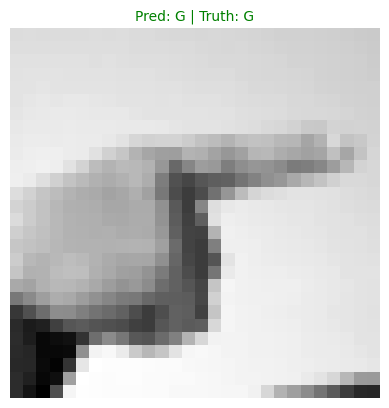

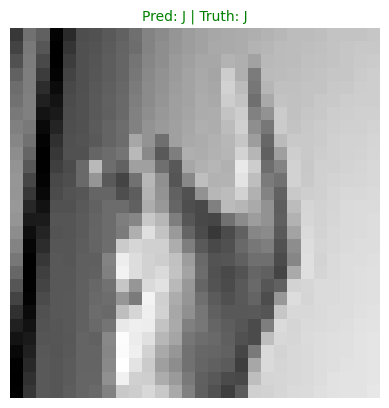

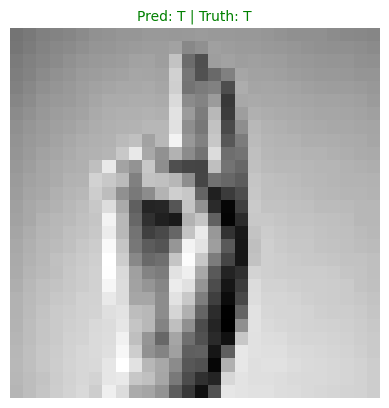

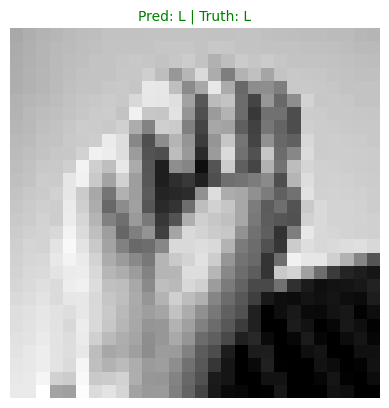

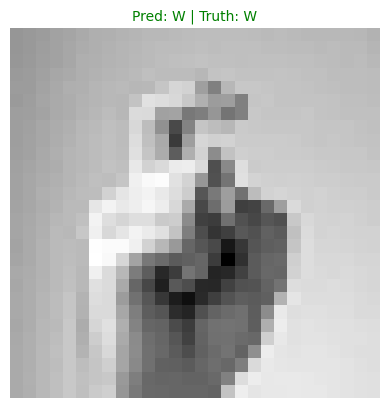

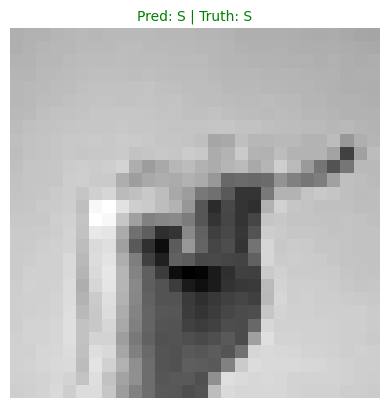

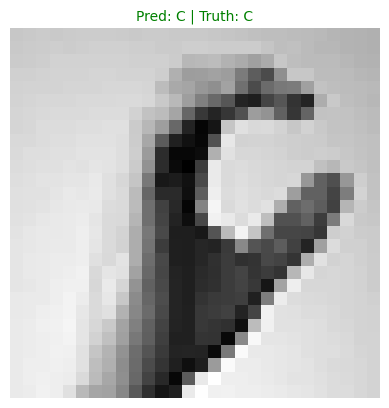

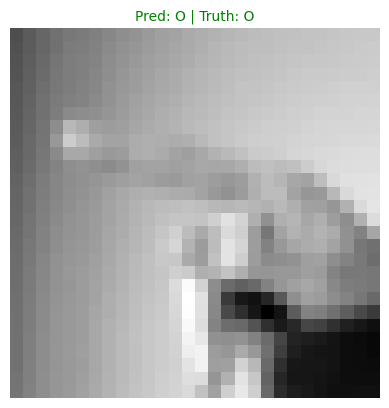

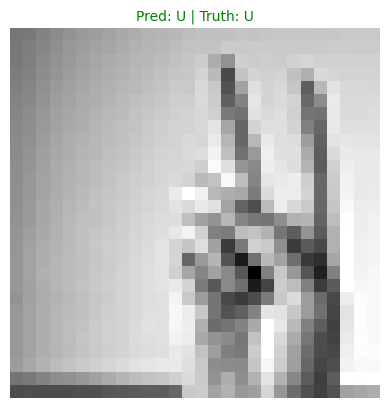

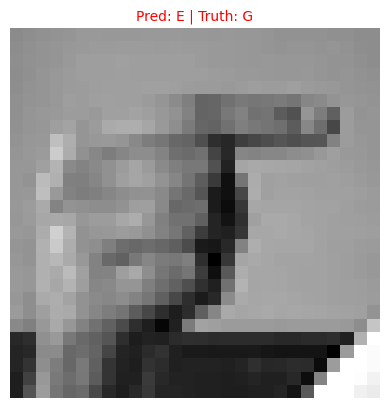

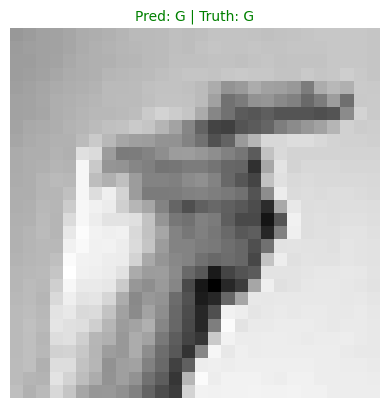

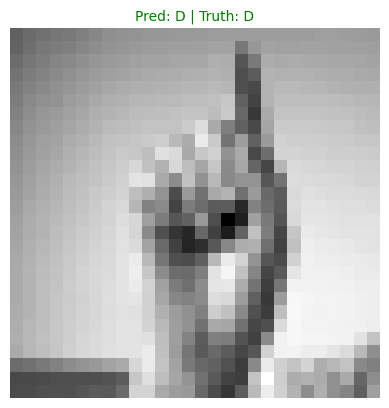

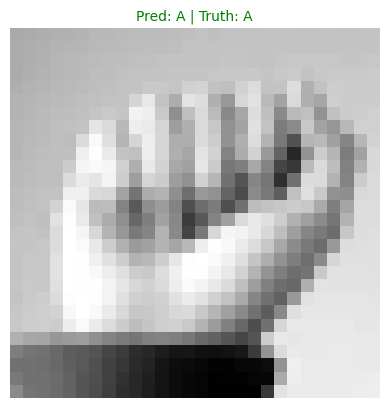

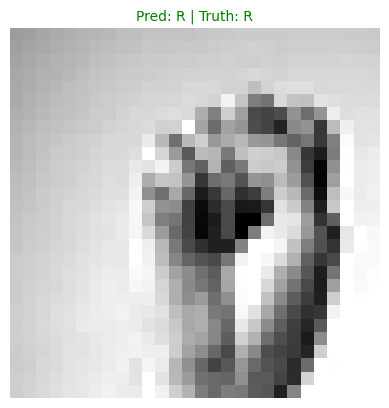

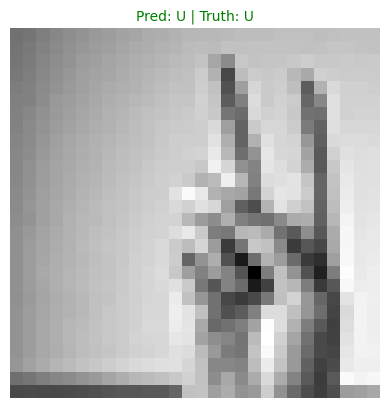

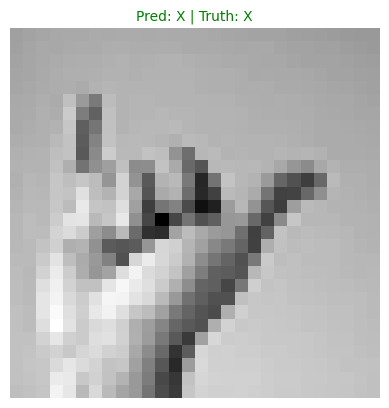

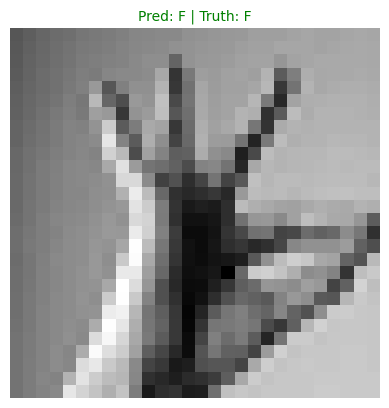

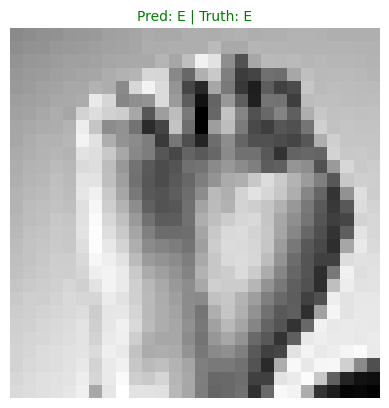

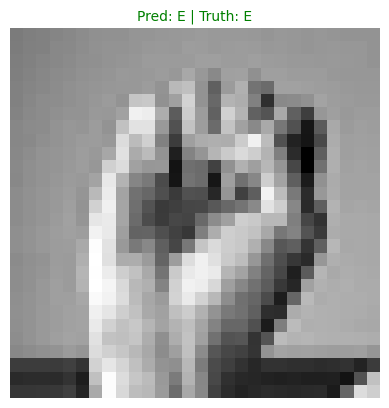

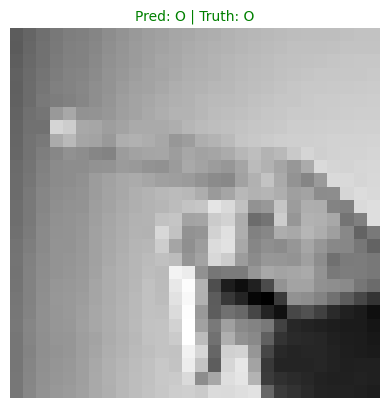

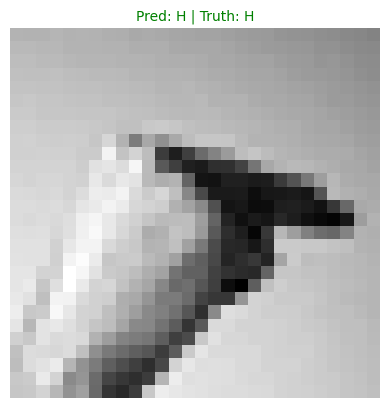

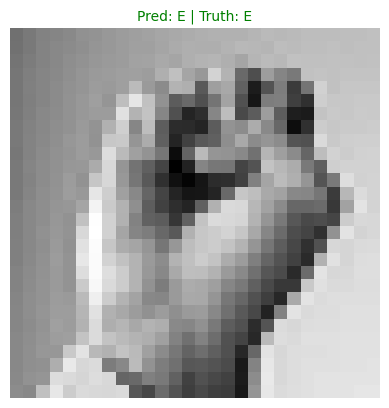

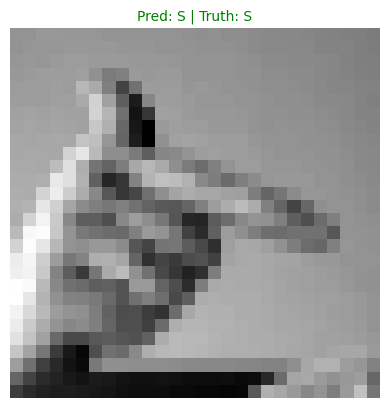

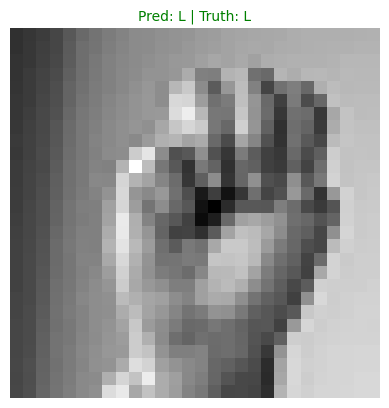

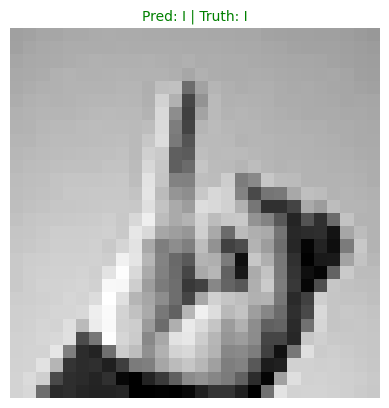

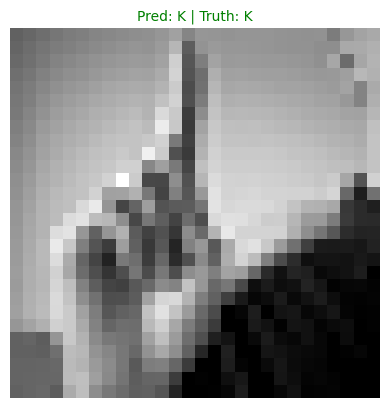

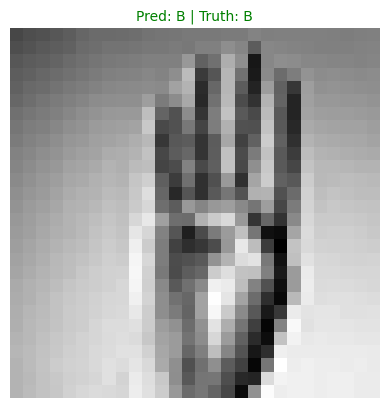

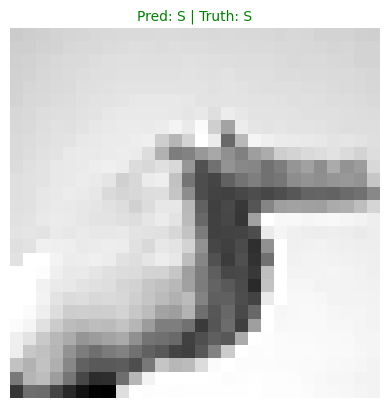

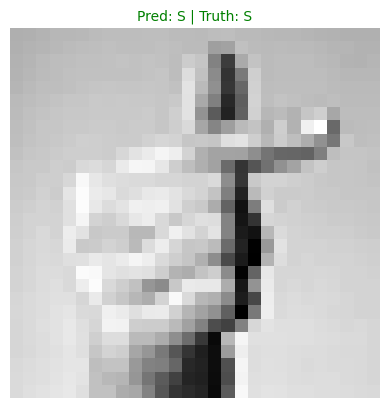

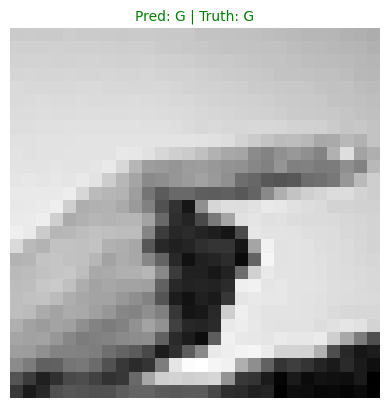

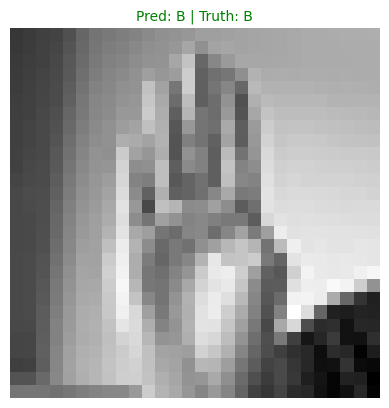

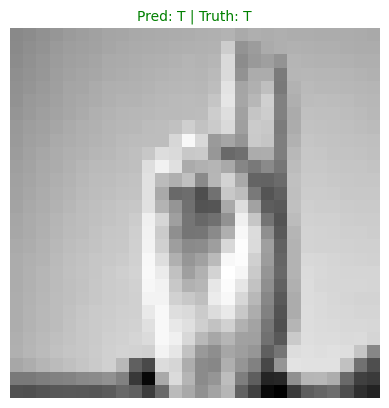

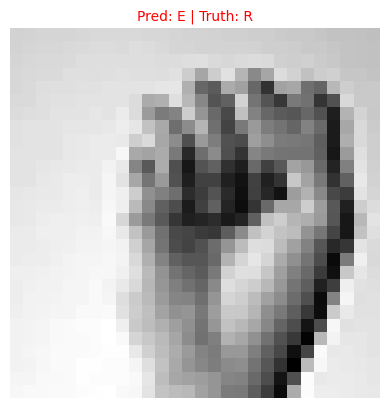

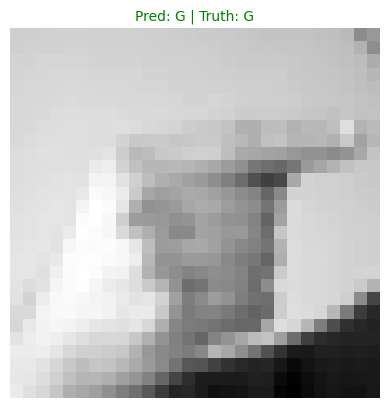

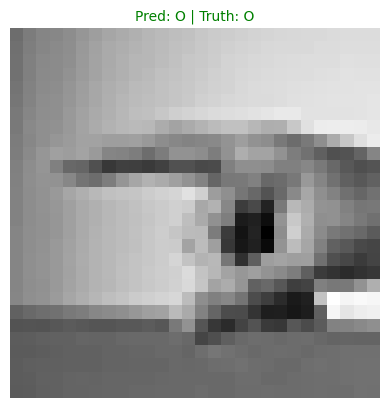

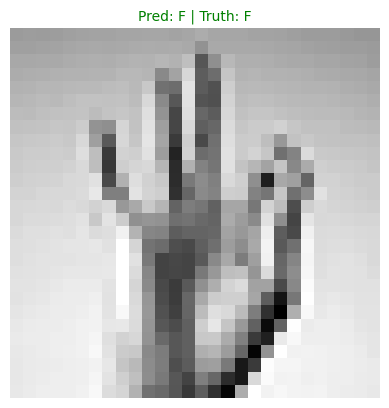

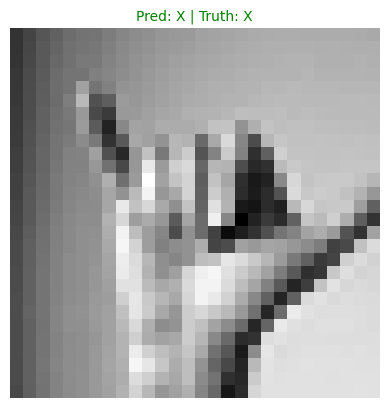

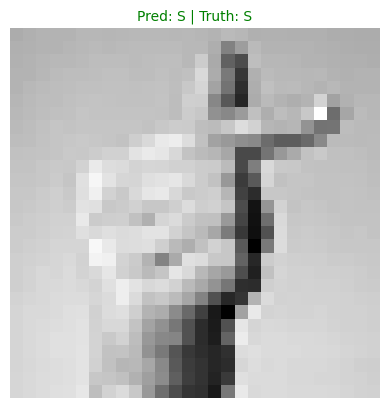

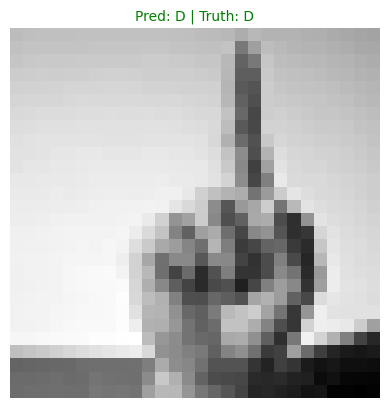

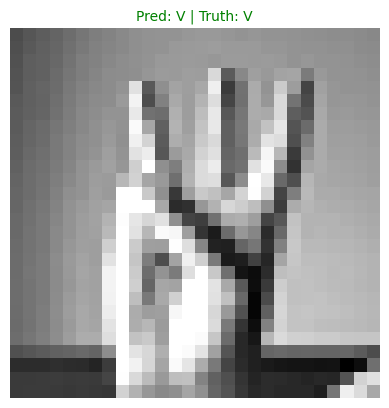

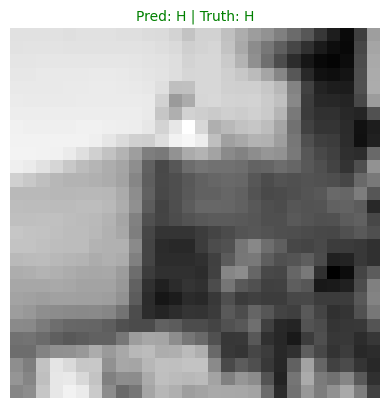

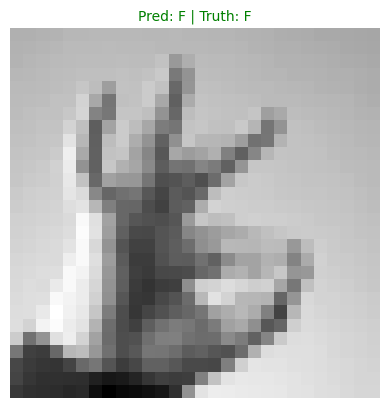

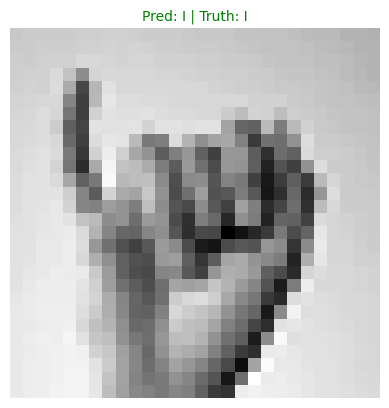

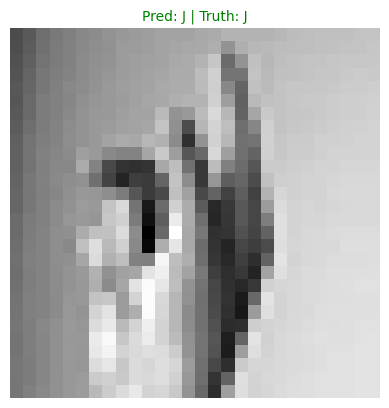

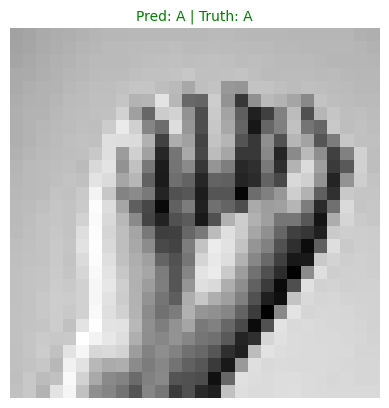

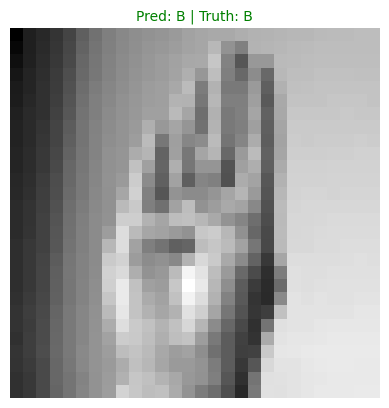

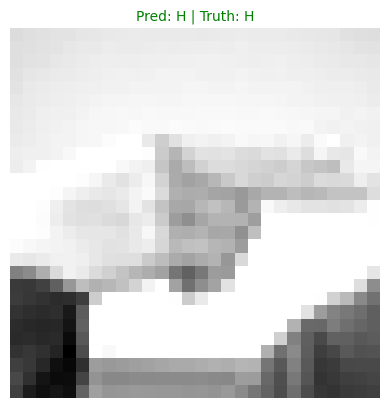

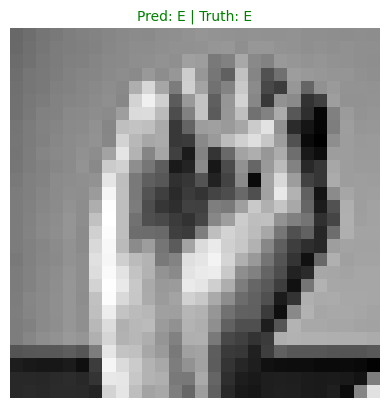

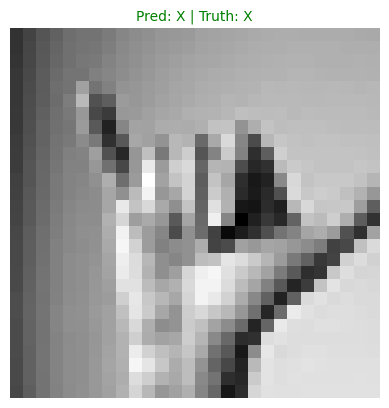

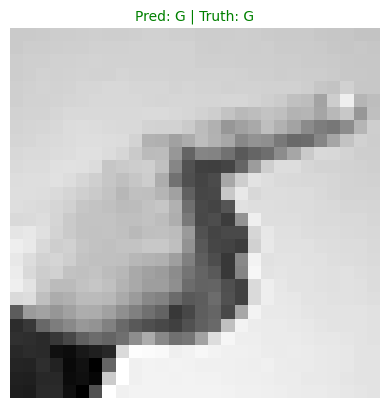

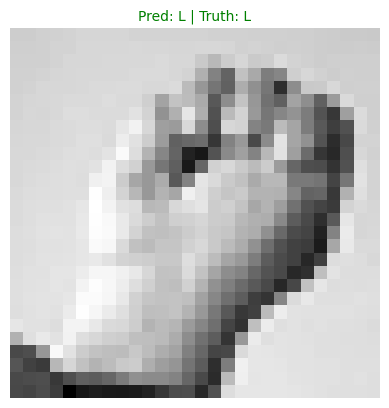

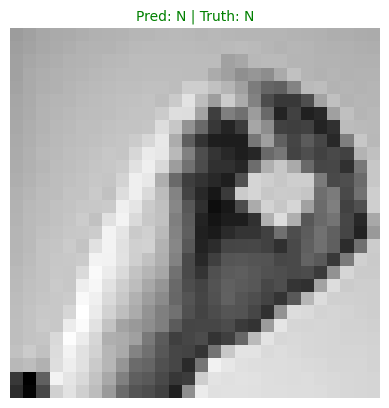

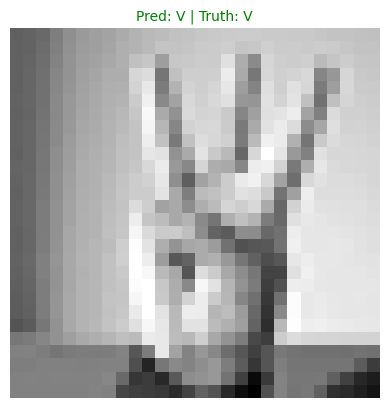

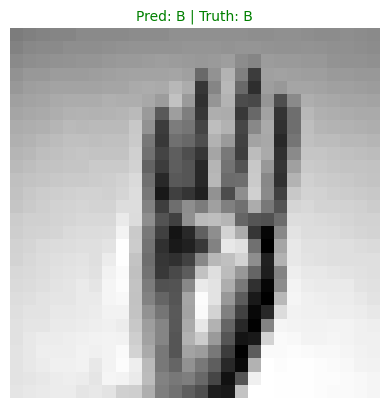

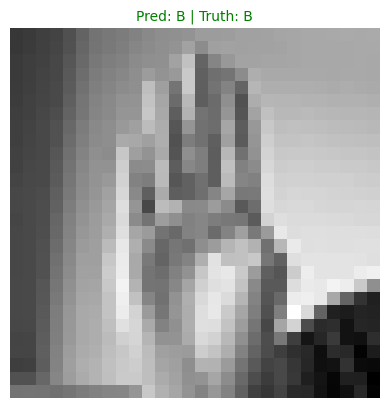

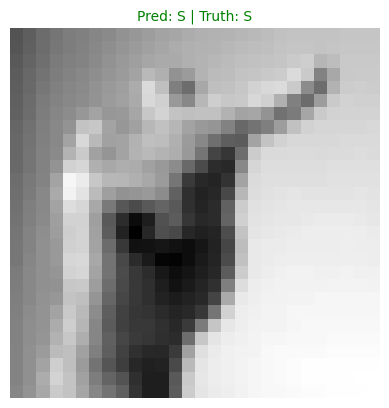

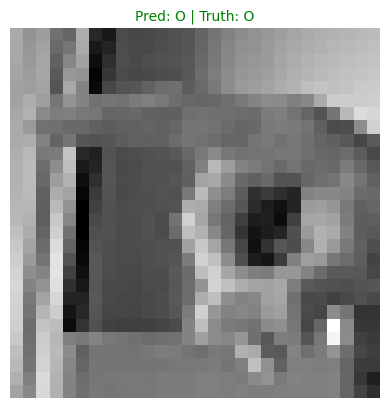

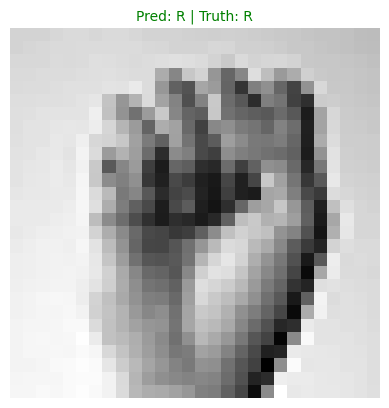

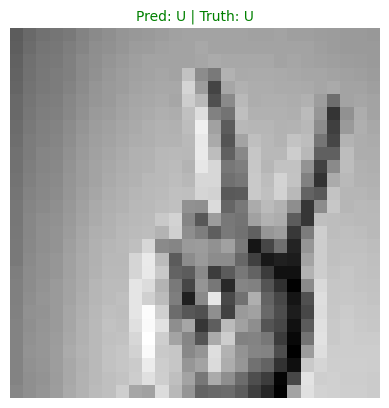

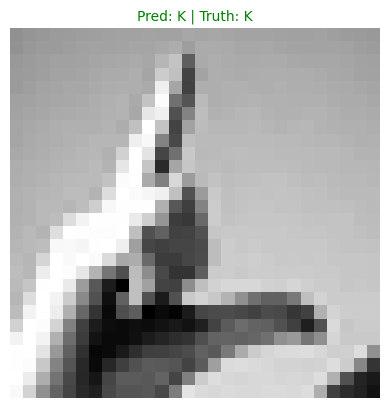

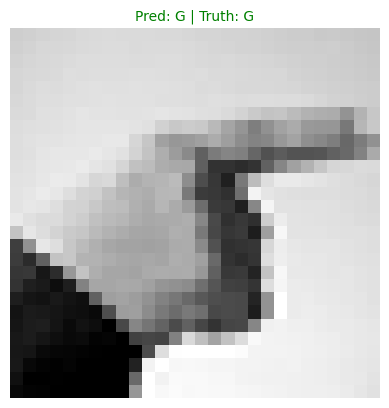

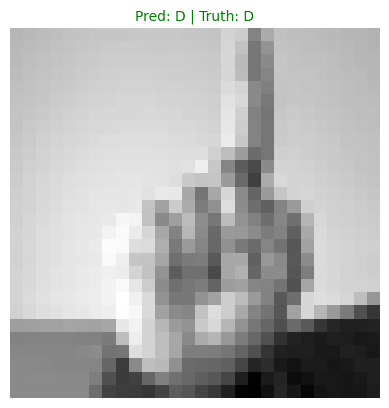

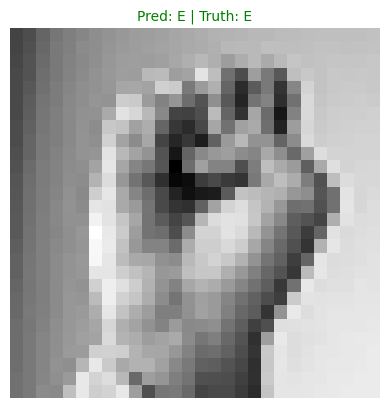

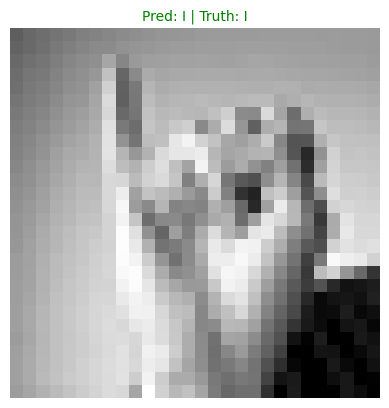

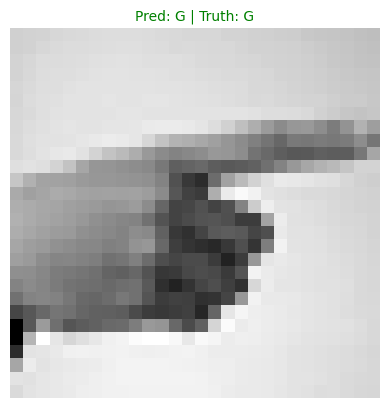

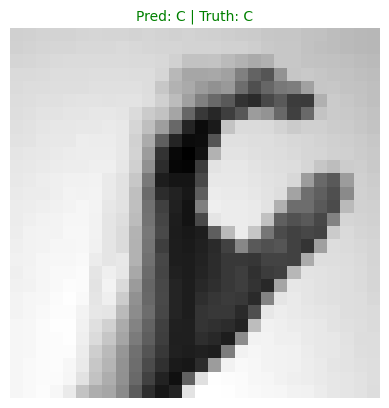

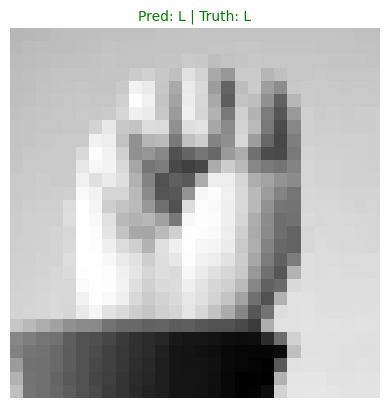

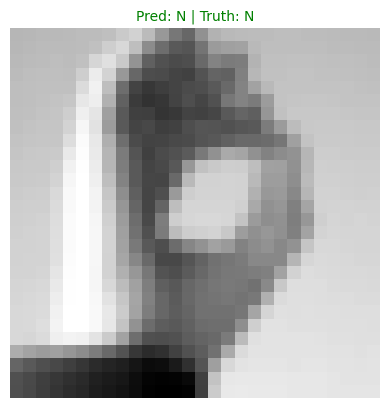

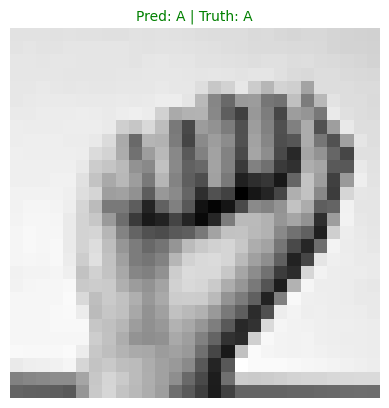

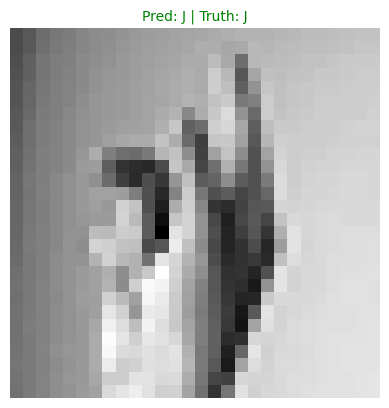

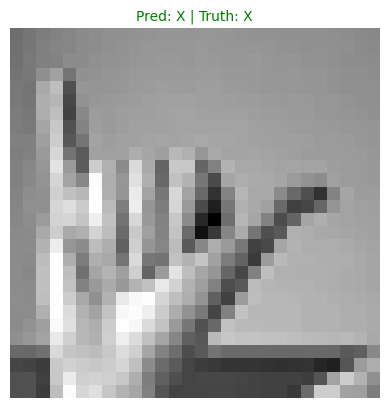

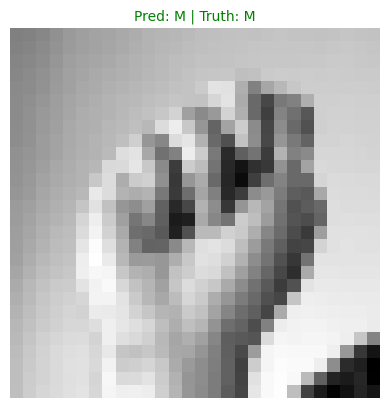

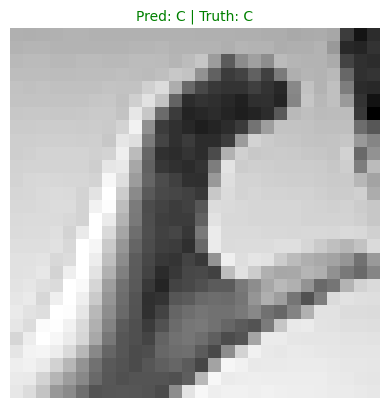

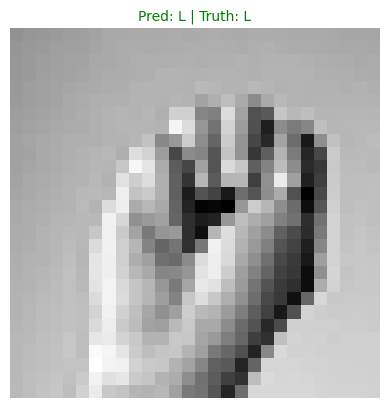

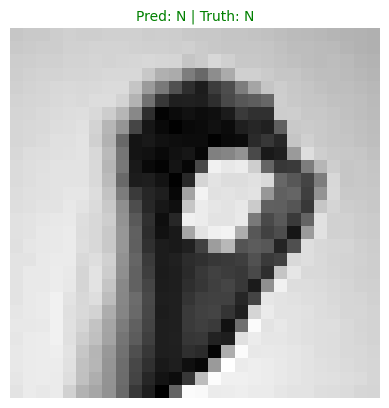

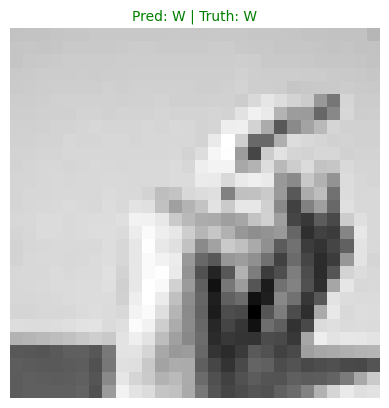

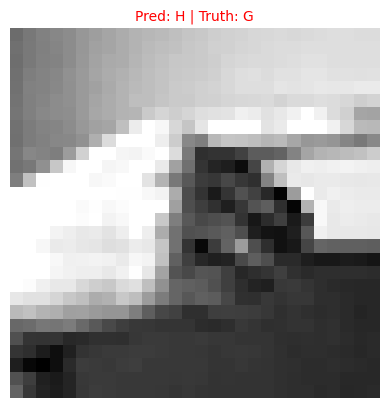

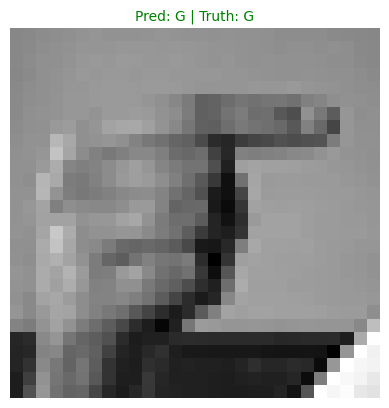

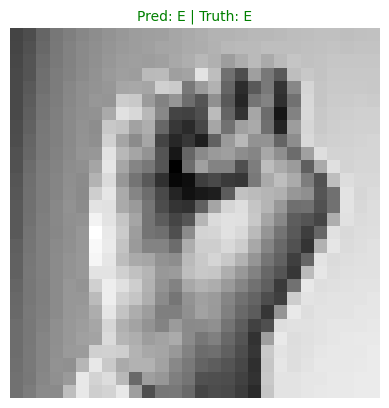

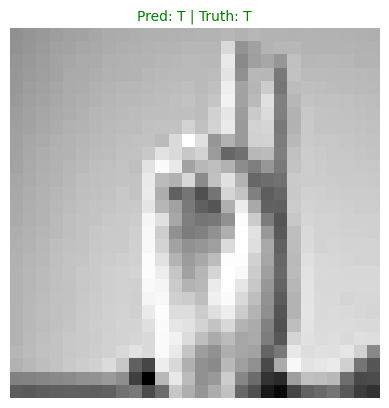

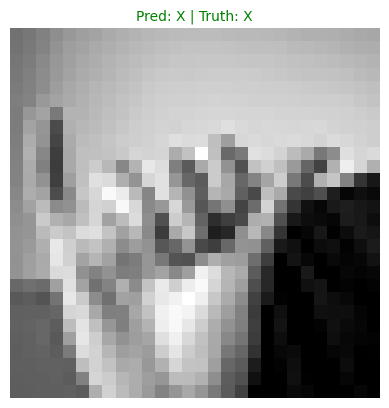

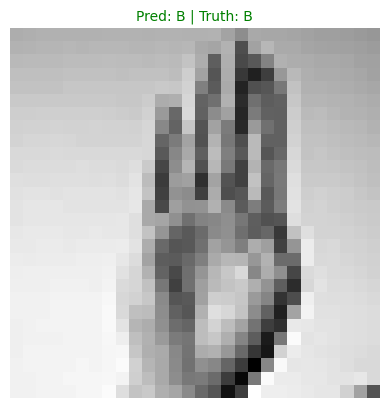

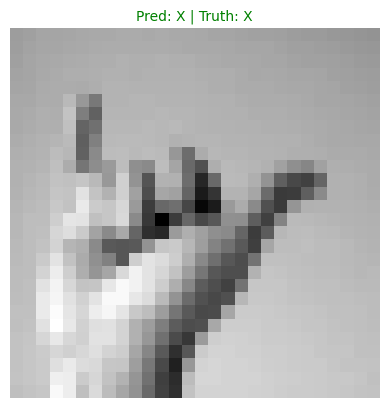

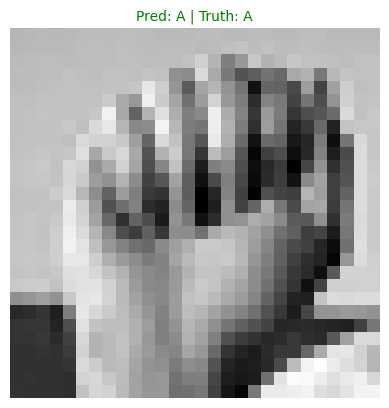

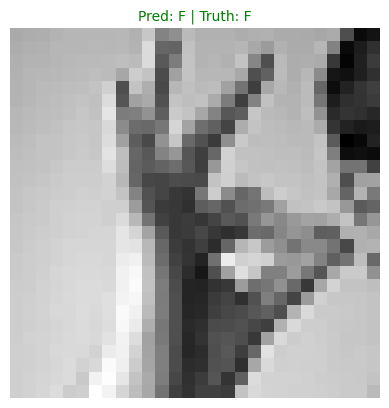

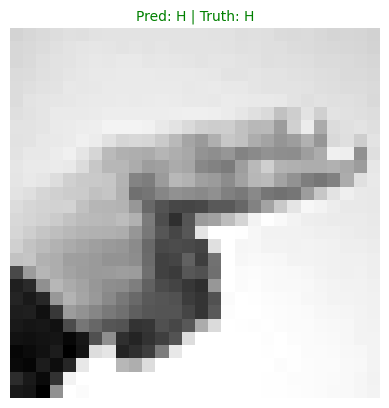

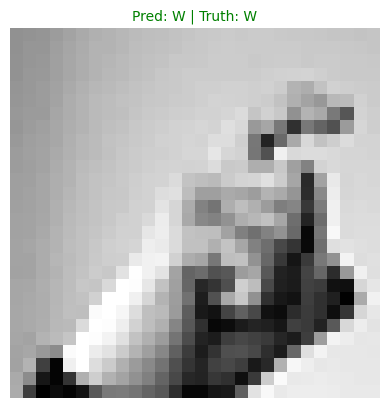

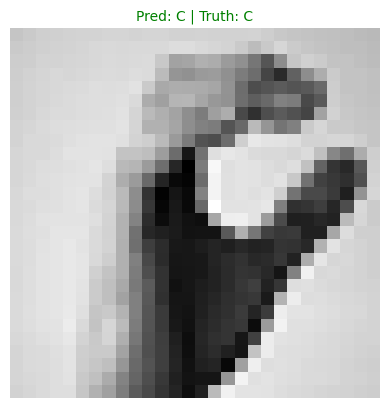

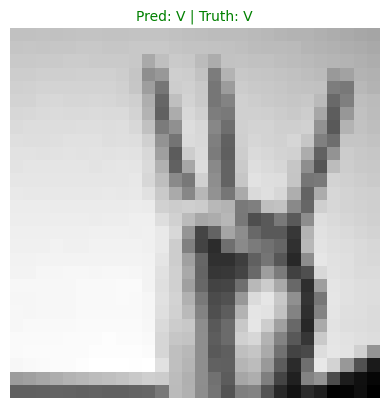

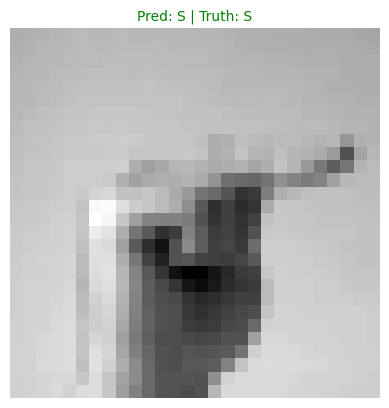

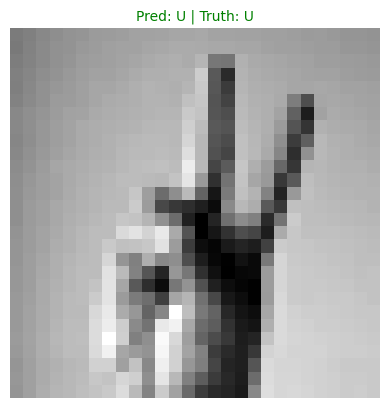

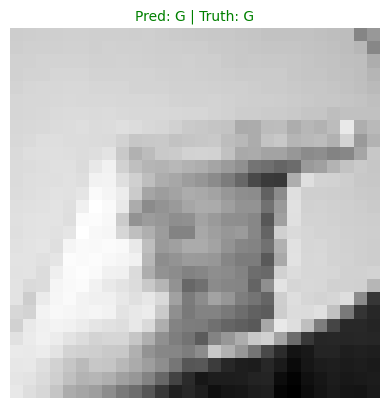

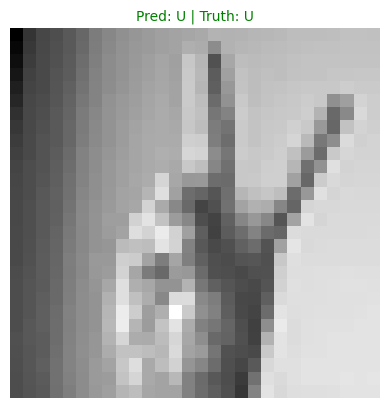

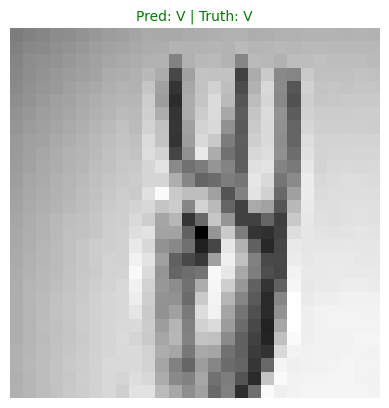

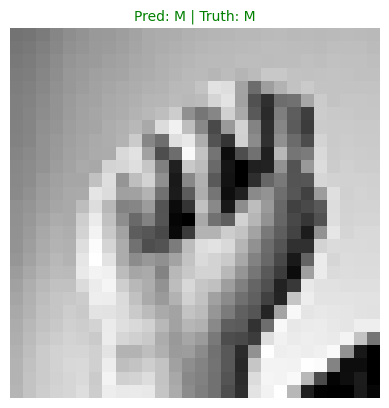

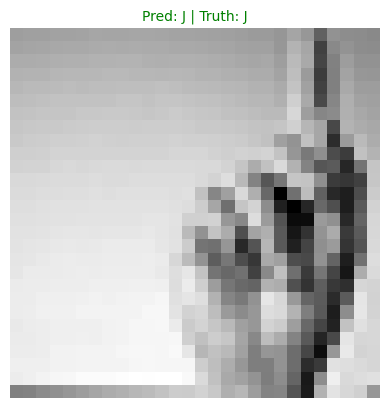

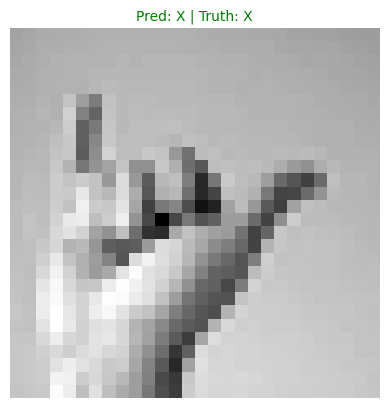

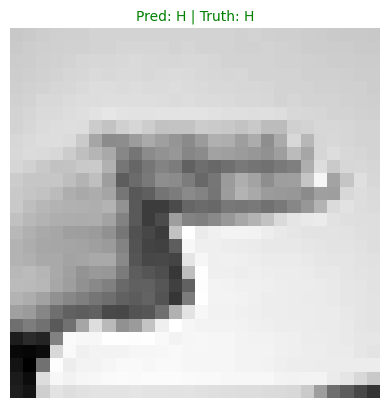

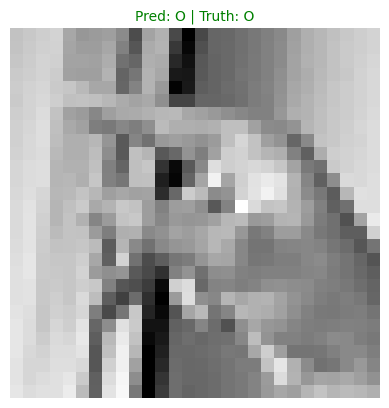

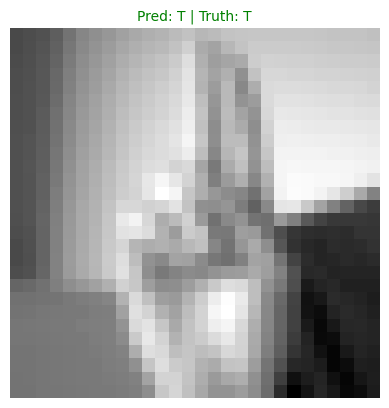

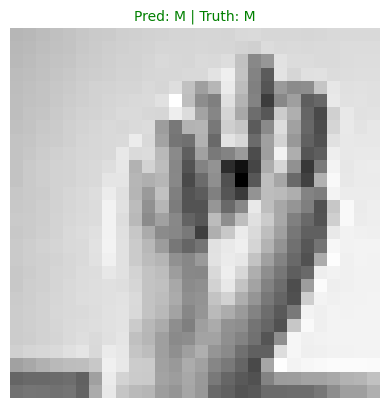

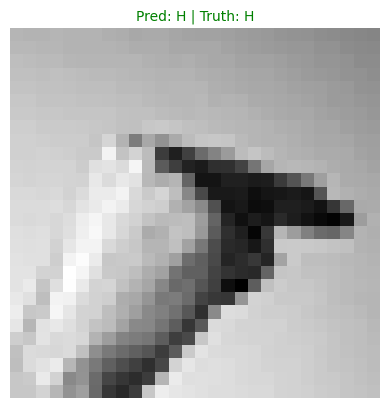

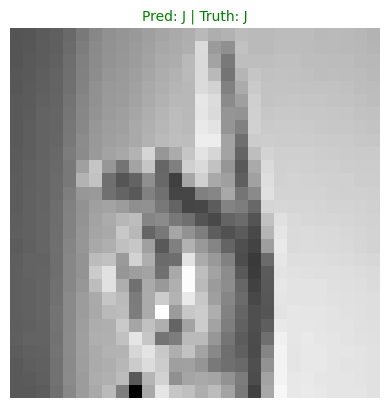

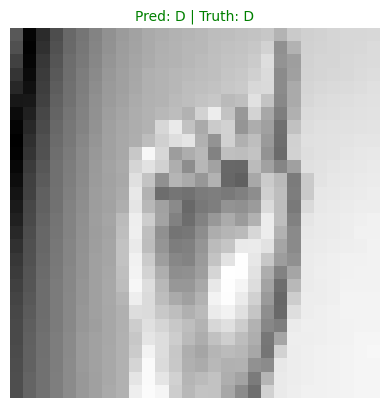

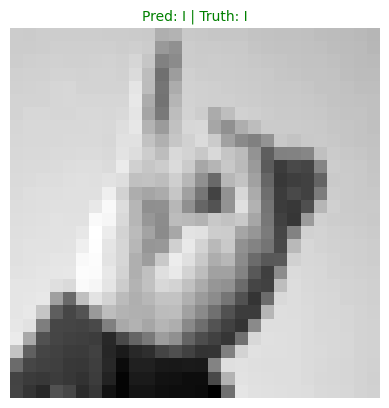

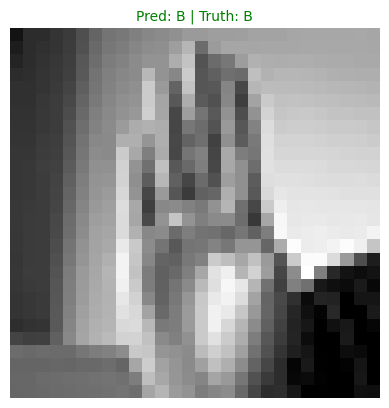

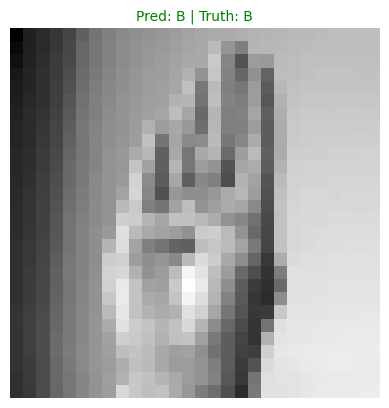

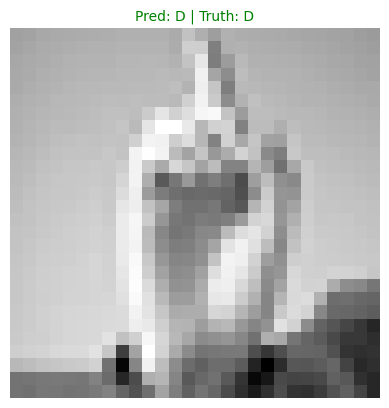

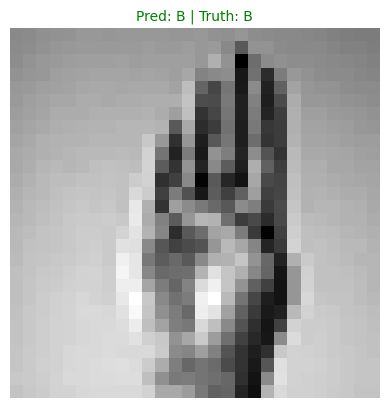

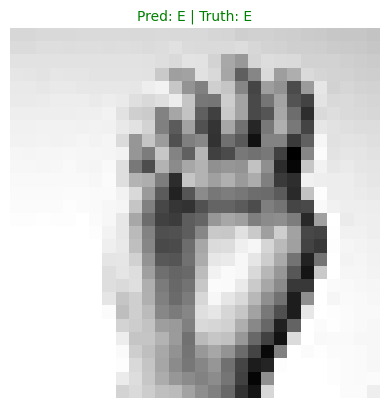

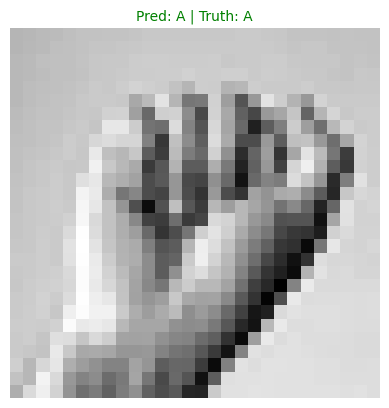

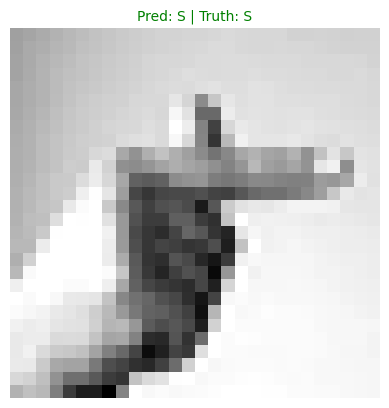

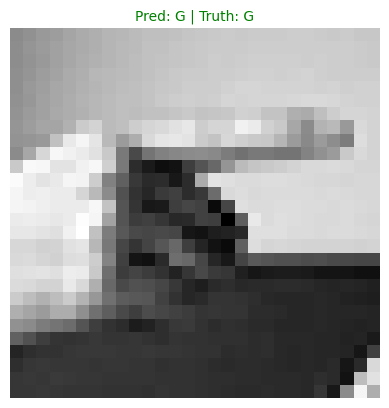

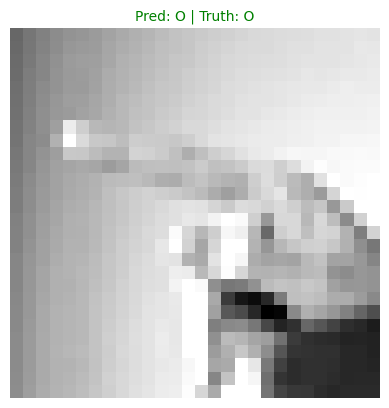

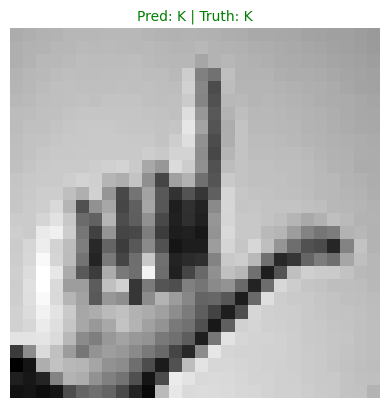

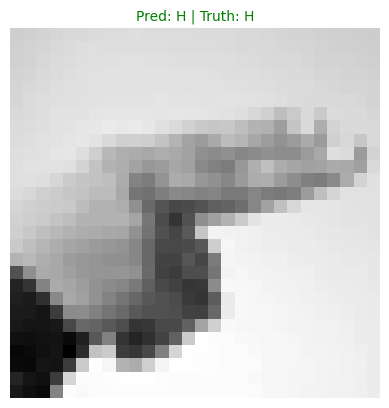

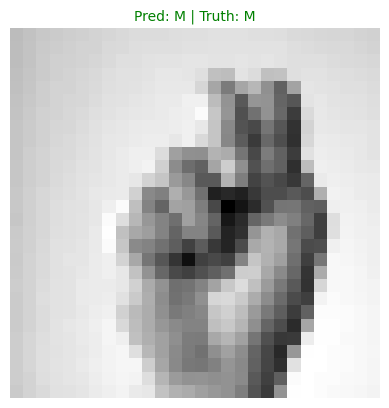

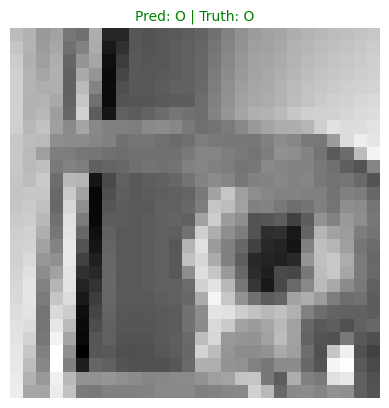

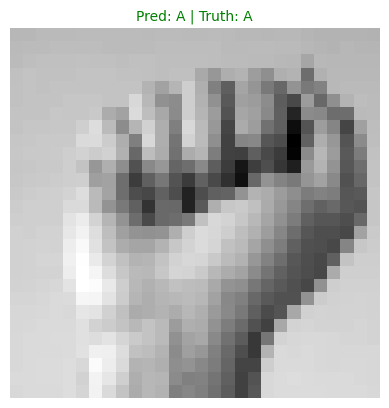

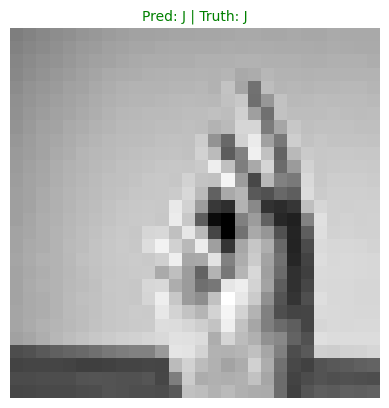

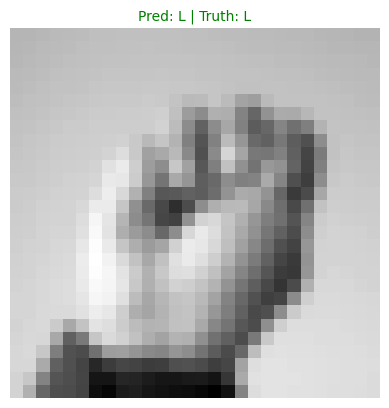

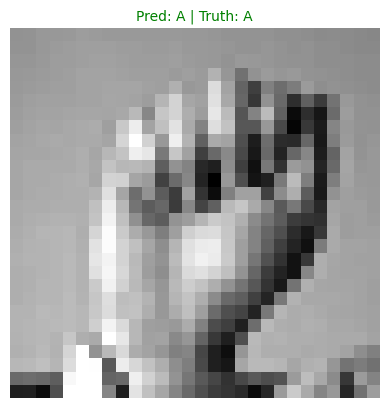

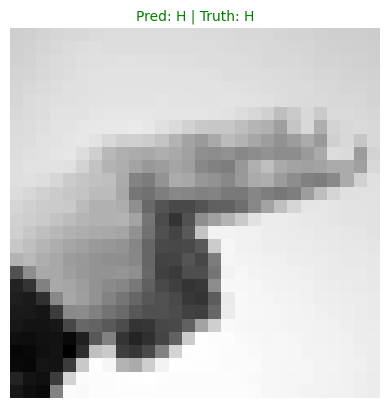

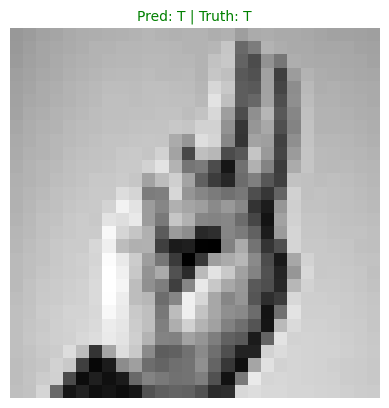

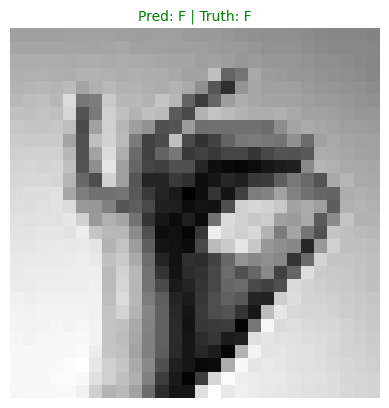

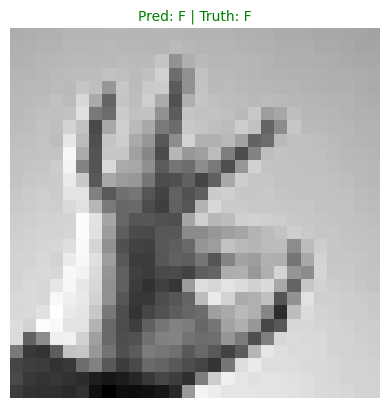

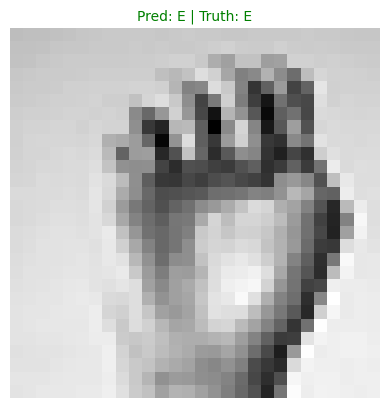

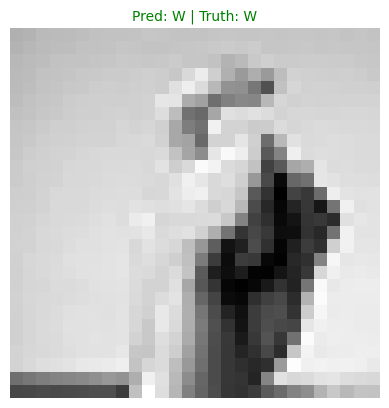

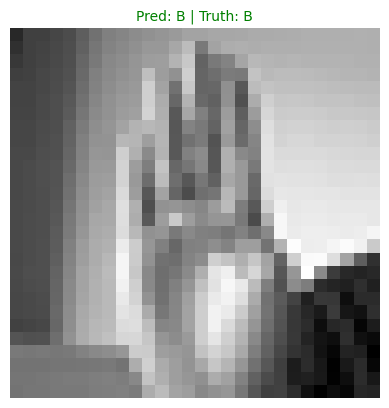

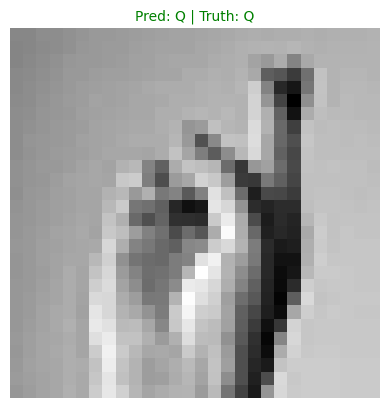

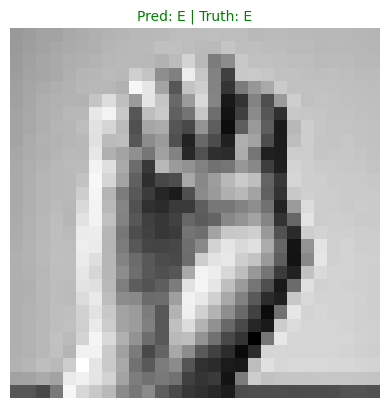

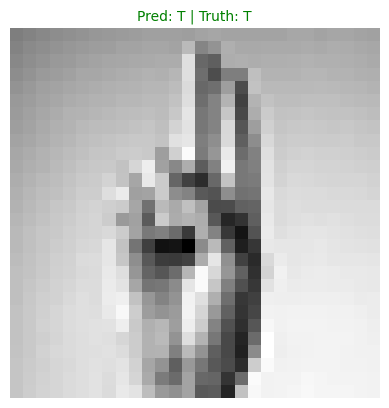

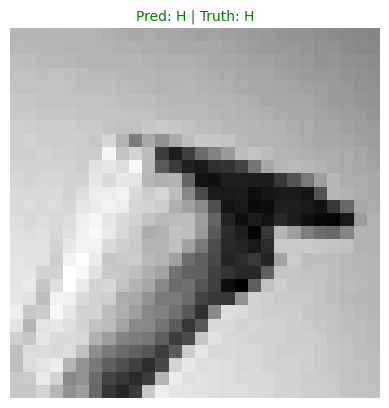

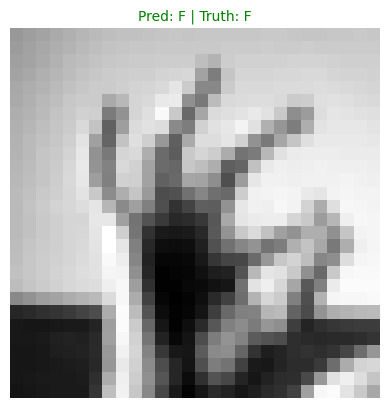

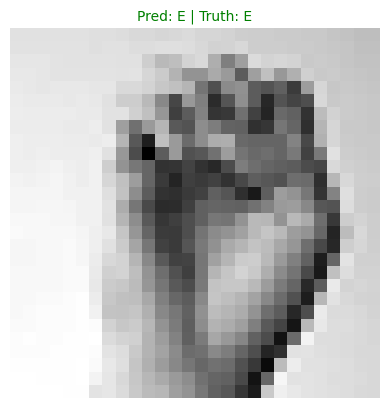

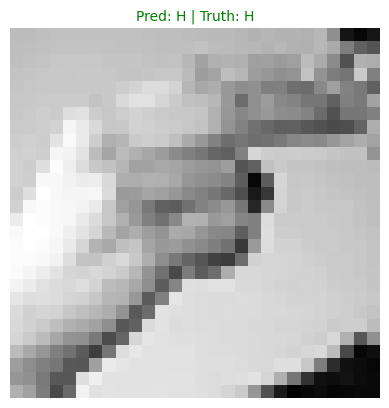

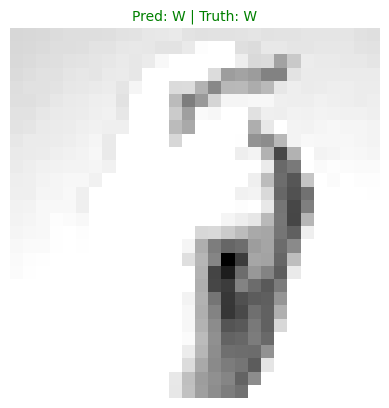

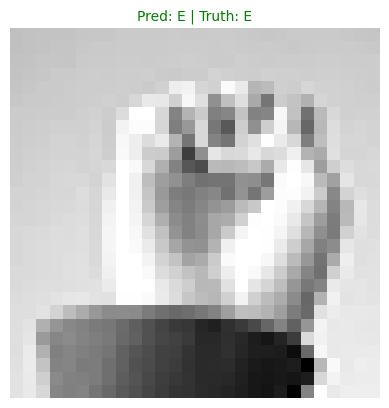

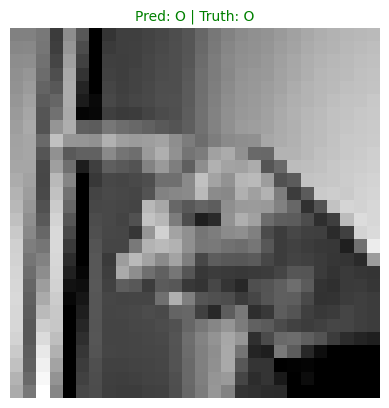

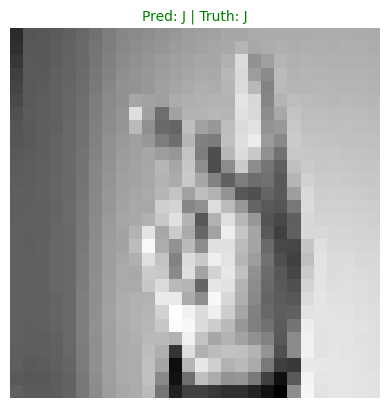

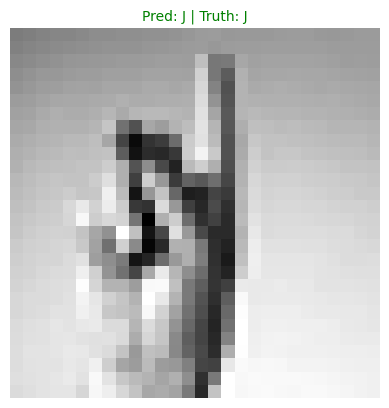

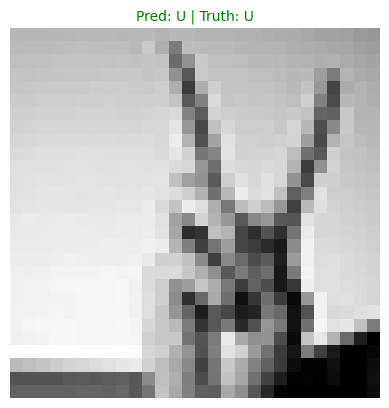

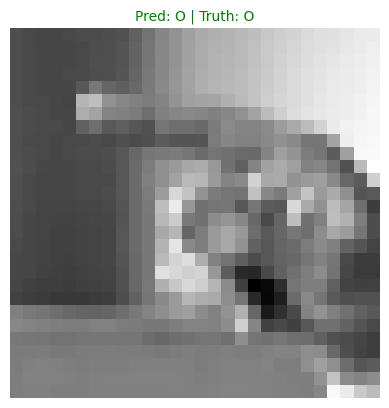

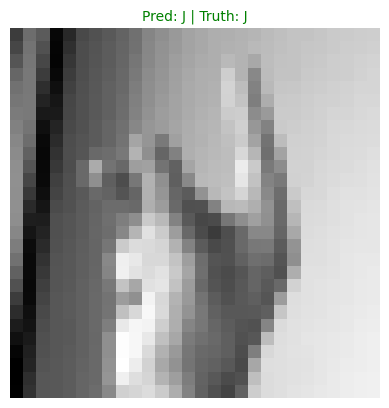

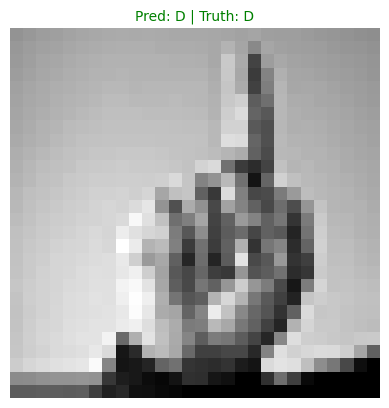

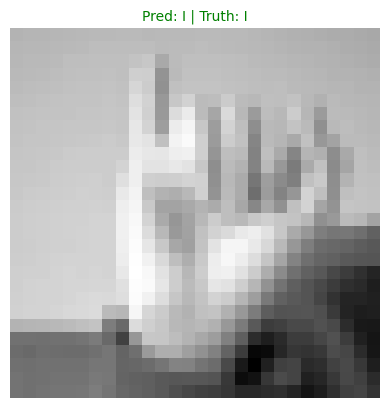

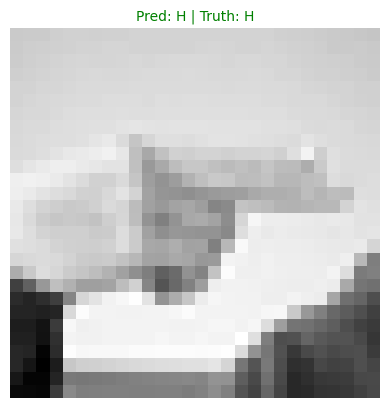

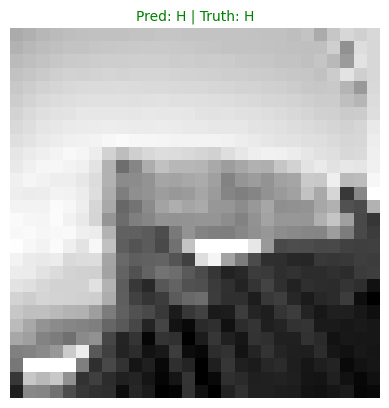

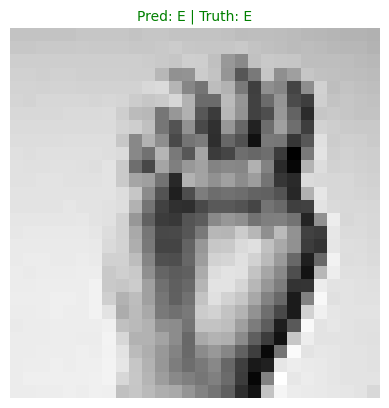

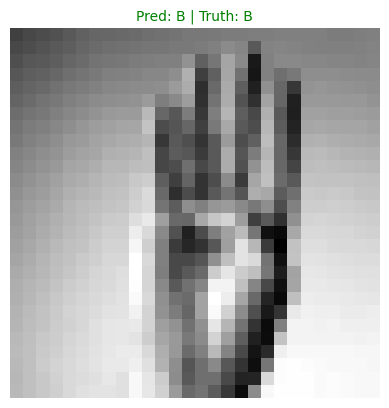

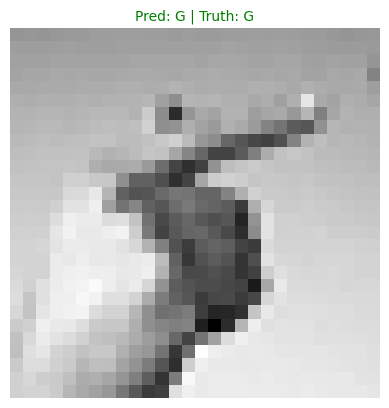

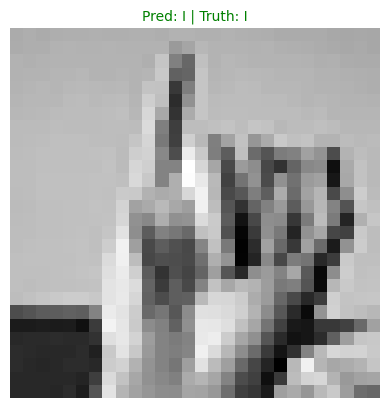

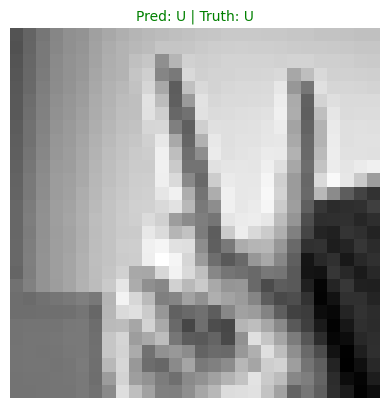

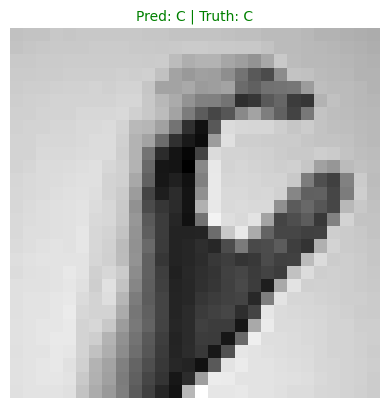

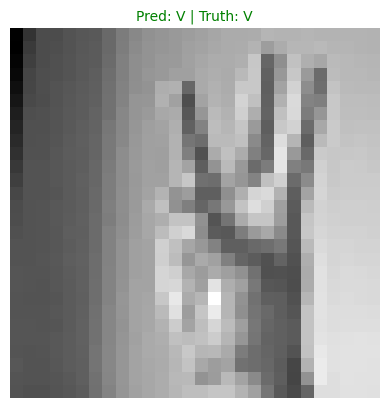

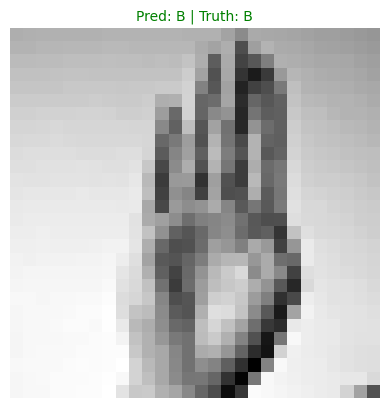

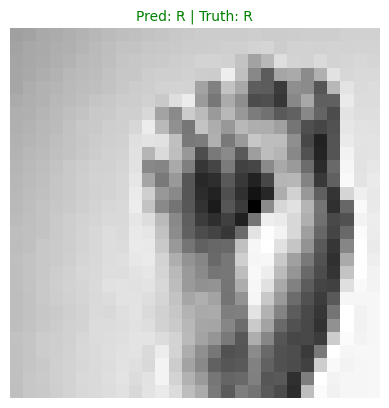

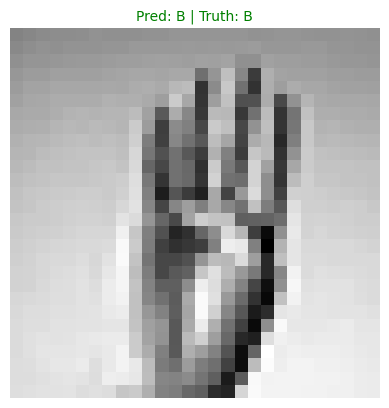

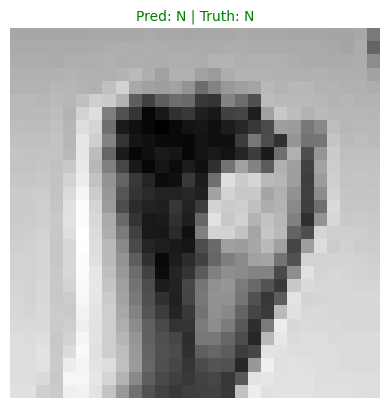

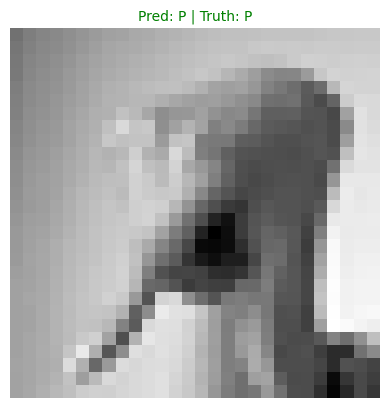

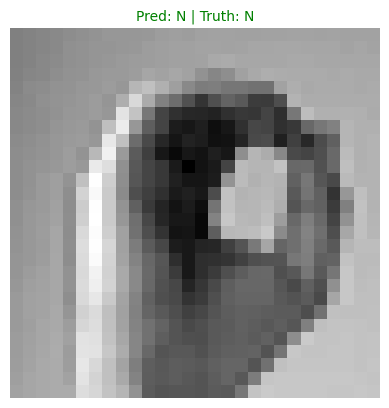

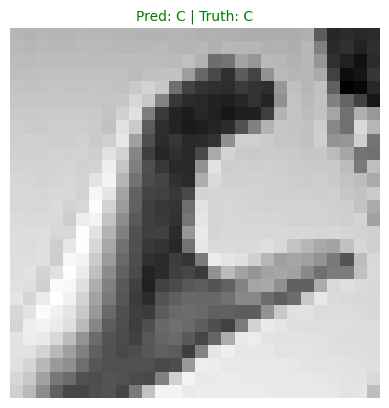

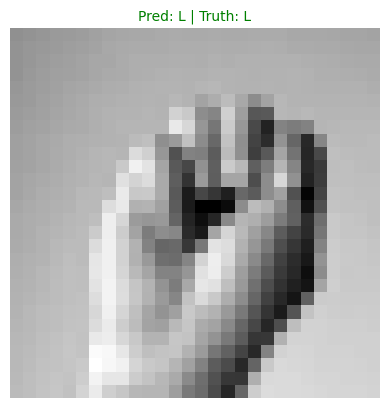

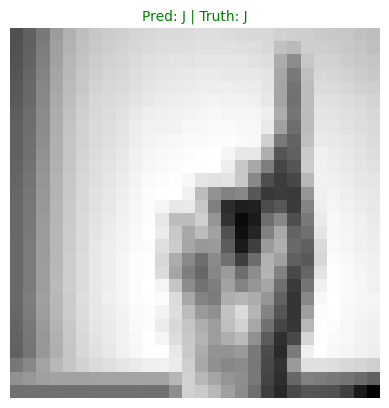

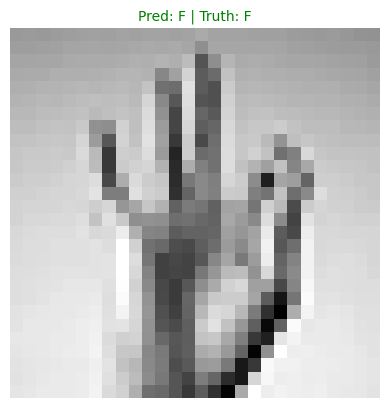

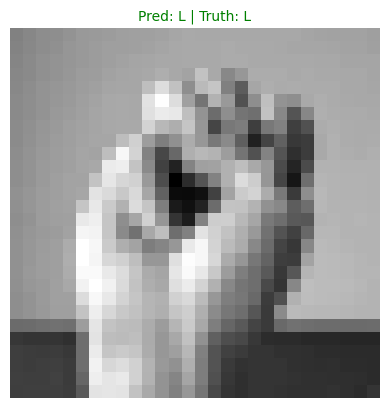

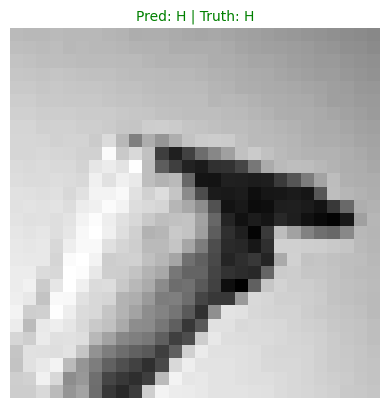

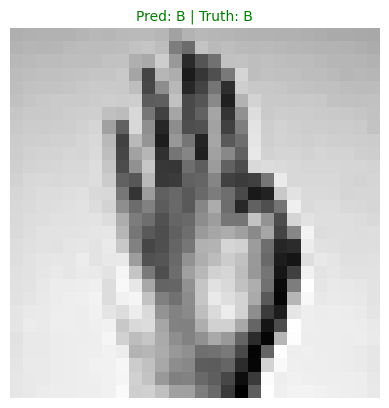

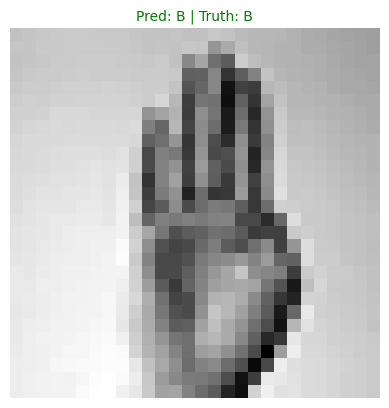

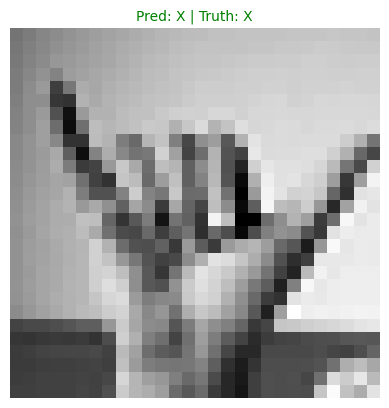

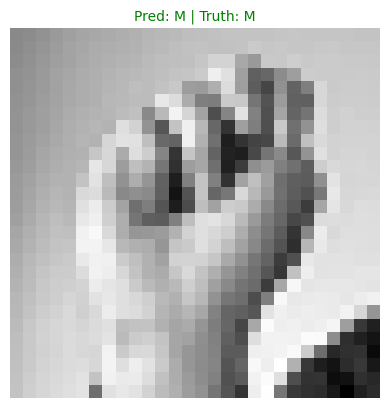

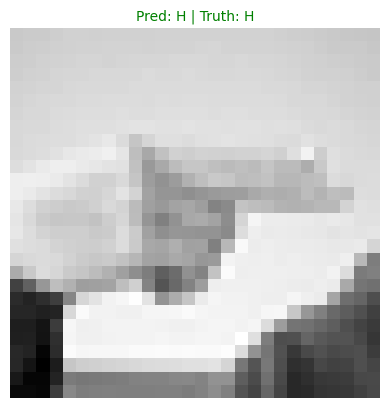

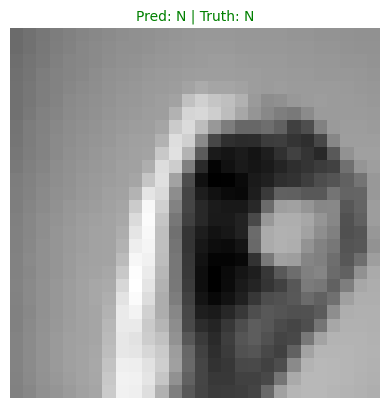

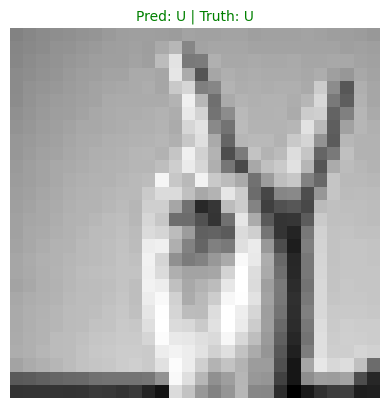

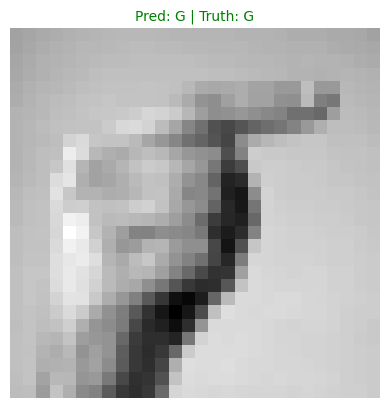

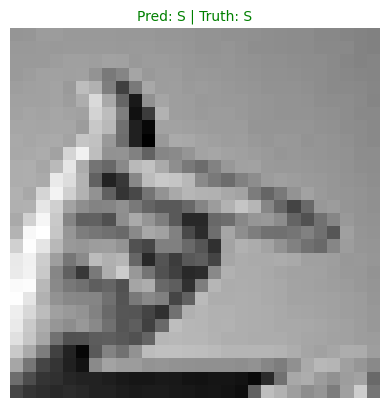

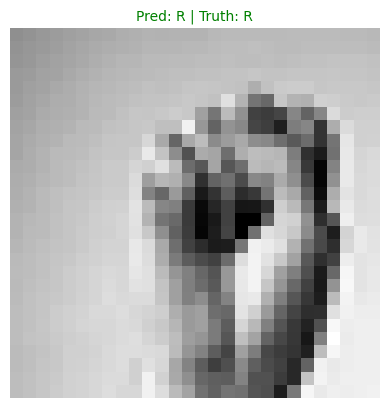

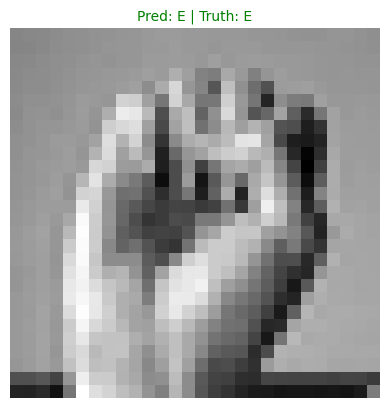

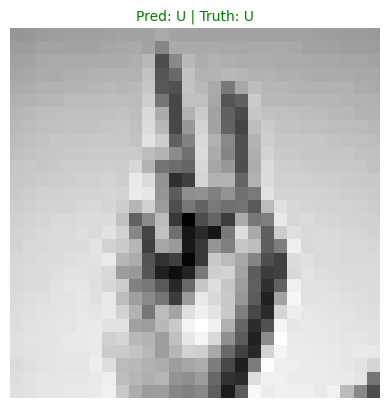

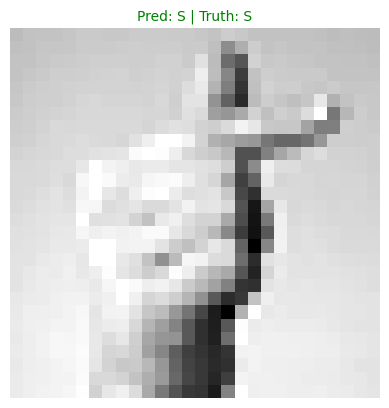

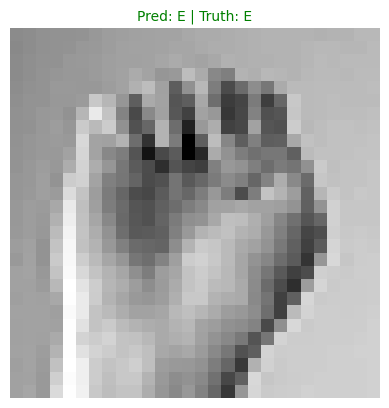

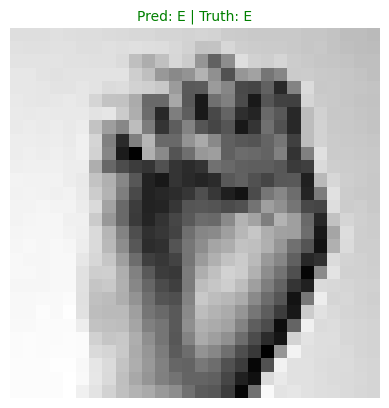

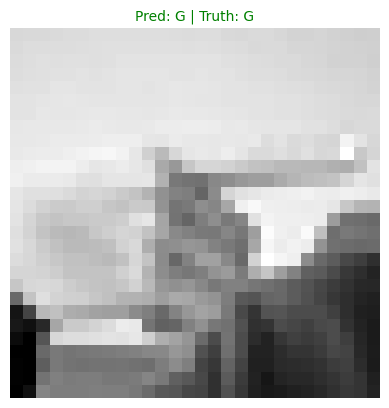

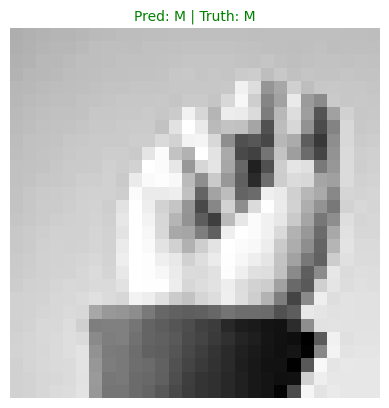

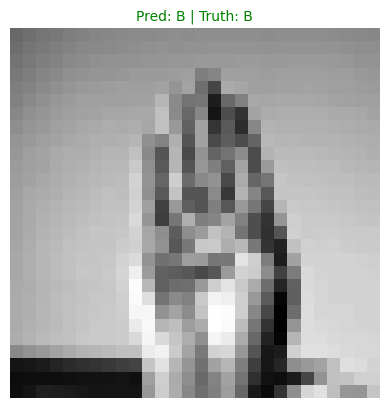

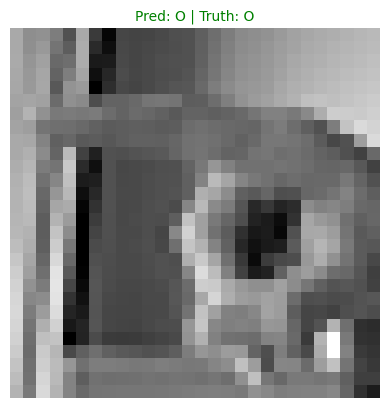

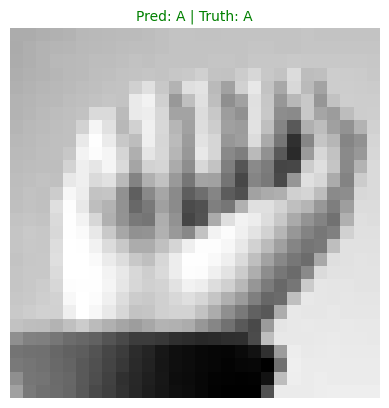

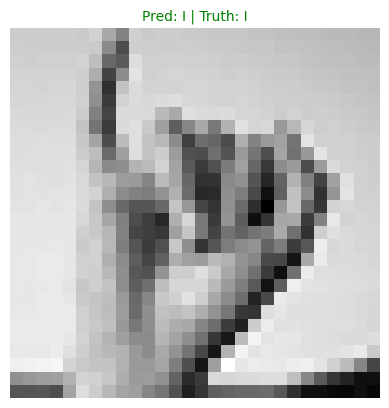

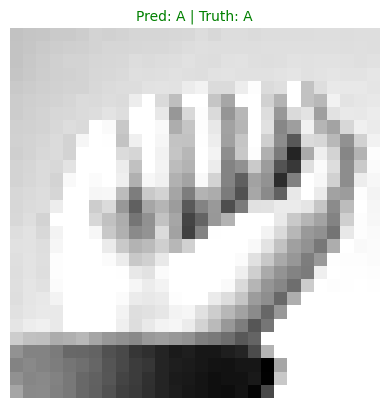

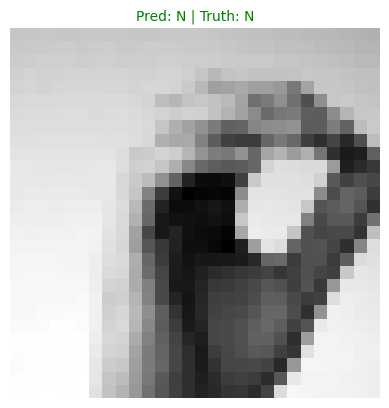

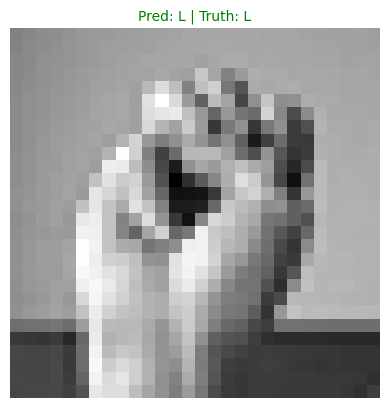

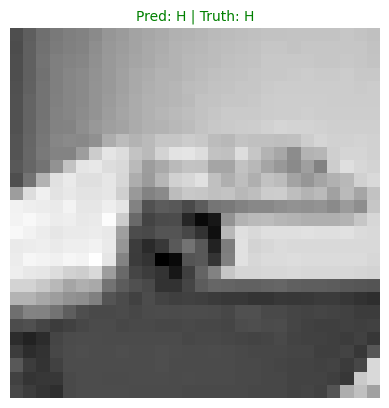

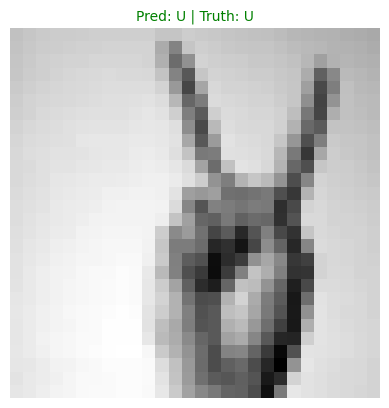

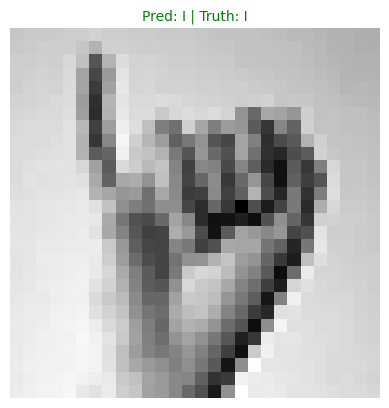

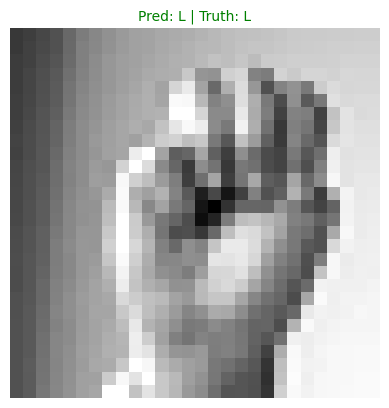

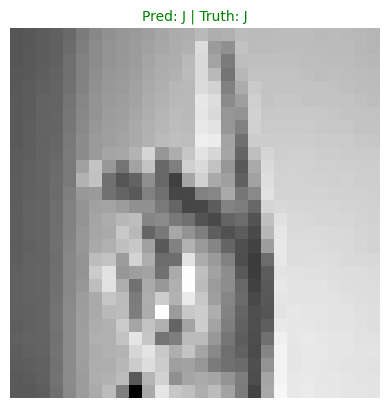

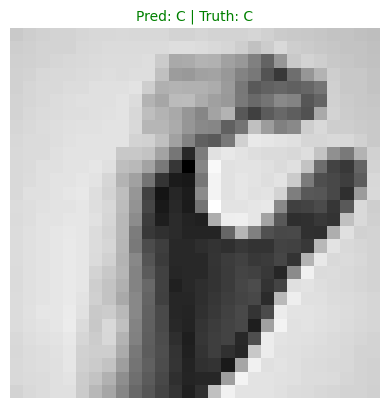

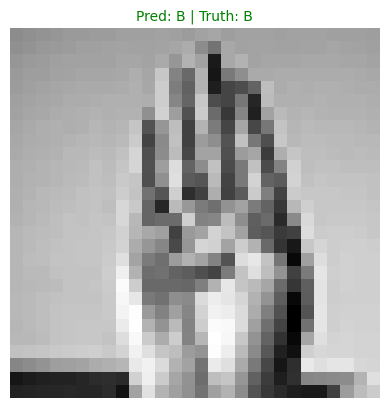

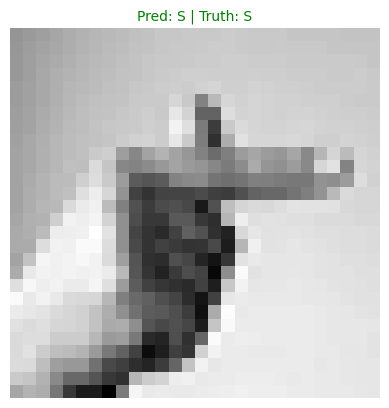

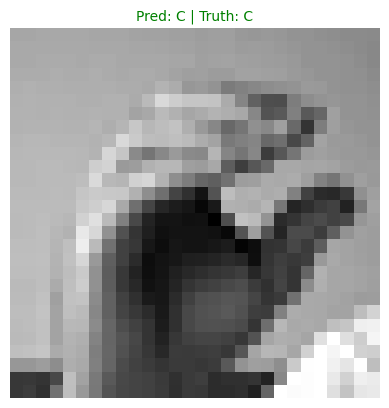

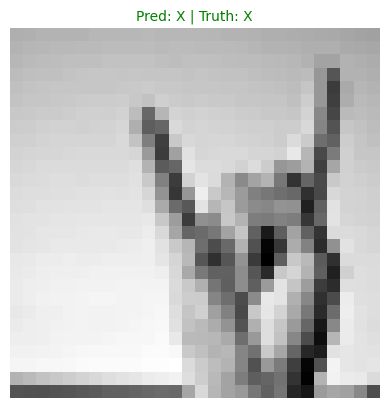

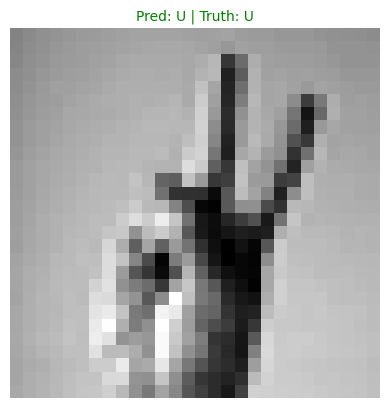

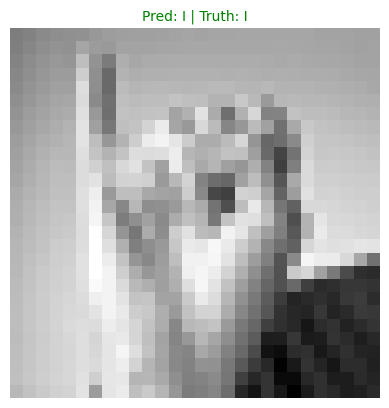

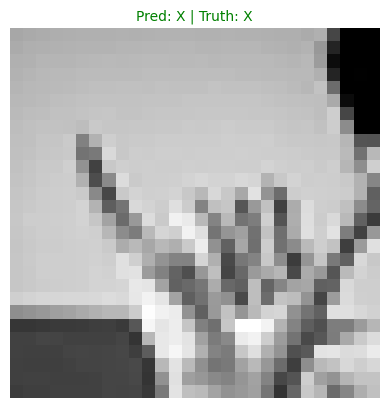

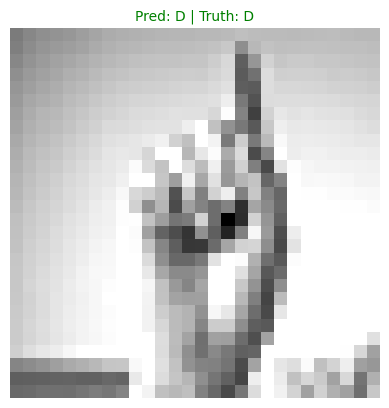

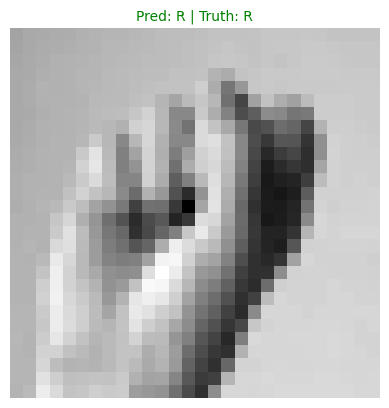

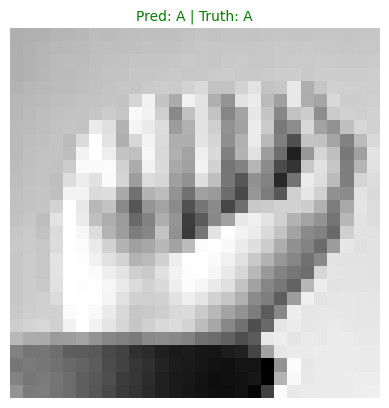

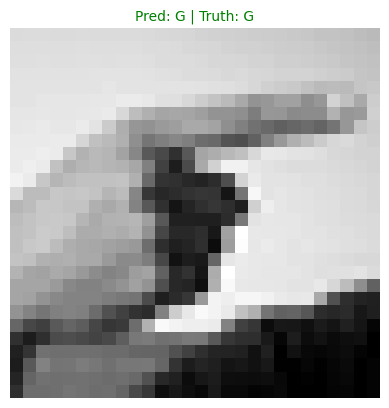

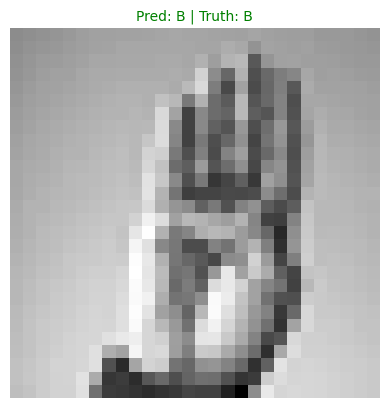

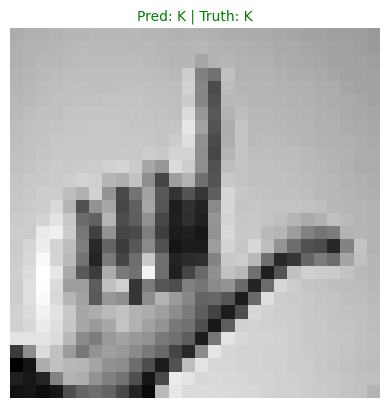

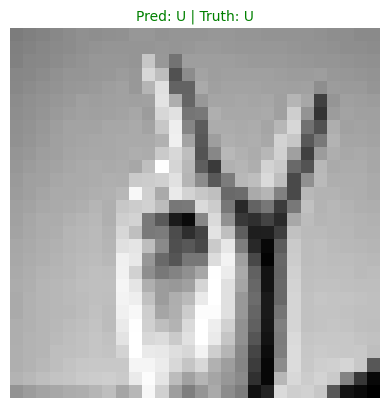

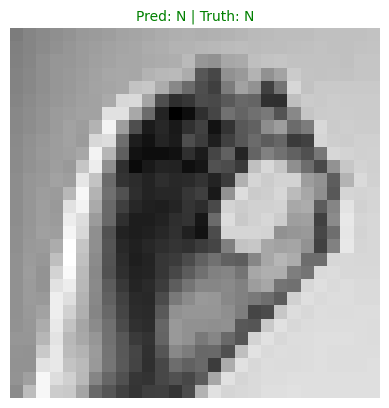

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
sample=model.predict(X_test)
for i in range(len(X_test)):
  prd_sample=sample[i]
  x1=np.argmax(prd_sample)
  x2=np.argmax(y_test[i])

  # Plot the target image
  plt.imshow(X_test[i], cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[x1]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[x2]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)
  plt.show()